In [6]:
from aix360.datasets.heloc_dataset import *
import tensorflow as tf
import pandas as pd
import numpy as np
from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import Dense
from aix360.algorithms.contrastive import CEMExplainer, KerasClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import random

In [2]:
heloc = HELOCDataset()
df = heloc.dataframe()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 24)
pd.set_option('display.width', 1000)
print("Size of HELOC dataset:", df.shape)
print("Number of \"Good\" applicants:", np.sum(df['RiskPerformance']=='Good'))
print("Number of \"Bad\" applicants:", np.sum(df['RiskPerformance']=='Bad'))
print("Sample Applicants:")
df.head(10).transpose()

Using Heloc dataset:  /home/yongjie/software/AIX360/aix360/datasets/../data/heloc_data/heloc_dataset.csv
Size of HELOC dataset: (10459, 24)
Number of "Good" applicants: 5000
Number of "Bad" applicants: 5459
Sample Applicants:


/home/yongjie/software/AIX360/aix360/datasets/heloc_dataset.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col].isin([-7, -8, -9])] = 0
/home/yongjie/anaconda3/envs/aix360/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,0,1,2,3,4,5,6,7,8,9
ExternalRiskEstimate,55,61,67,66,81,59,54,68,59,61
MSinceOldestTradeOpen,144,58,66,169,333,137,88,148,324,79
MSinceMostRecentTradeOpen,4,15,5,1,27,11,7,7,2,4
AverageMInFile,84,41,24,73,132,78,37,65,138,36
NumSatisfactoryTrades,20,2,9,28,12,31,25,17,24,19
NumTrades60Ever2DerogPubRec,3,4,0,1,0,0,0,0,0,0
NumTrades90Ever2DerogPubRec,0,4,0,1,0,0,0,0,0,0
PercentTradesNeverDelq,83,100,100,93,100,91,92,83,85,95
MSinceMostRecentDelq,2,-7,-7,76,-7,1,9,31,5,5
MaxDelq2PublicRecLast12M,3,0,7,6,7,4,4,6,4,4


In [35]:
df['RiskPerformance'].replace(to_replace=['Bad', 'Good'], value=[0, 1], inplace=True)

Distribution of ExternalRiskEstimate and NumSatisfactoryTrades columns:


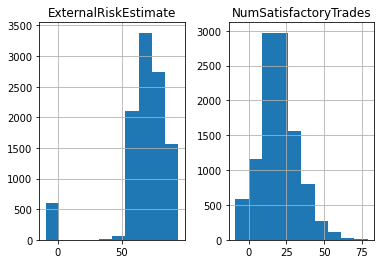

In [36]:
# Plot (example) distributions for two features
print("Distribution of ExternalRiskEstimate and NumSatisfactoryTrades columns:")
hist = df.hist(column=['ExternalRiskEstimate', 'NumSatisfactoryTrades'], bins=10)

In [37]:
random.seed(0)
a = list(range(len(df)))
random.shuffle(a)
length = len(a)

In [38]:
train = df.iloc[a[0:int(len(a) * 0.5)]]
query = df.iloc[a[int(len(a) * 0.5):int(len(a) * 0.75)]]
test = df.iloc[a[int(len(a) * 0.75):]]

In [39]:
train_x, train_y = train.iloc[:, 0:-1].values, train.iloc[:, -1].values
query_x, query_y = query.iloc[:, 0:-1].values, query.iloc[:, -1].values
test_x, test_y = test.iloc[:, 0:-1].values, test.iloc[:, -1].values

In [40]:
scaler = MinMaxScaler()
strain_x = scaler.fit_transform(train_x)
squery_x = scaler.fit_transform(query_x)
stest_x = scaler.fit_transform(test_x)

In [41]:
print(train_y)
print(query_y)
print(test_y)

[0 1 1 ... 1 1 1]
[0 1 1 ... 1 1 1]
[1 1 0 ... 1 1 0]


In [42]:
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)
query_y = to_categorical(query_y)

In [57]:
# nn with no softmax
def nn_small():
    model = Sequential()
    model.add(Dense(10, input_dim=23, kernel_initializer='normal', activation='relu'))
    #model.add(Dense(30, kernel_initializer='normal', activation='relu'))
    model.add(Dense(2, kernel_initializer='normal'))    
    return model

In [59]:
def fn(correct, predicted):
    return tf.nn.softmax_cross_entropy_with_logits(labels=correct, logits=predicted)

# compile and print model summary
nn = nn_small()
nn.compile(loss=fn, optimizer='adam', metrics=['accuracy'])
nn.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 10)                240       
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 22        
Total params: 262
Trainable params: 262
Non-trainable params: 0
_________________________________________________________________


In [60]:
TRAIN_MODEL = True

if (TRAIN_MODEL):             
    nn.fit(strain_x, train_y, batch_size=128, epochs=300, verbose=1, shuffle=False)
    nn.save_weights("heloc_nnsmall.h5")     
else:    
    nn.load_weights("heloc_nnsmall.h5")
        

# evaluate model accuracy        
score = nn.evaluate(strain_x, train_y, verbose=0) #Compute training set accuracy
#print('Train loss:', score[0])
print('Train accuracy:', score[1])

score = nn.evaluate(squery_x, query_y, verbose=0) #Compute test set accuracy
#print('Test loss:', score[0])
print('Query accuracy:', score[1])

score = nn.evaluate(stest_x, test_y, verbose=0) #Compute test set accuracy
#print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/300
5229/5229 [==============================] - 0s 59us/step - loss: 0.6929 - accuracy: 0.5185
Epoch 2/300
5229/5229 [==============================] - 0s 15us/step - loss: 0.6898 - accuracy: 0.5227
Epoch 3/300
5229/5229 [==============================] - 0s 20us/step - loss: 0.6828 - accuracy: 0.6068
Epoch 4/300
5229/5229 [==============================] - 0s 17us/step - loss: 0.6711 - accuracy: 0.6615
Epoch 5/300
5229/5229 [==============================] - 0s 19us/step - loss: 0.6557 - accuracy: 0.6751
Epoch 6/300
5229/5229 [==============================] - 0s 20us/step - loss: 0.6392 - accuracy: 0.6820
Epoch 7/300
5229/5229 [==============================] - 0s 14us/step - loss: 0.6242 - accuracy: 0.6825
Epoch 8/300
5229/5229 [==============================] - 0s 13us/step - loss: 0.6121 - accuracy: 0.6862
Epoch 9/300
5229/5229 [==============================] - 0s 11us/step - loss: 0.6029 - accuracy: 0.6902
Epoch 10/300
5229/5229 [==============================] - 0s 10u

5229/5229 [==============================] - 0s 11us/step - loss: 0.5595 - accuracy: 0.7185
Epoch 80/300
5229/5229 [==============================] - 0s 10us/step - loss: 0.5593 - accuracy: 0.7185
Epoch 81/300
5229/5229 [==============================] - 0s 13us/step - loss: 0.5592 - accuracy: 0.7181
Epoch 82/300
5229/5229 [==============================] - 0s 10us/step - loss: 0.5591 - accuracy: 0.7189
Epoch 83/300
5229/5229 [==============================] - 0s 12us/step - loss: 0.5590 - accuracy: 0.7185
Epoch 84/300
5229/5229 [==============================] - 0s 11us/step - loss: 0.5589 - accuracy: 0.7187
Epoch 85/300
5229/5229 [==============================] - 0s 12us/step - loss: 0.5588 - accuracy: 0.7179
Epoch 86/300
5229/5229 [==============================] - 0s 11us/step - loss: 0.5587 - accuracy: 0.7187
Epoch 87/300
5229/5229 [==============================] - 0s 9us/step - loss: 0.5586 - accuracy: 0.7183
Epoch 88/300
5229/5229 [==============================] - 0s 9us/step

5229/5229 [==============================] - 0s 9us/step - loss: 0.5540 - accuracy: 0.7216
Epoch 157/300
5229/5229 [==============================] - 0s 9us/step - loss: 0.5540 - accuracy: 0.7212
Epoch 158/300
5229/5229 [==============================] - 0s 9us/step - loss: 0.5539 - accuracy: 0.7214
Epoch 159/300
5229/5229 [==============================] - 0s 9us/step - loss: 0.5539 - accuracy: 0.7214
Epoch 160/300
5229/5229 [==============================] - 0s 12us/step - loss: 0.5538 - accuracy: 0.7219
Epoch 161/300
5229/5229 [==============================] - 0s 12us/step - loss: 0.5538 - accuracy: 0.7217
Epoch 162/300
5229/5229 [==============================] - 0s 10us/step - loss: 0.5537 - accuracy: 0.7219
Epoch 163/300
5229/5229 [==============================] - 0s 9us/step - loss: 0.5537 - accuracy: 0.7217
Epoch 164/300
5229/5229 [==============================] - 0s 11us/step - loss: 0.5537 - accuracy: 0.7216
Epoch 165/300
5229/5229 [==============================] - 0s 11u

5229/5229 [==============================] - 0s 9us/step - loss: 0.5518 - accuracy: 0.7208
Epoch 234/300
5229/5229 [==============================] - 0s 14us/step - loss: 0.5518 - accuracy: 0.7206
Epoch 235/300
5229/5229 [==============================] - 0s 12us/step - loss: 0.5518 - accuracy: 0.7208
Epoch 236/300
5229/5229 [==============================] - 0s 10us/step - loss: 0.5518 - accuracy: 0.7210
Epoch 237/300
5229/5229 [==============================] - 0s 9us/step - loss: 0.5518 - accuracy: 0.7212
Epoch 238/300
5229/5229 [==============================] - 0s 9us/step - loss: 0.5518 - accuracy: 0.7210
Epoch 239/300
5229/5229 [==============================] - 0s 11us/step - loss: 0.5517 - accuracy: 0.7210
Epoch 240/300
5229/5229 [==============================] - 0s 11us/step - loss: 0.5517 - accuracy: 0.7210
Epoch 241/300
5229/5229 [==============================] - 0s 12us/step - loss: 0.5517 - accuracy: 0.7214
Epoch 242/300
5229/5229 [==============================] - 0s 1

In [61]:
mymodel = KerasClassifier(nn)
explainer = CEMExplainer(mymodel)

arg_mode = 'PN' # Find pertinent negatives
arg_max_iter = 1000 # Maximum number of iterations to search for the optimal PN for given parameter settings
arg_init_const = 10.0 # Initial coefficient value for main loss term that encourages class change
arg_b = 9 # No. of updates to the coefficient of the main loss term
arg_kappa = 0.2 # Minimum confidence gap between the PNs (changed) class probability and original class' probability
arg_beta = 1e-1 # Controls sparsity of the solution (L1 loss)
arg_gamma = 100 # Controls how much to adhere to a (optionally trained) auto-encoder
my_AE_model = None # Pointer to an auto-encoder
arg_alpha = 0.01 # Penalizes L2 norm of the solution
arg_threshold = 1. # Automatically turn off features <= arg_threshold if arg_threshold < 1
arg_offset = 0.5 # the model assumes classifier trained on data normalized
                # in [-arg_offset, arg_offset] range, where arg_offset is 0 or 0.5
# Find PN for applicant 1272

In [ ]:
query_cf = np.zeros_like(query_x)
query_cf_y = np.zeros(len(query_y))

for i in range(len(query_x)):
    
    print("{} in all {} example".format(i, len(query_x)))
    X = squery_x[i].reshape((1,) + squery_x[i].shape)
    (cf, delta_cf, info_cf) = explainer.explain_instance(X, arg_mode, my_AE_model, arg_kappa, arg_b,
                                                         arg_max_iter, arg_init_const, arg_beta, arg_gamma,
                                                            arg_alpha, arg_threshold, arg_offset)
    query_cf[i] = cf
    query_cf_y[i] = np.argmax(nn.predict_proba(cf))
    print(query_cf_y[i])

0 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.1042, Loss_Attack:0.0000
Loss_L2Dist:0.0683, Loss_L1Dist:0.3593, AE_loss:0.0
target_lab_score:-0.1621, max_nontarget_lab_score:0.1671

iter:500 const:[10.]
Loss_Overall:4.9032, Loss_Attack:4.8727
Loss_L2Dist:0.0173, Loss_L1Dist:0.1323, AE_loss:0.0
target_lab_score:0.1451, max_nontarget_lab_score:-0.1422

iter:0 const:[5.]
Loss_Overall:3.3673, Loss_Attack:3.3534
Loss_L2Dist:0.0057, Loss_L1Dist:0.0824, AE_loss:0.0
target_lab_score:0.2370, max_nontarget_lab_score:-0.2336

iter:500 const:[5.]
Loss_Overall:0.7167, Loss_Attack:0.6382
Loss_L2Dist:0.0551, Loss_L1Dist:0.2347, AE_loss:0.0
target_lab_score:-0.0351, max_nontarget_lab_score:0.0372

iter:0 const:[7.5]
Loss_Overall:1.9206, Loss_Attack:1.8681
Loss_L2Dist:0.0301, Loss_L1Dist:0.2236, AE_loss:0.0
target_lab_score:0.0266, max_nontarget_lab_score:-0.0225

iter:500 const:[7.5]
Loss_Overall:3.6998, Loss_Attack:3.6694
Loss_L2Dist:0.0173, Loss_L1Dist:0.1314, AE_loss:0.0
target_lab_score:0

/home/yongjie/anaconda3/envs/aix360/lib/python3.6/site-packages/keras/engine/sequential.py:248: UserWarning: Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
  warnings.warn('Network returning invalid probability values. '


1.0
1 in all 2615 example
iter:0 const:[10.]
Loss_Overall:4.6072, Loss_Attack:4.5395
Loss_L2Dist:0.0403, Loss_L1Dist:0.2749, AE_loss:0.0
target_lab_score:0.1238, max_nontarget_lab_score:-0.1302

iter:500 const:[10.]
Loss_Overall:0.8085, Loss_Attack:0.6453
Loss_L2Dist:0.1159, Loss_L1Dist:0.4729, AE_loss:0.0
target_lab_score:-0.0688, max_nontarget_lab_score:0.0667

iter:0 const:[100.]
Loss_Overall:0.6319, Loss_Attack:0.0000
Loss_L2Dist:0.4715, Loss_L1Dist:1.6039, AE_loss:0.0
target_lab_score:-0.2980, max_nontarget_lab_score:0.3047

iter:500 const:[100.]
Loss_Overall:0.8252, Loss_Attack:0.0000
Loss_L2Dist:0.6406, Loss_L1Dist:1.8466, AE_loss:0.0
target_lab_score:-0.3386, max_nontarget_lab_score:0.3471

iter:0 const:[55.]
Loss_Overall:0.4187, Loss_Attack:0.0000
Loss_L2Dist:0.2915, Loss_L1Dist:1.2715, AE_loss:0.0
target_lab_score:-0.2371, max_nontarget_lab_score:0.2409

iter:500 const:[55.]
Loss_Overall:0.5171, Loss_Attack:0.0000
Loss_L2Dist:0.3842, Loss_L1Dist:1.3288, AE_loss:0.0
target_lab

iter:0 const:[4.53125]
Loss_Overall:8.8594, Loss_Attack:8.8407
Loss_L2Dist:0.0054, Loss_L1Dist:0.1334, AE_loss:0.0
target_lab_score:0.8477, max_nontarget_lab_score:-0.9033

iter:500 const:[4.53125]
Loss_Overall:8.3542, Loss_Attack:8.3151
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.7908, max_nontarget_lab_score:-0.8443

iter:0 const:[4.453125]
Loss_Overall:8.8276, Loss_Attack:8.8104
Loss_L2Dist:0.0048, Loss_L1Dist:0.1242, AE_loss:0.0
target_lab_score:0.8612, max_nontarget_lab_score:-0.9172

iter:500 const:[4.453125]
Loss_Overall:8.2108, Loss_Attack:8.1718
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.7908, max_nontarget_lab_score:-0.8443

iter:0 const:[4.4921875]
Loss_Overall:8.8440, Loss_Attack:8.8261
Loss_L2Dist:0.0051, Loss_L1Dist:0.1288, AE_loss:0.0
target_lab_score:0.8545, max_nontarget_lab_score:-0.9103

iter:500 const:[4.4921875]
Loss_Overall:8.2825, Loss_Attack:8.2435
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_l

iter:0 const:[3.75]
Loss_Overall:5.2085, Loss_Attack:5.2027
Loss_L2Dist:0.0010, Loss_L1Dist:0.0480, AE_loss:0.0
target_lab_score:0.5768, max_nontarget_lab_score:-0.6106

iter:500 const:[3.75]
Loss_Overall:5.7864, Loss_Attack:5.7864
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.6534, max_nontarget_lab_score:-0.6896

iter:0 const:[3.125]
Loss_Overall:4.7414, Loss_Attack:4.7406
Loss_L2Dist:0.0001, Loss_L1Dist:0.0076, AE_loss:0.0
target_lab_score:0.6406, max_nontarget_lab_score:-0.6764

iter:500 const:[3.125]
Loss_Overall:4.8220, Loss_Attack:4.8220
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.6534, max_nontarget_lab_score:-0.6896

iter:0 const:[3.4375]
Loss_Overall:5.0602, Loss_Attack:5.0577
Loss_L2Dist:0.0003, Loss_L1Dist:0.0212, AE_loss:0.0
target_lab_score:0.6182, max_nontarget_lab_score:-0.6532

iter:500 const:[3.4375]
Loss_Overall:5.3042, Loss_Attack:5.3042
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.6534, m

0.0
9 in all 2615 example
iter:0 const:[10.]
Loss_Overall:2.6086, Loss_Attack:2.4075
Loss_L2Dist:0.1147, Loss_L1Dist:0.8648, AE_loss:0.0
target_lab_score:0.0130, max_nontarget_lab_score:-0.0277

iter:500 const:[10.]
Loss_Overall:8.5958, Loss_Attack:8.3848
Loss_L2Dist:0.1420, Loss_L1Dist:0.6896, AE_loss:0.0
target_lab_score:0.2960, max_nontarget_lab_score:-0.3425

iter:0 const:[5.]
Loss_Overall:11.2595, Loss_Attack:11.2298
Loss_L2Dist:0.0101, Loss_L1Dist:0.1961, AE_loss:0.0
target_lab_score:0.9933, max_nontarget_lab_score:-1.0526

iter:500 const:[5.]
Loss_Overall:6.0119, Loss_Attack:5.8951
Loss_L2Dist:0.0667, Loss_L1Dist:0.5010, AE_loss:0.0
target_lab_score:0.4665, max_nontarget_lab_score:-0.5125

iter:0 const:[2.5]
Loss_Overall:7.1009, Loss_Attack:7.1009
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:1.2855, max_nontarget_lab_score:-1.3548

iter:500 const:[2.5]
Loss_Overall:7.1009, Loss_Attack:7.1009
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_s

iter:500 const:[1000000.]
Loss_Overall:136482.6875, Loss_Attack:136482.0781
Loss_L2Dist:0.4751, Loss_L1Dist:1.4497, AE_loss:0.0
target_lab_score:-0.0336, max_nontarget_lab_score:0.0299

iter:0 const:[10000000.]
Loss_Overall:1364821.3750, Loss_Attack:1364820.7500
Loss_L2Dist:0.4751, Loss_L1Dist:1.4497, AE_loss:0.0
target_lab_score:-0.0336, max_nontarget_lab_score:0.0299

iter:500 const:[10000000.]
Loss_Overall:1364821.3750, Loss_Attack:1364820.7500
Loss_L2Dist:0.4751, Loss_L1Dist:1.4497, AE_loss:0.0
target_lab_score:-0.0336, max_nontarget_lab_score:0.0299

iter:0 const:[1.e+08]
Loss_Overall:13648207.0000, Loss_Attack:13648207.0000
Loss_L2Dist:0.4751, Loss_L1Dist:1.4497, AE_loss:0.0
target_lab_score:-0.0336, max_nontarget_lab_score:0.0299

iter:500 const:[1.e+08]
Loss_Overall:13648207.0000, Loss_Attack:13648207.0000
Loss_L2Dist:0.4751, Loss_L1Dist:1.4497, AE_loss:0.0
target_lab_score:-0.0336, max_nontarget_lab_score:0.0299

iter:0 const:[1.e+09]
Loss_Overall:136482080.0000, Loss_Attack:1

iter:0 const:[1000.]
Loss_Overall:146.6070, Loss_Attack:146.1072
Loss_L2Dist:0.3509, Loss_L1Dist:1.4888, AE_loss:0.0
target_lab_score:-0.0281, max_nontarget_lab_score:0.0258

iter:500 const:[1000.]
Loss_Overall:146.6070, Loss_Attack:146.1072
Loss_L2Dist:0.3509, Loss_L1Dist:1.4888, AE_loss:0.0
target_lab_score:-0.0281, max_nontarget_lab_score:0.0258

iter:0 const:[10000.]
Loss_Overall:1461.5720, Loss_Attack:1461.0723
Loss_L2Dist:0.3509, Loss_L1Dist:1.4888, AE_loss:0.0
target_lab_score:-0.0281, max_nontarget_lab_score:0.0258

iter:500 const:[10000.]
Loss_Overall:1461.5720, Loss_Attack:1461.0723
Loss_L2Dist:0.3509, Loss_L1Dist:1.4888, AE_loss:0.0
target_lab_score:-0.0281, max_nontarget_lab_score:0.0258

iter:0 const:[100000.]
Loss_Overall:14611.2217, Loss_Attack:14610.7227
Loss_L2Dist:0.3509, Loss_L1Dist:1.4888, AE_loss:0.0
target_lab_score:-0.0281, max_nontarget_lab_score:0.0258

iter:500 const:[100000.]
Loss_Overall:14611.2217, Loss_Attack:14610.7227
Loss_L2Dist:0.3509, Loss_L1Dist:1.48

iter:0 const:[3.828125]
Loss_Overall:4.3602, Loss_Attack:4.3503
Loss_L2Dist:0.0033, Loss_L1Dist:0.0660, AE_loss:0.0
target_lab_score:0.4573, max_nontarget_lab_score:-0.4791

iter:500 const:[3.828125]
Loss_Overall:0.1515, Loss_Attack:0.0000
Loss_L2Dist:0.1172, Loss_L1Dist:0.3424, AE_loss:0.0
target_lab_score:-0.1197, max_nontarget_lab_score:0.0840

iter:0 const:[3.8671875]
Loss_Overall:4.3675, Loss_Attack:4.3571
Loss_L2Dist:0.0035, Loss_L1Dist:0.0687, AE_loss:0.0
target_lab_score:0.4524, max_nontarget_lab_score:-0.4743

iter:500 const:[3.8671875]
Loss_Overall:3.3162, Loss_Attack:3.2851
Loss_L2Dist:0.0178, Loss_L1Dist:0.1334, AE_loss:0.0
target_lab_score:0.3121, max_nontarget_lab_score:-0.3374

1.0
17 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.1724, Loss_Attack:0.0000
Loss_L2Dist:0.1208, Loss_L1Dist:0.5161, AE_loss:0.0
target_lab_score:-0.3047, max_nontarget_lab_score:0.2629

iter:500 const:[10.]
Loss_Overall:0.1422, Loss_Attack:0.0000
Loss_L2Dist:0.0996, Loss_L1Dist:0.4253, A

iter:0 const:[4.375]
Loss_Overall:0.0473, Loss_Attack:0.0000
Loss_L2Dist:0.0189, Loss_L1Dist:0.2842, AE_loss:0.0
target_lab_score:-0.2138, max_nontarget_lab_score:0.2141

iter:500 const:[4.375]
Loss_Overall:2.0330, Loss_Attack:2.0240
Loss_L2Dist:0.0017, Loss_L1Dist:0.0732, AE_loss:0.0
target_lab_score:0.1300, max_nontarget_lab_score:-0.1326

iter:0 const:[4.0625]
Loss_Overall:0.0350, Loss_Attack:0.0000
Loss_L2Dist:0.0128, Loss_L1Dist:0.2219, AE_loss:0.0
target_lab_score:-0.1331, max_nontarget_lab_score:0.1351

iter:500 const:[4.0625]
Loss_Overall:2.4120, Loss_Attack:2.4074
Loss_L2Dist:0.0007, Loss_L1Dist:0.0394, AE_loss:0.0
target_lab_score:0.1941, max_nontarget_lab_score:-0.1985

iter:0 const:[4.21875]
Loss_Overall:0.0409, Loss_Attack:0.0000
Loss_L2Dist:0.0157, Loss_L1Dist:0.2526, AE_loss:0.0
target_lab_score:-0.1730, max_nontarget_lab_score:0.1742

iter:500 const:[4.21875]
Loss_Overall:2.2326, Loss_Attack:2.2259
Loss_L2Dist:0.0011, Loss_L1Dist:0.0563, AE_loss:0.0
target_lab_score:0.1

iter:0 const:[100.]
Loss_Overall:0.2186, Loss_Attack:0.0000
Loss_L2Dist:0.1546, Loss_L1Dist:0.6405, AE_loss:0.0
target_lab_score:-0.2452, max_nontarget_lab_score:0.2159

iter:500 const:[100.]
Loss_Overall:0.2186, Loss_Attack:0.0000
Loss_L2Dist:0.1546, Loss_L1Dist:0.6405, AE_loss:0.0
target_lab_score:-0.2452, max_nontarget_lab_score:0.2159

iter:0 const:[55.]
Loss_Overall:0.2186, Loss_Attack:0.0000
Loss_L2Dist:0.1546, Loss_L1Dist:0.6405, AE_loss:0.0
target_lab_score:-0.2452, max_nontarget_lab_score:0.2159

iter:500 const:[55.]
Loss_Overall:0.2186, Loss_Attack:0.0000
Loss_L2Dist:0.1546, Loss_L1Dist:0.6405, AE_loss:0.0
target_lab_score:-0.2452, max_nontarget_lab_score:0.2159

iter:0 const:[32.5]
Loss_Overall:0.2055, Loss_Attack:0.0000
Loss_L2Dist:0.1437, Loss_L1Dist:0.6179, AE_loss:0.0
target_lab_score:-0.2332, max_nontarget_lab_score:0.2052

iter:500 const:[32.5]
Loss_Overall:0.1972, Loss_Attack:0.0000
Loss_L2Dist:0.1370, Loss_L1Dist:0.6026, AE_loss:0.0
target_lab_score:-0.2250, max_nont

iter:0 const:[6.171875]
Loss_Overall:6.2598, Loss_Attack:6.2304
Loss_L2Dist:0.0145, Loss_L1Dist:0.1486, AE_loss:0.0
target_lab_score:0.4131, max_nontarget_lab_score:-0.3963

iter:500 const:[6.171875]
Loss_Overall:4.2133, Loss_Attack:4.1357
Loss_L2Dist:0.0543, Loss_L1Dist:0.2330, AE_loss:0.0
target_lab_score:0.2426, max_nontarget_lab_score:-0.2274

iter:0 const:[6.1328125]
Loss_Overall:6.2601, Loss_Attack:6.2313
Loss_L2Dist:0.0142, Loss_L1Dist:0.1464, AE_loss:0.0
target_lab_score:0.4164, max_nontarget_lab_score:-0.3996

iter:500 const:[6.1328125]
Loss_Overall:3.8052, Loss_Attack:3.7216
Loss_L2Dist:0.0577, Loss_L1Dist:0.2583, AE_loss:0.0
target_lab_score:0.2112, max_nontarget_lab_score:-0.1956

1.0
25 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.2677, Loss_Attack:0.0000
Loss_L2Dist:0.1619, Loss_L1Dist:1.0572, AE_loss:0.0
target_lab_score:-0.9314, max_nontarget_lab_score:0.9263

iter:500 const:[10.]
Loss_Overall:1.9758, Loss_Attack:1.8560
Loss_L2Dist:0.0791, Loss_L1Dist:0.4073, A

iter:0 const:[3.125]
Loss_Overall:5.1838, Loss_Attack:5.1741
Loss_L2Dist:0.0018, Loss_L1Dist:0.0780, AE_loss:0.0
target_lab_score:0.7015, max_nontarget_lab_score:-0.7542

iter:500 const:[3.125]
Loss_Overall:6.1379, Loss_Attack:6.1379
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.8536, max_nontarget_lab_score:-0.9105

iter:0 const:[3.4375]
Loss_Overall:5.0767, Loss_Attack:5.0597
Loss_L2Dist:0.0043, Loss_L1Dist:0.1258, AE_loss:0.0
target_lab_score:0.6108, max_nontarget_lab_score:-0.6611

iter:500 const:[3.4375]
Loss_Overall:4.5457, Loss_Attack:4.5066
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.5318, max_nontarget_lab_score:-0.5792

iter:0 const:[3.28125]
Loss_Overall:5.1444, Loss_Attack:5.1313
Loss_L2Dist:0.0029, Loss_L1Dist:0.1019, AE_loss:0.0
target_lab_score:0.6562, max_nontarget_lab_score:-0.7077

iter:500 const:[3.28125]
Loss_Overall:6.4448, Loss_Attack:6.4448
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.8

iter:0 const:[5.]
Loss_Overall:3.1903, Loss_Attack:3.1827
Loss_L2Dist:0.0025, Loss_L1Dist:0.0505, AE_loss:0.0
target_lab_score:0.2188, max_nontarget_lab_score:-0.2177

iter:500 const:[5.]
Loss_Overall:3.2842, Loss_Attack:3.2778
Loss_L2Dist:0.0020, Loss_L1Dist:0.0442, AE_loss:0.0
target_lab_score:0.2284, max_nontarget_lab_score:-0.2272

iter:0 const:[7.5]
Loss_Overall:2.7699, Loss_Attack:2.7401
Loss_L2Dist:0.0160, Loss_L1Dist:0.1387, AE_loss:0.0
target_lab_score:0.0829, max_nontarget_lab_score:-0.0825

iter:500 const:[7.5]
Loss_Overall:0.0970, Loss_Attack:0.0000
Loss_L2Dist:0.0693, Loss_L1Dist:0.2768, AE_loss:0.0
target_lab_score:-0.1215, max_nontarget_lab_score:0.1223

iter:0 const:[6.25]
Loss_Overall:3.2874, Loss_Attack:3.2708
Loss_L2Dist:0.0078, Loss_L1Dist:0.0881, AE_loss:0.0
target_lab_score:0.1619, max_nontarget_lab_score:-0.1615

iter:500 const:[6.25]
Loss_Overall:0.3398, Loss_Attack:0.2609
Loss_L2Dist:0.0554, Loss_L1Dist:0.2354, AE_loss:0.0
target_lab_score:-0.0792, max_nontarge

iter:0 const:[6.796875]
Loss_Overall:0.0216, Loss_Attack:0.0000
Loss_L2Dist:0.0109, Loss_L1Dist:0.1069, AE_loss:0.0
target_lab_score:-0.1355, max_nontarget_lab_score:0.1462

iter:500 const:[6.796875]
Loss_Overall:0.7008, Loss_Attack:0.6944
Loss_L2Dist:0.0020, Loss_L1Dist:0.0446, AE_loss:0.0
target_lab_score:-0.0430, max_nontarget_lab_score:0.0548

iter:0 const:[6.8359375]
Loss_Overall:0.0221, Loss_Attack:0.0000
Loss_L2Dist:0.0112, Loss_L1Dist:0.1087, AE_loss:0.0
target_lab_score:-0.1377, max_nontarget_lab_score:0.1484

iter:500 const:[6.8359375]
Loss_Overall:0.6879, Loss_Attack:0.6813
Loss_L2Dist:0.0021, Loss_L1Dist:0.0455, AE_loss:0.0
target_lab_score:-0.0443, max_nontarget_lab_score:0.0561

1.0
33 in all 2615 example
iter:0 const:[10.]
Loss_Overall:3.7966, Loss_Attack:3.7488
Loss_L2Dist:0.0255, Loss_L1Dist:0.2226, AE_loss:0.0
target_lab_score:0.0862, max_nontarget_lab_score:-0.0887

iter:500 const:[10.]
Loss_Overall:4.6118, Loss_Attack:4.6118
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, A

iter:0 const:[3.125]
Loss_Overall:2.5101, Loss_Attack:2.5004
Loss_L2Dist:0.0018, Loss_L1Dist:0.0780, AE_loss:0.0
target_lab_score:0.2803, max_nontarget_lab_score:-0.3198

iter:500 const:[3.125]
Loss_Overall:3.4642, Loss_Attack:3.4642
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.4324, max_nontarget_lab_score:-0.4761

iter:0 const:[3.4375]
Loss_Overall:2.1356, Loss_Attack:2.1187
Loss_L2Dist:0.0043, Loss_L1Dist:0.1258, AE_loss:0.0
target_lab_score:0.1896, max_nontarget_lab_score:-0.2267

iter:500 const:[3.4375]
Loss_Overall:1.6046, Loss_Attack:1.5656
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.1106, max_nontarget_lab_score:-0.1449

iter:0 const:[3.28125]
Loss_Overall:2.3371, Loss_Attack:2.3239
Loss_L2Dist:0.0029, Loss_L1Dist:0.1019, AE_loss:0.0
target_lab_score:0.2350, max_nontarget_lab_score:-0.2733

iter:500 const:[3.28125]
Loss_Overall:3.6374, Loss_Attack:3.6374
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.4

iter:500 const:[10.]
Loss_Overall:6.4652, Loss_Attack:6.3426
Loss_L2Dist:0.0838, Loss_L1Dist:0.3887, AE_loss:0.0
target_lab_score:0.2183, max_nontarget_lab_score:-0.2159

iter:0 const:[100.]
Loss_Overall:5.5207, Loss_Attack:5.1128
Loss_L2Dist:0.2915, Loss_L1Dist:1.1642, AE_loss:0.0
target_lab_score:-0.0717, max_nontarget_lab_score:0.0772

iter:500 const:[100.]
Loss_Overall:5.5039, Loss_Attack:5.0958
Loss_L2Dist:0.2916, Loss_L1Dist:1.1644, AE_loss:0.0
target_lab_score:-0.0718, max_nontarget_lab_score:0.0772

iter:0 const:[1000.]
Loss_Overall:79.1458, Loss_Attack:78.6432
Loss_L2Dist:0.3600, Loss_L1Dist:1.4259, AE_loss:0.0
target_lab_score:-0.0589, max_nontarget_lab_score:0.0624

iter:500 const:[1000.]
Loss_Overall:51.3664, Loss_Attack:50.9583
Loss_L2Dist:0.2916, Loss_L1Dist:1.1644, AE_loss:0.0
target_lab_score:-0.0718, max_nontarget_lab_score:0.0772

iter:0 const:[10000.]
Loss_Overall:786.9343, Loss_Attack:786.4317
Loss_L2Dist:0.3600, Loss_L1Dist:1.4259, AE_loss:0.0
target_lab_score:-0.0

iter:0 const:[7.03125]
Loss_Overall:0.0946, Loss_Attack:0.0000
Loss_L2Dist:0.0448, Loss_L1Dist:0.4980, AE_loss:0.0
target_lab_score:-0.1999, max_nontarget_lab_score:0.1881

iter:500 const:[7.03125]
Loss_Overall:0.0780, Loss_Attack:0.0000
Loss_L2Dist:0.0382, Loss_L1Dist:0.3975, AE_loss:0.0
target_lab_score:-0.1461, max_nontarget_lab_score:0.1337

iter:0 const:[7.109375]
Loss_Overall:0.0966, Loss_Attack:0.0000
Loss_L2Dist:0.0460, Loss_L1Dist:0.5067, AE_loss:0.0
target_lab_score:-0.2049, max_nontarget_lab_score:0.1928

iter:500 const:[7.109375]
Loss_Overall:3.5661, Loss_Attack:3.5357
Loss_L2Dist:0.0104, Loss_L1Dist:0.1999, AE_loss:0.0
target_lab_score:0.1373, max_nontarget_lab_score:-0.1601

iter:0 const:[7.0703125]
Loss_Overall:0.0956, Loss_Attack:0.0000
Loss_L2Dist:0.0454, Loss_L1Dist:0.5024, AE_loss:0.0
target_lab_score:-0.2024, max_nontarget_lab_score:0.1904

iter:500 const:[7.0703125]
Loss_Overall:0.0788, Loss_Attack:0.0000
Loss_L2Dist:0.0387, Loss_L1Dist:0.4005, AE_loss:0.0
target_l

iter:0 const:[32.5]
Loss_Overall:0.7361, Loss_Attack:0.0000
Loss_L2Dist:0.5780, Loss_L1Dist:1.5809, AE_loss:0.0
target_lab_score:-0.1417, max_nontarget_lab_score:0.1466

iter:500 const:[32.5]
Loss_Overall:9.2692, Loss_Attack:9.0293
Loss_L2Dist:0.1774, Loss_L1Dist:0.6258, AE_loss:0.0
target_lab_score:0.0390, max_nontarget_lab_score:-0.0388

iter:0 const:[21.25]
Loss_Overall:6.2535, Loss_Attack:5.9036
Loss_L2Dist:0.2604, Loss_L1Dist:0.8951, AE_loss:0.0
target_lab_score:0.0392, max_nontarget_lab_score:-0.0386

iter:500 const:[21.25]
Loss_Overall:7.3441, Loss_Attack:7.0993
Loss_L2Dist:0.1877, Loss_L1Dist:0.5719, AE_loss:0.0
target_lab_score:0.0669, max_nontarget_lab_score:-0.0671

iter:0 const:[15.625]
Loss_Overall:4.9860, Loss_Attack:4.8244
Loss_L2Dist:0.1099, Loss_L1Dist:0.5170, AE_loss:0.0
target_lab_score:0.0542, max_nontarget_lab_score:-0.0546

iter:500 const:[15.625]
Loss_Overall:6.0412, Loss_Attack:6.0277
Loss_L2Dist:0.0054, Loss_L1Dist:0.0812, AE_loss:0.0
target_lab_score:0.0914, m

0.0
46 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.2882, Loss_Attack:0.0000
Loss_L2Dist:0.1789, Loss_L1Dist:1.0921, AE_loss:0.0
target_lab_score:-0.8217, max_nontarget_lab_score:0.8288

iter:500 const:[10.]
Loss_Overall:0.3317, Loss_Attack:0.0000
Loss_L2Dist:0.2271, Loss_L1Dist:1.0467, AE_loss:0.0
target_lab_score:-0.8688, max_nontarget_lab_score:0.8677

iter:0 const:[5.]
Loss_Overall:2.8400, Loss_Attack:2.7638
Loss_L2Dist:0.0351, Loss_L1Dist:0.4105, AE_loss:0.0
target_lab_score:0.1625, max_nontarget_lab_score:-0.1903

iter:500 const:[5.]
Loss_Overall:7.6515, Loss_Attack:7.6320
Loss_L2Dist:0.0054, Loss_L1Dist:0.1408, AE_loss:0.0
target_lab_score:0.6431, max_nontarget_lab_score:-0.6833

iter:0 const:[2.5]
Loss_Overall:5.1263, Loss_Attack:5.1256
Loss_L2Dist:0.0000, Loss_L1Dist:0.0061, AE_loss:0.0
target_lab_score:0.9015, max_nontarget_lab_score:-0.9487

iter:500 const:[2.5]
Loss_Overall:5.1906, Loss_Attack:5.1906
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_sc

iter:0 const:[5.78125]
Loss_Overall:0.1201, Loss_Attack:0.0000
Loss_L2Dist:0.0633, Loss_L1Dist:0.5684, AE_loss:0.0
target_lab_score:-0.1217, max_nontarget_lab_score:0.1279

iter:500 const:[5.78125]
Loss_Overall:2.0524, Loss_Attack:1.9713
Loss_L2Dist:0.0411, Loss_L1Dist:0.4005, AE_loss:0.0
target_lab_score:0.0757, max_nontarget_lab_score:-0.0653

iter:0 const:[5.859375]
Loss_Overall:0.1245, Loss_Attack:0.0000
Loss_L2Dist:0.0662, Loss_L1Dist:0.5829, AE_loss:0.0
target_lab_score:-0.1402, max_nontarget_lab_score:0.1460

iter:500 const:[5.859375]
Loss_Overall:6.4379, Loss_Attack:6.4200
Loss_L2Dist:0.0050, Loss_L1Dist:0.1295, AE_loss:0.0
target_lab_score:0.4568, max_nontarget_lab_score:-0.4389

iter:0 const:[5.8984375]
Loss_Overall:0.1264, Loss_Attack:0.0000
Loss_L2Dist:0.0675, Loss_L1Dist:0.5893, AE_loss:0.0
target_lab_score:-0.1481, max_nontarget_lab_score:0.1537

iter:500 const:[5.8984375]
Loss_Overall:0.6716, Loss_Attack:0.5580
Loss_L2Dist:0.0645, Loss_L1Dist:0.4908, AE_loss:0.0
target_l

iter:500 const:[1000.]
Loss_Overall:276.5414, Loss_Attack:275.3945
Loss_L2Dist:0.9129, Loss_L1Dist:2.3403, AE_loss:0.0
target_lab_score:0.0349, max_nontarget_lab_score:-0.0405

iter:0 const:[10000.]
Loss_Overall:2755.0923, Loss_Attack:2753.9453
Loss_L2Dist:0.9129, Loss_L1Dist:2.3403, AE_loss:0.0
target_lab_score:0.0349, max_nontarget_lab_score:-0.0405

iter:500 const:[10000.]
Loss_Overall:2755.0923, Loss_Attack:2753.9453
Loss_L2Dist:0.9129, Loss_L1Dist:2.3403, AE_loss:0.0
target_lab_score:0.0349, max_nontarget_lab_score:-0.0405

iter:0 const:[100000.]
Loss_Overall:27540.5996, Loss_Attack:27539.4531
Loss_L2Dist:0.9129, Loss_L1Dist:2.3403, AE_loss:0.0
target_lab_score:0.0349, max_nontarget_lab_score:-0.0405

iter:500 const:[100000.]
Loss_Overall:27540.5996, Loss_Attack:27539.4531
Loss_L2Dist:0.9129, Loss_L1Dist:2.3403, AE_loss:0.0
target_lab_score:0.0349, max_nontarget_lab_score:-0.0405

iter:0 const:[1000000.]
Loss_Overall:275395.6562, Loss_Attack:275394.5312
Loss_L2Dist:0.9129, Loss_L1

iter:0 const:[4.9609375]
Loss_Overall:0.0268, Loss_Attack:0.0000
Loss_L2Dist:0.0123, Loss_L1Dist:0.1447, AE_loss:0.0
target_lab_score:-0.2044, max_nontarget_lab_score:0.1753

iter:500 const:[4.9609375]
Loss_Overall:0.0233, Loss_Attack:0.0000
Loss_L2Dist:0.0123, Loss_L1Dist:0.1107, AE_loss:0.0
target_lab_score:-0.1602, max_nontarget_lab_score:0.1320

1.0
54 in all 2615 example
iter:0 const:[10.]
Loss_Overall:14.2996, Loss_Attack:14.2340
Loss_L2Dist:0.0397, Loss_L1Dist:0.2586, AE_loss:0.0
target_lab_score:0.6034, max_nontarget_lab_score:-0.6200

iter:500 const:[10.]
Loss_Overall:3.5715, Loss_Attack:3.3453
Loss_L2Dist:0.1689, Loss_L1Dist:0.5724, AE_loss:0.0
target_lab_score:0.0530, max_nontarget_lab_score:-0.0816

iter:0 const:[100.]
Loss_Overall:0.3722, Loss_Attack:0.0000
Loss_L2Dist:0.2663, Loss_L1Dist:1.0589, AE_loss:0.0
target_lab_score:-0.2396, max_nontarget_lab_score:0.1912

iter:500 const:[100.]
Loss_Overall:0.3895, Loss_Attack:0.0000
Loss_L2Dist:0.2746, Loss_L1Dist:1.1496, AE_loss

iter:0 const:[4.0625]
Loss_Overall:5.8617, Loss_Attack:5.8267
Loss_L2Dist:0.0128, Loss_L1Dist:0.2219, AE_loss:0.0
target_lab_score:0.5861, max_nontarget_lab_score:-0.6482

iter:500 const:[4.0625]
Loss_Overall:7.2739, Loss_Attack:7.2537
Loss_L2Dist:0.0076, Loss_L1Dist:0.1271, AE_loss:0.0
target_lab_score:0.7592, max_nontarget_lab_score:-0.8263

iter:0 const:[4.21875]
Loss_Overall:5.6341, Loss_Attack:5.5932
Loss_L2Dist:0.0157, Loss_L1Dist:0.2526, AE_loss:0.0
target_lab_score:0.5325, max_nontarget_lab_score:-0.5932

iter:500 const:[4.21875]
Loss_Overall:4.2367, Loss_Attack:4.1670
Loss_L2Dist:0.0370, Loss_L1Dist:0.3270, AE_loss:0.0
target_lab_score:0.3659, max_nontarget_lab_score:-0.4218

iter:0 const:[4.296875]
Loss_Overall:5.5028, Loss_Attack:5.4588
Loss_L2Dist:0.0172, Loss_L1Dist:0.2684, AE_loss:0.0
target_lab_score:0.5052, max_nontarget_lab_score:-0.5652

iter:500 const:[4.296875]
Loss_Overall:1.7458, Loss_Attack:1.6321
Loss_L2Dist:0.0640, Loss_L1Dist:0.4975, AE_loss:0.0
target_lab_sco

iter:500 const:[100.]
Loss_Overall:0.5628, Loss_Attack:0.0000
Loss_L2Dist:0.4156, Loss_L1Dist:1.4723, AE_loss:0.0
target_lab_score:-0.2208, max_nontarget_lab_score:0.1717

iter:0 const:[1000.]
Loss_Overall:0.4665, Loss_Attack:0.0000
Loss_L2Dist:0.3457, Loss_L1Dist:1.2079, AE_loss:0.0
target_lab_score:-0.1599, max_nontarget_lab_score:0.1158

iter:500 const:[1000.]
Loss_Overall:0.5628, Loss_Attack:0.0000
Loss_L2Dist:0.4156, Loss_L1Dist:1.4723, AE_loss:0.0
target_lab_score:-0.2208, max_nontarget_lab_score:0.1717

iter:0 const:[10000.]
Loss_Overall:0.4665, Loss_Attack:0.0000
Loss_L2Dist:0.3457, Loss_L1Dist:1.2079, AE_loss:0.0
target_lab_score:-0.1599, max_nontarget_lab_score:0.1158

iter:500 const:[10000.]
Loss_Overall:0.5628, Loss_Attack:0.0000
Loss_L2Dist:0.4156, Loss_L1Dist:1.4723, AE_loss:0.0
target_lab_score:-0.2208, max_nontarget_lab_score:0.1717

iter:0 const:[100000.]
Loss_Overall:0.4665, Loss_Attack:0.0000
Loss_L2Dist:0.3457, Loss_L1Dist:1.2079, AE_loss:0.0
target_lab_score:-0.159

iter:500 const:[4.296875]
Loss_Overall:0.5792, Loss_Attack:0.4013
Loss_L2Dist:0.1127, Loss_L1Dist:0.6524, AE_loss:0.0
target_lab_score:-0.0722, max_nontarget_lab_score:0.0344

iter:0 const:[4.3359375]
Loss_Overall:6.6011, Loss_Attack:6.5554
Loss_L2Dist:0.0180, Loss_L1Dist:0.2763, AE_loss:0.0
target_lab_score:0.6277, max_nontarget_lab_score:-0.6842

iter:500 const:[4.3359375]
Loss_Overall:4.8978, Loss_Attack:4.8155
Loss_L2Dist:0.0458, Loss_L1Dist:0.3647, AE_loss:0.0
target_lab_score:0.4300, max_nontarget_lab_score:-0.4806

0.0
62 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.1447, Loss_Attack:0.0000
Loss_L2Dist:0.0796, Loss_L1Dist:0.6500, AE_loss:0.0
target_lab_score:-0.2028, max_nontarget_lab_score:0.2137

iter:500 const:[10.]
Loss_Overall:0.1667, Loss_Attack:0.0000
Loss_L2Dist:0.0983, Loss_L1Dist:0.6836, AE_loss:0.0
target_lab_score:-0.2450, max_nontarget_lab_score:0.2550

iter:0 const:[5.]
Loss_Overall:6.0231, Loss_Attack:6.0141
Loss_L2Dist:0.0016, Loss_L1Dist:0.0745, AE_loss

iter:500 const:[4.375]
Loss_Overall:1.4972, Loss_Attack:1.4421
Loss_L2Dist:0.0361, Loss_L1Dist:0.1900, AE_loss:0.0
target_lab_score:0.0513, max_nontarget_lab_score:-0.0783

iter:0 const:[4.0625]
Loss_Overall:3.2194, Loss_Attack:3.2065
Loss_L2Dist:0.0046, Loss_L1Dist:0.0823, AE_loss:0.0
target_lab_score:0.2840, max_nontarget_lab_score:-0.3053

iter:500 const:[4.0625]
Loss_Overall:1.0117, Loss_Attack:0.9447
Loss_L2Dist:0.0457, Loss_L1Dist:0.2138, AE_loss:0.0
target_lab_score:0.0022, max_nontarget_lab_score:-0.0304

iter:0 const:[3.90625]
Loss_Overall:3.2459, Loss_Attack:3.2351
Loss_L2Dist:0.0037, Loss_L1Dist:0.0714, AE_loss:0.0
target_lab_score:0.3037, max_nontarget_lab_score:-0.3245

iter:500 const:[3.90625]
Loss_Overall:1.7605, Loss_Attack:1.7176
Loss_L2Dist:0.0266, Loss_L1Dist:0.1630, AE_loss:0.0
target_lab_score:0.1070, max_nontarget_lab_score:-0.1327

iter:0 const:[3.828125]
Loss_Overall:3.2547, Loss_Attack:3.2448
Loss_L2Dist:0.0033, Loss_L1Dist:0.0660, AE_loss:0.0
target_lab_score:

iter:0 const:[100.]
Loss_Overall:0.9811, Loss_Attack:0.5053
Loss_L2Dist:0.3472, Loss_L1Dist:1.2862, AE_loss:0.0
target_lab_score:-0.0983, max_nontarget_lab_score:0.0967

iter:500 const:[100.]
Loss_Overall:48.9862, Loss_Attack:48.6369
Loss_L2Dist:0.2539, Loss_L1Dist:0.9550, AE_loss:0.0
target_lab_score:0.1447, max_nontarget_lab_score:-0.1417

iter:0 const:[55.]
Loss_Overall:1.4020, Loss_Attack:1.0554
Loss_L2Dist:0.2454, Loss_L1Dist:1.0114, AE_loss:0.0
target_lab_score:-0.0912, max_nontarget_lab_score:0.0896

iter:500 const:[55.]
Loss_Overall:0.4284, Loss_Attack:0.0000
Loss_L2Dist:0.3029, Loss_L1Dist:1.2550, AE_loss:0.0
target_lab_score:-0.1969, max_nontarget_lab_score:0.1993

iter:0 const:[32.5]
Loss_Overall:3.5303, Loss_Attack:3.3057
Loss_L2Dist:0.1562, Loss_L1Dist:0.6842, AE_loss:0.0
target_lab_score:-0.0502, max_nontarget_lab_score:0.0481

iter:500 const:[32.5]
Loss_Overall:0.6016, Loss_Attack:0.3093
Loss_L2Dist:0.2128, Loss_L1Dist:0.7953, AE_loss:0.0
target_lab_score:-0.0957, max_no

iter:0 const:[14.21875]
Loss_Overall:1.3207, Loss_Attack:1.2056
Loss_L2Dist:0.0727, Loss_L1Dist:0.4244, AE_loss:0.0
target_lab_score:-0.0595, max_nontarget_lab_score:0.0557

iter:500 const:[14.21875]
Loss_Overall:4.4773, Loss_Attack:4.4173
Loss_L2Dist:0.0370, Loss_L1Dist:0.2304, AE_loss:0.0
target_lab_score:0.0516, max_nontarget_lab_score:-0.0590

iter:0 const:[13.515625]
Loss_Overall:1.8855, Loss_Attack:1.7849
Loss_L2Dist:0.0618, Loss_L1Dist:0.3886, AE_loss:0.0
target_lab_score:-0.0363, max_nontarget_lab_score:0.0316

iter:500 const:[13.515625]
Loss_Overall:2.9463, Loss_Attack:2.8760
Loss_L2Dist:0.0379, Loss_L1Dist:0.3232, AE_loss:0.0
target_lab_score:0.0035, max_nontarget_lab_score:-0.0093

1.0
70 in all 2615 example
iter:0 const:[10.]
Loss_Overall:1.6157, Loss_Attack:1.5551
Loss_L2Dist:0.0259, Loss_L1Dist:0.3471, AE_loss:0.0
target_lab_score:-0.0254, max_nontarget_lab_score:0.0190

iter:500 const:[10.]
Loss_Overall:2.7880, Loss_Attack:2.7468
Loss_L2Dist:0.0178, Loss_L1Dist:0.2346, A

iter:0 const:[8.125]
Loss_Overall:5.4613, Loss_Attack:5.3958
Loss_L2Dist:0.0395, Loss_L1Dist:0.2589, AE_loss:0.0
target_lab_score:0.2436, max_nontarget_lab_score:-0.2205

iter:500 const:[8.125]
Loss_Overall:3.3400, Loss_Attack:3.2225
Loss_L2Dist:0.0859, Loss_L1Dist:0.3156, AE_loss:0.0
target_lab_score:0.1089, max_nontarget_lab_score:-0.0877

iter:0 const:[7.8125]
Loss_Overall:5.6588, Loss_Attack:5.6000
Loss_L2Dist:0.0347, Loss_L1Dist:0.2412, AE_loss:0.0
target_lab_score:0.2699, max_nontarget_lab_score:-0.2469

iter:500 const:[7.8125]
Loss_Overall:1.3537, Loss_Attack:1.1938
Loss_L2Dist:0.1201, Loss_L1Dist:0.3977, AE_loss:0.0
target_lab_score:-0.0128, max_nontarget_lab_score:0.0344

iter:0 const:[7.96875]
Loss_Overall:5.5641, Loss_Attack:5.5020
Loss_L2Dist:0.0371, Loss_L1Dist:0.2501, AE_loss:0.0
target_lab_score:0.2568, max_nontarget_lab_score:-0.2337

iter:500 const:[7.96875]
Loss_Overall:0.9476, Loss_Attack:0.7770
Loss_L2Dist:0.1289, Loss_L1Dist:0.4162, AE_loss:0.0
target_lab_score:-0.

iter:500 const:[10.]
Loss_Overall:4.0476, Loss_Attack:3.9357
Loss_L2Dist:0.0637, Loss_L1Dist:0.4828, AE_loss:0.0
target_lab_score:0.0990, max_nontarget_lab_score:-0.0945

iter:0 const:[5.]
Loss_Overall:7.1838, Loss_Attack:7.1830
Loss_L2Dist:0.0000, Loss_L1Dist:0.0070, AE_loss:0.0
target_lab_score:0.6282, max_nontarget_lab_score:-0.6084

iter:500 const:[5.]
Loss_Overall:7.2576, Loss_Attack:7.2576
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.6358, max_nontarget_lab_score:-0.6157

iter:0 const:[7.5]
Loss_Overall:8.5402, Loss_Attack:8.5165
Loss_L2Dist:0.0074, Loss_L1Dist:0.1632, AE_loss:0.0
target_lab_score:0.4747, max_nontarget_lab_score:-0.4608

iter:500 const:[7.5]
Loss_Overall:9.3622, Loss_Attack:9.3465
Loss_L2Dist:0.0049, Loss_L1Dist:0.1075, AE_loss:0.0
target_lab_score:0.5311, max_nontarget_lab_score:-0.5151

iter:0 const:[6.25]
Loss_Overall:8.2172, Loss_Attack:8.2085
Loss_L2Dist:0.0017, Loss_L1Dist:0.0694, AE_loss:0.0
target_lab_score:0.5654, max_nontarget_

iter:500 const:[3.90625]
Loss_Overall:2.7884, Loss_Attack:2.7059
Loss_L2Dist:0.0490, Loss_L1Dist:0.3357, AE_loss:0.0
target_lab_score:0.2256, max_nontarget_lab_score:-0.2671

iter:0 const:[3.828125]
Loss_Overall:5.1170, Loss_Attack:5.0894
Loss_L2Dist:0.0091, Loss_L1Dist:0.1855, AE_loss:0.0
target_lab_score:0.5400, max_nontarget_lab_score:-0.5895

iter:500 const:[3.828125]
Loss_Overall:3.0731, Loss_Attack:2.9937
Loss_L2Dist:0.0484, Loss_L1Dist:0.3110, AE_loss:0.0
target_lab_score:0.2696, max_nontarget_lab_score:-0.3125

iter:0 const:[3.7890625]
Loss_Overall:5.1510, Loss_Attack:5.1245
Loss_L2Dist:0.0085, Loss_L1Dist:0.1795, AE_loss:0.0
target_lab_score:0.5513, max_nontarget_lab_score:-0.6011

iter:500 const:[3.7890625]
Loss_Overall:3.0426, Loss_Attack:2.9631
Loss_L2Dist:0.0484, Loss_L1Dist:0.3110, AE_loss:0.0
target_lab_score:0.2696, max_nontarget_lab_score:-0.3125

0.0
78 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.3151, Loss_Attack:0.0000
Loss_L2Dist:0.2002, Loss_L1Dist:1.149

iter:500 const:[3.75]
Loss_Overall:8.5026, Loss_Attack:8.5026
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.9930, max_nontarget_lab_score:-1.0744

iter:0 const:[4.375]
Loss_Overall:8.3661, Loss_Attack:8.3504
Loss_L2Dist:0.0042, Loss_L1Dist:0.1150, AE_loss:0.0
target_lab_score:0.8162, max_nontarget_lab_score:-0.8924

iter:500 const:[4.375]
Loss_Overall:7.6421, Loss_Attack:7.6030
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.7322, max_nontarget_lab_score:-0.8056

iter:0 const:[4.6875]
Loss_Overall:8.4461, Loss_Attack:8.4240
Loss_L2Dist:0.0068, Loss_L1Dist:0.1526, AE_loss:0.0
target_lab_score:0.7613, max_nontarget_lab_score:-0.8358

iter:500 const:[4.6875]
Loss_Overall:8.1851, Loss_Attack:8.1461
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.7322, max_nontarget_lab_score:-0.8056

iter:0 const:[4.53125]
Loss_Overall:8.4188, Loss_Attack:8.4001
Loss_L2Dist:0.0054, Loss_L1Dist:0.1334, AE_loss:0.0
target_lab_score:0.7892

iter:0 const:[10.]
Loss_Overall:0.2399, Loss_Attack:0.0000
Loss_L2Dist:0.1420, Loss_L1Dist:0.9788, AE_loss:0.0
target_lab_score:-0.8369, max_nontarget_lab_score:0.8360

iter:500 const:[10.]
Loss_Overall:0.1225, Loss_Attack:0.0000
Loss_L2Dist:0.0617, Loss_L1Dist:0.6081, AE_loss:0.0
target_lab_score:-0.6215, max_nontarget_lab_score:0.6220

iter:0 const:[5.]
Loss_Overall:0.0696, Loss_Attack:0.0000
Loss_L2Dist:0.0310, Loss_L1Dist:0.3858, AE_loss:0.0
target_lab_score:-0.4652, max_nontarget_lab_score:0.4673

iter:500 const:[5.]
Loss_Overall:0.0194, Loss_Attack:0.0000
Loss_L2Dist:0.0054, Loss_L1Dist:0.1408, AE_loss:0.0
target_lab_score:-0.2290, max_nontarget_lab_score:0.2323

iter:0 const:[2.5]
Loss_Overall:0.6252, Loss_Attack:0.6245
Loss_L2Dist:0.0000, Loss_L1Dist:0.0061, AE_loss:0.0
target_lab_score:0.0230, max_nontarget_lab_score:-0.0268

iter:500 const:[2.5]
Loss_Overall:0.6896, Loss_Attack:0.6896
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.0358, max_nontarget_l

iter:0 const:[3.59375]
Loss_Overall:4.9038, Loss_Attack:4.8998
Loss_L2Dist:0.0006, Loss_L1Dist:0.0335, AE_loss:0.0
target_lab_score:0.5542, max_nontarget_lab_score:-0.6093

iter:500 const:[3.59375]
Loss_Overall:5.2969, Loss_Attack:5.2969
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.6086, max_nontarget_lab_score:-0.6654

iter:0 const:[3.671875]
Loss_Overall:4.9284, Loss_Attack:4.9235
Loss_L2Dist:0.0008, Loss_L1Dist:0.0407, AE_loss:0.0
target_lab_score:0.5431, max_nontarget_lab_score:-0.5978

iter:500 const:[3.671875]
Loss_Overall:5.4121, Loss_Attack:5.4121
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.6086, max_nontarget_lab_score:-0.6654

iter:0 const:[3.7109375]
Loss_Overall:4.9393, Loss_Attack:4.9340
Loss_L2Dist:0.0009, Loss_L1Dist:0.0443, AE_loss:0.0
target_lab_score:0.5375, max_nontarget_lab_score:-0.5921

iter:500 const:[3.7109375]
Loss_Overall:5.4697, Loss_Attack:5.4697
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_l

iter:0 const:[6.25]
Loss_Overall:14.7243, Loss_Attack:14.6541
Loss_L2Dist:0.0313, Loss_L1Dist:0.3886, AE_loss:0.0
target_lab_score:1.0348, max_nontarget_lab_score:-1.1098

iter:500 const:[6.25]
Loss_Overall:9.1919, Loss_Attack:9.0399
Loss_L2Dist:0.0902, Loss_L1Dist:0.6185, AE_loss:0.0
target_lab_score:0.5882, max_nontarget_lab_score:-0.6582

iter:0 const:[5.625]
Loss_Overall:14.8883, Loss_Attack:14.8408
Loss_L2Dist:0.0191, Loss_L1Dist:0.2831, AE_loss:0.0
target_lab_score:1.1786, max_nontarget_lab_score:-1.2598

iter:500 const:[5.625]
Loss_Overall:4.8215, Loss_Attack:4.5446
Loss_L2Dist:0.1976, Loss_L1Dist:0.7936, AE_loss:0.0
target_lab_score:0.2728, max_nontarget_lab_score:-0.3351

iter:0 const:[5.9375]
Loss_Overall:14.9084, Loss_Attack:14.8502
Loss_L2Dist:0.0248, Loss_L1Dist:0.3342, AE_loss:0.0
target_lab_score:1.1114, max_nontarget_lab_score:-1.1896

iter:500 const:[5.9375]
Loss_Overall:3.1189, Loss_Attack:2.8188
Loss_L2Dist:0.2072, Loss_L1Dist:0.9290, AE_loss:0.0
target_lab_score:0.1

0.0
91 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.0713, Loss_Attack:0.0000
Loss_L2Dist:0.0329, Loss_L1Dist:0.3841, AE_loss:0.0
target_lab_score:-0.1284, max_nontarget_lab_score:0.1226

iter:500 const:[10.]
Loss_Overall:5.9304, Loss_Attack:5.9203
Loss_L2Dist:0.0031, Loss_L1Dist:0.0697, AE_loss:0.0
target_lab_score:0.1969, max_nontarget_lab_score:-0.1951

iter:0 const:[5.]
Loss_Overall:3.5964, Loss_Attack:3.5956
Loss_L2Dist:0.0000, Loss_L1Dist:0.0070, AE_loss:0.0
target_lab_score:0.2616, max_nontarget_lab_score:-0.2576

iter:500 const:[5.]
Loss_Overall:3.6702, Loss_Attack:3.6702
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.2692, max_nontarget_lab_score:-0.2649

iter:0 const:[7.5]
Loss_Overall:2.8367, Loss_Attack:2.8130
Loss_L2Dist:0.0074, Loss_L1Dist:0.1632, AE_loss:0.0
target_lab_score:0.0866, max_nontarget_lab_score:-0.0885

iter:500 const:[7.5]
Loss_Overall:5.2800, Loss_Attack:5.2784
Loss_L2Dist:0.0002, Loss_L1Dist:0.0142, AE_loss:0.0
target_lab_sc

iter:0 const:[5.15625]
Loss_Overall:1.1019, Loss_Attack:1.0791
Loss_L2Dist:0.0066, Loss_L1Dist:0.1622, AE_loss:0.0
target_lab_score:0.0098, max_nontarget_lab_score:0.0005

iter:500 const:[5.15625]
Loss_Overall:0.4613, Loss_Attack:0.4161
Loss_L2Dist:0.0255, Loss_L1Dist:0.1967, AE_loss:0.0
target_lab_score:-0.0554, max_nontarget_lab_score:0.0639

iter:0 const:[5.078125]
Loss_Overall:1.1867, Loss_Attack:1.1652
Loss_L2Dist:0.0061, Loss_L1Dist:0.1544, AE_loss:0.0
target_lab_score:0.0200, max_nontarget_lab_score:-0.0094

iter:500 const:[5.078125]
Loss_Overall:0.4550, Loss_Attack:0.4098
Loss_L2Dist:0.0255, Loss_L1Dist:0.1967, AE_loss:0.0
target_lab_score:-0.0554, max_nontarget_lab_score:0.0639

iter:0 const:[5.1171875]
Loss_Overall:1.1447, Loss_Attack:1.1225
Loss_L2Dist:0.0064, Loss_L1Dist:0.1583, AE_loss:0.0
target_lab_score:0.0149, max_nontarget_lab_score:-0.0045

iter:500 const:[5.1171875]
Loss_Overall:0.4582, Loss_Attack:0.4130
Loss_L2Dist:0.0255, Loss_L1Dist:0.1967, AE_loss:0.0
target_la

iter:0 const:[3.75]
Loss_Overall:1.3745, Loss_Attack:1.3704
Loss_L2Dist:0.0010, Loss_L1Dist:0.0313, AE_loss:0.0
target_lab_score:0.0880, max_nontarget_lab_score:-0.0775

iter:500 const:[3.75]
Loss_Overall:1.7806, Loss_Attack:1.7806
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1428, max_nontarget_lab_score:-0.1321

iter:0 const:[4.375]
Loss_Overall:1.2720, Loss_Attack:1.2638
Loss_L2Dist:0.0028, Loss_L1Dist:0.0531, AE_loss:0.0
target_lab_score:0.0496, max_nontarget_lab_score:-0.0393

iter:500 const:[4.375]
Loss_Overall:0.7375, Loss_Attack:0.7208
Loss_L2Dist:0.0078, Loss_L1Dist:0.0886, AE_loss:0.0
target_lab_score:-0.0126, max_nontarget_lab_score:0.0227

iter:0 const:[4.6875]
Loss_Overall:1.1784, Loss_Attack:1.1678
Loss_L2Dist:0.0041, Loss_L1Dist:0.0647, AE_loss:0.0
target_lab_score:0.0297, max_nontarget_lab_score:-0.0194

iter:500 const:[4.6875]
Loss_Overall:1.7082, Loss_Attack:1.7041
Loss_L2Dist:0.0010, Loss_L1Dist:0.0318, AE_loss:0.0
target_lab_score:0.0870, m

1.0
99 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.2570, Loss_Attack:0.0000
Loss_L2Dist:0.1570, Loss_L1Dist:1.0001, AE_loss:0.0
target_lab_score:-1.1042, max_nontarget_lab_score:1.1077

iter:500 const:[10.]
Loss_Overall:0.0458, Loss_Attack:0.0000
Loss_L2Dist:0.0179, Loss_L1Dist:0.2786, AE_loss:0.0
target_lab_score:-0.2706, max_nontarget_lab_score:0.2475

iter:0 const:[5.]
Loss_Overall:0.0590, Loss_Attack:0.0000
Loss_L2Dist:0.0261, Loss_L1Dist:0.3287, AE_loss:0.0
target_lab_score:-0.4071, max_nontarget_lab_score:0.3889

iter:500 const:[5.]
Loss_Overall:0.0273, Loss_Attack:0.0000
Loss_L2Dist:0.0110, Loss_L1Dist:0.1632, AE_loss:0.0
target_lab_score:-0.1357, max_nontarget_lab_score:0.1105

iter:0 const:[2.5]
Loss_Overall:1.4524, Loss_Attack:1.4517
Loss_L2Dist:0.0000, Loss_L1Dist:0.0061, AE_loss:0.0
target_lab_score:0.1734, max_nontarget_lab_score:-0.2073

iter:500 const:[2.5]
Loss_Overall:1.5168, Loss_Attack:1.5168
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_sc

iter:0 const:[3.28125]
Loss_Overall:0.8896, Loss_Attack:0.8802
Loss_L2Dist:0.0021, Loss_L1Dist:0.0732, AE_loss:0.0
target_lab_score:0.0260, max_nontarget_lab_score:-0.0423

iter:500 const:[3.28125]
Loss_Overall:1.8246, Loss_Attack:1.8246
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1678, max_nontarget_lab_score:-0.1882

iter:0 const:[3.203125]
Loss_Overall:0.9761, Loss_Attack:0.9679
Loss_L2Dist:0.0017, Loss_L1Dist:0.0643, AE_loss:0.0
target_lab_score:0.0427, max_nontarget_lab_score:-0.0595

iter:500 const:[3.203125]
Loss_Overall:1.7811, Loss_Attack:1.7811
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1678, max_nontarget_lab_score:-0.1882

iter:0 const:[3.2421875]
Loss_Overall:0.9335, Loss_Attack:0.9247
Loss_L2Dist:0.0019, Loss_L1Dist:0.0687, AE_loss:0.0
target_lab_score:0.0344, max_nontarget_lab_score:-0.0509

iter:500 const:[3.2421875]
Loss_Overall:1.8028, Loss_Attack:1.8028
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_l

iter:500 const:[2.5]
Loss_Overall:5.6569, Loss_Attack:5.6569
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.9992, max_nontarget_lab_score:-1.0635

iter:0 const:[3.75]
Loss_Overall:5.9757, Loss_Attack:5.9504
Loss_L2Dist:0.0080, Loss_L1Dist:0.1736, AE_loss:0.0
target_lab_score:0.6657, max_nontarget_lab_score:-0.7210

iter:500 const:[3.75]
Loss_Overall:3.8046, Loss_Attack:3.7251
Loss_L2Dist:0.0484, Loss_L1Dist:0.3110, AE_loss:0.0
target_lab_score:0.3727, max_nontarget_lab_score:-0.4207

iter:0 const:[4.375]
Loss_Overall:5.2199, Loss_Attack:5.1726
Loss_L2Dist:0.0189, Loss_L1Dist:0.2842, AE_loss:0.0
target_lab_score:0.4661, max_nontarget_lab_score:-0.5162

iter:500 const:[4.375]
Loss_Overall:7.1178, Loss_Attack:7.0923
Loss_L2Dist:0.0096, Loss_L1Dist:0.1594, AE_loss:0.0
target_lab_score:0.6828, max_nontarget_lab_score:-0.7383

iter:0 const:[4.6875]
Loss_Overall:4.5647, Loss_Attack:4.5037
Loss_L2Dist:0.0263, Loss_L1Dist:0.3473, AE_loss:0.0
target_lab_score:0.3567, max_

iter:500 const:[3.4765625]
Loss_Overall:1.0285, Loss_Attack:1.0280
Loss_L2Dist:0.0000, Loss_L1Dist:0.0044, AE_loss:0.0
target_lab_score:0.0496, max_nontarget_lab_score:-0.0461

0.0
107 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.1901, Loss_Attack:0.0000
Loss_L2Dist:0.1065, Loss_L1Dist:0.8362, AE_loss:0.0
target_lab_score:-0.6347, max_nontarget_lab_score:0.6205

iter:500 const:[10.]
Loss_Overall:0.3255, Loss_Attack:0.0000
Loss_L2Dist:0.2266, Loss_L1Dist:0.9898, AE_loss:0.0
target_lab_score:-0.8476, max_nontarget_lab_score:0.8291

iter:0 const:[5.]
Loss_Overall:4.6040, Loss_Attack:4.5743
Loss_L2Dist:0.0101, Loss_L1Dist:0.1961, AE_loss:0.0
target_lab_score:0.3289, max_nontarget_lab_score:-0.3860

iter:500 const:[5.]
Loss_Overall:7.7072, Loss_Attack:7.7039
Loss_L2Dist:0.0005, Loss_L1Dist:0.0281, AE_loss:0.0
target_lab_score:0.6369, max_nontarget_lab_score:-0.7039

iter:0 const:[2.5]
Loss_Overall:4.0861, Loss_Attack:4.0861
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target

iter:500 const:[4.6875]
Loss_Overall:1.4770, Loss_Attack:1.4667
Loss_L2Dist:0.0040, Loss_L1Dist:0.0631, AE_loss:0.0
target_lab_score:0.0648, max_nontarget_lab_score:-0.0481

iter:0 const:[4.84375]
Loss_Overall:1.3759, Loss_Attack:1.3637
Loss_L2Dist:0.0049, Loss_L1Dist:0.0736, AE_loss:0.0
target_lab_score:0.0492, max_nontarget_lab_score:-0.0324

iter:500 const:[4.84375]
Loss_Overall:0.0436, Loss_Attack:0.0000
Loss_L2Dist:0.0271, Loss_L1Dist:0.1646, AE_loss:0.0
target_lab_score:-0.1133, max_nontarget_lab_score:0.1293

iter:0 const:[4.765625]
Loss_Overall:1.4159, Loss_Attack:1.4045
Loss_L2Dist:0.0045, Loss_L1Dist:0.0692, AE_loss:0.0
target_lab_score:0.0557, max_nontarget_lab_score:-0.0390

iter:500 const:[4.765625]
Loss_Overall:2.0954, Loss_Attack:2.0920
Loss_L2Dist:0.0007, Loss_L1Dist:0.0270, AE_loss:0.0
target_lab_score:0.1280, max_nontarget_lab_score:-0.1110

iter:0 const:[4.8046875]
Loss_Overall:1.3962, Loss_Attack:1.3844
Loss_L2Dist:0.0047, Loss_L1Dist:0.0714, AE_loss:0.0
target_lab_

iter:500 const:[7.5]
Loss_Overall:13.9272, Loss_Attack:13.8173
Loss_L2Dist:0.0687, Loss_L1Dist:0.4115, AE_loss:0.0
target_lab_score:0.7805, max_nontarget_lab_score:-0.8618

iter:0 const:[6.25]
Loss_Overall:11.5950, Loss_Attack:11.5248
Loss_L2Dist:0.0313, Loss_L1Dist:0.3886, AE_loss:0.0
target_lab_score:0.7856, max_nontarget_lab_score:-0.8584

iter:500 const:[6.25]
Loss_Overall:1.4125, Loss_Attack:1.1415
Loss_L2Dist:0.1849, Loss_L1Dist:0.8603, AE_loss:0.0
target_lab_score:-0.0380, max_nontarget_lab_score:-0.0207

iter:0 const:[5.625]
Loss_Overall:12.3956, Loss_Attack:12.3482
Loss_L2Dist:0.0191, Loss_L1Dist:0.2831, AE_loss:0.0
target_lab_score:0.9577, max_nontarget_lab_score:-1.0375

iter:500 const:[5.625]
Loss_Overall:2.8469, Loss_Attack:2.5945
Loss_L2Dist:0.1777, Loss_L1Dist:0.7466, AE_loss:0.0
target_lab_score:0.0998, max_nontarget_lab_score:-0.1614

iter:0 const:[5.9375]
Loss_Overall:12.0745, Loss_Attack:12.0163
Loss_L2Dist:0.0248, Loss_L1Dist:0.3342, AE_loss:0.0
target_lab_score:0.8

iter:500 const:[8.0859375]
Loss_Overall:6.4425, Loss_Attack:6.4123
Loss_L2Dist:0.0135, Loss_L1Dist:0.1658, AE_loss:0.0
target_lab_score:0.3024, max_nontarget_lab_score:-0.2907

0.0
115 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.2365, Loss_Attack:0.0000
Loss_L2Dist:0.1359, Loss_L1Dist:1.0066, AE_loss:0.0
target_lab_score:-1.0056, max_nontarget_lab_score:0.9953

iter:500 const:[10.]
Loss_Overall:0.1507, Loss_Attack:0.0000
Loss_L2Dist:0.0813, Loss_L1Dist:0.6938, AE_loss:0.0
target_lab_score:-0.8658, max_nontarget_lab_score:0.8563

iter:0 const:[5.]
Loss_Overall:0.0762, Loss_Attack:0.0000
Loss_L2Dist:0.0351, Loss_L1Dist:0.4105, AE_loss:0.0
target_lab_score:-0.6305, max_nontarget_lab_score:0.6104

iter:500 const:[5.]
Loss_Overall:1.8127, Loss_Attack:1.8127
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.0606, max_nontarget_lab_score:-0.1019

iter:0 const:[2.5]
Loss_Overall:0.8420, Loss_Attack:0.8413
Loss_L2Dist:0.0000, Loss_L1Dist:0.0061, AE_loss:0.0
target

iter:500 const:[15.625]
Loss_Overall:0.5071, Loss_Attack:0.3529
Loss_L2Dist:0.1086, Loss_L1Dist:0.4557, AE_loss:0.0
target_lab_score:-0.0814, max_nontarget_lab_score:0.0960

iter:0 const:[18.4375]
Loss_Overall:0.2021, Loss_Attack:0.0000
Loss_L2Dist:0.1402, Loss_L1Dist:0.6188, AE_loss:0.0
target_lab_score:-0.1846, max_nontarget_lab_score:0.2001

iter:500 const:[18.4375]
Loss_Overall:0.1727, Loss_Attack:0.0000
Loss_L2Dist:0.1207, Loss_L1Dist:0.5201, AE_loss:0.0
target_lab_score:-0.1323, max_nontarget_lab_score:0.1478

iter:0 const:[17.03125]
Loss_Overall:0.1860, Loss_Attack:0.0000
Loss_L2Dist:0.1281, Loss_L1Dist:0.5789, AE_loss:0.0
target_lab_score:-0.1523, max_nontarget_lab_score:0.1673

iter:500 const:[17.03125]
Loss_Overall:0.1616, Loss_Attack:0.0000
Loss_L2Dist:0.1134, Loss_L1Dist:0.4819, AE_loss:0.0
target_lab_score:-0.1026, max_nontarget_lab_score:0.1177

iter:0 const:[17.734375]
Loss_Overall:0.1938, Loss_Attack:0.0000
Loss_L2Dist:0.1339, Loss_L1Dist:0.5989, AE_loss:0.0
target_lab_

iter:500 const:[2.5]
Loss_Overall:4.8080, Loss_Attack:4.8080
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.8275, max_nontarget_lab_score:-0.8957

iter:0 const:[3.75]
Loss_Overall:4.7023, Loss_Attack:4.6770
Loss_L2Dist:0.0080, Loss_L1Dist:0.1736, AE_loss:0.0
target_lab_score:0.4940, max_nontarget_lab_score:-0.5532

iter:500 const:[3.75]
Loss_Overall:2.1237, Loss_Attack:2.0316
Loss_L2Dist:0.0582, Loss_L1Dist:0.3396, AE_loss:0.0
target_lab_score:0.1455, max_nontarget_lab_score:-0.1962

iter:0 const:[3.125]
Loss_Overall:5.0558, Loss_Attack:5.0462
Loss_L2Dist:0.0018, Loss_L1Dist:0.0780, AE_loss:0.0
target_lab_score:0.6753, max_nontarget_lab_score:-0.7395

iter:500 const:[3.125]
Loss_Overall:6.0100, Loss_Attack:6.0100
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.8275, max_nontarget_lab_score:-0.8957

iter:0 const:[3.4375]
Loss_Overall:4.9359, Loss_Attack:4.9190
Loss_L2Dist:0.0043, Loss_L1Dist:0.1258, AE_loss:0.0
target_lab_score:0.5847, max_

iter:500 const:[3.6328125]
Loss_Overall:2.6690, Loss_Attack:2.6087
Loss_L2Dist:0.0345, Loss_L1Dist:0.2580, AE_loss:0.0
target_lab_score:0.2424, max_nontarget_lab_score:-0.2756

0.0
123 in all 2615 example
iter:0 const:[10.]
Loss_Overall:9.2448, Loss_Attack:9.1792
Loss_L2Dist:0.0397, Loss_L1Dist:0.2586, AE_loss:0.0
target_lab_score:0.3392, max_nontarget_lab_score:-0.3787

iter:500 const:[10.]
Loss_Overall:5.6297, Loss_Attack:5.5149
Loss_L2Dist:0.0760, Loss_L1Dist:0.3883, AE_loss:0.0
target_lab_score:0.1543, max_nontarget_lab_score:-0.1972

iter:0 const:[5.]
Loss_Overall:7.7193, Loss_Attack:7.7130
Loss_L2Dist:0.0019, Loss_L1Dist:0.0441, AE_loss:0.0
target_lab_score:0.6575, max_nontarget_lab_score:-0.6851

iter:500 const:[5.]
Loss_Overall:6.4650, Loss_Attack:6.4341
Loss_L2Dist:0.0176, Loss_L1Dist:0.1328, AE_loss:0.0
target_lab_score:0.5265, max_nontarget_lab_score:-0.5603

iter:0 const:[7.5]
Loss_Overall:9.7390, Loss_Attack:9.7109
Loss_L2Dist:0.0141, Loss_L1Dist:0.1404, AE_loss:0.0
target

iter:0 const:[1000000.]
Loss_Overall:267967.7188, Loss_Attack:267967.1562
Loss_L2Dist:0.4285, Loss_L1Dist:1.2755, AE_loss:0.0
target_lab_score:0.0150, max_nontarget_lab_score:-0.0530

iter:500 const:[1000000.]
Loss_Overall:49361.6875, Loss_Attack:49360.8398
Loss_L2Dist:0.6728, Loss_L1Dist:1.7698, AE_loss:0.0
target_lab_score:-0.0990, max_nontarget_lab_score:0.0516

iter:0 const:[10000000.]
Loss_Overall:2679672.5000, Loss_Attack:2679671.7500
Loss_L2Dist:0.4285, Loss_L1Dist:1.2755, AE_loss:0.0
target_lab_score:0.0150, max_nontarget_lab_score:-0.0530

iter:500 const:[10000000.]
Loss_Overall:493609.2812, Loss_Attack:493608.4062
Loss_L2Dist:0.6728, Loss_L1Dist:1.7698, AE_loss:0.0
target_lab_score:-0.0990, max_nontarget_lab_score:0.0516

iter:0 const:[1.e+08]
Loss_Overall:26796716.0000, Loss_Attack:26796716.0000
Loss_L2Dist:0.4285, Loss_L1Dist:1.2755, AE_loss:0.0
target_lab_score:0.0150, max_nontarget_lab_score:-0.0530

iter:500 const:[1.e+08]
Loss_Overall:4936084.5000, Loss_Attack:4936084.0

iter:0 const:[5.]
Loss_Overall:0.0275, Loss_Attack:0.0000
Loss_L2Dist:0.0127, Loss_L1Dist:0.1474, AE_loss:0.0
target_lab_score:-0.2050, max_nontarget_lab_score:0.1976

iter:500 const:[5.]
Loss_Overall:0.8155, Loss_Attack:0.8090
Loss_L2Dist:0.0020, Loss_L1Dist:0.0457, AE_loss:0.0
target_lab_score:-0.0207, max_nontarget_lab_score:0.0175

iter:0 const:[2.5]
Loss_Overall:0.8458, Loss_Attack:0.8456
Loss_L2Dist:0.0000, Loss_L1Dist:0.0021, AE_loss:0.0
target_lab_score:0.0686, max_nontarget_lab_score:-0.0697

iter:500 const:[2.5]
Loss_Overall:0.8667, Loss_Attack:0.8667
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.0728, max_nontarget_lab_score:-0.0738

iter:0 const:[3.75]
Loss_Overall:0.4155, Loss_Attack:0.4066
Loss_L2Dist:0.0029, Loss_L1Dist:0.0606, AE_loss:0.0
target_lab_score:-0.0477, max_nontarget_lab_score:0.0439

iter:500 const:[3.75]
Loss_Overall:0.0167, Loss_Attack:0.0000
Loss_L2Dist:0.0078, Loss_L1Dist:0.0884, AE_loss:0.0
target_lab_score:-0.1099, max_nontarge

iter:0 const:[4.609375]
Loss_Overall:3.5493, Loss_Attack:3.5351
Loss_L2Dist:0.0033, Loss_L1Dist:0.1086, AE_loss:0.0
target_lab_score:0.2910, max_nontarget_lab_score:-0.2760

iter:500 const:[4.609375]
Loss_Overall:4.9551, Loss_Attack:4.9551
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.4465, max_nontarget_lab_score:-0.4285

iter:0 const:[4.6484375]
Loss_Overall:3.5243, Loss_Attack:3.5094
Loss_L2Dist:0.0036, Loss_L1Dist:0.1129, AE_loss:0.0
target_lab_score:0.2849, max_nontarget_lab_score:-0.2700

iter:500 const:[4.6484375]
Loss_Overall:4.9971, Loss_Attack:4.9971
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.4465, max_nontarget_lab_score:-0.4285

0.0
131 in all 2615 example
iter:0 const:[10.]
Loss_Overall:13.4582, Loss_Attack:13.4284
Loss_L2Dist:0.0169, Loss_L1Dist:0.1299, AE_loss:0.0
target_lab_score:0.5659, max_nontarget_lab_score:-0.5769

iter:500 const:[10.]
Loss_Overall:2.9734, Loss_Attack:2.7249
Loss_L2Dist:0.1880, Loss_L1Dist:0.6057

iter:0 const:[8.125]
Loss_Overall:0.0734, Loss_Attack:0.0000
Loss_L2Dist:0.0342, Loss_L1Dist:0.3919, AE_loss:0.0
target_lab_score:-0.1636, max_nontarget_lab_score:0.1779

iter:500 const:[8.125]
Loss_Overall:0.0571, Loss_Attack:0.0000
Loss_L2Dist:0.0259, Loss_L1Dist:0.3118, AE_loss:0.0
target_lab_score:-0.0961, max_nontarget_lab_score:0.1110

iter:0 const:[8.4375]
Loss_Overall:0.0812, Loss_Attack:0.0000
Loss_L2Dist:0.0385, Loss_L1Dist:0.4262, AE_loss:0.0
target_lab_score:-0.1932, max_nontarget_lab_score:0.2072

iter:500 const:[8.4375]
Loss_Overall:2.4834, Loss_Attack:2.4596
Loss_L2Dist:0.0072, Loss_L1Dist:0.1661, AE_loss:0.0
target_lab_score:0.0539, max_nontarget_lab_score:-0.0376

iter:0 const:[8.59375]
Loss_Overall:0.0852, Loss_Attack:0.0000
Loss_L2Dist:0.0408, Loss_L1Dist:0.4434, AE_loss:0.0
target_lab_score:-0.2080, max_nontarget_lab_score:0.2219

iter:500 const:[8.59375]
Loss_Overall:2.3519, Loss_Attack:2.3261
Loss_L2Dist:0.0081, Loss_L1Dist:0.1766, AE_loss:0.0
target_lab_score:0.0

iter:500 const:[10.]
Loss_Overall:8.4648, Loss_Attack:8.4032
Loss_L2Dist:0.0318, Loss_L1Dist:0.2982, AE_loss:0.0
target_lab_score:0.2935, max_nontarget_lab_score:-0.3469

iter:0 const:[5.]
Loss_Overall:1.8666, Loss_Attack:1.7904
Loss_L2Dist:0.0351, Loss_L1Dist:0.4105, AE_loss:0.0
target_lab_score:0.0558, max_nontarget_lab_score:-0.1023

iter:500 const:[5.]
Loss_Overall:7.6366, Loss_Attack:7.6236
Loss_L2Dist:0.0041, Loss_L1Dist:0.0897, AE_loss:0.0
target_lab_score:0.6319, max_nontarget_lab_score:-0.6928

iter:0 const:[2.5]
Loss_Overall:4.6396, Loss_Attack:4.6389
Loss_L2Dist:0.0000, Loss_L1Dist:0.0061, AE_loss:0.0
target_lab_score:0.7948, max_nontarget_lab_score:-0.8607

iter:500 const:[2.5]
Loss_Overall:4.7040, Loss_Attack:4.7040
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.8076, max_nontarget_lab_score:-0.8739

iter:0 const:[3.75]
Loss_Overall:4.5463, Loss_Attack:4.5210
Loss_L2Dist:0.0080, Loss_L1Dist:0.1736, AE_loss:0.0
target_lab_score:0.4742, max_nontarget_

iter:0 const:[6.40625]
Loss_Overall:8.7469, Loss_Attack:8.7367
Loss_L2Dist:0.0022, Loss_L1Dist:0.0811, AE_loss:0.0
target_lab_score:0.5909, max_nontarget_lab_score:-0.5729

iter:500 const:[6.40625]
Loss_Overall:9.7641, Loss_Attack:9.7641
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.6727, max_nontarget_lab_score:-0.6515

iter:0 const:[6.484375]
Loss_Overall:8.7823, Loss_Attack:8.7711
Loss_L2Dist:0.0024, Loss_L1Dist:0.0870, AE_loss:0.0
target_lab_score:0.5852, max_nontarget_lab_score:-0.5674

iter:500 const:[6.484375]
Loss_Overall:9.8832, Loss_Attack:9.8832
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.6727, max_nontarget_lab_score:-0.6515

iter:0 const:[6.5234375]
Loss_Overall:8.7993, Loss_Attack:8.7877
Loss_L2Dist:0.0026, Loss_L1Dist:0.0899, AE_loss:0.0
target_lab_score:0.5824, max_nontarget_lab_score:-0.5647

iter:500 const:[6.5234375]
Loss_Overall:9.9428, Loss_Attack:9.9428
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_l

iter:0 const:[3.75]
Loss_Overall:0.0253, Loss_Attack:0.0000
Loss_L2Dist:0.0080, Loss_L1Dist:0.1736, AE_loss:0.0
target_lab_score:-0.2475, max_nontarget_lab_score:0.2208

iter:500 const:[3.75]
Loss_Overall:1.2719, Loss_Attack:1.2701
Loss_L2Dist:0.0002, Loss_L1Dist:0.0166, AE_loss:0.0
target_lab_score:0.0519, max_nontarget_lab_score:-0.0868

iter:0 const:[3.125]
Loss_Overall:0.3199, Loss_Attack:0.3103
Loss_L2Dist:0.0018, Loss_L1Dist:0.0780, AE_loss:0.0
target_lab_score:-0.0662, max_nontarget_lab_score:0.0345

iter:500 const:[3.125]
Loss_Overall:1.2740, Loss_Attack:1.2740
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.0860, max_nontarget_lab_score:-0.1217

iter:0 const:[2.8125]
Loss_Overall:0.7875, Loss_Attack:0.7838
Loss_L2Dist:0.0005, Loss_L1Dist:0.0314, AE_loss:0.0
target_lab_score:0.0223, max_nontarget_lab_score:-0.0564

iter:500 const:[2.8125]
Loss_Overall:1.1466, Loss_Attack:1.1466
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.0860, m

1.0
144 in all 2615 example
iter:0 const:[10.]
Loss_Overall:10.4179, Loss_Attack:10.3465
Loss_L2Dist:0.0329, Loss_L1Dist:0.3841, AE_loss:0.0
target_lab_score:0.4265, max_nontarget_lab_score:-0.4081

iter:500 const:[10.]
Loss_Overall:5.3581, Loss_Attack:5.2191
Loss_L2Dist:0.0807, Loss_L1Dist:0.5829, AE_loss:0.0
target_lab_score:0.1680, max_nontarget_lab_score:-0.1539

iter:0 const:[5.]
Loss_Overall:10.2323, Loss_Attack:10.2316
Loss_L2Dist:0.0000, Loss_L1Dist:0.0070, AE_loss:0.0
target_lab_score:0.9378, max_nontarget_lab_score:-0.9085

iter:500 const:[5.]
Loss_Overall:10.3133, Loss_Attack:10.3133
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.9462, max_nontarget_lab_score:-0.9165

iter:0 const:[7.5]
Loss_Overall:12.1775, Loss_Attack:12.1538
Loss_L2Dist:0.0074, Loss_L1Dist:0.1632, AE_loss:0.0
target_lab_score:0.7226, max_nontarget_lab_score:-0.6979

iter:500 const:[7.5]
Loss_Overall:8.8640, Loss_Attack:8.8010
Loss_L2Dist:0.0308, Loss_L1Dist:0.3228, AE_loss:0.0
targ

iter:0 const:[4.53125]
Loss_Overall:1.9330, Loss_Attack:1.9201
Loss_L2Dist:0.0029, Loss_L1Dist:0.1000, AE_loss:0.0
target_lab_score:0.1203, max_nontarget_lab_score:-0.1034

iter:500 const:[4.53125]
Loss_Overall:3.2076, Loss_Attack:3.2076
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.2638, max_nontarget_lab_score:-0.2441

iter:0 const:[4.453125]
Loss_Overall:2.0051, Loss_Attack:1.9935
Loss_L2Dist:0.0025, Loss_L1Dist:0.0913, AE_loss:0.0
target_lab_score:0.1324, max_nontarget_lab_score:-0.1153

iter:500 const:[4.453125]
Loss_Overall:3.1523, Loss_Attack:3.1523
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.2638, max_nontarget_lab_score:-0.2441

iter:0 const:[4.4140625]
Loss_Overall:2.0398, Loss_Attack:2.0289
Loss_L2Dist:0.0023, Loss_L1Dist:0.0870, AE_loss:0.0
target_lab_score:0.1385, max_nontarget_lab_score:-0.1212

iter:500 const:[4.4140625]
Loss_Overall:3.1247, Loss_Attack:3.1247
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_l

iter:500 const:[2.5]
Loss_Overall:1.2141, Loss_Attack:1.2141
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1250, max_nontarget_lab_score:-0.1606

iter:0 const:[3.75]
Loss_Overall:0.9366, Loss_Attack:0.9277
Loss_L2Dist:0.0029, Loss_L1Dist:0.0606, AE_loss:0.0
target_lab_score:0.0045, max_nontarget_lab_score:-0.0429

iter:500 const:[3.75]
Loss_Overall:1.5322, Loss_Attack:1.5300
Loss_L2Dist:0.0004, Loss_L1Dist:0.0190, AE_loss:0.0
target_lab_score:0.0857, max_nontarget_lab_score:-0.1223

iter:0 const:[4.375]
Loss_Overall:0.4191, Loss_Attack:0.4019
Loss_L2Dist:0.0068, Loss_L1Dist:0.1040, AE_loss:0.0
target_lab_score:-0.0742, max_nontarget_lab_score:0.0340

iter:500 const:[4.375]
Loss_Overall:0.5085, Loss_Attack:0.4910
Loss_L2Dist:0.0084, Loss_L1Dist:0.0915, AE_loss:0.0
target_lab_score:-0.0639, max_nontarget_lab_score:0.0238

iter:0 const:[4.0625]
Loss_Overall:0.7019, Loss_Attack:0.6891
Loss_L2Dist:0.0046, Loss_L1Dist:0.0823, AE_loss:0.0
target_lab_score:-0.0349, max

iter:500 const:[1.e+09]
Loss_Overall:0.5956, Loss_Attack:0.0000
Loss_L2Dist:0.4502, Loss_L1Dist:1.4545, AE_loss:0.0
target_lab_score:-0.1669, max_nontarget_lab_score:0.1819

1.0
152 in all 2615 example
iter:0 const:[10.]
Loss_Overall:9.0587, Loss_Attack:8.9726
Loss_L2Dist:0.0601, Loss_L1Dist:0.2607, AE_loss:0.0
target_lab_score:0.3418, max_nontarget_lab_score:-0.3554

iter:500 const:[10.]
Loss_Overall:9.1589, Loss_Attack:9.0738
Loss_L2Dist:0.0600, Loss_L1Dist:0.2506, AE_loss:0.0
target_lab_score:0.3472, max_nontarget_lab_score:-0.3602

iter:0 const:[100.]
Loss_Overall:73.5471, Loss_Attack:73.4366
Loss_L2Dist:0.0697, Loss_L1Dist:0.4074, AE_loss:0.0
target_lab_score:0.2579, max_nontarget_lab_score:-0.2765

iter:500 const:[100.]
Loss_Overall:73.5471, Loss_Attack:73.4366
Loss_L2Dist:0.0697, Loss_L1Dist:0.4074, AE_loss:0.0
target_lab_score:0.2579, max_nontarget_lab_score:-0.2765

iter:0 const:[1000.]
Loss_Overall:734.4769, Loss_Attack:734.3665
Loss_L2Dist:0.0697, Loss_L1Dist:0.4074, AE_loss

iter:0 const:[8.4375]
Loss_Overall:19.7333, Loss_Attack:19.7154
Loss_L2Dist:0.0065, Loss_L1Dist:0.1137, AE_loss:0.0
target_lab_score:1.0532, max_nontarget_lab_score:-1.0834

iter:500 const:[8.4375]
Loss_Overall:0.4613, Loss_Attack:0.0000
Loss_L2Dist:0.3717, Loss_L1Dist:0.8961, AE_loss:0.0
target_lab_score:-0.1932, max_nontarget_lab_score:0.1258

iter:0 const:[8.59375]
Loss_Overall:20.0492, Loss_Attack:20.0306
Loss_L2Dist:0.0069, Loss_L1Dist:0.1167, AE_loss:0.0
target_lab_score:1.0503, max_nontarget_lab_score:-1.0805

iter:500 const:[8.59375]
Loss_Overall:0.4554, Loss_Attack:0.0297
Loss_L2Dist:0.3409, Loss_L1Dist:0.8481, AE_loss:0.0
target_lab_score:-0.1314, max_nontarget_lab_score:0.0651

iter:0 const:[8.515625]
Loss_Overall:19.8915, Loss_Attack:19.8733
Loss_L2Dist:0.0067, Loss_L1Dist:0.1152, AE_loss:0.0
target_lab_score:1.0518, max_nontarget_lab_score:-1.0820

iter:500 const:[8.515625]
Loss_Overall:1.3947, Loss_Attack:0.9980
Loss_L2Dist:0.3164, Loss_L1Dist:0.8035, AE_loss:0.0
target_l

iter:500 const:[5.]
Loss_Overall:1.1808, Loss_Attack:1.1808
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.0187, max_nontarget_lab_score:-0.0174

iter:0 const:[7.5]
Loss_Overall:0.0321, Loss_Attack:0.0000
Loss_L2Dist:0.0109, Loss_L1Dist:0.2120, AE_loss:0.0
target_lab_score:-0.1962, max_nontarget_lab_score:0.1953

iter:500 const:[7.5]
Loss_Overall:1.7711, Loss_Attack:1.7711
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.0187, max_nontarget_lab_score:-0.0174

iter:0 const:[8.75]
Loss_Overall:0.0580, Loss_Attack:0.0000
Loss_L2Dist:0.0238, Loss_L1Dist:0.3417, AE_loss:0.0
target_lab_score:-0.3168, max_nontarget_lab_score:0.3146

iter:500 const:[8.75]
Loss_Overall:0.4311, Loss_Attack:0.4195
Loss_L2Dist:0.0028, Loss_L1Dist:0.0884, AE_loss:0.0
target_lab_score:-0.0758, max_nontarget_lab_score:0.0762

iter:0 const:[8.125]
Loss_Overall:0.0450, Loss_Attack:0.0000
Loss_L2Dist:0.0170, Loss_L1Dist:0.2797, AE_loss:0.0
target_lab_score:-0.2594, max_nonta

iter:0 const:[1.e+08]
Loss_Overall:43751968.0000, Loss_Attack:43751968.0000
Loss_L2Dist:0.5009, Loss_L1Dist:1.7201, AE_loss:0.0
target_lab_score:0.1160, max_nontarget_lab_score:-0.1215

iter:500 const:[1.e+08]
Loss_Overall:43751968.0000, Loss_Attack:43751968.0000
Loss_L2Dist:0.5009, Loss_L1Dist:1.7201, AE_loss:0.0
target_lab_score:0.1160, max_nontarget_lab_score:-0.1215

iter:0 const:[1.e+09]
Loss_Overall:437519712.0000, Loss_Attack:437519712.0000
Loss_L2Dist:0.5009, Loss_L1Dist:1.7201, AE_loss:0.0
target_lab_score:0.1160, max_nontarget_lab_score:-0.1215

iter:500 const:[1.e+09]
Loss_Overall:437519712.0000, Loss_Attack:437519712.0000
Loss_L2Dist:0.5009, Loss_L1Dist:1.7201, AE_loss:0.0
target_lab_score:0.1160, max_nontarget_lab_score:-0.1215

1.0
160 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.2306, Loss_Attack:0.0000
Loss_L2Dist:0.1333, Loss_L1Dist:0.9729, AE_loss:0.0
target_lab_score:-1.3490, max_nontarget_lab_score:1.3500

iter:500 const:[10.]
Loss_Overall:0.0307, Loss_Atta

iter:500 const:[3.75]
Loss_Overall:6.7861, Loss_Attack:6.7861
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.7729, max_nontarget_lab_score:-0.8367

iter:0 const:[4.375]
Loss_Overall:6.3634, Loss_Attack:6.3477
Loss_L2Dist:0.0042, Loss_L1Dist:0.1150, AE_loss:0.0
target_lab_score:0.5962, max_nontarget_lab_score:-0.6547

iter:500 const:[4.375]
Loss_Overall:5.6394, Loss_Attack:5.6004
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.5122, max_nontarget_lab_score:-0.5679

iter:0 const:[4.6875]
Loss_Overall:6.3004, Loss_Attack:6.2783
Loss_L2Dist:0.0068, Loss_L1Dist:0.1526, AE_loss:0.0
target_lab_score:0.5413, max_nontarget_lab_score:-0.5980

iter:500 const:[4.6875]
Loss_Overall:6.0395, Loss_Attack:6.0004
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.5122, max_nontarget_lab_score:-0.5679

iter:0 const:[4.84375]
Loss_Overall:6.2127, Loss_Attack:6.1869
Loss_L2Dist:0.0083, Loss_L1Dist:0.1744, AE_loss:0.0
target_lab_score:0.5110

1.0
165 in all 2615 example
iter:0 const:[10.]
Loss_Overall:3.7966, Loss_Attack:3.7488
Loss_L2Dist:0.0255, Loss_L1Dist:0.2226, AE_loss:0.0
target_lab_score:0.0862, max_nontarget_lab_score:-0.0887

iter:500 const:[10.]
Loss_Overall:4.0189, Loss_Attack:4.0038
Loss_L2Dist:0.0052, Loss_L1Dist:0.0988, AE_loss:0.0
target_lab_score:0.0984, max_nontarget_lab_score:-0.1019

iter:0 const:[100.]
Loss_Overall:2.0635, Loss_Attack:0.0000
Loss_L2Dist:1.6864, Loss_L1Dist:3.7711, AE_loss:0.0
target_lab_score:-0.7181, max_nontarget_lab_score:0.7408

iter:500 const:[100.]
Loss_Overall:29.9951, Loss_Attack:29.8956
Loss_L2Dist:0.0586, Loss_L1Dist:0.4099, AE_loss:0.0
target_lab_score:0.0486, max_nontarget_lab_score:-0.0504

iter:0 const:[55.]
Loss_Overall:1.1399, Loss_Attack:0.0000
Loss_L2Dist:0.8931, Loss_L1Dist:2.4677, AE_loss:0.0
target_lab_score:-0.4074, max_nontarget_lab_score:0.4206

iter:500 const:[55.]
Loss_Overall:1.0131, Loss_Attack:0.0000
Loss_L2Dist:0.7793, Loss_L1Dist:2.3379, AE_loss:0.0
target

iter:0 const:[7.96875]
Loss_Overall:4.0459, Loss_Attack:4.0151
Loss_L2Dist:0.0107, Loss_L1Dist:0.2015, AE_loss:0.0
target_lab_score:0.1526, max_nontarget_lab_score:-0.1512

iter:500 const:[7.96875]
Loss_Overall:5.6612, Loss_Attack:5.6577
Loss_L2Dist:0.0005, Loss_L1Dist:0.0307, AE_loss:0.0
target_lab_score:0.2573, max_nontarget_lab_score:-0.2527

iter:0 const:[8.046875]
Loss_Overall:4.0022, Loss_Attack:3.9701
Loss_L2Dist:0.0113, Loss_L1Dist:0.2083, AE_loss:0.0
target_lab_score:0.1473, max_nontarget_lab_score:-0.1461

iter:500 const:[8.046875]
Loss_Overall:5.8538, Loss_Attack:5.8520
Loss_L2Dist:0.0003, Loss_L1Dist:0.0160, AE_loss:0.0
target_lab_score:0.2660, max_nontarget_lab_score:-0.2612

iter:0 const:[8.0078125]
Loss_Overall:4.0243, Loss_Attack:3.9928
Loss_L2Dist:0.0110, Loss_L1Dist:0.2049, AE_loss:0.0
target_lab_score:0.1500, max_nontarget_lab_score:-0.1487

iter:500 const:[8.0078125]
Loss_Overall:6.0092, Loss_Attack:6.0088
Loss_L2Dist:0.0000, Loss_L1Dist:0.0031, AE_loss:0.0
target_l

iter:500 const:[2.5]
Loss_Overall:2.8429, Loss_Attack:2.8429
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.4573, max_nontarget_lab_score:-0.4798

iter:0 const:[3.75]
Loss_Overall:2.4400, Loss_Attack:2.4216
Loss_L2Dist:0.0058, Loss_L1Dist:0.1265, AE_loss:0.0
target_lab_score:0.2151, max_nontarget_lab_score:-0.2306

iter:500 const:[3.75]
Loss_Overall:1.8542, Loss_Attack:1.8152
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.1355, max_nontarget_lab_score:-0.1485

iter:0 const:[3.125]
Loss_Overall:2.8732, Loss_Attack:2.8663
Loss_L2Dist:0.0013, Loss_L1Dist:0.0554, AE_loss:0.0
target_lab_score:0.3490, max_nontarget_lab_score:-0.3683

iter:500 const:[3.125]
Loss_Overall:3.5536, Loss_Attack:3.5536
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.4573, max_nontarget_lab_score:-0.4798

iter:0 const:[3.4375]
Loss_Overall:2.6986, Loss_Attack:2.6863
Loss_L2Dist:0.0031, Loss_L1Dist:0.0910, AE_loss:0.0
target_lab_score:0.2820, max_

iter:500 const:[3.9453125]
Loss_Overall:3.0105, Loss_Attack:3.0026
Loss_L2Dist:0.0027, Loss_L1Dist:0.0517, AE_loss:0.0
target_lab_score:0.2752, max_nontarget_lab_score:-0.2859

1.0
173 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.0827, Loss_Attack:0.0000
Loss_L2Dist:0.0508, Loss_L1Dist:0.3184, AE_loss:0.0
target_lab_score:-0.2460, max_nontarget_lab_score:0.2395

iter:500 const:[10.]
Loss_Overall:0.8701, Loss_Attack:0.8257
Loss_L2Dist:0.0244, Loss_L1Dist:0.1994, AE_loss:0.0
target_lab_score:-0.0604, max_nontarget_lab_score:0.0571

iter:0 const:[5.]
Loss_Overall:2.5440, Loss_Attack:2.5301
Loss_L2Dist:0.0057, Loss_L1Dist:0.0824, AE_loss:0.0
target_lab_score:0.1538, max_nontarget_lab_score:-0.1522

iter:500 const:[5.]
Loss_Overall:0.1443, Loss_Attack:0.0864
Loss_L2Dist:0.0377, Loss_L1Dist:0.2025, AE_loss:0.0
target_lab_score:-0.0935, max_nontarget_lab_score:0.0892

iter:0 const:[7.5]
Loss_Overall:0.0525, Loss_Attack:0.0000
Loss_L2Dist:0.0301, Loss_L1Dist:0.2236, AE_loss:0.0
target

iter:500 const:[4.6875]
Loss_Overall:3.9428, Loss_Attack:3.9407
Loss_L2Dist:0.0003, Loss_L1Dist:0.0175, AE_loss:0.0
target_lab_score:0.3328, max_nontarget_lab_score:-0.3079

iter:0 const:[4.84375]
Loss_Overall:3.1680, Loss_Attack:3.1558
Loss_L2Dist:0.0049, Loss_L1Dist:0.0736, AE_loss:0.0
target_lab_score:0.2381, max_nontarget_lab_score:-0.2134

iter:500 const:[4.84375]
Loss_Overall:1.4659, Loss_Attack:1.4179
Loss_L2Dist:0.0305, Loss_L1Dist:0.1747, AE_loss:0.0
target_lab_score:0.0583, max_nontarget_lab_score:-0.0345

iter:0 const:[4.921875]
Loss_Overall:3.1578, Loss_Attack:3.1447
Loss_L2Dist:0.0053, Loss_L1Dist:0.0780, AE_loss:0.0
target_lab_score:0.2318, max_nontarget_lab_score:-0.2071

iter:500 const:[4.921875]
Loss_Overall:2.2763, Loss_Attack:2.2473
Loss_L2Dist:0.0163, Loss_L1Dist:0.1277, AE_loss:0.0
target_lab_score:0.1404, max_nontarget_lab_score:-0.1162

iter:0 const:[4.9609375]
Loss_Overall:3.1519, Loss_Attack:3.1384
Loss_L2Dist:0.0055, Loss_L1Dist:0.0802, AE_loss:0.0
target_lab_

iter:500 const:[55.]
Loss_Overall:0.3049, Loss_Attack:0.0000
Loss_L2Dist:0.2193, Loss_L1Dist:0.8562, AE_loss:0.0
target_lab_score:-0.1691, max_nontarget_lab_score:0.1780

iter:0 const:[77.5]
Loss_Overall:0.3680, Loss_Attack:0.0000
Loss_L2Dist:0.2646, Loss_L1Dist:1.0335, AE_loss:0.0
target_lab_score:-0.2229, max_nontarget_lab_score:0.2305

iter:500 const:[77.5]
Loss_Overall:0.5476, Loss_Attack:0.0000
Loss_L2Dist:0.4190, Loss_L1Dist:1.2864, AE_loss:0.0
target_lab_score:-0.3327, max_nontarget_lab_score:0.3411

iter:0 const:[66.25]
Loss_Overall:0.3544, Loss_Attack:0.0000
Loss_L2Dist:0.2547, Loss_L1Dist:0.9967, AE_loss:0.0
target_lab_score:-0.2074, max_nontarget_lab_score:0.2151

iter:500 const:[66.25]
Loss_Overall:0.5386, Loss_Attack:0.0000
Loss_L2Dist:0.4118, Loss_L1Dist:1.2687, AE_loss:0.0
target_lab_score:-0.3316, max_nontarget_lab_score:0.3401

iter:0 const:[60.625]
Loss_Overall:0.3344, Loss_Attack:0.0000
Loss_L2Dist:0.2391, Loss_L1Dist:0.9534, AE_loss:0.0
target_lab_score:-0.1940, max

iter:500 const:[3.9453125]
Loss_Overall:1.5405, Loss_Attack:1.5361
Loss_L2Dist:0.0011, Loss_L1Dist:0.0336, AE_loss:0.0
target_lab_score:0.0772, max_nontarget_lab_score:-0.1121

1.0
181 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.0880, Loss_Attack:0.0000
Loss_L2Dist:0.0625, Loss_L1Dist:0.2546, AE_loss:0.0
target_lab_score:-0.2832, max_nontarget_lab_score:0.3066

iter:500 const:[10.]
Loss_Overall:0.0965, Loss_Attack:0.0000
Loss_L2Dist:0.0700, Loss_L1Dist:0.2646, AE_loss:0.0
target_lab_score:-0.3064, max_nontarget_lab_score:0.3298

iter:0 const:[5.]
Loss_Overall:1.1505, Loss_Attack:1.1374
Loss_L2Dist:0.0056, Loss_L1Dist:0.0750, AE_loss:0.0
target_lab_score:0.0261, max_nontarget_lab_score:-0.0014

iter:500 const:[5.]
Loss_Overall:0.5461, Loss_Attack:0.5230
Loss_L2Dist:0.0121, Loss_L1Dist:0.1101, AE_loss:0.0
target_lab_score:-0.0355, max_nontarget_lab_score:0.0599

iter:0 const:[2.5]
Loss_Overall:1.2250, Loss_Attack:1.2250
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target

iter:500 const:[3.4375]
Loss_Overall:2.1920, Loss_Attack:2.1917
Loss_L2Dist:0.0000, Loss_L1Dist:0.0032, AE_loss:0.0
target_lab_score:0.1823, max_nontarget_lab_score:-0.2553

iter:0 const:[3.28125]
Loss_Overall:0.8361, Loss_Attack:0.8230
Loss_L2Dist:0.0029, Loss_L1Dist:0.1019, AE_loss:0.0
target_lab_score:-0.0085, max_nontarget_lab_score:-0.0593

iter:500 const:[3.28125]
Loss_Overall:2.1365, Loss_Attack:2.1365
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1890, max_nontarget_lab_score:-0.2622

iter:0 const:[3.203125]
Loss_Overall:0.9619, Loss_Attack:0.9506
Loss_L2Dist:0.0024, Loss_L1Dist:0.0899, AE_loss:0.0
target_lab_score:0.0142, max_nontarget_lab_score:-0.0826

iter:500 const:[3.203125]
Loss_Overall:2.0856, Loss_Attack:2.0856
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1890, max_nontarget_lab_score:-0.2622

iter:0 const:[3.1640625]
Loss_Overall:1.0222, Loss_Attack:1.0117
Loss_L2Dist:0.0021, Loss_L1Dist:0.0840, AE_loss:0.0
target_lab

iter:500 const:[2.5]
Loss_Overall:3.0802, Loss_Attack:3.0802
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.5233, max_nontarget_lab_score:-0.5088

iter:0 const:[3.75]
Loss_Overall:4.3783, Loss_Attack:4.3759
Loss_L2Dist:0.0002, Loss_L1Dist:0.0220, AE_loss:0.0
target_lab_score:0.4904, max_nontarget_lab_score:-0.4765

iter:500 const:[3.75]
Loss_Overall:4.6203, Loss_Attack:4.6203
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.5233, max_nontarget_lab_score:-0.5088

iter:0 const:[4.375]
Loss_Overall:4.3669, Loss_Attack:4.3565
Loss_L2Dist:0.0021, Loss_L1Dist:0.0827, AE_loss:0.0
target_lab_score:0.4040, max_nontarget_lab_score:-0.3918

iter:500 const:[4.375]
Loss_Overall:5.3903, Loss_Attack:5.3903
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.5233, max_nontarget_lab_score:-0.5088

iter:0 const:[4.6875]
Loss_Overall:4.2347, Loss_Attack:4.2192
Loss_L2Dist:0.0038, Loss_L1Dist:0.1172, AE_loss:0.0
target_lab_score:0.3556, max_

iter:500 const:[3.7890625]
Loss_Overall:4.6672, Loss_Attack:4.6672
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.5038, max_nontarget_lab_score:-0.5280

1.0
189 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.1541, Loss_Attack:0.0000
Loss_L2Dist:0.1053, Loss_L1Dist:0.4880, AE_loss:0.0
target_lab_score:-0.6057, max_nontarget_lab_score:0.5641

iter:500 const:[10.]
Loss_Overall:0.0633, Loss_Attack:0.0000
Loss_L2Dist:0.0367, Loss_L1Dist:0.2660, AE_loss:0.0
target_lab_score:-0.2526, max_nontarget_lab_score:0.2199

iter:0 const:[5.]
Loss_Overall:0.6979, Loss_Attack:0.6704
Loss_L2Dist:0.0127, Loss_L1Dist:0.1474, AE_loss:0.0
target_lab_score:-0.0470, max_nontarget_lab_score:0.0189

iter:500 const:[5.]
Loss_Overall:0.2115, Loss_Attack:0.1703
Loss_L2Dist:0.0253, Loss_L1Dist:0.1590, AE_loss:0.0
target_lab_score:-0.0978, max_nontarget_lab_score:0.0681

iter:0 const:[2.5]
Loss_Overall:1.6875, Loss_Attack:1.6873
Loss_L2Dist:0.0000, Loss_L1Dist:0.0021, AE_loss:0.0
target

iter:500 const:[15.625]
Loss_Overall:0.0907, Loss_Attack:0.0000
Loss_L2Dist:0.0603, Loss_L1Dist:0.3034, AE_loss:0.0
target_lab_score:-0.1558, max_nontarget_lab_score:0.1251

iter:0 const:[12.8125]
Loss_Overall:0.0987, Loss_Attack:0.0000
Loss_L2Dist:0.0642, Loss_L1Dist:0.3455, AE_loss:0.0
target_lab_score:-0.1825, max_nontarget_lab_score:0.1498

iter:500 const:[12.8125]
Loss_Overall:0.0845, Loss_Attack:0.0000
Loss_L2Dist:0.0581, Loss_L1Dist:0.2644, AE_loss:0.0
target_lab_score:-0.1302, max_nontarget_lab_score:0.1012

iter:0 const:[14.21875]
Loss_Overall:0.1064, Loss_Attack:0.0000
Loss_L2Dist:0.0685, Loss_L1Dist:0.3791, AE_loss:0.0
target_lab_score:-0.2037, max_nontarget_lab_score:0.1695

iter:500 const:[14.21875]
Loss_Overall:0.0869, Loss_Attack:0.0000
Loss_L2Dist:0.0590, Loss_L1Dist:0.2797, AE_loss:0.0
target_lab_score:-0.1408, max_nontarget_lab_score:0.1111

iter:0 const:[14.921875]
Loss_Overall:0.1107, Loss_Attack:0.0000
Loss_L2Dist:0.0712, Loss_L1Dist:0.3959, AE_loss:0.0
target_lab_

iter:0 const:[55.]
Loss_Overall:0.6404, Loss_Attack:0.0000
Loss_L2Dist:0.4969, Loss_L1Dist:1.4352, AE_loss:0.0
target_lab_score:-0.5528, max_nontarget_lab_score:0.5190

iter:500 const:[55.]
Loss_Overall:0.6404, Loss_Attack:0.0000
Loss_L2Dist:0.4969, Loss_L1Dist:1.4352, AE_loss:0.0
target_lab_score:-0.5528, max_nontarget_lab_score:0.5190

iter:0 const:[32.5]
Loss_Overall:0.4170, Loss_Attack:0.0000
Loss_L2Dist:0.2999, Loss_L1Dist:1.1709, AE_loss:0.0
target_lab_score:-0.3895, max_nontarget_lab_score:0.3566

iter:500 const:[32.5]
Loss_Overall:0.5967, Loss_Attack:0.0000
Loss_L2Dist:0.4595, Loss_L1Dist:1.3727, AE_loss:0.0
target_lab_score:-0.5185, max_nontarget_lab_score:0.4864

iter:0 const:[21.25]
Loss_Overall:0.2014, Loss_Attack:0.0000
Loss_L2Dist:0.1239, Loss_L1Dist:0.7749, AE_loss:0.0
target_lab_score:-0.1466, max_nontarget_lab_score:0.1240

iter:500 const:[21.25]
Loss_Overall:0.2266, Loss_Attack:0.0000
Loss_L2Dist:0.1516, Loss_L1Dist:0.7495, AE_loss:0.0
target_lab_score:-0.1493, max_no

iter:0 const:[9.8046875]
Loss_Overall:0.0280, Loss_Attack:0.0000
Loss_L2Dist:0.0100, Loss_L1Dist:0.1800, AE_loss:0.0
target_lab_score:-0.0917, max_nontarget_lab_score:0.1115

iter:500 const:[9.8046875]
Loss_Overall:0.0332, Loss_Attack:0.0000
Loss_L2Dist:0.0157, Loss_L1Dist:0.1755, AE_loss:0.0
target_lab_score:-0.0995, max_nontarget_lab_score:0.1191

0.0
197 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.2132, Loss_Attack:0.0000
Loss_L2Dist:0.1240, Loss_L1Dist:0.8921, AE_loss:0.0
target_lab_score:-0.3315, max_nontarget_lab_score:0.3296

iter:500 const:[10.]
Loss_Overall:3.7356, Loss_Attack:3.5546
Loss_L2Dist:0.1240, Loss_L1Dist:0.5704, AE_loss:0.0
target_lab_score:0.0639, max_nontarget_lab_score:-0.0916

iter:0 const:[5.]
Loss_Overall:8.0619, Loss_Attack:8.0322
Loss_L2Dist:0.0101, Loss_L1Dist:0.1961, AE_loss:0.0
target_lab_score:0.6831, max_nontarget_lab_score:-0.7234

iter:500 const:[5.]
Loss_Overall:0.3996, Loss_Attack:0.2395
Loss_L2Dist:0.0993, Loss_L1Dist:0.6086, AE_loss:0.0


iter:0 const:[4.6875]
Loss_Overall:3.7771, Loss_Attack:3.7161
Loss_L2Dist:0.0263, Loss_L1Dist:0.3473, AE_loss:0.0
target_lab_score:0.2715, max_nontarget_lab_score:-0.3213

iter:500 const:[4.6875]
Loss_Overall:6.6078, Loss_Attack:6.5812
Loss_L2Dist:0.0089, Loss_L1Dist:0.1771, AE_loss:0.0
target_lab_score:0.5732, max_nontarget_lab_score:-0.6308

iter:0 const:[4.53125]
Loss_Overall:4.1481, Loss_Attack:4.0941
Loss_L2Dist:0.0224, Loss_L1Dist:0.3157, AE_loss:0.0
target_lab_score:0.3261, max_nontarget_lab_score:-0.3774

iter:500 const:[4.53125]
Loss_Overall:5.5536, Loss_Attack:5.5149
Loss_L2Dist:0.0168, Loss_L1Dist:0.2196, AE_loss:0.0
target_lab_score:0.4811, max_nontarget_lab_score:-0.5360

iter:0 const:[4.453125]
Loss_Overall:4.3207, Loss_Attack:4.2701
Loss_L2Dist:0.0206, Loss_L1Dist:0.2999, AE_loss:0.0
target_lab_score:0.3535, max_nontarget_lab_score:-0.4054

iter:500 const:[4.453125]
Loss_Overall:0.2862, Loss_Attack:0.1594
Loss_L2Dist:0.0735, Loss_L1Dist:0.5330, AE_loss:0.0
target_lab_sco

iter:500 const:[5.]
Loss_Overall:1.6856, Loss_Attack:1.6762
Loss_L2Dist:0.0034, Loss_L1Dist:0.0598, AE_loss:0.0
target_lab_score:0.0728, max_nontarget_lab_score:-0.0625

iter:0 const:[2.5]
Loss_Overall:1.4231, Loss_Attack:1.4229
Loss_L2Dist:0.0000, Loss_L1Dist:0.0021, AE_loss:0.0
target_lab_score:0.1912, max_nontarget_lab_score:-0.1780

iter:500 const:[2.5]
Loss_Overall:1.4440, Loss_Attack:1.4440
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1954, max_nontarget_lab_score:-0.1822

iter:0 const:[3.75]
Loss_Overall:1.2815, Loss_Attack:1.2725
Loss_L2Dist:0.0029, Loss_L1Dist:0.0606, AE_loss:0.0
target_lab_score:0.0749, max_nontarget_lab_score:-0.0645

iter:500 const:[3.75]
Loss_Overall:1.1891, Loss_Attack:1.1785
Loss_L2Dist:0.0042, Loss_L1Dist:0.0645, AE_loss:0.0
target_lab_score:0.0622, max_nontarget_lab_score:-0.0521

iter:0 const:[4.375]
Loss_Overall:0.8214, Loss_Attack:0.8042
Loss_L2Dist:0.0068, Loss_L1Dist:0.1040, AE_loss:0.0
target_lab_score:-0.0038, max_nonta

iter:500 const:[5.390625]
Loss_Overall:1.3819, Loss_Attack:1.3692
Loss_L2Dist:0.0054, Loss_L1Dist:0.0732, AE_loss:0.0
target_lab_score:0.0281, max_nontarget_lab_score:-0.0259

iter:0 const:[5.3515625]
Loss_Overall:0.9406, Loss_Attack:0.9226
Loss_L2Dist:0.0078, Loss_L1Dist:0.1023, AE_loss:0.0
target_lab_score:-0.0126, max_nontarget_lab_score:0.0150

iter:500 const:[5.3515625]
Loss_Overall:1.2589, Loss_Attack:1.2447
Loss_L2Dist:0.0063, Loss_L1Dist:0.0793, AE_loss:0.0
target_lab_score:0.0174, max_nontarget_lab_score:-0.0152

1.0
205 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.2738, Loss_Attack:0.0000
Loss_L2Dist:0.1655, Loss_L1Dist:1.0831, AE_loss:0.0
target_lab_score:-1.2908, max_nontarget_lab_score:1.2963

iter:500 const:[10.]
Loss_Overall:0.1951, Loss_Attack:0.0000
Loss_L2Dist:0.1157, Loss_L1Dist:0.7931, AE_loss:0.0
target_lab_score:-1.1048, max_nontarget_lab_score:1.1036

iter:0 const:[5.]
Loss_Overall:0.0762, Loss_Attack:0.0000
Loss_L2Dist:0.0351, Loss_L1Dist:0.4105, AE_los

iter:500 const:[4.375]
Loss_Overall:1.1764, Loss_Attack:1.0668
Loss_L2Dist:0.0811, Loss_L1Dist:0.2848, AE_loss:0.0
target_lab_score:0.0040, max_nontarget_lab_score:-0.0398

iter:0 const:[4.0625]
Loss_Overall:4.4432, Loss_Attack:4.4304
Loss_L2Dist:0.0046, Loss_L1Dist:0.0823, AE_loss:0.0
target_lab_score:0.4326, max_nontarget_lab_score:-0.4579

iter:500 const:[4.0625]
Loss_Overall:2.1276, Loss_Attack:2.0569
Loss_L2Dist:0.0486, Loss_L1Dist:0.2205, AE_loss:0.0
target_lab_score:0.1369, max_nontarget_lab_score:-0.1694

iter:0 const:[3.90625]
Loss_Overall:4.4227, Loss_Attack:4.4118
Loss_L2Dist:0.0037, Loss_L1Dist:0.0714, AE_loss:0.0
target_lab_score:0.4523, max_nontarget_lab_score:-0.4771

iter:500 const:[3.90625]
Loss_Overall:2.4387, Loss_Attack:2.3810
Loss_L2Dist:0.0381, Loss_L1Dist:0.1952, AE_loss:0.0
target_lab_score:0.1891, max_nontarget_lab_score:-0.2204

iter:0 const:[3.828125]
Loss_Overall:4.4079, Loss_Attack:4.3980
Loss_L2Dist:0.0033, Loss_L1Dist:0.0660, AE_loss:0.0
target_lab_score:

iter:0 const:[5.]
Loss_Overall:0.0762, Loss_Attack:0.0000
Loss_L2Dist:0.0351, Loss_L1Dist:0.4105, AE_loss:0.0
target_lab_score:-0.4326, max_nontarget_lab_score:0.4363

iter:500 const:[5.]
Loss_Overall:1.5429, Loss_Attack:1.5234
Loss_L2Dist:0.0054, Loss_L1Dist:0.1408, AE_loss:0.0
target_lab_score:0.0480, max_nontarget_lab_score:-0.0567

iter:0 const:[2.5]
Loss_Overall:2.0720, Loss_Attack:2.0713
Loss_L2Dist:0.0000, Loss_L1Dist:0.0061, AE_loss:0.0
target_lab_score:0.3064, max_nontarget_lab_score:-0.3221

iter:500 const:[2.5]
Loss_Overall:2.1364, Loss_Attack:2.1364
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.3192, max_nontarget_lab_score:-0.3353

iter:0 const:[3.75]
Loss_Overall:0.6949, Loss_Attack:0.6696
Loss_L2Dist:0.0080, Loss_L1Dist:0.1736, AE_loss:0.0
target_lab_score:-0.0142, max_nontarget_lab_score:0.0072

iter:500 const:[3.75]
Loss_Overall:0.0466, Loss_Attack:0.0000
Loss_L2Dist:0.0249, Loss_L1Dist:0.2174, AE_loss:0.0
target_lab_score:-0.1228, max_nontarge

iter:0 const:[5.234375]
Loss_Overall:10.4525, Loss_Attack:10.4165
Loss_L2Dist:0.0131, Loss_L1Dist:0.2288, AE_loss:0.0
target_lab_score:0.8586, max_nontarget_lab_score:-0.9314

iter:500 const:[5.234375]
Loss_Overall:5.9999, Loss_Attack:5.8599
Loss_L2Dist:0.0892, Loss_L1Dist:0.5081, AE_loss:0.0
target_lab_score:0.4283, max_nontarget_lab_score:-0.4912

iter:0 const:[5.2734375]
Loss_Overall:10.4494, Loss_Attack:10.4124
Loss_L2Dist:0.0137, Loss_L1Dist:0.2342, AE_loss:0.0
target_lab_score:0.8510, max_nontarget_lab_score:-0.9234

iter:500 const:[5.2734375]
Loss_Overall:6.0437, Loss_Attack:5.9037
Loss_L2Dist:0.0892, Loss_L1Dist:0.5081, AE_loss:0.0
target_lab_score:0.4283, max_nontarget_lab_score:-0.4912

0.0
213 in all 2615 example
iter:0 const:[10.]
Loss_Overall:1.6356, Loss_Attack:1.4224
Loss_L2Dist:0.1240, Loss_L1Dist:0.8921, AE_loss:0.0
target_lab_score:-0.0370, max_nontarget_lab_score:0.0208

iter:500 const:[10.]
Loss_Overall:0.2491, Loss_Attack:0.0000
Loss_L2Dist:0.1597, Loss_L1Dist:0.89

iter:0 const:[5.625]
Loss_Overall:0.0363, Loss_Attack:0.0000
Loss_L2Dist:0.0129, Loss_L1Dist:0.2341, AE_loss:0.0
target_lab_score:-0.2084, max_nontarget_lab_score:0.2203

iter:500 const:[5.625]
Loss_Overall:2.3477, Loss_Attack:2.3477
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1179, max_nontarget_lab_score:-0.0995

iter:0 const:[5.3125]
Loss_Overall:0.0286, Loss_Attack:0.0000
Loss_L2Dist:0.0092, Loss_L1Dist:0.1933, AE_loss:0.0
target_lab_score:-0.1537, max_nontarget_lab_score:0.1667

iter:500 const:[5.3125]
Loss_Overall:0.1441, Loss_Attack:0.1219
Loss_L2Dist:0.0088, Loss_L1Dist:0.1333, AE_loss:0.0
target_lab_score:-0.0813, max_nontarget_lab_score:0.0957

iter:0 const:[5.46875]
Loss_Overall:0.0324, Loss_Attack:0.0000
Loss_L2Dist:0.0110, Loss_L1Dist:0.2137, AE_loss:0.0
target_lab_score:-0.1811, max_nontarget_lab_score:0.1935

iter:500 const:[5.46875]
Loss_Overall:1.7754, Loss_Attack:1.7718
Loss_L2Dist:0.0004, Loss_L1Dist:0.0318, AE_loss:0.0
target_lab_score:0.0

iter:500 const:[10.]
Loss_Overall:0.0860, Loss_Attack:0.0000
Loss_L2Dist:0.0408, Loss_L1Dist:0.4529, AE_loss:0.0
target_lab_score:-0.2845, max_nontarget_lab_score:0.2928

iter:0 const:[5.]
Loss_Overall:2.0226, Loss_Attack:2.0011
Loss_L2Dist:0.0062, Loss_L1Dist:0.1525, AE_loss:0.0
target_lab_score:0.1083, max_nontarget_lab_score:-0.0919

iter:500 const:[5.]
Loss_Overall:0.1759, Loss_Attack:0.1106
Loss_L2Dist:0.0380, Loss_L1Dist:0.2725, AE_loss:0.0
target_lab_score:-0.0827, max_nontarget_lab_score:0.0952

iter:0 const:[2.5]
Loss_Overall:2.0739, Loss_Attack:2.0739
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.3251, max_nontarget_lab_score:-0.3045

iter:500 const:[2.5]
Loss_Overall:2.0739, Loss_Attack:2.0739
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.3251, max_nontarget_lab_score:-0.3045

iter:0 const:[3.75]
Loss_Overall:2.8689, Loss_Attack:2.8665
Loss_L2Dist:0.0002, Loss_L1Dist:0.0220, AE_loss:0.0
target_lab_score:0.2922, max_nontarget_

iter:0 const:[4.53125]
Loss_Overall:6.8093, Loss_Attack:6.7897
Loss_L2Dist:0.0081, Loss_L1Dist:0.1149, AE_loss:0.0
target_lab_score:0.6444, max_nontarget_lab_score:-0.6540

iter:500 const:[4.53125]
Loss_Overall:1.1375, Loss_Attack:0.9159
Loss_L2Dist:0.1793, Loss_L1Dist:0.4235, AE_loss:0.0
target_lab_score:-0.0117, max_nontarget_lab_score:-0.0139

iter:0 const:[4.453125]
Loss_Overall:6.7776, Loss_Attack:6.7592
Loss_L2Dist:0.0075, Loss_L1Dist:0.1094, AE_loss:0.0
target_lab_score:0.6542, max_nontarget_lab_score:-0.6636

iter:500 const:[4.453125]
Loss_Overall:1.1218, Loss_Attack:0.9001
Loss_L2Dist:0.1793, Loss_L1Dist:0.4235, AE_loss:0.0
target_lab_score:-0.0117, max_nontarget_lab_score:-0.0139

iter:0 const:[4.4140625]
Loss_Overall:6.7606, Loss_Attack:6.7428
Loss_L2Dist:0.0071, Loss_L1Dist:0.1067, AE_loss:0.0
target_lab_score:0.6592, max_nontarget_lab_score:-0.6684

iter:500 const:[4.4140625]
Loss_Overall:1.1139, Loss_Attack:0.8922
Loss_L2Dist:0.1793, Loss_L1Dist:0.4235, AE_loss:0.0
target

iter:500 const:[7.5]
Loss_Overall:0.0620, Loss_Attack:0.0000
Loss_L2Dist:0.0380, Loss_L1Dist:0.2400, AE_loss:0.0
target_lab_score:-0.3047, max_nontarget_lab_score:0.2959

iter:0 const:[6.25]
Loss_Overall:0.0538, Loss_Attack:0.0000
Loss_L2Dist:0.0303, Loss_L1Dist:0.2343, AE_loss:0.0
target_lab_score:-0.2939, max_nontarget_lab_score:0.2853

iter:500 const:[6.25]
Loss_Overall:0.0861, Loss_Attack:0.0682
Loss_L2Dist:0.0072, Loss_L1Dist:0.1071, AE_loss:0.0
target_lab_score:-0.0968, max_nontarget_lab_score:0.0922

iter:0 const:[5.625]
Loss_Overall:0.0396, Loss_Attack:0.0000
Loss_L2Dist:0.0206, Loss_L1Dist:0.1909, AE_loss:0.0
target_lab_score:-0.2353, max_nontarget_lab_score:0.2278

iter:500 const:[5.625]
Loss_Overall:0.6917, Loss_Attack:0.6800
Loss_L2Dist:0.0041, Loss_L1Dist:0.0764, AE_loss:0.0
target_lab_score:-0.0412, max_nontarget_lab_score:0.0379

iter:0 const:[5.3125]
Loss_Overall:0.0333, Loss_Attack:0.0000
Loss_L2Dist:0.0164, Loss_L1Dist:0.1692, AE_loss:0.0
target_lab_score:-0.2060, max

iter:500 const:[4.6484375]
Loss_Overall:0.6696, Loss_Attack:0.6602
Loss_L2Dist:0.0035, Loss_L1Dist:0.0593, AE_loss:0.0
target_lab_score:-0.0194, max_nontarget_lab_score:0.0386

1.0
226 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.1390, Loss_Attack:0.0000
Loss_L2Dist:0.0718, Loss_L1Dist:0.6721, AE_loss:0.0
target_lab_score:-0.1791, max_nontarget_lab_score:0.1703

iter:500 const:[10.]
Loss_Overall:1.1810, Loss_Attack:1.1028
Loss_L2Dist:0.0348, Loss_L1Dist:0.4337, AE_loss:0.0
target_lab_score:-0.0477, max_nontarget_lab_score:0.0420

iter:0 const:[5.]
Loss_Overall:2.1687, Loss_Attack:2.1390
Loss_L2Dist:0.0101, Loss_L1Dist:0.1961, AE_loss:0.0
target_lab_score:0.1142, max_nontarget_lab_score:-0.1136

iter:500 const:[5.]
Loss_Overall:3.1494, Loss_Attack:3.1276
Loss_L2Dist:0.0103, Loss_L1Dist:0.1152, AE_loss:0.0
target_lab_score:0.2113, max_nontarget_lab_score:-0.2142

iter:0 const:[7.5]
Loss_Overall:0.5967, Loss_Attack:0.5115
Loss_L2Dist:0.0384, Loss_L1Dist:0.4686, AE_loss:0.0
target

iter:500 const:[1000000.]
Loss_Overall:0.3515, Loss_Attack:0.0000
Loss_L2Dist:0.2433, Loss_L1Dist:1.0814, AE_loss:0.0
target_lab_score:-0.1101, max_nontarget_lab_score:0.1149

iter:0 const:[10000000.]
Loss_Overall:0.3515, Loss_Attack:0.0000
Loss_L2Dist:0.2433, Loss_L1Dist:1.0814, AE_loss:0.0
target_lab_score:-0.1101, max_nontarget_lab_score:0.1149

iter:500 const:[10000000.]
Loss_Overall:0.3515, Loss_Attack:0.0000
Loss_L2Dist:0.2433, Loss_L1Dist:1.0814, AE_loss:0.0
target_lab_score:-0.1101, max_nontarget_lab_score:0.1149

iter:0 const:[1.e+08]
Loss_Overall:0.3515, Loss_Attack:0.0000
Loss_L2Dist:0.2433, Loss_L1Dist:1.0814, AE_loss:0.0
target_lab_score:-0.1101, max_nontarget_lab_score:0.1149

iter:500 const:[1.e+08]
Loss_Overall:0.3515, Loss_Attack:0.0000
Loss_L2Dist:0.2433, Loss_L1Dist:1.0814, AE_loss:0.0
target_lab_score:-0.1101, max_nontarget_lab_score:0.1149

iter:0 const:[1.e+09]
Loss_Overall:0.3515, Loss_Attack:0.0000
Loss_L2Dist:0.2433, Loss_L1Dist:1.0814, AE_loss:0.0
target_lab_s

iter:0 const:[2.5]
Loss_Overall:5.5078, Loss_Attack:5.5071
Loss_L2Dist:0.0000, Loss_L1Dist:0.0061, AE_loss:0.0
target_lab_score:0.9707, max_nontarget_lab_score:-1.0321

iter:500 const:[2.5]
Loss_Overall:5.5722, Loss_Attack:5.5722
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.9835, max_nontarget_lab_score:-1.0453

iter:0 const:[3.75]
Loss_Overall:5.8487, Loss_Attack:5.8233
Loss_L2Dist:0.0080, Loss_L1Dist:0.1736, AE_loss:0.0
target_lab_score:0.6501, max_nontarget_lab_score:-0.7028

iter:500 const:[3.75]
Loss_Overall:3.2700, Loss_Attack:3.1779
Loss_L2Dist:0.0582, Loss_L1Dist:0.3396, AE_loss:0.0
target_lab_score:0.3016, max_nontarget_lab_score:-0.3459

iter:0 const:[3.125]
Loss_Overall:6.0111, Loss_Attack:6.0015
Loss_L2Dist:0.0018, Loss_L1Dist:0.0780, AE_loss:0.0
target_lab_score:0.8314, max_nontarget_lab_score:-0.8891

iter:500 const:[3.125]
Loss_Overall:6.9652, Loss_Attack:6.9652
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.9835, max_non

iter:0 const:[17.734375]
Loss_Overall:0.1487, Loss_Attack:0.0000
Loss_L2Dist:0.1071, Loss_L1Dist:0.4157, AE_loss:0.0
target_lab_score:-0.1867, max_nontarget_lab_score:0.2109

iter:500 const:[17.734375]
Loss_Overall:0.1354, Loss_Attack:0.0000
Loss_L2Dist:0.1009, Loss_L1Dist:0.3452, AE_loss:0.0
target_lab_score:-0.1537, max_nontarget_lab_score:0.1777

1.0
234 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.1864, Loss_Attack:0.0000
Loss_L2Dist:0.1315, Loss_L1Dist:0.5491, AE_loss:0.0
target_lab_score:-0.4637, max_nontarget_lab_score:0.4163

iter:500 const:[10.]
Loss_Overall:0.2126, Loss_Attack:0.0000
Loss_L2Dist:0.1581, Loss_L1Dist:0.5450, AE_loss:0.0
target_lab_score:-0.5209, max_nontarget_lab_score:0.4726

iter:0 const:[5.]
Loss_Overall:3.2018, Loss_Attack:3.1744
Loss_L2Dist:0.0127, Loss_L1Dist:0.1474, AE_loss:0.0
target_lab_score:0.2015, max_nontarget_lab_score:-0.2333

iter:500 const:[5.]
Loss_Overall:2.4479, Loss_Attack:2.4018
Loss_L2Dist:0.0287, Loss_L1Dist:0.1736, AE_loss:0.0


iter:0 const:[38.125]
Loss_Overall:0.3056, Loss_Attack:0.0000
Loss_L2Dist:0.2175, Loss_L1Dist:0.8800, AE_loss:0.0
target_lab_score:-0.1811, max_nontarget_lab_score:0.1965

iter:500 const:[38.125]
Loss_Overall:0.2880, Loss_Attack:0.0000
Loss_L2Dist:0.2084, Loss_L1Dist:0.7962, AE_loss:0.0
target_lab_score:-0.1572, max_nontarget_lab_score:0.1734

iter:0 const:[40.9375]
Loss_Overall:0.3118, Loss_Attack:0.0000
Loss_L2Dist:0.2214, Loss_L1Dist:0.9041, AE_loss:0.0
target_lab_score:-0.1884, max_nontarget_lab_score:0.2035

iter:500 const:[40.9375]
Loss_Overall:0.2900, Loss_Attack:0.0000
Loss_L2Dist:0.2094, Loss_L1Dist:0.8067, AE_loss:0.0
target_lab_score:-0.1596, max_nontarget_lab_score:0.1757

iter:0 const:[42.34375]
Loss_Overall:0.3151, Loss_Attack:0.0000
Loss_L2Dist:0.2235, Loss_L1Dist:0.9162, AE_loss:0.0
target_lab_score:-0.1920, max_nontarget_lab_score:0.2070

iter:500 const:[42.34375]
Loss_Overall:0.2912, Loss_Attack:0.0000
Loss_L2Dist:0.2100, Loss_L1Dist:0.8120, AE_loss:0.0
target_lab_sco

iter:0 const:[2.5]
Loss_Overall:3.7898, Loss_Attack:3.7898
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.6570, max_nontarget_lab_score:-0.6589

iter:500 const:[2.5]
Loss_Overall:3.7898, Loss_Attack:3.7898
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.6570, max_nontarget_lab_score:-0.6589

iter:0 const:[3.75]
Loss_Overall:5.3537, Loss_Attack:5.3504
Loss_L2Dist:0.0007, Loss_L1Dist:0.0264, AE_loss:0.0
target_lab_score:0.6117, max_nontarget_lab_score:-0.6151

iter:500 const:[3.75]
Loss_Overall:0.5027, Loss_Attack:0.3353
Loss_L2Dist:0.1312, Loss_L1Dist:0.3622, AE_loss:0.0
target_lab_score:-0.0656, max_nontarget_lab_score:0.0450

iter:0 const:[4.375]
Loss_Overall:5.9324, Loss_Attack:5.9253
Loss_L2Dist:0.0023, Loss_L1Dist:0.0481, AE_loss:0.0
target_lab_score:0.5749, max_nontarget_lab_score:-0.5795

iter:500 const:[4.375]
Loss_Overall:0.5586, Loss_Attack:0.3911
Loss_L2Dist:0.1312, Loss_L1Dist:0.3622, AE_loss:0.0
target_lab_score:-0.0656, max_no

iter:500 const:[3.046875]
Loss_Overall:2.0413, Loss_Attack:2.0413
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.2154, max_nontarget_lab_score:-0.2546

iter:0 const:[3.0859375]
Loss_Overall:1.1954, Loss_Attack:1.1866
Loss_L2Dist:0.0016, Loss_L1Dist:0.0720, AE_loss:0.0
target_lab_score:0.0746, max_nontarget_lab_score:-0.1099

iter:500 const:[3.0859375]
Loss_Overall:2.0674, Loss_Attack:2.0674
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.2154, max_nontarget_lab_score:-0.2546

0.0
242 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.1668, Loss_Attack:0.0000
Loss_L2Dist:0.0918, Loss_L1Dist:0.7505, AE_loss:0.0
target_lab_score:-0.4688, max_nontarget_lab_score:0.4542

iter:500 const:[10.]
Loss_Overall:4.9685, Loss_Attack:4.9520
Loss_L2Dist:0.0048, Loss_L1Dist:0.1173, AE_loss:0.0
target_lab_score:0.1351, max_nontarget_lab_score:-0.1601

iter:0 const:[5.]
Loss_Overall:1.2437, Loss_Attack:1.2140
Loss_L2Dist:0.0101, Loss_L1Dist:0.1961, AE_los

iter:0 const:[100000.]
Loss_Overall:4044.3984, Loss_Attack:4043.7251
Loss_L2Dist:0.5138, Loss_L1Dist:1.5947, AE_loss:0.0
target_lab_score:-0.0807, max_nontarget_lab_score:0.0788

iter:500 const:[100000.]
Loss_Overall:4044.3984, Loss_Attack:4043.7251
Loss_L2Dist:0.5138, Loss_L1Dist:1.5947, AE_loss:0.0
target_lab_score:-0.0807, max_nontarget_lab_score:0.0788

iter:0 const:[1000000.]
Loss_Overall:40437.9258, Loss_Attack:40437.2500
Loss_L2Dist:0.5138, Loss_L1Dist:1.5947, AE_loss:0.0
target_lab_score:-0.0807, max_nontarget_lab_score:0.0788

iter:500 const:[1000000.]
Loss_Overall:40437.9258, Loss_Attack:40437.2500
Loss_L2Dist:0.5138, Loss_L1Dist:1.5947, AE_loss:0.0
target_lab_score:-0.0807, max_nontarget_lab_score:0.0788

iter:0 const:[10000000.]
Loss_Overall:404373.1562, Loss_Attack:404372.5000
Loss_L2Dist:0.5138, Loss_L1Dist:1.5947, AE_loss:0.0
target_lab_score:-0.0807, max_nontarget_lab_score:0.0788

iter:500 const:[10000000.]
Loss_Overall:404373.1562, Loss_Attack:404372.5000
Loss_L2Dist:

iter:500 const:[1.e+09]
Loss_Overall:59997456.0000, Loss_Attack:59997456.0000
Loss_L2Dist:0.7576, Loss_L1Dist:2.1466, AE_loss:0.0
target_lab_score:-0.0713, max_nontarget_lab_score:0.0687

1.0
247 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.2848, Loss_Attack:0.0000
Loss_L2Dist:0.1734, Loss_L1Dist:1.1144, AE_loss:0.0
target_lab_score:-0.8959, max_nontarget_lab_score:0.8921

iter:500 const:[10.]
Loss_Overall:0.2428, Loss_Attack:0.0000
Loss_L2Dist:0.1544, Loss_L1Dist:0.8841, AE_loss:0.0
target_lab_score:-0.6974, max_nontarget_lab_score:0.6808

iter:0 const:[5.]
Loss_Overall:1.9754, Loss_Attack:1.8992
Loss_L2Dist:0.0351, Loss_L1Dist:0.4105, AE_loss:0.0
target_lab_score:0.0706, max_nontarget_lab_score:-0.1093

iter:500 const:[5.]
Loss_Overall:4.1724, Loss_Attack:4.1235
Loss_L2Dist:0.0214, Loss_L1Dist:0.2749, AE_loss:0.0
target_lab_score:0.2903, max_nontarget_lab_score:-0.3344

iter:0 const:[2.5]
Loss_Overall:4.6939, Loss_Attack:4.6933
Loss_L2Dist:0.0000, Loss_L1Dist:0.0061, AE_loss

iter:500 const:[7.1875]
Loss_Overall:0.1717, Loss_Attack:0.0000
Loss_L2Dist:0.1305, Loss_L1Dist:0.4116, AE_loss:0.0
target_lab_score:-0.1479, max_nontarget_lab_score:0.1527

iter:0 const:[7.34375]
Loss_Overall:4.4026, Loss_Attack:4.3531
Loss_L2Dist:0.0280, Loss_L1Dist:0.2148, AE_loss:0.0
target_lab_score:0.1995, max_nontarget_lab_score:-0.1932

iter:500 const:[7.34375]
Loss_Overall:3.4105, Loss_Attack:3.3334
Loss_L2Dist:0.0539, Loss_L1Dist:0.2321, AE_loss:0.0
target_lab_score:0.1292, max_nontarget_lab_score:-0.1247

iter:0 const:[7.265625]
Loss_Overall:4.4505, Loss_Attack:4.4025
Loss_L2Dist:0.0270, Loss_L1Dist:0.2104, AE_loss:0.0
target_lab_score:0.2061, max_nontarget_lab_score:-0.1998

iter:500 const:[7.265625]
Loss_Overall:3.3826, Loss_Attack:3.3081
Loss_L2Dist:0.0509, Loss_L1Dist:0.2357, AE_loss:0.0
target_lab_score:0.1300, max_nontarget_lab_score:-0.1253

iter:0 const:[7.3046875]
Loss_Overall:4.4268, Loss_Attack:4.3781
Loss_L2Dist:0.0275, Loss_L1Dist:0.2126, AE_loss:0.0
target_lab_

iter:0 const:[1000.]
Loss_Overall:21.5953, Loss_Attack:21.0893
Loss_L2Dist:0.3770, Loss_L1Dist:1.2893, AE_loss:0.0
target_lab_score:-0.0901, max_nontarget_lab_score:0.0888

iter:500 const:[1000.]
Loss_Overall:7.8344, Loss_Attack:7.3447
Loss_L2Dist:0.3694, Loss_L1Dist:1.2022, AE_loss:0.0
target_lab_score:-0.0967, max_nontarget_lab_score:0.0960

iter:0 const:[10000.]
Loss_Overall:211.3990, Loss_Attack:210.8930
Loss_L2Dist:0.3770, Loss_L1Dist:1.2893, AE_loss:0.0
target_lab_score:-0.0901, max_nontarget_lab_score:0.0888

iter:500 const:[10000.]
Loss_Overall:73.9370, Loss_Attack:73.4474
Loss_L2Dist:0.3694, Loss_L1Dist:1.2022, AE_loss:0.0
target_lab_score:-0.0967, max_nontarget_lab_score:0.0960

iter:0 const:[100000.]
Loss_Overall:2109.4358, Loss_Attack:2108.9299
Loss_L2Dist:0.3770, Loss_L1Dist:1.2893, AE_loss:0.0
target_lab_score:-0.0901, max_nontarget_lab_score:0.0888

iter:500 const:[100000.]
Loss_Overall:734.9634, Loss_Attack:734.4738
Loss_L2Dist:0.3694, Loss_L1Dist:1.2022, AE_loss:0.0
ta

iter:500 const:[3.828125]
Loss_Overall:1.9841, Loss_Attack:1.9829
Loss_L2Dist:0.0001, Loss_L1Dist:0.0105, AE_loss:0.0
target_lab_score:0.1368, max_nontarget_lab_score:-0.1812

iter:0 const:[3.7890625]
Loss_Overall:1.1952, Loss_Attack:1.1858
Loss_L2Dist:0.0031, Loss_L1Dist:0.0633, AE_loss:0.0
target_lab_score:0.0331, max_nontarget_lab_score:-0.0799

iter:500 const:[3.7890625]
Loss_Overall:1.1400, Loss_Attack:1.1294
Loss_L2Dist:0.0041, Loss_L1Dist:0.0644, AE_loss:0.0
target_lab_score:0.0255, max_nontarget_lab_score:-0.0726

1.0
255 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.1846, Loss_Attack:0.0000
Loss_L2Dist:0.1313, Loss_L1Dist:0.5335, AE_loss:0.0
target_lab_score:-0.1512, max_nontarget_lab_score:0.1206

iter:500 const:[10.]
Loss_Overall:0.1968, Loss_Attack:0.0000
Loss_L2Dist:0.1459, Loss_L1Dist:0.5085, AE_loss:0.0
target_lab_score:-0.1668, max_nontarget_lab_score:0.1366

iter:0 const:[5.]
Loss_Overall:6.1528, Loss_Attack:6.1254
Loss_L2Dist:0.0127, Loss_L1Dist:0.1474, AE_los

iter:500 const:[4.375]
Loss_Overall:1.9288, Loss_Attack:1.9172
Loss_L2Dist:0.0047, Loss_L1Dist:0.0684, AE_loss:0.0
target_lab_score:0.1325, max_nontarget_lab_score:-0.1057

iter:0 const:[4.6875]
Loss_Overall:2.1292, Loss_Attack:2.1186
Loss_L2Dist:0.0041, Loss_L1Dist:0.0647, AE_loss:0.0
target_lab_score:0.1394, max_nontarget_lab_score:-0.1126

iter:500 const:[4.6875]
Loss_Overall:2.6323, Loss_Attack:2.6278
Loss_L2Dist:0.0011, Loss_L1Dist:0.0334, AE_loss:0.0
target_lab_score:0.1938, max_nontarget_lab_score:-0.1668

iter:0 const:[4.84375]
Loss_Overall:2.0738, Loss_Attack:2.0616
Loss_L2Dist:0.0049, Loss_L1Dist:0.0736, AE_loss:0.0
target_lab_score:0.1262, max_nontarget_lab_score:-0.0994

iter:500 const:[4.84375]
Loss_Overall:1.9701, Loss_Attack:1.9561
Loss_L2Dist:0.0061, Loss_L1Dist:0.0782, AE_loss:0.0
target_lab_score:0.1153, max_nontarget_lab_score:-0.0886

iter:0 const:[4.765625]
Loss_Overall:2.1025, Loss_Attack:2.0911
Loss_L2Dist:0.0045, Loss_L1Dist:0.0692, AE_loss:0.0
target_lab_score:

iter:0 const:[100.]
Loss_Overall:0.4689, Loss_Attack:0.0000
Loss_L2Dist:0.3519, Loss_L1Dist:1.1697, AE_loss:0.0
target_lab_score:-0.1976, max_nontarget_lab_score:0.2073

iter:500 const:[100.]
Loss_Overall:0.4689, Loss_Attack:0.0000
Loss_L2Dist:0.3519, Loss_L1Dist:1.1697, AE_loss:0.0
target_lab_score:-0.1976, max_nontarget_lab_score:0.2073

iter:0 const:[1000.]
Loss_Overall:0.4689, Loss_Attack:0.0000
Loss_L2Dist:0.3519, Loss_L1Dist:1.1697, AE_loss:0.0
target_lab_score:-0.1976, max_nontarget_lab_score:0.2073

iter:500 const:[1000.]
Loss_Overall:0.4689, Loss_Attack:0.0000
Loss_L2Dist:0.3519, Loss_L1Dist:1.1697, AE_loss:0.0
target_lab_score:-0.1976, max_nontarget_lab_score:0.2073

iter:0 const:[10000.]
Loss_Overall:0.4689, Loss_Attack:0.0000
Loss_L2Dist:0.3519, Loss_L1Dist:1.1697, AE_loss:0.0
target_lab_score:-0.1976, max_nontarget_lab_score:0.2073

iter:500 const:[10000.]
Loss_Overall:0.4689, Loss_Attack:0.0000
Loss_L2Dist:0.3519, Loss_L1Dist:1.1697, AE_loss:0.0
target_lab_score:-0.1976, 

iter:0 const:[4.140625]
Loss_Overall:9.8513, Loss_Attack:9.8399
Loss_L2Dist:0.0027, Loss_L1Dist:0.0874, AE_loss:0.0
target_lab_score:1.0520, max_nontarget_lab_score:-1.1244

iter:500 const:[4.140625]
Loss_Overall:9.4721, Loss_Attack:9.4497
Loss_L2Dist:0.0116, Loss_L1Dist:0.1077, AE_loss:0.0
target_lab_score:1.0056, max_nontarget_lab_score:-1.0766

iter:0 const:[4.1015625]
Loss_Overall:9.8141, Loss_Attack:9.8033
Loss_L2Dist:0.0025, Loss_L1Dist:0.0828, AE_loss:0.0
target_lab_score:1.0587, max_nontarget_lab_score:-1.1314

iter:500 const:[4.1015625]
Loss_Overall:10.8171, Loss_Attack:10.8167
Loss_L2Dist:0.0000, Loss_L1Dist:0.0045, AE_loss:0.0
target_lab_score:1.1804, max_nontarget_lab_score:-1.2568

0.0
263 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.2848, Loss_Attack:0.0000
Loss_L2Dist:0.1734, Loss_L1Dist:1.1144, AE_loss:0.0
target_lab_score:-1.1134, max_nontarget_lab_score:1.1105

iter:500 const:[10.]
Loss_Overall:0.2188, Loss_Attack:0.0000
Loss_L2Dist:0.1341, Loss_L1Dist:0.8465

iter:0 const:[5.625]
Loss_Overall:0.0318, Loss_Attack:0.0000
Loss_L2Dist:0.0171, Loss_L1Dist:0.1469, AE_loss:0.0
target_lab_score:-0.1977, max_nontarget_lab_score:0.1783

iter:500 const:[5.625]
Loss_Overall:0.6185, Loss_Attack:0.6068
Loss_L2Dist:0.0041, Loss_L1Dist:0.0764, AE_loss:0.0
target_lab_score:-0.0541, max_nontarget_lab_score:0.0381

iter:0 const:[5.3125]
Loss_Overall:0.0274, Loss_Attack:0.0000
Loss_L2Dist:0.0140, Loss_L1Dist:0.1341, AE_loss:0.0
target_lab_score:-0.1714, max_nontarget_lab_score:0.1526

iter:500 const:[5.3125]
Loss_Overall:2.0855, Loss_Attack:2.0853
Loss_L2Dist:0.0000, Loss_L1Dist:0.0025, AE_loss:0.0
target_lab_score:0.0900, max_nontarget_lab_score:-0.1026

iter:0 const:[5.15625]
Loss_Overall:0.0253, Loss_Attack:0.0000
Loss_L2Dist:0.0125, Loss_L1Dist:0.1278, AE_loss:0.0
target_lab_score:-0.1582, max_nontarget_lab_score:0.1397

iter:500 const:[5.15625]
Loss_Overall:0.9892, Loss_Attack:0.9815
Loss_L2Dist:0.0024, Loss_L1Dist:0.0534, AE_loss:0.0
target_lab_score:-0.

iter:0 const:[5.]
Loss_Overall:3.9609, Loss_Attack:3.8913
Loss_L2Dist:0.0310, Loss_L1Dist:0.3858, AE_loss:0.0
target_lab_score:0.2681, max_nontarget_lab_score:-0.3102

iter:500 const:[5.]
Loss_Overall:4.6948, Loss_Attack:4.6305
Loss_L2Dist:0.0309, Loss_L1Dist:0.3340, AE_loss:0.0
target_lab_score:0.3410, max_nontarget_lab_score:-0.3851

iter:0 const:[2.5]
Loss_Overall:5.4482, Loss_Attack:5.4476
Loss_L2Dist:0.0000, Loss_L1Dist:0.0061, AE_loss:0.0
target_lab_score:0.9594, max_nontarget_lab_score:-1.0197

iter:500 const:[2.5]
Loss_Overall:5.5126, Loss_Attack:5.5126
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.9722, max_nontarget_lab_score:-1.0329

iter:0 const:[3.75]
Loss_Overall:5.7593, Loss_Attack:5.7340
Loss_L2Dist:0.0080, Loss_L1Dist:0.1736, AE_loss:0.0
target_lab_score:0.6387, max_nontarget_lab_score:-0.6904

iter:500 const:[3.75]
Loss_Overall:4.8206, Loss_Attack:4.7693
Loss_L2Dist:0.0288, Loss_L1Dist:0.2253, AE_loss:0.0
target_lab_score:0.5118, max_nontarget

iter:0 const:[4.765625]
Loss_Overall:1.5086, Loss_Attack:1.4974
Loss_L2Dist:0.0045, Loss_L1Dist:0.0668, AE_loss:0.0
target_lab_score:0.0618, max_nontarget_lab_score:-0.0525

iter:500 const:[4.765625]
Loss_Overall:1.6485, Loss_Attack:1.6392
Loss_L2Dist:0.0034, Loss_L1Dist:0.0583, AE_loss:0.0
target_lab_score:0.0767, max_nontarget_lab_score:-0.0673

iter:0 const:[4.7265625]
Loss_Overall:1.5186, Loss_Attack:1.5078
Loss_L2Dist:0.0043, Loss_L1Dist:0.0654, AE_loss:0.0
target_lab_score:0.0642, max_nontarget_lab_score:-0.0548

iter:500 const:[4.7265625]
Loss_Overall:2.3113, Loss_Attack:2.3093
Loss_L2Dist:0.0003, Loss_L1Dist:0.0170, AE_loss:0.0
target_lab_score:0.1491, max_nontarget_lab_score:-0.1395

1.0
271 in all 2615 example
iter:0 const:[10.]
Loss_Overall:8.8303, Loss_Attack:8.7578
Loss_L2Dist:0.0440, Loss_L1Dist:0.2846, AE_loss:0.0
target_lab_score:0.3396, max_nontarget_lab_score:-0.3362

iter:500 const:[10.]
Loss_Overall:6.2969, Loss_Attack:6.1788
Loss_L2Dist:0.0800, Loss_L1Dist:0.3822, 

iter:500 const:[3.75]
Loss_Overall:3.3061, Loss_Attack:3.1997
Loss_L2Dist:0.0696, Loss_L1Dist:0.3681, AE_loss:0.0
target_lab_score:0.3071, max_nontarget_lab_score:-0.3461

iter:0 const:[3.125]
Loss_Overall:6.3795, Loss_Attack:6.3698
Loss_L2Dist:0.0018, Loss_L1Dist:0.0780, AE_loss:0.0
target_lab_score:0.8923, max_nontarget_lab_score:-0.9460

iter:500 const:[3.125]
Loss_Overall:7.3336, Loss_Attack:7.3336
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:1.0445, max_nontarget_lab_score:-1.1023

iter:0 const:[3.4375]
Loss_Overall:6.3920, Loss_Attack:6.3750
Loss_L2Dist:0.0043, Loss_L1Dist:0.1258, AE_loss:0.0
target_lab_score:0.8017, max_nontarget_lab_score:-0.8529

iter:500 const:[3.4375]
Loss_Overall:5.8610, Loss_Attack:5.8219
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.7226, max_nontarget_lab_score:-0.7710

iter:0 const:[3.59375]
Loss_Overall:6.3556, Loss_Attack:6.3346
Loss_L2Dist:0.0060, Loss_L1Dist:0.1497, AE_loss:0.0
target_lab_score:0.7563

iter:0 const:[10.]
Loss_Overall:0.1825, Loss_Attack:0.0000
Loss_L2Dist:0.1284, Loss_L1Dist:0.5406, AE_loss:0.0
target_lab_score:-0.5145, max_nontarget_lab_score:0.4679

iter:500 const:[10.]
Loss_Overall:0.0833, Loss_Attack:0.0000
Loss_L2Dist:0.0538, Loss_L1Dist:0.2948, AE_loss:0.0
target_lab_score:-0.1462, max_nontarget_lab_score:0.1083

iter:0 const:[5.]
Loss_Overall:2.5685, Loss_Attack:2.5411
Loss_L2Dist:0.0127, Loss_L1Dist:0.1474, AE_loss:0.0
target_lab_score:0.1385, max_nontarget_lab_score:-0.1697

iter:500 const:[5.]
Loss_Overall:1.0937, Loss_Attack:1.0316
Loss_L2Dist:0.0411, Loss_L1Dist:0.2110, AE_loss:0.0
target_lab_score:-0.0144, max_nontarget_lab_score:-0.0207

iter:0 const:[2.5]
Loss_Overall:2.6229, Loss_Attack:2.6227
Loss_L2Dist:0.0000, Loss_L1Dist:0.0021, AE_loss:0.0
target_lab_score:0.4121, max_nontarget_lab_score:-0.4370

iter:500 const:[2.5]
Loss_Overall:2.6438, Loss_Attack:2.6438
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.4164, max_nontarget_

iter:0 const:[5.15625]
Loss_Overall:9.4598, Loss_Attack:9.4260
Loss_L2Dist:0.0121, Loss_L1Dist:0.2179, AE_loss:0.0
target_lab_score:0.7793, max_nontarget_lab_score:-0.8488

iter:500 const:[5.15625]
Loss_Overall:6.1365, Loss_Attack:6.0345
Loss_L2Dist:0.0598, Loss_L1Dist:0.4224, AE_loss:0.0
target_lab_score:0.4543, max_nontarget_lab_score:-0.5160

iter:0 const:[5.234375]
Loss_Overall:9.4423, Loss_Attack:9.4063
Loss_L2Dist:0.0131, Loss_L1Dist:0.2288, AE_loss:0.0
target_lab_score:0.7641, max_nontarget_lab_score:-0.8329

iter:500 const:[5.234375]
Loss_Overall:6.2279, Loss_Attack:6.1259
Loss_L2Dist:0.0598, Loss_L1Dist:0.4224, AE_loss:0.0
target_lab_score:0.4543, max_nontarget_lab_score:-0.5160

iter:0 const:[5.2734375]
Loss_Overall:9.4317, Loss_Attack:9.3947
Loss_L2Dist:0.0137, Loss_L1Dist:0.2342, AE_loss:0.0
target_lab_score:0.7565, max_nontarget_lab_score:-0.8250

iter:500 const:[5.2734375]
Loss_Overall:6.2736, Loss_Attack:6.1716
Loss_L2Dist:0.0598, Loss_L1Dist:0.4224, AE_loss:0.0
target_l

iter:0 const:[8.75]
Loss_Overall:10.1343, Loss_Attack:10.0896
Loss_L2Dist:0.0177, Loss_L1Dist:0.2702, AE_loss:0.0
target_lab_score:0.4814, max_nontarget_lab_score:-0.4717

iter:500 const:[8.75]
Loss_Overall:4.3371, Loss_Attack:4.1991
Loss_L2Dist:0.0793, Loss_L1Dist:0.5864, AE_loss:0.0
target_lab_score:0.1397, max_nontarget_lab_score:-0.1402

iter:0 const:[8.125]
Loss_Overall:10.2096, Loss_Attack:10.1762
Loss_L2Dist:0.0119, Loss_L1Dist:0.2152, AE_loss:0.0
target_lab_score:0.5321, max_nontarget_lab_score:-0.5204

iter:500 const:[8.125]
Loss_Overall:6.4517, Loss_Attack:6.3387
Loss_L2Dist:0.0680, Loss_L1Dist:0.4510, AE_loss:0.0
target_lab_score:0.2912, max_nontarget_lab_score:-0.2889

iter:0 const:[8.4375]
Loss_Overall:10.1873, Loss_Attack:10.1484
Loss_L2Dist:0.0146, Loss_L1Dist:0.2427, AE_loss:0.0
target_lab_score:0.5068, max_nontarget_lab_score:-0.4960

iter:500 const:[8.4375]
Loss_Overall:6.6955, Loss_Attack:6.5825
Loss_L2Dist:0.0680, Loss_L1Dist:0.4510, AE_loss:0.0
target_lab_score:0.2

0.0
284 in all 2615 example
iter:0 const:[10.]
Loss_Overall:14.0795, Loss_Attack:14.0497
Loss_L2Dist:0.0169, Loss_L1Dist:0.1299, AE_loss:0.0
target_lab_score:0.6038, max_nontarget_lab_score:-0.6012

iter:500 const:[10.]
Loss_Overall:2.4263, Loss_Attack:2.2364
Loss_L2Dist:0.1409, Loss_L1Dist:0.4901, AE_loss:0.0
target_lab_score:0.0098, max_nontarget_lab_score:-0.0138

iter:0 const:[100.]
Loss_Overall:0.6037, Loss_Attack:0.0000
Loss_L2Dist:0.4522, Loss_L1Dist:1.5144, AE_loss:0.0
target_lab_score:-0.3140, max_nontarget_lab_score:0.3209

iter:500 const:[100.]
Loss_Overall:0.6110, Loss_Attack:0.0000
Loss_L2Dist:0.4582, Loss_L1Dist:1.5279, AE_loss:0.0
target_lab_score:-0.3163, max_nontarget_lab_score:0.3233

iter:0 const:[55.]
Loss_Overall:0.4131, Loss_Attack:0.0000
Loss_L2Dist:0.2967, Loss_L1Dist:1.1644, AE_loss:0.0
target_lab_score:-0.2562, max_nontarget_lab_score:0.2623

iter:500 const:[55.]
Loss_Overall:0.5236, Loss_Attack:0.0000
Loss_L2Dist:0.3906, Loss_L1Dist:1.3300, AE_loss:0.0
target

iter:500 const:[1000000.]
Loss_Overall:649841.5000, Loss_Attack:649840.6875
Loss_L2Dist:0.6342, Loss_L1Dist:2.1029, AE_loss:0.0
target_lab_score:0.2206, max_nontarget_lab_score:-0.2292

iter:0 const:[10000000.]
Loss_Overall:6498407.5000, Loss_Attack:6498407.0000
Loss_L2Dist:0.6342, Loss_L1Dist:2.1029, AE_loss:0.0
target_lab_score:0.2206, max_nontarget_lab_score:-0.2292

iter:500 const:[10000000.]
Loss_Overall:6498407.5000, Loss_Attack:6498407.0000
Loss_L2Dist:0.6342, Loss_L1Dist:2.1029, AE_loss:0.0
target_lab_score:0.2206, max_nontarget_lab_score:-0.2292

iter:0 const:[1.e+08]
Loss_Overall:64984072.0000, Loss_Attack:64984072.0000
Loss_L2Dist:0.6342, Loss_L1Dist:2.1029, AE_loss:0.0
target_lab_score:0.2206, max_nontarget_lab_score:-0.2292

iter:500 const:[1.e+08]
Loss_Overall:64984072.0000, Loss_Attack:64984072.0000
Loss_L2Dist:0.6342, Loss_L1Dist:2.1029, AE_loss:0.0
target_lab_score:0.2206, max_nontarget_lab_score:-0.2292

iter:0 const:[1.e+09]
Loss_Overall:649840704.0000, Loss_Attack:6

iter:0 const:[2.5]
Loss_Overall:3.9533, Loss_Attack:3.9527
Loss_L2Dist:0.0000, Loss_L1Dist:0.0061, AE_loss:0.0
target_lab_score:0.6482, max_nontarget_lab_score:-0.7329

iter:500 const:[2.5]
Loss_Overall:4.0177, Loss_Attack:4.0177
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.6610, max_nontarget_lab_score:-0.7461

iter:0 const:[3.75]
Loss_Overall:3.5170, Loss_Attack:3.4917
Loss_L2Dist:0.0080, Loss_L1Dist:0.1736, AE_loss:0.0
target_lab_score:0.3275, max_nontarget_lab_score:-0.4036

iter:500 const:[3.75]
Loss_Overall:0.9383, Loss_Attack:0.8462
Loss_L2Dist:0.0582, Loss_L1Dist:0.3396, AE_loss:0.0
target_lab_score:-0.0210, max_nontarget_lab_score:-0.0466

iter:0 const:[3.125]
Loss_Overall:4.0681, Loss_Attack:4.0584
Loss_L2Dist:0.0018, Loss_L1Dist:0.0780, AE_loss:0.0
target_lab_score:0.5089, max_nontarget_lab_score:-0.5898

iter:500 const:[3.125]
Loss_Overall:5.0222, Loss_Attack:5.0222
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.6610, max_no

iter:0 const:[3.3203125]
Loss_Overall:1.4661, Loss_Attack:1.4559
Loss_L2Dist:0.0024, Loss_L1Dist:0.0776, AE_loss:0.0
target_lab_score:0.1060, max_nontarget_lab_score:-0.1325

iter:500 const:[3.3203125]
Loss_Overall:2.4679, Loss_Attack:2.4679
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.2562, max_nontarget_lab_score:-0.2871

0.0
292 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.2738, Loss_Attack:0.0000
Loss_L2Dist:0.1655, Loss_L1Dist:1.0831, AE_loss:0.0
target_lab_score:-0.9222, max_nontarget_lab_score:0.9197

iter:500 const:[10.]
Loss_Overall:0.1945, Loss_Attack:0.0000
Loss_L2Dist:0.1153, Loss_L1Dist:0.7922, AE_loss:0.0
target_lab_score:-0.6743, max_nontarget_lab_score:0.6637

iter:0 const:[5.]
Loss_Overall:0.5033, Loss_Attack:0.4271
Loss_L2Dist:0.0351, Loss_L1Dist:0.4105, AE_loss:0.0
target_lab_score:-0.0717, max_nontarget_lab_score:0.0429

iter:500 const:[5.]
Loss_Overall:1.8976, Loss_Attack:1.8381
Loss_L2Dist:0.0275, Loss_L1Dist:0.3193, AE_loss:0.0


iter:0 const:[4.6875]
Loss_Overall:8.4498, Loss_Attack:8.3920
Loss_L2Dist:0.0244, Loss_L1Dist:0.3349, AE_loss:0.0
target_lab_score:0.7593, max_nontarget_lab_score:-0.8310

iter:500 const:[4.6875]
Loss_Overall:1.0007, Loss_Attack:0.7029
Loss_L2Dist:0.2199, Loss_L1Dist:0.7794, AE_loss:0.0
target_lab_score:-0.0503, max_nontarget_lab_score:-0.0003

iter:0 const:[4.84375]
Loss_Overall:8.3152, Loss_Attack:8.2516
Loss_L2Dist:0.0275, Loss_L1Dist:0.3604, AE_loss:0.0
target_lab_score:0.7165, max_nontarget_lab_score:-0.7871

iter:500 const:[4.84375]
Loss_Overall:1.0241, Loss_Attack:0.7263
Loss_L2Dist:0.2199, Loss_L1Dist:0.7794, AE_loss:0.0
target_lab_score:-0.0503, max_nontarget_lab_score:-0.0003

iter:0 const:[4.921875]
Loss_Overall:8.2378, Loss_Attack:8.1712
Loss_L2Dist:0.0292, Loss_L1Dist:0.3731, AE_loss:0.0
target_lab_score:0.6951, max_nontarget_lab_score:-0.7651

iter:500 const:[4.921875]
Loss_Overall:1.0358, Loss_Attack:0.7381
Loss_L2Dist:0.2199, Loss_L1Dist:0.7794, AE_loss:0.0
target_lab_s

iter:500 const:[5.]
Loss_Overall:6.1697, Loss_Attack:6.1201
Loss_L2Dist:0.0232, Loss_L1Dist:0.2648, AE_loss:0.0
target_lab_score:0.4898, max_nontarget_lab_score:-0.5342

iter:0 const:[2.5]
Loss_Overall:5.5936, Loss_Attack:5.5936
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.9894, max_nontarget_lab_score:-1.0481

iter:500 const:[2.5]
Loss_Overall:5.5936, Loss_Attack:5.5936
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.9894, max_nontarget_lab_score:-1.0481

iter:0 const:[3.75]
Loss_Overall:6.9328, Loss_Attack:6.9182
Loss_L2Dist:0.0036, Loss_L1Dist:0.1098, AE_loss:0.0
target_lab_score:0.7960, max_nontarget_lab_score:-0.8489

iter:500 const:[3.75]
Loss_Overall:3.4528, Loss_Attack:3.3606
Loss_L2Dist:0.0582, Loss_L1Dist:0.3396, AE_loss:0.0
target_lab_score:0.3275, max_nontarget_lab_score:-0.3687

iter:0 const:[4.375]
Loss_Overall:6.6702, Loss_Attack:6.6404
Loss_L2Dist:0.0103, Loss_L1Dist:0.1948, AE_loss:0.0
target_lab_score:0.6347, max_nontar

iter:500 const:[7.734375]
Loss_Overall:2.7968, Loss_Attack:2.7746
Loss_L2Dist:0.0071, Loss_L1Dist:0.1509, AE_loss:0.0
target_lab_score:0.0871, max_nontarget_lab_score:-0.0716

iter:0 const:[7.6953125]
Loss_Overall:0.0764, Loss_Attack:0.0000
Loss_L2Dist:0.0363, Loss_L1Dist:0.4002, AE_loss:0.0
target_lab_score:-0.1890, max_nontarget_lab_score:0.1993

iter:500 const:[7.6953125]
Loss_Overall:2.8372, Loss_Attack:2.8155
Loss_L2Dist:0.0068, Loss_L1Dist:0.1481, AE_loss:0.0
target_lab_score:0.0907, max_nontarget_lab_score:-0.0751

0.0
300 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.1529, Loss_Attack:0.0000
Loss_L2Dist:0.0800, Loss_L1Dist:0.7292, AE_loss:0.0
target_lab_score:-0.2885, max_nontarget_lab_score:0.2805

iter:500 const:[10.]
Loss_Overall:7.2629, Loss_Attack:7.2345
Loss_L2Dist:0.0137, Loss_L1Dist:0.1476, AE_loss:0.0
target_lab_score:0.2544, max_nontarget_lab_score:-0.2690

iter:0 const:[5.]
Loss_Overall:2.4381, Loss_Attack:2.4083
Loss_L2Dist:0.0101, Loss_L1Dist:0.1961, AE_los

iter:500 const:[6.875]
Loss_Overall:0.9187, Loss_Attack:0.8599
Loss_L2Dist:0.0309, Loss_L1Dist:0.2786, AE_loss:0.0
target_lab_score:-0.0362, max_nontarget_lab_score:0.0387

iter:0 const:[6.5625]
Loss_Overall:2.2182, Loss_Attack:2.1851
Loss_L2Dist:0.0119, Loss_L1Dist:0.2125, AE_loss:0.0
target_lab_score:0.0688, max_nontarget_lab_score:-0.0642

iter:500 const:[6.5625]
Loss_Overall:3.3693, Loss_Attack:3.3478
Loss_L2Dist:0.0068, Loss_L1Dist:0.1466, AE_loss:0.0
target_lab_score:0.1584, max_nontarget_lab_score:-0.1518

iter:0 const:[6.40625]
Loss_Overall:2.4223, Loss_Attack:2.3921
Loss_L2Dist:0.0104, Loss_L1Dist:0.1979, AE_loss:0.0
target_lab_score:0.0892, max_nontarget_lab_score:-0.0842

iter:500 const:[6.40625]
Loss_Overall:5.4174, Loss_Attack:5.4142
Loss_L2Dist:0.0004, Loss_L1Dist:0.0280, AE_loss:0.0
target_lab_score:0.3275, max_nontarget_lab_score:-0.3177

iter:0 const:[6.328125]
Loss_Overall:2.5196, Loss_Attack:2.4909
Loss_L2Dist:0.0097, Loss_L1Dist:0.1906, AE_loss:0.0
target_lab_score:

iter:0 const:[100.]
Loss_Overall:0.6334, Loss_Attack:0.0000
Loss_L2Dist:0.4838, Loss_L1Dist:1.4968, AE_loss:0.0
target_lab_score:-0.6666, max_nontarget_lab_score:0.6013

iter:500 const:[100.]
Loss_Overall:1.1069, Loss_Attack:0.0000
Loss_L2Dist:0.8834, Loss_L1Dist:2.2350, AE_loss:0.0
target_lab_score:-0.8307, max_nontarget_lab_score:0.7638

iter:0 const:[55.]
Loss_Overall:0.5187, Loss_Attack:0.0000
Loss_L2Dist:0.3897, Loss_L1Dist:1.2896, AE_loss:0.0
target_lab_score:-0.5934, max_nontarget_lab_score:0.5265

iter:500 const:[55.]
Loss_Overall:0.5968, Loss_Attack:0.0000
Loss_L2Dist:0.4536, Loss_L1Dist:1.4313, AE_loss:0.0
target_lab_score:-0.6613, max_nontarget_lab_score:0.5900

iter:0 const:[32.5]
Loss_Overall:0.3563, Loss_Attack:0.0000
Loss_L2Dist:0.2575, Loss_L1Dist:0.9881, AE_loss:0.0
target_lab_score:-0.4214, max_nontarget_lab_score:0.3625

iter:500 const:[32.5]
Loss_Overall:0.5504, Loss_Attack:0.0000
Loss_L2Dist:0.4242, Loss_L1Dist:1.2628, AE_loss:0.0
target_lab_score:-0.6132, max_nont

iter:0 const:[10000000.]
Loss_Overall:3898903.2500, Loss_Attack:3898902.5000
Loss_L2Dist:0.5644, Loss_L1Dist:1.7128, AE_loss:0.0
target_lab_score:0.0915, max_nontarget_lab_score:-0.0984

iter:500 const:[10000000.]
Loss_Overall:3898903.2500, Loss_Attack:3898902.5000
Loss_L2Dist:0.5644, Loss_L1Dist:1.7128, AE_loss:0.0
target_lab_score:0.0915, max_nontarget_lab_score:-0.0984

iter:0 const:[1.e+08]
Loss_Overall:38989024.0000, Loss_Attack:38989024.0000
Loss_L2Dist:0.5644, Loss_L1Dist:1.7128, AE_loss:0.0
target_lab_score:0.0915, max_nontarget_lab_score:-0.0984

iter:500 const:[1.e+08]
Loss_Overall:38989024.0000, Loss_Attack:38989024.0000
Loss_L2Dist:0.5644, Loss_L1Dist:1.7128, AE_loss:0.0
target_lab_score:0.0915, max_nontarget_lab_score:-0.0984

iter:0 const:[1.e+09]
Loss_Overall:389890240.0000, Loss_Attack:389890240.0000
Loss_L2Dist:0.5644, Loss_L1Dist:1.7128, AE_loss:0.0
target_lab_score:0.0915, max_nontarget_lab_score:-0.0984

iter:500 const:[1.e+09]
Loss_Overall:389890240.0000, Loss_Atta

iter:500 const:[2.5]
Loss_Overall:2.7082, Loss_Attack:2.7082
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.4496, max_nontarget_lab_score:-0.4336

iter:0 const:[3.75]
Loss_Overall:3.6562, Loss_Attack:3.6521
Loss_L2Dist:0.0010, Loss_L1Dist:0.0313, AE_loss:0.0
target_lab_score:0.3948, max_nontarget_lab_score:-0.3790

iter:500 const:[3.75]
Loss_Overall:4.0623, Loss_Attack:4.0623
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.4496, max_nontarget_lab_score:-0.4336

iter:0 const:[4.375]
Loss_Overall:3.9339, Loss_Attack:3.9258
Loss_L2Dist:0.0028, Loss_L1Dist:0.0531, AE_loss:0.0
target_lab_score:0.3565, max_nontarget_lab_score:-0.3408

iter:500 const:[4.375]
Loss_Overall:3.4082, Loss_Attack:3.3917
Loss_L2Dist:0.0077, Loss_L1Dist:0.0880, AE_loss:0.0
target_lab_score:0.2953, max_nontarget_lab_score:-0.2799

iter:0 const:[4.0625]
Loss_Overall:3.8069, Loss_Attack:3.8009
Loss_L2Dist:0.0018, Loss_L1Dist:0.0422, AE_loss:0.0
target_lab_score:0.3757, max_

iter:500 const:[9.8046875]
Loss_Overall:0.0779, Loss_Attack:0.0000
Loss_L2Dist:0.0541, Loss_L1Dist:0.2371, AE_loss:0.0
target_lab_score:-0.1232, max_nontarget_lab_score:0.1233

1.0
313 in all 2615 example
iter:0 const:[10.]
Loss_Overall:22.0437, Loss_Attack:22.0138
Loss_L2Dist:0.0169, Loss_L1Dist:0.1299, AE_loss:0.0
target_lab_score:0.9991, max_nontarget_lab_score:-1.0023

iter:500 const:[10.]
Loss_Overall:17.8594, Loss_Attack:17.7277
Loss_L2Dist:0.1001, Loss_L1Dist:0.3163, AE_loss:0.0
target_lab_score:0.7823, max_nontarget_lab_score:-0.7904

iter:0 const:[100.]
Loss_Overall:81.1838, Loss_Attack:80.4718
Loss_L2Dist:0.5217, Loss_L1Dist:1.9026, AE_loss:0.0
target_lab_score:0.2981, max_nontarget_lab_score:-0.3066

iter:500 const:[100.]
Loss_Overall:63.2286, Loss_Attack:62.3505
Loss_L2Dist:0.6665, Loss_L1Dist:2.1160, AE_loss:0.0
target_lab_score:0.2094, max_nontarget_lab_score:-0.2141

iter:0 const:[1000.]
Loss_Overall:601.4812, Loss_Attack:600.4574
Loss_L2Dist:0.7787, Loss_L1Dist:2.4509, 

iter:0 const:[15.625]
Loss_Overall:0.2284, Loss_Attack:0.0000
Loss_L2Dist:0.1670, Loss_L1Dist:0.6134, AE_loss:0.0
target_lab_score:-0.0985, max_nontarget_lab_score:0.1110

iter:500 const:[15.625]
Loss_Overall:1.6574, Loss_Attack:1.4494
Loss_L2Dist:0.1548, Loss_L1Dist:0.5315, AE_loss:0.0
target_lab_score:-0.0477, max_nontarget_lab_score:0.0595

iter:0 const:[12.8125]
Loss_Overall:5.4804, Loss_Attack:5.3403
Loss_L2Dist:0.0952, Loss_L1Dist:0.4490, AE_loss:0.0
target_lab_score:0.1144, max_nontarget_lab_score:-0.1024

iter:500 const:[12.8125]
Loss_Overall:3.7543, Loss_Attack:3.5858
Loss_L2Dist:0.1229, Loss_L1Dist:0.4558, AE_loss:0.0
target_lab_score:0.0459, max_nontarget_lab_score:-0.0340

iter:0 const:[11.40625]
Loss_Overall:7.2894, Loss_Attack:7.1857
Loss_L2Dist:0.0670, Loss_L1Dist:0.3668, AE_loss:0.0
target_lab_score:0.2209, max_nontarget_lab_score:-0.2091

iter:500 const:[11.40625]
Loss_Overall:5.5121, Loss_Attack:5.3766
Loss_L2Dist:0.0977, Loss_L1Dist:0.3787, AE_loss:0.0
target_lab_sco

iter:500 const:[100.]
Loss_Overall:0.4832, Loss_Attack:0.0000
Loss_L2Dist:0.3594, Loss_L1Dist:1.2381, AE_loss:0.0
target_lab_score:-0.2225, max_nontarget_lab_score:0.2266

iter:0 const:[55.]
Loss_Overall:0.3355, Loss_Attack:0.0000
Loss_L2Dist:0.2393, Loss_L1Dist:0.9623, AE_loss:0.0
target_lab_score:-0.1446, max_nontarget_lab_score:0.1472

iter:500 const:[55.]
Loss_Overall:0.3162, Loss_Attack:0.0000
Loss_L2Dist:0.2277, Loss_L1Dist:0.8847, AE_loss:0.0
target_lab_score:-0.1168, max_nontarget_lab_score:0.1197

iter:0 const:[77.5]
Loss_Overall:0.3600, Loss_Attack:0.0000
Loss_L2Dist:0.2564, Loss_L1Dist:1.0359, AE_loss:0.0
target_lab_score:-0.1722, max_nontarget_lab_score:0.1749

iter:500 const:[77.5]
Loss_Overall:0.3353, Loss_Attack:0.0000
Loss_L2Dist:0.2392, Loss_L1Dist:0.9617, AE_loss:0.0
target_lab_score:-0.1443, max_nontarget_lab_score:0.1469

iter:0 const:[66.25]
Loss_Overall:0.3464, Loss_Attack:0.0000
Loss_L2Dist:0.2465, Loss_L1Dist:0.9991, AE_loss:0.0
target_lab_score:-0.1601, max_non

iter:500 const:[3.046875]
Loss_Overall:1.2647, Loss_Attack:1.2647
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.0862, max_nontarget_lab_score:-0.1289

iter:0 const:[3.0078125]
Loss_Overall:0.5354, Loss_Attack:0.5282
Loss_L2Dist:0.0012, Loss_L1Dist:0.0601, AE_loss:0.0
target_lab_score:-0.0319, max_nontarget_lab_score:-0.0075

iter:500 const:[3.0078125]
Loss_Overall:1.2485, Loss_Attack:1.2485
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.0862, max_nontarget_lab_score:-0.1289

0.0
321 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.2011, Loss_Attack:0.0000
Loss_L2Dist:0.1147, Loss_L1Dist:0.8648, AE_loss:0.0
target_lab_score:-0.3491, max_nontarget_lab_score:0.3313

iter:500 const:[10.]
Loss_Overall:12.2367, Loss_Attack:12.2263
Loss_L2Dist:0.0031, Loss_L1Dist:0.0730, AE_loss:0.0
target_lab_score:0.4909, max_nontarget_lab_score:-0.5317

iter:0 const:[5.]
Loss_Overall:4.3787, Loss_Attack:4.3490
Loss_L2Dist:0.0101, Loss_L1Dist:0.1961, AE_

iter:500 const:[21.25]
Loss_Overall:0.2276, Loss_Attack:0.0000
Loss_L2Dist:0.1608, Loss_L1Dist:0.6679, AE_loss:0.0
target_lab_score:-0.3261, max_nontarget_lab_score:0.3086

iter:0 const:[15.625]
Loss_Overall:0.2046, Loss_Attack:0.0000
Loss_L2Dist:0.1434, Loss_L1Dist:0.6119, AE_loss:0.0
target_lab_score:-0.2855, max_nontarget_lab_score:0.2700

iter:500 const:[15.625]
Loss_Overall:0.1799, Loss_Attack:0.0000
Loss_L2Dist:0.1297, Loss_L1Dist:0.5027, AE_loss:0.0
target_lab_score:-0.2163, max_nontarget_lab_score:0.2059

iter:0 const:[12.8125]
Loss_Overall:0.1880, Loss_Attack:0.0000
Loss_L2Dist:0.1335, Loss_L1Dist:0.5448, AE_loss:0.0
target_lab_score:-0.2430, max_nontarget_lab_score:0.2306

iter:500 const:[12.8125]
Loss_Overall:0.1710, Loss_Attack:0.0000
Loss_L2Dist:0.1268, Loss_L1Dist:0.4420, AE_loss:0.0
target_lab_score:-0.1784, max_nontarget_lab_score:0.1694

iter:0 const:[11.40625]
Loss_Overall:0.1814, Loss_Attack:0.0000
Loss_L2Dist:0.1303, Loss_L1Dist:0.5112, AE_loss:0.0
target_lab_score:

iter:0 const:[100.]
Loss_Overall:0.2005, Loss_Attack:0.0000
Loss_L2Dist:0.1326, Loss_L1Dist:0.6784, AE_loss:0.0
target_lab_score:-0.3176, max_nontarget_lab_score:0.2956

iter:500 const:[100.]
Loss_Overall:0.2005, Loss_Attack:0.0000
Loss_L2Dist:0.1326, Loss_L1Dist:0.6784, AE_loss:0.0
target_lab_score:-0.3176, max_nontarget_lab_score:0.2956

iter:0 const:[55.]
Loss_Overall:0.2005, Loss_Attack:0.0000
Loss_L2Dist:0.1326, Loss_L1Dist:0.6784, AE_loss:0.0
target_lab_score:-0.3176, max_nontarget_lab_score:0.2956

iter:500 const:[55.]
Loss_Overall:0.2005, Loss_Attack:0.0000
Loss_L2Dist:0.1326, Loss_L1Dist:0.6784, AE_loss:0.0
target_lab_score:-0.3176, max_nontarget_lab_score:0.2956

iter:0 const:[32.5]
Loss_Overall:0.1964, Loss_Attack:0.0000
Loss_L2Dist:0.1306, Loss_L1Dist:0.6589, AE_loss:0.0
target_lab_score:-0.3131, max_nontarget_lab_score:0.2915

iter:500 const:[32.5]
Loss_Overall:0.1903, Loss_Attack:0.0000
Loss_L2Dist:0.1286, Loss_L1Dist:0.6168, AE_loss:0.0
target_lab_score:-0.3034, max_nont

iter:0 const:[3.671875]
Loss_Overall:6.6158, Loss_Attack:6.6109
Loss_L2Dist:0.0008, Loss_L1Dist:0.0407, AE_loss:0.0
target_lab_score:0.7648, max_nontarget_lab_score:-0.8356

iter:500 const:[3.671875]
Loss_Overall:7.0995, Loss_Attack:7.0995
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.8304, max_nontarget_lab_score:-0.9031

iter:0 const:[3.7109375]
Loss_Overall:6.6447, Loss_Attack:6.6394
Loss_L2Dist:0.0009, Loss_L1Dist:0.0443, AE_loss:0.0
target_lab_score:0.7593, max_nontarget_lab_score:-0.8299

iter:500 const:[3.7109375]
Loss_Overall:7.1751, Loss_Attack:7.1751
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.8304, max_nontarget_lab_score:-0.9031

0.0
329 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.2428, Loss_Attack:0.0000
Loss_L2Dist:0.1393, Loss_L1Dist:1.0360, AE_loss:0.0
target_lab_score:-1.3995, max_nontarget_lab_score:1.4092

iter:500 const:[10.]
Loss_Overall:0.1768, Loss_Attack:0.0000
Loss_L2Dist:0.1000, Loss_L1Dist:0.7682, 

iter:0 const:[4.375]
Loss_Overall:0.0473, Loss_Attack:0.0000
Loss_L2Dist:0.0189, Loss_L1Dist:0.2842, AE_loss:0.0
target_lab_score:-0.3659, max_nontarget_lab_score:0.3302

iter:500 const:[4.375]
Loss_Overall:0.7639, Loss_Attack:0.7549
Loss_L2Dist:0.0017, Loss_L1Dist:0.0732, AE_loss:0.0
target_lab_score:-0.0374, max_nontarget_lab_score:-0.0099

iter:0 const:[4.0625]
Loss_Overall:0.0350, Loss_Attack:0.0000
Loss_L2Dist:0.0128, Loss_L1Dist:0.2219, AE_loss:0.0
target_lab_score:-0.2766, max_nontarget_lab_score:0.2378

iter:500 const:[4.0625]
Loss_Overall:0.0176, Loss_Attack:0.0000
Loss_L2Dist:0.0058, Loss_L1Dist:0.1176, AE_loss:0.0
target_lab_score:-0.1236, max_nontarget_lab_score:0.0790

iter:0 const:[3.90625]
Loss_Overall:0.0300, Loss_Attack:0.0000
Loss_L2Dist:0.0102, Loss_L1Dist:0.1975, AE_loss:0.0
target_lab_score:-0.2392, max_nontarget_lab_score:0.1990

iter:500 const:[3.90625]
Loss_Overall:1.8066, Loss_Attack:1.8066
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.

iter:500 const:[10.]
Loss_Overall:13.6544, Loss_Attack:13.4406
Loss_L2Dist:0.1579, Loss_L1Dist:0.5584, AE_loss:0.0
target_lab_score:0.5776, max_nontarget_lab_score:-0.5664

iter:0 const:[100.]
Loss_Overall:65.5048, Loss_Attack:64.8983
Loss_L2Dist:0.4561, Loss_L1Dist:1.5041, AE_loss:0.0
target_lab_score:0.2300, max_nontarget_lab_score:-0.2190

iter:500 const:[100.]
Loss_Overall:65.4880, Loss_Attack:64.8814
Loss_L2Dist:0.4562, Loss_L1Dist:1.5043, AE_loss:0.0
target_lab_score:0.2299, max_nontarget_lab_score:-0.2189

iter:0 const:[1000.]
Loss_Overall:676.2231, Loss_Attack:675.5276
Loss_L2Dist:0.5198, Loss_L1Dist:1.7566, AE_loss:0.0
target_lab_score:0.2423, max_nontarget_lab_score:-0.2332

iter:500 const:[1000.]
Loss_Overall:649.4206, Loss_Attack:648.8140
Loss_L2Dist:0.4562, Loss_L1Dist:1.5043, AE_loss:0.0
target_lab_score:0.2299, max_nontarget_lab_score:-0.2189

iter:0 const:[10000.]
Loss_Overall:6755.9722, Loss_Attack:6755.2764
Loss_L2Dist:0.5198, Loss_L1Dist:1.7566, AE_loss:0.0
target_la

iter:0 const:[4.53125]
Loss_Overall:1.1093, Loss_Attack:1.0964
Loss_L2Dist:0.0029, Loss_L1Dist:0.1000, AE_loss:0.0
target_lab_score:0.0307, max_nontarget_lab_score:-0.0113

iter:500 const:[4.53125]
Loss_Overall:2.3840, Loss_Attack:2.3840
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1742, max_nontarget_lab_score:-0.1520

iter:0 const:[4.453125]
Loss_Overall:1.1957, Loss_Attack:1.1841
Loss_L2Dist:0.0025, Loss_L1Dist:0.0913, AE_loss:0.0
target_lab_score:0.0427, max_nontarget_lab_score:-0.0232

iter:500 const:[4.453125]
Loss_Overall:2.3429, Loss_Attack:2.3429
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1742, max_nontarget_lab_score:-0.1520

iter:0 const:[4.4921875]
Loss_Overall:1.1530, Loss_Attack:1.1407
Loss_L2Dist:0.0027, Loss_L1Dist:0.0957, AE_loss:0.0
target_lab_score:0.0367, max_nontarget_lab_score:-0.0172

iter:500 const:[4.4921875]
Loss_Overall:2.3634, Loss_Attack:2.3634
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_l

iter:0 const:[3.75]
Loss_Overall:6.5174, Loss_Attack:6.5028
Loss_L2Dist:0.0036, Loss_L1Dist:0.1098, AE_loss:0.0
target_lab_score:0.7424, max_nontarget_lab_score:-0.7917

iter:500 const:[3.75]
Loss_Overall:3.0835, Loss_Attack:2.9914
Loss_L2Dist:0.0582, Loss_L1Dist:0.3396, AE_loss:0.0
target_lab_score:0.2800, max_nontarget_lab_score:-0.3177

iter:0 const:[4.375]
Loss_Overall:6.2394, Loss_Attack:6.2096
Loss_L2Dist:0.0103, Loss_L1Dist:0.1948, AE_loss:0.0
target_lab_score:0.5872, max_nontarget_lab_score:-0.6321

iter:500 const:[4.375]
Loss_Overall:1.1125, Loss_Attack:0.9907
Loss_L2Dist:0.0719, Loss_L1Dist:0.4994, AE_loss:0.0
target_lab_score:-0.0014, max_nontarget_lab_score:-0.0278

iter:0 const:[4.0625]
Loss_Overall:6.4521, Loss_Attack:6.4304
Loss_L2Dist:0.0065, Loss_L1Dist:0.1523, AE_loss:0.0
target_lab_score:0.6679, max_nontarget_lab_score:-0.7150

iter:500 const:[4.0625]
Loss_Overall:0.3836, Loss_Attack:0.2470
Loss_L2Dist:0.0821, Loss_L1Dist:0.5452, AE_loss:0.0
target_lab_score:-0.0831,

iter:500 const:[3.8671875]
Loss_Overall:4.6861, Loss_Attack:4.6067
Loss_L2Dist:0.0484, Loss_L1Dist:0.3110, AE_loss:0.0
target_lab_score:0.4696, max_nontarget_lab_score:-0.5216

0.0
342 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.1010, Loss_Attack:0.0000
Loss_L2Dist:0.0681, Loss_L1Dist:0.3293, AE_loss:0.0
target_lab_score:-0.2894, max_nontarget_lab_score:0.2951

iter:500 const:[10.]
Loss_Overall:0.0300, Loss_Attack:0.0000
Loss_L2Dist:0.0170, Loss_L1Dist:0.1303, AE_loss:0.0
target_lab_score:-0.1603, max_nontarget_lab_score:0.1614

iter:0 const:[5.]
Loss_Overall:0.0139, Loss_Attack:0.0000
Loss_L2Dist:0.0057, Loss_L1Dist:0.0824, AE_loss:0.0
target_lab_score:-0.1224, max_nontarget_lab_score:0.1230

iter:500 const:[5.]
Loss_Overall:0.8675, Loss_Attack:0.8656
Loss_L2Dist:0.0003, Loss_L1Dist:0.0161, AE_loss:0.0
target_lab_score:-0.0130, max_nontarget_lab_score:0.0138

iter:0 const:[7.5]
Loss_Overall:0.0525, Loss_Attack:0.0000
Loss_L2Dist:0.0301, Loss_L1Dist:0.2236, AE_loss:0.0
target

iter:500 const:[15.625]
Loss_Overall:6.0412, Loss_Attack:6.0277
Loss_L2Dist:0.0054, Loss_L1Dist:0.0812, AE_loss:0.0
target_lab_score:0.0914, max_nontarget_lab_score:-0.0944

iter:0 const:[18.4375]
Loss_Overall:5.3686, Loss_Attack:5.1222
Loss_L2Dist:0.1766, Loss_L1Dist:0.6978, AE_loss:0.0
target_lab_score:0.0392, max_nontarget_lab_score:-0.0386

iter:500 const:[18.4375]
Loss_Overall:6.6724, Loss_Attack:6.5916
Loss_L2Dist:0.0497, Loss_L1Dist:0.3115, AE_loss:0.0
target_lab_score:0.0778, max_nontarget_lab_score:-0.0797

iter:0 const:[17.03125]
Loss_Overall:5.1073, Loss_Attack:4.9055
Loss_L2Dist:0.1411, Loss_L1Dist:0.6064, AE_loss:0.0
target_lab_score:0.0441, max_nontarget_lab_score:-0.0439

iter:500 const:[17.03125]
Loss_Overall:6.0714, Loss_Attack:6.0179
Loss_L2Dist:0.0297, Loss_L1Dist:0.2383, AE_loss:0.0
target_lab_score:0.0756, max_nontarget_lab_score:-0.0777

iter:0 const:[16.328125]
Loss_Overall:5.0579, Loss_Attack:4.8768
Loss_L2Dist:0.1250, Loss_L1Dist:0.5607, AE_loss:0.0
target_lab_

iter:0 const:[2.5]
Loss_Overall:2.0201, Loss_Attack:2.0199
Loss_L2Dist:0.0000, Loss_L1Dist:0.0021, AE_loss:0.0
target_lab_score:0.2962, max_nontarget_lab_score:-0.3118

iter:500 const:[2.5]
Loss_Overall:2.0410, Loss_Attack:2.0410
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.3004, max_nontarget_lab_score:-0.3160

iter:0 const:[3.75]
Loss_Overall:2.1770, Loss_Attack:2.1680
Loss_L2Dist:0.0029, Loss_L1Dist:0.0606, AE_loss:0.0
target_lab_score:0.1799, max_nontarget_lab_score:-0.1983

iter:500 const:[3.75]
Loss_Overall:1.3923, Loss_Attack:1.3690
Loss_L2Dist:0.0122, Loss_L1Dist:0.1105, AE_loss:0.0
target_lab_score:0.0720, max_nontarget_lab_score:-0.0930

iter:0 const:[3.125]
Loss_Overall:2.2028, Loss_Attack:2.1993
Loss_L2Dist:0.0008, Loss_L1Dist:0.0276, AE_loss:0.0
target_lab_score:0.2434, max_nontarget_lab_score:-0.2603

iter:500 const:[3.125]
Loss_Overall:2.5512, Loss_Attack:2.5512
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.3004, max_non

iter:0 const:[1.e+09]
Loss_Overall:0.9604, Loss_Attack:0.0000
Loss_L2Dist:0.7435, Loss_L1Dist:2.1690, AE_loss:0.0
target_lab_score:-0.1183, max_nontarget_lab_score:0.1179

iter:500 const:[1.e+09]
Loss_Overall:0.9604, Loss_Attack:0.0000
Loss_L2Dist:0.7435, Loss_L1Dist:2.1690, AE_loss:0.0
target_lab_score:-0.1183, max_nontarget_lab_score:0.1179

1.0
350 in all 2615 example
iter:0 const:[10.]
Loss_Overall:14.4901, Loss_Attack:14.4603
Loss_L2Dist:0.0169, Loss_L1Dist:0.1299, AE_loss:0.0
target_lab_score:0.6188, max_nontarget_lab_score:-0.6272

iter:500 const:[10.]
Loss_Overall:10.0788, Loss_Attack:9.9396
Loss_L2Dist:0.1066, Loss_L1Dist:0.3265, AE_loss:0.0
target_lab_score:0.3902, max_nontarget_lab_score:-0.4037

iter:0 const:[100.]
Loss_Overall:35.7960, Loss_Attack:35.1899
Loss_L2Dist:0.4536, Loss_L1Dist:1.5256, AE_loss:0.0
target_lab_score:0.0724, max_nontarget_lab_score:-0.0795

iter:500 const:[100.]
Loss_Overall:13.7831, Loss_Attack:13.0254
Loss_L2Dist:0.5809, Loss_L1Dist:1.7678, AE_loss

iter:500 const:[4.375]
Loss_Overall:1.9230, Loss_Attack:1.9130
Loss_L2Dist:0.0038, Loss_L1Dist:0.0620, AE_loss:0.0
target_lab_score:0.0996, max_nontarget_lab_score:-0.1377

iter:0 const:[4.0625]
Loss_Overall:1.5342, Loss_Attack:1.5214
Loss_L2Dist:0.0046, Loss_L1Dist:0.0823, AE_loss:0.0
target_lab_score:0.0678, max_nontarget_lab_score:-0.1067

iter:500 const:[4.0625]
Loss_Overall:0.5594, Loss_Attack:0.5268
Loss_L2Dist:0.0189, Loss_L1Dist:0.1374, AE_loss:0.0
target_lab_score:-0.0561, max_nontarget_lab_score:0.0142

iter:0 const:[3.90625]
Loss_Overall:1.6256, Loss_Attack:1.6148
Loss_L2Dist:0.0037, Loss_L1Dist:0.0714, AE_loss:0.0
target_lab_score:0.0875, max_nontarget_lab_score:-0.1259

iter:500 const:[3.90625]
Loss_Overall:2.4951, Loss_Attack:2.4936
Loss_L2Dist:0.0002, Loss_L1Dist:0.0128, AE_loss:0.0
target_lab_score:0.2013, max_nontarget_lab_score:-0.2370

iter:0 const:[3.828125]
Loss_Overall:1.6667, Loss_Attack:1.6569
Loss_L2Dist:0.0033, Loss_L1Dist:0.0660, AE_loss:0.0
target_lab_score:

iter:500 const:[5.]
Loss_Overall:2.8892, Loss_Attack:2.8698
Loss_L2Dist:0.0054, Loss_L1Dist:0.1408, AE_loss:0.0
target_lab_score:0.1909, max_nontarget_lab_score:-0.1830

iter:0 const:[2.5]
Loss_Overall:2.7451, Loss_Attack:2.7445
Loss_L2Dist:0.0000, Loss_L1Dist:0.0061, AE_loss:0.0
target_lab_score:0.4494, max_nontarget_lab_score:-0.4484

iter:500 const:[2.5]
Loss_Overall:2.8095, Loss_Attack:2.8095
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.4622, max_nontarget_lab_score:-0.4616

iter:0 const:[3.75]
Loss_Overall:1.7047, Loss_Attack:1.6793
Loss_L2Dist:0.0080, Loss_L1Dist:0.1736, AE_loss:0.0
target_lab_score:0.1287, max_nontarget_lab_score:-0.1191

iter:500 const:[3.75]
Loss_Overall:0.9767, Loss_Attack:0.9287
Loss_L2Dist:0.0269, Loss_L1Dist:0.2110, AE_loss:0.0
target_lab_score:0.0300, max_nontarget_lab_score:-0.0176

iter:0 const:[3.125]
Loss_Overall:2.5578, Loss_Attack:2.5481
Loss_L2Dist:0.0018, Loss_L1Dist:0.0780, AE_loss:0.0
target_lab_score:0.3100, max_nontar

iter:500 const:[17.03125]
Loss_Overall:0.1064, Loss_Attack:0.0000
Loss_L2Dist:0.0724, Loss_L1Dist:0.3404, AE_loss:0.0
target_lab_score:-0.1703, max_nontarget_lab_score:0.1793

iter:0 const:[16.328125]
Loss_Overall:0.1178, Loss_Attack:0.0000
Loss_L2Dist:0.0772, Loss_L1Dist:0.4061, AE_loss:0.0
target_lab_score:-0.2014, max_nontarget_lab_score:0.2105

iter:500 const:[16.328125]
Loss_Overall:0.1057, Loss_Attack:0.0000
Loss_L2Dist:0.0721, Loss_L1Dist:0.3352, AE_loss:0.0
target_lab_score:-0.1676, max_nontarget_lab_score:0.1766

1.0
358 in all 2615 example
iter:0 const:[10.]
Loss_Overall:4.6765, Loss_Attack:4.6051
Loss_L2Dist:0.0329, Loss_L1Dist:0.3841, AE_loss:0.0
target_lab_score:0.1290, max_nontarget_lab_score:-0.1315

iter:500 const:[10.]
Loss_Overall:8.6905, Loss_Attack:8.6673
Loss_L2Dist:0.0070, Loss_L1Dist:0.1629, AE_loss:0.0
target_lab_score:0.3362, max_nontarget_lab_score:-0.3305

iter:0 const:[5.]
Loss_Overall:5.7961, Loss_Attack:5.7953
Loss_L2Dist:0.0000, Loss_L1Dist:0.0070, AE_los

iter:0 const:[100000.]
Loss_Overall:48599.8477, Loss_Attack:48599.0898
Loss_L2Dist:0.5877, Loss_L1Dist:1.7367, AE_loss:0.0
target_lab_score:0.1382, max_nontarget_lab_score:-0.1478

iter:500 const:[100000.]
Loss_Overall:19694.8906, Loss_Attack:19693.8359
Loss_L2Dist:0.8320, Loss_L1Dist:2.2309, AE_loss:0.0
target_lab_score:-0.0043, max_nontarget_lab_score:-0.0013

iter:0 const:[1000000.]
Loss_Overall:485991.6562, Loss_Attack:485990.8750
Loss_L2Dist:0.5877, Loss_L1Dist:1.7367, AE_loss:0.0
target_lab_score:0.1382, max_nontarget_lab_score:-0.1478

iter:500 const:[1000000.]
Loss_Overall:196939.4062, Loss_Attack:196938.3594
Loss_L2Dist:0.8320, Loss_L1Dist:2.2309, AE_loss:0.0
target_lab_score:-0.0043, max_nontarget_lab_score:-0.0013

iter:0 const:[10000000.]
Loss_Overall:4859909.5000, Loss_Attack:4859909.0000
Loss_L2Dist:0.5877, Loss_L1Dist:1.7367, AE_loss:0.0
target_lab_score:0.1382, max_nontarget_lab_score:-0.1478

iter:500 const:[10000000.]
Loss_Overall:1969384.7500, Loss_Attack:1969383.625

iter:500 const:[10.]
Loss_Overall:0.0878, Loss_Attack:0.0000
Loss_L2Dist:0.0556, Loss_L1Dist:0.3212, AE_loss:0.0
target_lab_score:-0.5008, max_nontarget_lab_score:0.4902

iter:0 const:[5.]
Loss_Overall:0.0275, Loss_Attack:0.0000
Loss_L2Dist:0.0127, Loss_L1Dist:0.1474, AE_loss:0.0
target_lab_score:-0.1865, max_nontarget_lab_score:0.1831

iter:500 const:[5.]
Loss_Overall:0.1814, Loss_Attack:0.1660
Loss_L2Dist:0.0067, Loss_L1Dist:0.0861, AE_loss:0.0
target_lab_score:-0.0840, max_nontarget_lab_score:0.0828

iter:0 const:[7.5]
Loss_Overall:0.0882, Loss_Attack:0.0000
Loss_L2Dist:0.0557, Loss_L1Dist:0.3243, AE_loss:0.0
target_lab_score:-0.5033, max_nontarget_lab_score:0.4926

iter:500 const:[7.5]
Loss_Overall:0.0535, Loss_Attack:0.0000
Loss_L2Dist:0.0313, Loss_L1Dist:0.2212, AE_loss:0.0
target_lab_score:-0.3335, max_nontarget_lab_score:0.3266

iter:0 const:[6.25]
Loss_Overall:0.0538, Loss_Attack:0.0000
Loss_L2Dist:0.0303, Loss_L1Dist:0.2343, AE_loss:0.0
target_lab_score:-0.3438, max_nontarget

iter:500 const:[4.21875]
Loss_Overall:1.5963, Loss_Attack:1.5924
Loss_L2Dist:0.0009, Loss_L1Dist:0.0302, AE_loss:0.0
target_lab_score:0.0633, max_nontarget_lab_score:-0.1141

iter:0 const:[4.140625]
Loss_Overall:0.0273, Loss_Attack:0.0000
Loss_L2Dist:0.0101, Loss_L1Dist:0.1719, AE_loss:0.0
target_lab_score:-0.2080, max_nontarget_lab_score:0.1648

iter:500 const:[4.140625]
Loss_Overall:0.2219, Loss_Attack:0.2056
Loss_L2Dist:0.0049, Loss_L1Dist:0.1133, AE_loss:0.0
target_lab_score:-0.0984, max_nontarget_lab_score:0.0519

iter:0 const:[4.1796875]
Loss_Overall:0.0282, Loss_Attack:0.0000
Loss_L2Dist:0.0105, Loss_L1Dist:0.1769, AE_loss:0.0
target_lab_score:-0.2163, max_nontarget_lab_score:0.1733

iter:500 const:[4.1796875]
Loss_Overall:1.3020, Loss_Attack:1.2962
Loss_L2Dist:0.0009, Loss_L1Dist:0.0483, AE_loss:0.0
target_lab_score:0.0301, max_nontarget_lab_score:-0.0801

0.0
366 in all 2615 example
iter:0 const:[10.]
Loss_Overall:3.7966, Loss_Attack:3.7488
Loss_L2Dist:0.0255, Loss_L1Dist:0.22

iter:500 const:[3.75]
Loss_Overall:0.2875, Loss_Attack:0.2801
Loss_L2Dist:0.0024, Loss_L1Dist:0.0492, AE_loss:0.0
target_lab_score:-0.0668, max_nontarget_lab_score:0.0585

iter:0 const:[4.375]
Loss_Overall:0.0172, Loss_Attack:0.0000
Loss_L2Dist:0.0068, Loss_L1Dist:0.1040, AE_loss:0.0
target_lab_score:-0.1645, max_nontarget_lab_score:0.1539

iter:500 const:[4.375]
Loss_Overall:0.3357, Loss_Attack:0.3284
Loss_L2Dist:0.0024, Loss_L1Dist:0.0491, AE_loss:0.0
target_lab_score:-0.0667, max_nontarget_lab_score:0.0583

iter:0 const:[4.6875]
Loss_Overall:0.0221, Loss_Attack:0.0000
Loss_L2Dist:0.0095, Loss_L1Dist:0.1257, AE_loss:0.0
target_lab_score:-0.2038, max_nontarget_lab_score:0.1923

iter:500 const:[4.6875]
Loss_Overall:0.6199, Loss_Attack:0.6151
Loss_L2Dist:0.0012, Loss_L1Dist:0.0353, AE_loss:0.0
target_lab_score:-0.0382, max_nontarget_lab_score:0.0305

iter:0 const:[4.84375]
Loss_Overall:0.0247, Loss_Attack:0.0000
Loss_L2Dist:0.0111, Loss_L1Dist:0.1366, AE_loss:0.0
target_lab_score:-0.223

iter:0 const:[10.]
Loss_Overall:5.1179, Loss_Attack:4.9047
Loss_L2Dist:0.1240, Loss_L1Dist:0.8921, AE_loss:0.0
target_lab_score:0.1335, max_nontarget_lab_score:-0.1570

iter:500 const:[10.]
Loss_Overall:8.3280, Loss_Attack:8.0717
Loss_L2Dist:0.1714, Loss_L1Dist:0.8490, AE_loss:0.0
target_lab_score:0.2891, max_nontarget_lab_score:-0.3181

iter:0 const:[5.]
Loss_Overall:11.2790, Loss_Attack:11.2493
Loss_L2Dist:0.0101, Loss_L1Dist:0.1961, AE_loss:0.0
target_lab_score:0.9921, max_nontarget_lab_score:-1.0577

iter:500 const:[5.]
Loss_Overall:0.9656, Loss_Attack:0.6004
Loss_L2Dist:0.2716, Loss_L1Dist:0.9353, AE_loss:0.0
target_lab_score:-0.0595, max_nontarget_lab_score:0.0204

iter:0 const:[7.5]
Loss_Overall:8.8465, Loss_Attack:8.7210
Loss_L2Dist:0.0652, Loss_L1Dist:0.6020, AE_loss:0.0
target_lab_score:0.4608, max_nontarget_lab_score:-0.5020

iter:500 const:[7.5]
Loss_Overall:10.3194, Loss_Attack:10.1604
Loss_L2Dist:0.1037, Loss_L1Dist:0.5533, AE_loss:0.0
target_lab_score:0.5546, max_nontarg

iter:0 const:[10000000.]
Loss_Overall:0.4407, Loss_Attack:0.0000
Loss_L2Dist:0.3152, Loss_L1Dist:1.2541, AE_loss:0.0
target_lab_score:-0.1212, max_nontarget_lab_score:0.1267

iter:500 const:[10000000.]
Loss_Overall:0.4407, Loss_Attack:0.0000
Loss_L2Dist:0.3152, Loss_L1Dist:1.2541, AE_loss:0.0
target_lab_score:-0.1212, max_nontarget_lab_score:0.1267

iter:0 const:[1.e+08]
Loss_Overall:0.4407, Loss_Attack:0.0000
Loss_L2Dist:0.3152, Loss_L1Dist:1.2541, AE_loss:0.0
target_lab_score:-0.1212, max_nontarget_lab_score:0.1267

iter:500 const:[1.e+08]
Loss_Overall:0.4407, Loss_Attack:0.0000
Loss_L2Dist:0.3152, Loss_L1Dist:1.2541, AE_loss:0.0
target_lab_score:-0.1212, max_nontarget_lab_score:0.1267

iter:0 const:[1.e+09]
Loss_Overall:0.4407, Loss_Attack:0.0000
Loss_L2Dist:0.3152, Loss_L1Dist:1.2541, AE_loss:0.0
target_lab_score:-0.1212, max_nontarget_lab_score:0.1267

iter:500 const:[1.e+09]
Loss_Overall:0.4407, Loss_Attack:0.0000
Loss_L2Dist:0.3152, Loss_L1Dist:1.2541, AE_loss:0.0
target_lab_sco

iter:0 const:[6.25]
Loss_Overall:1.1205, Loss_Attack:1.0915
Loss_L2Dist:0.0096, Loss_L1Dist:0.1931, AE_loss:0.0
target_lab_score:-0.0046, max_nontarget_lab_score:0.0208

iter:500 const:[6.25]
Loss_Overall:3.2418, Loss_Attack:3.2333
Loss_L2Dist:0.0017, Loss_L1Dist:0.0675, AE_loss:0.0
target_lab_score:0.1685, max_nontarget_lab_score:-0.1488

iter:0 const:[5.625]
Loss_Overall:1.9245, Loss_Attack:1.9064
Loss_L2Dist:0.0047, Loss_L1Dist:0.1338, AE_loss:0.0
target_lab_score:0.0784, max_nontarget_lab_score:-0.0605

iter:500 const:[5.625]
Loss_Overall:0.8233, Loss_Attack:0.7847
Loss_L2Dist:0.0190, Loss_L1Dist:0.1954, AE_loss:0.0
target_lab_score:-0.0222, max_nontarget_lab_score:0.0383

iter:0 const:[5.3125]
Loss_Overall:2.2501, Loss_Attack:2.2368
Loss_L2Dist:0.0029, Loss_L1Dist:0.1041, AE_loss:0.0
target_lab_score:0.1199, max_nontarget_lab_score:-0.1012

iter:500 const:[5.3125]
Loss_Overall:3.6329, Loss_Attack:3.6329
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.2523, m

1.0
379 in all 2615 example
iter:0 const:[10.]
Loss_Overall:3.5803, Loss_Attack:3.5078
Loss_L2Dist:0.0440, Loss_L1Dist:0.2846, AE_loss:0.0
target_lab_score:0.0758, max_nontarget_lab_score:-0.0750

iter:500 const:[10.]
Loss_Overall:0.1670, Loss_Attack:0.0000
Loss_L2Dist:0.1266, Loss_L1Dist:0.4039, AE_loss:0.0
target_lab_score:-0.1231, max_nontarget_lab_score:0.1241

iter:0 const:[5.]
Loss_Overall:4.6652, Loss_Attack:4.6576
Loss_L2Dist:0.0025, Loss_L1Dist:0.0505, AE_loss:0.0
target_lab_score:0.3672, max_nontarget_lab_score:-0.3644

iter:500 const:[5.]
Loss_Overall:3.2715, Loss_Attack:3.2360
Loss_L2Dist:0.0210, Loss_L1Dist:0.1450, AE_loss:0.0
target_lab_score:0.2241, max_nontarget_lab_score:-0.2231

iter:0 const:[7.5]
Loss_Overall:5.1716, Loss_Attack:5.1418
Loss_L2Dist:0.0160, Loss_L1Dist:0.1387, AE_loss:0.0
target_lab_score:0.2435, max_nontarget_lab_score:-0.2420

iter:500 const:[7.5]
Loss_Overall:3.6651, Loss_Attack:3.6049
Loss_L2Dist:0.0401, Loss_L1Dist:0.2003, AE_loss:0.0
target_lab_s

iter:500 const:[3.4375]
Loss_Overall:0.0967, Loss_Attack:0.0894
Loss_L2Dist:0.0024, Loss_L1Dist:0.0488, AE_loss:0.0
target_lab_score:-0.0880, max_nontarget_lab_score:0.0860

iter:0 const:[3.28125]
Loss_Overall:0.0131, Loss_Attack:0.0000
Loss_L2Dist:0.0029, Loss_L1Dist:0.1019, AE_loss:0.0
target_lab_score:-0.1735, max_nontarget_lab_score:0.1722

iter:500 const:[3.28125]
Loss_Overall:0.7656, Loss_Attack:0.7656
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.0141, max_nontarget_lab_score:-0.0192

iter:0 const:[3.359375]
Loss_Overall:0.0150, Loss_Attack:0.0000
Loss_L2Dist:0.0036, Loss_L1Dist:0.1138, AE_loss:0.0
target_lab_score:-0.1902, max_nontarget_lab_score:0.1886

iter:500 const:[3.359375]
Loss_Overall:0.5629, Loss_Attack:0.5611
Loss_L2Dist:0.0002, Loss_L1Dist:0.0156, AE_loss:0.0
target_lab_score:-0.0185, max_nontarget_lab_score:0.0144

iter:0 const:[3.3984375]
Loss_Overall:0.0159, Loss_Attack:0.0000
Loss_L2Dist:0.0040, Loss_L1Dist:0.1198, AE_loss:0.0
target_lab_

iter:0 const:[2.5]
Loss_Overall:1.4787, Loss_Attack:1.4780
Loss_L2Dist:0.0000, Loss_L1Dist:0.0061, AE_loss:0.0
target_lab_score:0.1811, max_nontarget_lab_score:-0.2101

iter:500 const:[2.5]
Loss_Overall:1.5431, Loss_Attack:1.5431
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1940, max_nontarget_lab_score:-0.2233

iter:0 const:[3.75]
Loss_Overall:0.0253, Loss_Attack:0.0000
Loss_L2Dist:0.0080, Loss_L1Dist:0.1736, AE_loss:0.0
target_lab_score:-0.1395, max_nontarget_lab_score:0.1192

iter:500 const:[3.75]
Loss_Overall:2.0973, Loss_Attack:2.0957
Loss_L2Dist:0.0002, Loss_L1Dist:0.0138, AE_loss:0.0
target_lab_score:0.1652, max_nontarget_lab_score:-0.1937

iter:0 const:[3.125]
Loss_Overall:0.9748, Loss_Attack:0.9651
Loss_L2Dist:0.0018, Loss_L1Dist:0.0780, AE_loss:0.0
target_lab_score:0.0418, max_nontarget_lab_score:-0.0670

iter:500 const:[3.125]
Loss_Overall:1.9289, Loss_Attack:1.9289
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1940, max_non

iter:0 const:[9.9609375]
Loss_Overall:5.6655, Loss_Attack:5.5969
Loss_L2Dist:0.0425, Loss_L1Dist:0.2609, AE_loss:0.0
target_lab_score:0.1847, max_nontarget_lab_score:-0.1771

iter:500 const:[9.9609375]
Loss_Overall:3.9524, Loss_Attack:3.8421
Loss_L2Dist:0.0812, Loss_L1Dist:0.2917, AE_loss:0.0
target_lab_score:0.0956, max_nontarget_lab_score:-0.0901

1.0
387 in all 2615 example
iter:0 const:[10.]
Loss_Overall:5.7500, Loss_Attack:5.6369
Loss_L2Dist:0.0757, Loss_L1Dist:0.3746, AE_loss:0.0
target_lab_score:0.1903, max_nontarget_lab_score:-0.1734

iter:500 const:[10.]
Loss_Overall:0.2920, Loss_Attack:0.0664
Loss_L2Dist:0.1692, Loss_L1Dist:0.5647, AE_loss:0.0
target_lab_score:-0.0875, max_nontarget_lab_score:0.1059

iter:0 const:[100.]
Loss_Overall:0.4570, Loss_Attack:0.0000
Loss_L2Dist:0.3277, Loss_L1Dist:1.2935, AE_loss:0.0
target_lab_score:-0.3637, max_nontarget_lab_score:0.3790

iter:500 const:[100.]
Loss_Overall:0.4570, Loss_Attack:0.0000
Loss_L2Dist:0.3277, Loss_L1Dist:1.2935, AE_loss:

iter:0 const:[15.625]
Loss_Overall:4.9860, Loss_Attack:4.8244
Loss_L2Dist:0.1099, Loss_L1Dist:0.5170, AE_loss:0.0
target_lab_score:0.0542, max_nontarget_lab_score:-0.0546

iter:500 const:[15.625]
Loss_Overall:6.0412, Loss_Attack:6.0277
Loss_L2Dist:0.0054, Loss_L1Dist:0.0812, AE_loss:0.0
target_lab_score:0.0914, max_nontarget_lab_score:-0.0944

iter:0 const:[18.4375]
Loss_Overall:5.3686, Loss_Attack:5.1222
Loss_L2Dist:0.1766, Loss_L1Dist:0.6978, AE_loss:0.0
target_lab_score:0.0392, max_nontarget_lab_score:-0.0386

iter:500 const:[18.4375]
Loss_Overall:6.6724, Loss_Attack:6.5916
Loss_L2Dist:0.0497, Loss_L1Dist:0.3115, AE_loss:0.0
target_lab_score:0.0778, max_nontarget_lab_score:-0.0797

iter:0 const:[17.03125]
Loss_Overall:5.1073, Loss_Attack:4.9055
Loss_L2Dist:0.1411, Loss_L1Dist:0.6064, AE_loss:0.0
target_lab_score:0.0441, max_nontarget_lab_score:-0.0439

iter:500 const:[17.03125]
Loss_Overall:6.0714, Loss_Attack:6.0179
Loss_L2Dist:0.0297, Loss_L1Dist:0.2383, AE_loss:0.0
target_lab_sco

iter:500 const:[100.]
Loss_Overall:51.5122, Loss_Attack:51.0693
Loss_L2Dist:0.3188, Loss_L1Dist:1.2415, AE_loss:0.0
target_lab_score:0.1590, max_nontarget_lab_score:-0.1517

iter:0 const:[1000.]
Loss_Overall:537.9382, Loss_Attack:537.4064
Loss_L2Dist:0.3824, Loss_L1Dist:1.4938, AE_loss:0.0
target_lab_score:0.1715, max_nontarget_lab_score:-0.1659

iter:500 const:[1000.]
Loss_Overall:511.1357, Loss_Attack:510.6927
Loss_L2Dist:0.3188, Loss_L1Dist:1.2415, AE_loss:0.0
target_lab_score:0.1590, max_nontarget_lab_score:-0.1517

iter:0 const:[10000.]
Loss_Overall:5374.5957, Loss_Attack:5374.0640
Loss_L2Dist:0.3824, Loss_L1Dist:1.4938, AE_loss:0.0
target_lab_score:0.1715, max_nontarget_lab_score:-0.1659

iter:500 const:[10000.]
Loss_Overall:5107.3701, Loss_Attack:5106.9272
Loss_L2Dist:0.3188, Loss_L1Dist:1.2415, AE_loss:0.0
target_lab_score:0.1590, max_nontarget_lab_score:-0.1517

iter:0 const:[100000.]
Loss_Overall:53741.1680, Loss_Attack:53740.6367
Loss_L2Dist:0.3824, Loss_L1Dist:1.4938, AE_lo

iter:0 const:[3.203125]
Loss_Overall:3.5217, Loss_Attack:3.5103
Loss_L2Dist:0.0024, Loss_L1Dist:0.0899, AE_loss:0.0
target_lab_score:0.4282, max_nontarget_lab_score:-0.4677

iter:500 const:[3.203125]
Loss_Overall:4.6454, Loss_Attack:4.6454
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.6030, max_nontarget_lab_score:-0.6473

iter:0 const:[3.1640625]
Loss_Overall:3.5507, Loss_Attack:3.5402
Loss_L2Dist:0.0021, Loss_L1Dist:0.0840, AE_loss:0.0
target_lab_score:0.4395, max_nontarget_lab_score:-0.4794

iter:500 const:[3.1640625]
Loss_Overall:4.5887, Loss_Attack:4.5887
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.6030, max_nontarget_lab_score:-0.6473

0.0
395 in all 2615 example
iter:0 const:[10.]
Loss_Overall:11.8589, Loss_Attack:11.7374
Loss_L2Dist:0.0823, Loss_L1Dist:0.3917, AE_loss:0.0
target_lab_score:0.4787, max_nontarget_lab_score:-0.4950

iter:500 const:[10.]
Loss_Overall:2.9218, Loss_Attack:2.6371
Loss_L2Dist:0.2190, Loss_L1Dist:0.6579

iter:0 const:[4.375]
Loss_Overall:6.5338, Loss_Attack:6.5181
Loss_L2Dist:0.0042, Loss_L1Dist:0.1150, AE_loss:0.0
target_lab_score:0.6143, max_nontarget_lab_score:-0.6756

iter:500 const:[4.375]
Loss_Overall:2.0480, Loss_Attack:1.9683
Loss_L2Dist:0.0418, Loss_L1Dist:0.3794, AE_loss:0.0
target_lab_score:0.1012, max_nontarget_lab_score:-0.1487

iter:0 const:[4.6875]
Loss_Overall:6.3348, Loss_Attack:6.3128
Loss_L2Dist:0.0068, Loss_L1Dist:0.1526, AE_loss:0.0
target_lab_score:0.5437, max_nontarget_lab_score:-0.6030

iter:500 const:[4.6875]
Loss_Overall:4.3658, Loss_Attack:4.3143
Loss_L2Dist:0.0261, Loss_L1Dist:0.2535, AE_loss:0.0
target_lab_score:0.3334, max_nontarget_lab_score:-0.3870

iter:0 const:[4.53125]
Loss_Overall:6.4486, Loss_Attack:6.4298
Loss_L2Dist:0.0054, Loss_L1Dist:0.1334, AE_loss:0.0
target_lab_score:0.5793, max_nontarget_lab_score:-0.6397

iter:500 const:[4.53125]
Loss_Overall:8.4148, Loss_Attack:8.4137
Loss_L2Dist:0.0001, Loss_L1Dist:0.0103, AE_loss:0.0
target_lab_score:0.7

iter:500 const:[10.]
Loss_Overall:3.7805, Loss_Attack:3.7632
Loss_L2Dist:0.0051, Loss_L1Dist:0.1219, AE_loss:0.0
target_lab_score:0.0976, max_nontarget_lab_score:-0.0787

iter:0 const:[5.]
Loss_Overall:1.5039, Loss_Attack:1.4836
Loss_L2Dist:0.0057, Loss_L1Dist:0.1465, AE_loss:0.0
target_lab_score:0.0575, max_nontarget_lab_score:-0.0392

iter:500 const:[5.]
Loss_Overall:0.6842, Loss_Attack:0.6390
Loss_L2Dist:0.0255, Loss_L1Dist:0.1967, AE_loss:0.0
target_lab_score:-0.0281, max_nontarget_lab_score:0.0441

iter:0 const:[7.5]
Loss_Overall:0.0797, Loss_Attack:0.0000
Loss_L2Dist:0.0369, Loss_L1Dist:0.4284, AE_loss:0.0
target_lab_score:-0.2510, max_nontarget_lab_score:0.2637

iter:500 const:[7.5]
Loss_Overall:1.6633, Loss_Attack:1.6380
Loss_L2Dist:0.0076, Loss_L1Dist:0.1770, AE_loss:0.0
target_lab_score:0.0179, max_nontarget_lab_score:-0.0005

iter:0 const:[6.25]
Loss_Overall:0.0449, Loss_Attack:0.0000
Loss_L2Dist:0.0169, Loss_L1Dist:0.2808, AE_loss:0.0
target_lab_score:-0.1130, max_nontarget

iter:500 const:[5.15625]
Loss_Overall:1.6621, Loss_Attack:1.6496
Loss_L2Dist:0.0028, Loss_L1Dist:0.0957, AE_loss:0.0
target_lab_score:0.0614, max_nontarget_lab_score:-0.0585

iter:0 const:[5.078125]
Loss_Overall:0.0515, Loss_Attack:0.0000
Loss_L2Dist:0.0222, Loss_L1Dist:0.2935, AE_loss:0.0
target_lab_score:-0.2147, max_nontarget_lab_score:0.2123

iter:500 const:[5.078125]
Loss_Overall:0.8878, Loss_Attack:0.8662
Loss_L2Dist:0.0070, Loss_L1Dist:0.1464, AE_loss:0.0
target_lab_score:-0.0139, max_nontarget_lab_score:0.0155

iter:0 const:[5.0390625]
Loss_Overall:0.0501, Loss_Attack:0.0000
Loss_L2Dist:0.0214, Loss_L1Dist:0.2874, AE_loss:0.0
target_lab_score:-0.2066, max_nontarget_lab_score:0.2043

iter:500 const:[5.0390625]
Loss_Overall:1.4137, Loss_Attack:1.3988
Loss_L2Dist:0.0040, Loss_L1Dist:0.1094, AE_loss:0.0
target_lab_score:0.0402, max_nontarget_lab_score:-0.0374

0.0
403 in all 2615 example
iter:0 const:[10.]
Loss_Overall:3.7966, Loss_Attack:3.7488
Loss_L2Dist:0.0255, Loss_L1Dist:0.22

iter:0 const:[3.75]
Loss_Overall:7.4020, Loss_Attack:7.3767
Loss_L2Dist:0.0080, Loss_L1Dist:0.1736, AE_loss:0.0
target_lab_score:0.8560, max_nontarget_lab_score:-0.9111

iter:500 const:[3.75]
Loss_Overall:4.8234, Loss_Attack:4.7312
Loss_L2Dist:0.0582, Loss_L1Dist:0.3396, AE_loss:0.0
target_lab_score:0.5076, max_nontarget_lab_score:-0.5541

iter:0 const:[3.125]
Loss_Overall:7.3056, Loss_Attack:7.2959
Loss_L2Dist:0.0018, Loss_L1Dist:0.0780, AE_loss:0.0
target_lab_score:1.0374, max_nontarget_lab_score:-1.0973

iter:500 const:[3.125]
Loss_Overall:8.2597, Loss_Attack:8.2597
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:1.1895, max_nontarget_lab_score:-1.2536

iter:0 const:[3.4375]
Loss_Overall:7.4107, Loss_Attack:7.3937
Loss_L2Dist:0.0043, Loss_L1Dist:0.1258, AE_loss:0.0
target_lab_score:0.9467, max_nontarget_lab_score:-1.0042

iter:500 const:[3.4375]
Loss_Overall:6.8797, Loss_Attack:6.8406
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.8677, m

0.0
408 in all 2615 example
iter:0 const:[10.]
Loss_Overall:14.6679, Loss_Attack:14.6381
Loss_L2Dist:0.0169, Loss_L1Dist:0.1299, AE_loss:0.0
target_lab_score:0.6252, max_nontarget_lab_score:-0.6386

iter:500 const:[10.]
Loss_Overall:12.7647, Loss_Attack:12.6974
Loss_L2Dist:0.0459, Loss_L1Dist:0.2143, AE_loss:0.0
target_lab_score:0.5271, max_nontarget_lab_score:-0.5427

iter:0 const:[100.]
Loss_Overall:63.2924, Loss_Attack:62.7757
Loss_L2Dist:0.3861, Loss_L1Dist:1.3056, AE_loss:0.0
target_lab_score:0.2076, max_nontarget_lab_score:-0.2202

iter:500 const:[100.]
Loss_Overall:54.8888, Loss_Attack:54.3556
Loss_L2Dist:0.3923, Loss_L1Dist:1.4091, AE_loss:0.0
target_lab_score:0.1665, max_nontarget_lab_score:-0.1771

iter:0 const:[1000.]
Loss_Overall:685.0655, Loss_Attack:684.3156
Loss_L2Dist:0.5761, Loss_L1Dist:1.7376, AE_loss:0.0
target_lab_score:0.2351, max_nontarget_lab_score:-0.2492

iter:500 const:[1000.]
Loss_Overall:685.0655, Loss_Attack:684.3156
Loss_L2Dist:0.5761, Loss_L1Dist:1.7376, 

iter:500 const:[5.3125]
Loss_Overall:1.9220, Loss_Attack:1.9217
Loss_L2Dist:0.0000, Loss_L1Dist:0.0025, AE_loss:0.0
target_lab_score:0.0814, max_nontarget_lab_score:-0.0804

iter:0 const:[5.15625]
Loss_Overall:0.0303, Loss_Attack:0.0000
Loss_L2Dist:0.0145, Loss_L1Dist:0.1583, AE_loss:0.0
target_lab_score:-0.2110, max_nontarget_lab_score:0.2053

iter:500 const:[5.15625]
Loss_Overall:1.9174, Loss_Attack:1.9174
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.0865, max_nontarget_lab_score:-0.0854

iter:0 const:[5.078125]
Loss_Overall:0.0289, Loss_Attack:0.0000
Loss_L2Dist:0.0136, Loss_L1Dist:0.1529, AE_loss:0.0
target_lab_score:-0.2012, max_nontarget_lab_score:0.1957

iter:500 const:[5.078125]
Loss_Overall:0.8868, Loss_Attack:0.8796
Loss_L2Dist:0.0022, Loss_L1Dist:0.0495, AE_loss:0.0
target_lab_score:-0.0140, max_nontarget_lab_score:0.0128

iter:0 const:[5.0390625]
Loss_Overall:0.0282, Loss_Attack:0.0000
Loss_L2Dist:0.0132, Loss_L1Dist:0.1502, AE_loss:0.0
target_lab_

iter:0 const:[1000.]
Loss_Overall:0.3967, Loss_Attack:0.0000
Loss_L2Dist:0.2844, Loss_L1Dist:1.1236, AE_loss:0.0
target_lab_score:-0.1029, max_nontarget_lab_score:0.1035

iter:500 const:[1000.]
Loss_Overall:0.3967, Loss_Attack:0.0000
Loss_L2Dist:0.2844, Loss_L1Dist:1.1236, AE_loss:0.0
target_lab_score:-0.1029, max_nontarget_lab_score:0.1035

iter:0 const:[10000.]
Loss_Overall:0.3967, Loss_Attack:0.0000
Loss_L2Dist:0.2844, Loss_L1Dist:1.1236, AE_loss:0.0
target_lab_score:-0.1029, max_nontarget_lab_score:0.1035

iter:500 const:[10000.]
Loss_Overall:0.3967, Loss_Attack:0.0000
Loss_L2Dist:0.2844, Loss_L1Dist:1.1236, AE_loss:0.0
target_lab_score:-0.1029, max_nontarget_lab_score:0.1035

iter:0 const:[100000.]
Loss_Overall:0.3967, Loss_Attack:0.0000
Loss_L2Dist:0.2844, Loss_L1Dist:1.1236, AE_loss:0.0
target_lab_score:-0.1029, max_nontarget_lab_score:0.1035

iter:500 const:[100000.]
Loss_Overall:0.3967, Loss_Attack:0.0000
Loss_L2Dist:0.2844, Loss_L1Dist:1.1236, AE_loss:0.0
target_lab_score:-0.

iter:0 const:[5.8984375]
Loss_Overall:0.0254, Loss_Attack:0.0000
Loss_L2Dist:0.0120, Loss_L1Dist:0.1331, AE_loss:0.0
target_lab_score:-0.1406, max_nontarget_lab_score:0.1560

iter:500 const:[5.8984375]
Loss_Overall:0.0697, Loss_Attack:0.0519
Loss_L2Dist:0.0086, Loss_L1Dist:0.0927, AE_loss:0.0
target_lab_score:-0.0882, max_nontarget_lab_score:0.1030

1.0
416 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.1278, Loss_Attack:0.0000
Loss_L2Dist:0.0936, Loss_L1Dist:0.3422, AE_loss:0.0
target_lab_score:-0.6652, max_nontarget_lab_score:0.6125

iter:500 const:[10.]
Loss_Overall:0.0496, Loss_Attack:0.0000
Loss_L2Dist:0.0318, Loss_L1Dist:0.1782, AE_loss:0.0
target_lab_score:-0.3791, max_nontarget_lab_score:0.3341

iter:0 const:[5.]
Loss_Overall:0.0213, Loss_Attack:0.0000
Loss_L2Dist:0.0108, Loss_L1Dist:0.1041, AE_loss:0.0
target_lab_score:-0.2260, max_nontarget_lab_score:0.1848

iter:500 const:[5.]
Loss_Overall:0.1729, Loss_Attack:0.1665
Loss_L2Dist:0.0020, Loss_L1Dist:0.0443, AE_loss:0.0


iter:0 const:[15.625]
Loss_Overall:0.1346, Loss_Attack:0.0000
Loss_L2Dist:0.0836, Loss_L1Dist:0.5103, AE_loss:0.0
target_lab_score:-0.2839, max_nontarget_lab_score:0.2447

iter:500 const:[15.625]
Loss_Overall:0.1100, Loss_Attack:0.0000
Loss_L2Dist:0.0699, Loss_L1Dist:0.4011, AE_loss:0.0
target_lab_score:-0.2146, max_nontarget_lab_score:0.1806

iter:0 const:[12.8125]
Loss_Overall:0.1180, Loss_Attack:0.0000
Loss_L2Dist:0.0737, Loss_L1Dist:0.4432, AE_loss:0.0
target_lab_score:-0.2413, max_nontarget_lab_score:0.2053

iter:500 const:[12.8125]
Loss_Overall:0.1039, Loss_Attack:0.0000
Loss_L2Dist:0.0677, Loss_L1Dist:0.3621, AE_loss:0.0
target_lab_score:-0.1890, max_nontarget_lab_score:0.1567

iter:0 const:[11.40625]
Loss_Overall:0.1115, Loss_Attack:0.0000
Loss_L2Dist:0.0705, Loss_L1Dist:0.4097, AE_loss:0.0
target_lab_score:-0.2201, max_nontarget_lab_score:0.1856

iter:500 const:[11.40625]
Loss_Overall:0.1020, Loss_Attack:0.0000
Loss_L2Dist:0.0672, Loss_L1Dist:0.3484, AE_loss:0.0
target_lab_sco

iter:500 const:[100.]
Loss_Overall:0.3491, Loss_Attack:0.0000
Loss_L2Dist:0.2453, Loss_L1Dist:1.0382, AE_loss:0.0
target_lab_score:-0.1773, max_nontarget_lab_score:0.1805

iter:0 const:[1000.]
Loss_Overall:0.4579, Loss_Attack:0.0000
Loss_L2Dist:0.3255, Loss_L1Dist:1.3245, AE_loss:0.0
target_lab_score:-0.1607, max_nontarget_lab_score:0.1624

iter:500 const:[1000.]
Loss_Overall:0.4579, Loss_Attack:0.0000
Loss_L2Dist:0.3255, Loss_L1Dist:1.3245, AE_loss:0.0
target_lab_score:-0.1607, max_nontarget_lab_score:0.1624

iter:0 const:[10000.]
Loss_Overall:0.4579, Loss_Attack:0.0000
Loss_L2Dist:0.3255, Loss_L1Dist:1.3245, AE_loss:0.0
target_lab_score:-0.1607, max_nontarget_lab_score:0.1624

iter:500 const:[10000.]
Loss_Overall:0.4579, Loss_Attack:0.0000
Loss_L2Dist:0.3255, Loss_L1Dist:1.3245, AE_loss:0.0
target_lab_score:-0.1607, max_nontarget_lab_score:0.1624

iter:0 const:[100000.]
Loss_Overall:0.4579, Loss_Attack:0.0000
Loss_L2Dist:0.3255, Loss_L1Dist:1.3245, AE_loss:0.0
target_lab_score:-0.160

iter:500 const:[3.828125]
Loss_Overall:5.9448, Loss_Attack:5.8384
Loss_L2Dist:0.0696, Loss_L1Dist:0.3681, AE_loss:0.0
target_lab_score:0.6297, max_nontarget_lab_score:-0.6955

iter:0 const:[3.8671875]
Loss_Overall:8.8217, Loss_Attack:8.7929
Loss_L2Dist:0.0097, Loss_L1Dist:0.1915, AE_loss:0.0
target_lab_score:0.9995, max_nontarget_lab_score:-1.0742

iter:500 const:[3.8671875]
Loss_Overall:6.0044, Loss_Attack:5.8980
Loss_L2Dist:0.0696, Loss_L1Dist:0.3681, AE_loss:0.0
target_lab_score:0.6297, max_nontarget_lab_score:-0.6955

0.0
424 in all 2615 example
iter:0 const:[10.]
Loss_Overall:8.5740, Loss_Attack:8.5150
Loss_L2Dist:0.0354, Loss_L1Dist:0.2370, AE_loss:0.0
target_lab_score:0.3190, max_nontarget_lab_score:-0.3324

iter:500 const:[10.]
Loss_Overall:0.2724, Loss_Attack:0.0000
Loss_L2Dist:0.2080, Loss_L1Dist:0.6448, AE_loss:0.0
target_lab_score:-0.2555, max_nontarget_lab_score:0.2303

iter:0 const:[5.]
Loss_Overall:6.9474, Loss_Attack:6.9419
Loss_L2Dist:0.0016, Loss_L1Dist:0.0394, AE_los

iter:500 const:[3.125]
Loss_Overall:6.0954, Loss_Attack:6.0954
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.8463, max_nontarget_lab_score:-0.9042

iter:0 const:[3.4375]
Loss_Overall:6.4610, Loss_Attack:6.4585
Loss_L2Dist:0.0003, Loss_L1Dist:0.0212, AE_loss:0.0
target_lab_score:0.8110, max_nontarget_lab_score:-0.8678

iter:500 const:[3.4375]
Loss_Overall:6.7050, Loss_Attack:6.7050
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.8463, max_nontarget_lab_score:-0.9042

iter:0 const:[3.59375]
Loss_Overall:6.6166, Loss_Attack:6.6126
Loss_L2Dist:0.0006, Loss_L1Dist:0.0335, AE_loss:0.0
target_lab_score:0.7919, max_nontarget_lab_score:-0.8481

iter:500 const:[3.59375]
Loss_Overall:7.0097, Loss_Attack:7.0097
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.8463, max_nontarget_lab_score:-0.9042

iter:0 const:[3.671875]
Loss_Overall:6.6784, Loss_Attack:6.6735
Loss_L2Dist:0.0008, Loss_L1Dist:0.0407, AE_loss:0.0
target_lab_score:

iter:0 const:[5.]
Loss_Overall:0.0629, Loss_Attack:0.0000
Loss_L2Dist:0.0294, Loss_L1Dist:0.3349, AE_loss:0.0
target_lab_score:-0.6078, max_nontarget_lab_score:0.5832

iter:500 const:[5.]
Loss_Overall:0.0164, Loss_Attack:0.0000
Loss_L2Dist:0.0048, Loss_L1Dist:0.1166, AE_loss:0.0
target_lab_score:-0.2164, max_nontarget_lab_score:0.1815

iter:0 const:[2.5]
Loss_Overall:0.6037, Loss_Attack:0.6030
Loss_L2Dist:0.0000, Loss_L1Dist:0.0061, AE_loss:0.0
target_lab_score:0.0002, max_nontarget_lab_score:-0.0410

iter:500 const:[2.5]
Loss_Overall:0.6681, Loss_Attack:0.6681
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.0130, max_nontarget_lab_score:-0.0542

iter:0 const:[3.75]
Loss_Overall:0.0212, Loss_Attack:0.0000
Loss_L2Dist:0.0070, Loss_L1Dist:0.1419, AE_loss:0.0
target_lab_score:-0.2655, max_nontarget_lab_score:0.2320

iter:500 const:[3.75]
Loss_Overall:0.7451, Loss_Attack:0.7433
Loss_L2Dist:0.0002, Loss_L1Dist:0.0166, AE_loss:0.0
target_lab_score:-0.0210, max_nontarge

iter:0 const:[11.40625]
Loss_Overall:1.2229, Loss_Attack:1.1603
Loss_L2Dist:0.0345, Loss_L1Dist:0.2811, AE_loss:0.0
target_lab_score:-0.0503, max_nontarget_lab_score:0.0480

iter:500 const:[11.40625]
Loss_Overall:2.0849, Loss_Attack:2.0402
Loss_L2Dist:0.0236, Loss_L1Dist:0.2116, AE_loss:0.0
target_lab_score:-0.0123, max_nontarget_lab_score:0.0088

iter:0 const:[12.109375]
Loss_Overall:0.8027, Loss_Attack:0.7291
Loss_L2Dist:0.0424, Loss_L1Dist:0.3120, AE_loss:0.0
target_lab_score:-0.0707, max_nontarget_lab_score:0.0691

iter:500 const:[12.109375]
Loss_Overall:0.4464, Loss_Attack:0.3619
Loss_L2Dist:0.0526, Loss_L1Dist:0.3186, AE_loss:0.0
target_lab_score:-0.0855, max_nontarget_lab_score:0.0847

1.0
432 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.2132, Loss_Attack:0.0000
Loss_L2Dist:0.1240, Loss_L1Dist:0.8921, AE_loss:0.0
target_lab_score:-0.5288, max_nontarget_lab_score:0.4888

iter:500 const:[10.]
Loss_Overall:0.1182, Loss_Attack:0.0065
Loss_L2Dist:0.0568, Loss_L1Dist:0.5493, 

iter:0 const:[3.125]
Loss_Overall:5.6654, Loss_Attack:5.6557
Loss_L2Dist:0.0018, Loss_L1Dist:0.0780, AE_loss:0.0
target_lab_score:0.7836, max_nontarget_lab_score:-0.8263

iter:500 const:[3.125]
Loss_Overall:6.6195, Loss_Attack:6.6195
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.9357, max_nontarget_lab_score:-0.9825

iter:0 const:[3.4375]
Loss_Overall:5.6065, Loss_Attack:5.5895
Loss_L2Dist:0.0043, Loss_L1Dist:0.1258, AE_loss:0.0
target_lab_score:0.6929, max_nontarget_lab_score:-0.7331

iter:500 const:[3.4375]
Loss_Overall:5.0755, Loss_Attack:5.0364
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.6139, max_nontarget_lab_score:-0.6513

iter:0 const:[3.59375]
Loss_Overall:5.5343, Loss_Attack:5.5134
Loss_L2Dist:0.0060, Loss_L1Dist:0.1497, AE_loss:0.0
target_lab_score:0.6476, max_nontarget_lab_score:-0.6866

iter:500 const:[3.59375]
Loss_Overall:5.3044, Loss_Attack:5.2653
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.6

iter:500 const:[10.]
Loss_Overall:12.7813, Loss_Attack:12.7618
Loss_L2Dist:0.0053, Loss_L1Dist:0.1415, AE_loss:0.0
target_lab_score:0.5094, max_nontarget_lab_score:-0.5668

iter:0 const:[5.]
Loss_Overall:5.5852, Loss_Attack:5.5555
Loss_L2Dist:0.0101, Loss_L1Dist:0.1961, AE_loss:0.0
target_lab_score:0.4285, max_nontarget_lab_score:-0.4826

iter:500 const:[5.]
Loss_Overall:4.4090, Loss_Attack:4.3513
Loss_L2Dist:0.0320, Loss_L1Dist:0.2566, AE_loss:0.0
target_lab_score:0.3096, max_nontarget_lab_score:-0.3607

iter:0 const:[2.5]
Loss_Overall:4.2638, Loss_Attack:4.2638
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.7207, max_nontarget_lab_score:-0.7848

iter:500 const:[2.5]
Loss_Overall:4.2638, Loss_Attack:4.2638
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.7207, max_nontarget_lab_score:-0.7848

iter:0 const:[3.75]
Loss_Overall:5.8178, Loss_Attack:5.8120
Loss_L2Dist:0.0010, Loss_L1Dist:0.0480, AE_loss:0.0
target_lab_score:0.6441, max_nontarge

iter:500 const:[46.5625]
Loss_Overall:1.4691, Loss_Attack:0.8055
Loss_L2Dist:0.5062, Loss_L1Dist:1.5744, AE_loss:0.0
target_lab_score:-0.0914, max_nontarget_lab_score:0.0913

iter:0 const:[47.96875]
Loss_Overall:9.0234, Loss_Attack:8.5031
Loss_L2Dist:0.3853, Loss_L1Dist:1.3501, AE_loss:0.0
target_lab_score:-0.0131, max_nontarget_lab_score:0.0097

iter:500 const:[47.96875]
Loss_Overall:0.7706, Loss_Attack:0.0000
Loss_L2Dist:0.6003, Loss_L1Dist:1.7027, AE_loss:0.0
target_lab_score:-0.1394, max_nontarget_lab_score:0.1422

iter:0 const:[47.265625]
Loss_Overall:9.2609, Loss_Attack:8.7472
Loss_L2Dist:0.3802, Loss_L1Dist:1.3351, AE_loss:0.0
target_lab_score:-0.0092, max_nontarget_lab_score:0.0057

iter:500 const:[47.265625]
Loss_Overall:0.7679, Loss_Attack:0.0000
Loss_L2Dist:0.5986, Loss_L1Dist:1.6938, AE_loss:0.0
target_lab_score:-0.1375, max_nontarget_lab_score:0.1401

1.0
440 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.1845, Loss_Attack:0.0000
Loss_L2Dist:0.1043, Loss_L1Dist:0.80

iter:0 const:[3.75]
Loss_Overall:10.0649, Loss_Attack:10.0590
Loss_L2Dist:0.0010, Loss_L1Dist:0.0480, AE_loss:0.0
target_lab_score:1.2065, max_nontarget_lab_score:-1.2759

iter:500 const:[3.75]
Loss_Overall:10.6427, Loss_Attack:10.6427
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:1.2831, max_nontarget_lab_score:-1.3549

iter:0 const:[4.375]
Loss_Overall:10.8628, Loss_Attack:10.8471
Loss_L2Dist:0.0042, Loss_L1Dist:0.1150, AE_loss:0.0
target_lab_score:1.1064, max_nontarget_lab_score:-1.1729

iter:500 const:[4.375]
Loss_Overall:0.4600, Loss_Attack:0.1544
Loss_L2Dist:0.2248, Loss_L1Dist:0.8080, AE_loss:0.0
target_lab_score:-0.0997, max_nontarget_lab_score:0.0650

iter:0 const:[4.6875]
Loss_Overall:11.1211, Loss_Attack:11.0991
Loss_L2Dist:0.0068, Loss_L1Dist:0.1526, AE_loss:0.0
target_lab_score:1.0515, max_nontarget_lab_score:-1.1163

iter:500 const:[4.6875]
Loss_Overall:0.4710, Loss_Attack:0.1655
Loss_L2Dist:0.2248, Loss_L1Dist:0.8080, AE_loss:0.0
target_lab_score:-

0.0
445 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.2148, Loss_Attack:0.0000
Loss_L2Dist:0.1281, Loss_L1Dist:0.8666, AE_loss:0.0
target_lab_score:-0.5643, max_nontarget_lab_score:0.5522

iter:500 const:[10.]
Loss_Overall:14.0196, Loss_Attack:14.0050
Loss_L2Dist:0.0041, Loss_L1Dist:0.1057, AE_loss:0.0
target_lab_score:0.5715, max_nontarget_lab_score:-0.6290

iter:0 const:[5.]
Loss_Overall:4.5014, Loss_Attack:4.4610
Loss_L2Dist:0.0156, Loss_L1Dist:0.2474, AE_loss:0.0
target_lab_score:0.3206, max_nontarget_lab_score:-0.3716

iter:500 const:[5.]
Loss_Overall:7.2334, Loss_Attack:7.2209
Loss_L2Dist:0.0034, Loss_L1Dist:0.0914, AE_loss:0.0
target_lab_score:0.5930, max_nontarget_lab_score:-0.6512

iter:0 const:[2.5]
Loss_Overall:4.4733, Loss_Attack:4.4733
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.7632, max_nontarget_lab_score:-0.8261

iter:500 const:[2.5]
Loss_Overall:4.4733, Loss_Attack:4.4733
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab

iter:0 const:[6.71875]
Loss_Overall:0.0508, Loss_Attack:0.0000
Loss_L2Dist:0.0215, Loss_L1Dist:0.2933, AE_loss:0.0
target_lab_score:-0.1972, max_nontarget_lab_score:0.2024

iter:500 const:[6.71875]
Loss_Overall:2.2193, Loss_Attack:2.2085
Loss_L2Dist:0.0026, Loss_L1Dist:0.0827, AE_loss:0.0
target_lab_score:0.0699, max_nontarget_lab_score:-0.0588

iter:0 const:[6.796875]
Loss_Overall:0.0529, Loss_Attack:0.0000
Loss_L2Dist:0.0227, Loss_L1Dist:0.3025, AE_loss:0.0
target_lab_score:-0.2085, max_nontarget_lab_score:0.2136

iter:500 const:[6.796875]
Loss_Overall:2.1640, Loss_Attack:2.1525
Loss_L2Dist:0.0028, Loss_L1Dist:0.0872, AE_loss:0.0
target_lab_score:0.0638, max_nontarget_lab_score:-0.0529

iter:0 const:[6.7578125]
Loss_Overall:0.0519, Loss_Attack:0.0000
Loss_L2Dist:0.0221, Loss_L1Dist:0.2979, AE_loss:0.0
target_lab_score:-0.2029, max_nontarget_lab_score:0.2080

iter:500 const:[6.7578125]
Loss_Overall:2.1919, Loss_Attack:2.1807
Loss_L2Dist:0.0027, Loss_L1Dist:0.0850, AE_loss:0.0
target_l

iter:0 const:[6.25]
Loss_Overall:2.1976, Loss_Attack:2.1889
Loss_L2Dist:0.0017, Loss_L1Dist:0.0694, AE_loss:0.0
target_lab_score:0.0750, max_nontarget_lab_score:-0.0752

iter:500 const:[6.25]
Loss_Overall:3.2082, Loss_Attack:3.2082
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1578, max_nontarget_lab_score:-0.1555

iter:0 const:[6.875]
Loss_Overall:1.5294, Loss_Attack:1.5138
Loss_L2Dist:0.0040, Loss_L1Dist:0.1163, AE_loss:0.0
target_lab_score:0.0093, max_nontarget_lab_score:-0.0109

iter:500 const:[6.875]
Loss_Overall:0.7477, Loss_Attack:0.7169
Loss_L2Dist:0.0150, Loss_L1Dist:0.1577, AE_loss:0.0
target_lab_score:-0.0492, max_nontarget_lab_score:0.0465

iter:0 const:[6.5625]
Loss_Overall:1.8837, Loss_Attack:1.8717
Loss_L2Dist:0.0027, Loss_L1Dist:0.0928, AE_loss:0.0
target_lab_score:0.0422, max_nontarget_lab_score:-0.0430

iter:500 const:[6.5625]
Loss_Overall:3.3686, Loss_Attack:3.3686
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1578, m

iter:500 const:[14.921875]
Loss_Overall:8.5350, Loss_Attack:8.3489
Loss_L2Dist:0.1343, Loss_L1Dist:0.5179, AE_loss:0.0
target_lab_score:0.1858, max_nontarget_lab_score:-0.1737

1.0
453 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.1864, Loss_Attack:0.0000
Loss_L2Dist:0.1315, Loss_L1Dist:0.5491, AE_loss:0.0
target_lab_score:-0.8645, max_nontarget_lab_score:0.8208

iter:500 const:[10.]
Loss_Overall:0.0112, Loss_Attack:0.0000
Loss_L2Dist:0.0045, Loss_L1Dist:0.0669, AE_loss:0.0
target_lab_score:-0.1228, max_nontarget_lab_score:0.0967

iter:0 const:[5.]
Loss_Overall:0.0275, Loss_Attack:0.0000
Loss_L2Dist:0.0127, Loss_L1Dist:0.1474, AE_loss:0.0
target_lab_score:-0.2623, max_nontarget_lab_score:0.2331

iter:500 const:[5.]
Loss_Overall:0.3516, Loss_Attack:0.3451
Loss_L2Dist:0.0020, Loss_L1Dist:0.0457, AE_loss:0.0
target_lab_score:-0.0780, max_nontarget_lab_score:0.0530

iter:0 const:[2.5]
Loss_Overall:0.6138, Loss_Attack:0.6136
Loss_L2Dist:0.0000, Loss_L1Dist:0.0021, AE_loss:0.0
target

iter:500 const:[5.9375]
Loss_Overall:3.1613, Loss_Attack:3.1358
Loss_L2Dist:0.0138, Loss_L1Dist:0.1174, AE_loss:0.0
target_lab_score:0.1673, max_nontarget_lab_score:-0.1608

iter:0 const:[5.78125]
Loss_Overall:3.0809, Loss_Attack:3.0572
Loss_L2Dist:0.0111, Loss_L1Dist:0.1265, AE_loss:0.0
target_lab_score:0.1680, max_nontarget_lab_score:-0.1608

iter:500 const:[5.78125]
Loss_Overall:3.3454, Loss_Attack:3.3242
Loss_L2Dist:0.0108, Loss_L1Dist:0.1040, AE_loss:0.0
target_lab_score:0.1908, max_nontarget_lab_score:-0.1842

iter:0 const:[5.703125]
Loss_Overall:3.1137, Loss_Attack:3.0910
Loss_L2Dist:0.0104, Loss_L1Dist:0.1221, AE_loss:0.0
target_lab_score:0.1746, max_nontarget_lab_score:-0.1674

iter:500 const:[5.703125]
Loss_Overall:3.4133, Loss_Attack:3.3938
Loss_L2Dist:0.0097, Loss_L1Dist:0.0983, AE_loss:0.0
target_lab_score:0.2008, max_nontarget_lab_score:-0.1942

iter:0 const:[5.7421875]
Loss_Overall:3.0975, Loss_Attack:3.0744
Loss_L2Dist:0.0107, Loss_L1Dist:0.1243, AE_loss:0.0
target_lab_

iter:0 const:[2.5]
Loss_Overall:1.0395, Loss_Attack:1.0389
Loss_L2Dist:0.0000, Loss_L1Dist:0.0061, AE_loss:0.0
target_lab_score:0.0853, max_nontarget_lab_score:-0.1303

iter:500 const:[2.5]
Loss_Overall:1.1039, Loss_Attack:1.1039
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.0981, max_nontarget_lab_score:-0.1435

iter:0 const:[3.75]
Loss_Overall:0.0253, Loss_Attack:0.0000
Loss_L2Dist:0.0080, Loss_L1Dist:0.1736, AE_loss:0.0
target_lab_score:-0.2354, max_nontarget_lab_score:0.1990

iter:500 const:[3.75]
Loss_Overall:1.3990, Loss_Attack:1.3971
Loss_L2Dist:0.0002, Loss_L1Dist:0.0166, AE_loss:0.0
target_lab_score:0.0641, max_nontarget_lab_score:-0.1085

iter:0 const:[3.125]
Loss_Overall:0.4258, Loss_Attack:0.4162
Loss_L2Dist:0.0018, Loss_L1Dist:0.0780, AE_loss:0.0
target_lab_score:-0.0541, max_nontarget_lab_score:0.0128

iter:500 const:[3.125]
Loss_Overall:1.3799, Loss_Attack:1.3799
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.0981, max_non

iter:500 const:[1.e+08]
Loss_Overall:4995694.0000, Loss_Attack:4995693.5000
Loss_L2Dist:0.2975, Loss_L1Dist:1.1747, AE_loss:0.0
target_lab_score:-0.0749, max_nontarget_lab_score:0.0751

iter:0 const:[1.e+09]
Loss_Overall:82510056.0000, Loss_Attack:82510056.0000
Loss_L2Dist:0.3401, Loss_L1Dist:1.3811, AE_loss:0.0
target_lab_score:-0.0593, max_nontarget_lab_score:0.0582

iter:500 const:[1.e+09]
Loss_Overall:49956932.0000, Loss_Attack:49956932.0000
Loss_L2Dist:0.2975, Loss_L1Dist:1.1747, AE_loss:0.0
target_lab_score:-0.0749, max_nontarget_lab_score:0.0751

1.0
461 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.1846, Loss_Attack:0.0000
Loss_L2Dist:0.1313, Loss_L1Dist:0.5335, AE_loss:0.0
target_lab_score:-0.9308, max_nontarget_lab_score:0.8818

iter:500 const:[10.]
Loss_Overall:0.0753, Loss_Attack:0.0000
Loss_L2Dist:0.0461, Loss_L1Dist:0.2914, AE_loss:0.0
target_lab_score:-0.5351, max_nontarget_lab_score:0.4960

iter:0 const:[5.]
Loss_Overall:0.0275, Loss_Attack:0.0000
Loss_L2Dist:0.

iter:0 const:[21.25]
Loss_Overall:0.1844, Loss_Attack:0.0000
Loss_L2Dist:0.1311, Loss_L1Dist:0.5327, AE_loss:0.0
target_lab_score:-0.1527, max_nontarget_lab_score:0.1716

iter:500 const:[21.25]
Loss_Overall:0.1555, Loss_Attack:0.0000
Loss_L2Dist:0.1139, Loss_L1Dist:0.4152, AE_loss:0.0
target_lab_score:-0.0967, max_nontarget_lab_score:0.1155

iter:0 const:[15.625]
Loss_Overall:0.1576, Loss_Attack:0.0000
Loss_L2Dist:0.1150, Loss_L1Dist:0.4265, AE_loss:0.0
target_lab_score:-0.1021, max_nontarget_lab_score:0.1209

iter:500 const:[15.625]
Loss_Overall:0.4850, Loss_Attack:0.3351
Loss_L2Dist:0.1121, Loss_L1Dist:0.3779, AE_loss:0.0
target_lab_score:-0.0799, max_nontarget_lab_score:0.0987

iter:0 const:[18.4375]
Loss_Overall:0.1696, Loss_Attack:0.0000
Loss_L2Dist:0.1216, Loss_L1Dist:0.4796, AE_loss:0.0
target_lab_score:-0.1274, max_nontarget_lab_score:0.1462

iter:500 const:[18.4375]
Loss_Overall:0.5853, Loss_Attack:0.4362
Loss_L2Dist:0.1114, Loss_L1Dist:0.3777, AE_loss:0.0
target_lab_score:-0.

iter:500 const:[10.]
Loss_Overall:0.0665, Loss_Attack:0.0000
Loss_L2Dist:0.0416, Loss_L1Dist:0.2492, AE_loss:0.0
target_lab_score:-0.1648, max_nontarget_lab_score:0.1713

iter:0 const:[5.]
Loss_Overall:1.9517, Loss_Attack:1.9378
Loss_L2Dist:0.0057, Loss_L1Dist:0.0824, AE_loss:0.0
target_lab_score:0.0969, max_nontarget_lab_score:-0.0907

iter:500 const:[5.]
Loss_Overall:1.1905, Loss_Attack:1.1627
Loss_L2Dist:0.0153, Loss_L1Dist:0.1238, AE_loss:0.0
target_lab_score:0.0191, max_nontarget_lab_score:-0.0134

iter:0 const:[7.5]
Loss_Overall:0.0525, Loss_Attack:0.0000
Loss_L2Dist:0.0301, Loss_L1Dist:0.2236, AE_loss:0.0
target_lab_score:-0.1136, max_nontarget_lab_score:0.1205

iter:500 const:[7.5]
Loss_Overall:1.9974, Loss_Attack:1.9738
Loss_L2Dist:0.0115, Loss_L1Dist:0.1205, AE_loss:0.0
target_lab_score:0.0347, max_nontarget_lab_score:-0.0285

iter:0 const:[6.25]
Loss_Overall:1.1354, Loss_Attack:1.1048
Loss_L2Dist:0.0153, Loss_L1Dist:0.1530, AE_loss:0.0
target_lab_score:-0.0083, max_nontarget

iter:500 const:[4.21875]
Loss_Overall:3.5747, Loss_Attack:3.4983
Loss_L2Dist:0.0402, Loss_L1Dist:0.3628, AE_loss:0.0
target_lab_score:0.2965, max_nontarget_lab_score:-0.3327

iter:0 const:[4.140625]
Loss_Overall:5.5729, Loss_Attack:5.5350
Loss_L2Dist:0.0142, Loss_L1Dist:0.2368, AE_loss:0.0
target_lab_score:0.5467, max_nontarget_lab_score:-0.5900

iter:500 const:[4.140625]
Loss_Overall:0.7715, Loss_Attack:0.6313
Loss_L2Dist:0.0846, Loss_L1Dist:0.5555, AE_loss:0.0
target_lab_score:-0.0379, max_nontarget_lab_score:0.0096

iter:0 const:[4.1015625]
Loss_Overall:5.6327, Loss_Attack:5.5964
Loss_L2Dist:0.0135, Loss_L1Dist:0.2289, AE_loss:0.0
target_lab_score:0.5604, max_nontarget_lab_score:-0.6041

iter:500 const:[4.1015625]
Loss_Overall:3.6406, Loss_Attack:3.5656
Loss_L2Dist:0.0399, Loss_L1Dist:0.3514, AE_loss:0.0
target_lab_score:0.3163, max_nontarget_lab_score:-0.3530

0.0
469 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.3151, Loss_Attack:0.0000
Loss_L2Dist:0.2002, Loss_L1Dist:1.14

iter:500 const:[3.75]
Loss_Overall:1.7857, Loss_Attack:1.7838
Loss_L2Dist:0.0002, Loss_L1Dist:0.0166, AE_loss:0.0
target_lab_score:0.1444, max_nontarget_lab_score:-0.1313

iter:0 const:[4.375]
Loss_Overall:0.0473, Loss_Attack:0.0000
Loss_L2Dist:0.0189, Loss_L1Dist:0.2842, AE_loss:0.0
target_lab_score:-0.2326, max_nontarget_lab_score:0.2396

iter:500 const:[4.375]
Loss_Overall:1.2075, Loss_Attack:1.1970
Loss_L2Dist:0.0023, Loss_L1Dist:0.0819, AE_loss:0.0
target_lab_score:0.0430, max_nontarget_lab_score:-0.0306

iter:0 const:[4.0625]
Loss_Overall:0.0350, Loss_Attack:0.0000
Loss_L2Dist:0.0128, Loss_L1Dist:0.2219, AE_loss:0.0
target_lab_score:-0.1520, max_nontarget_lab_score:0.1606

iter:500 const:[4.0625]
Loss_Overall:1.8267, Loss_Attack:1.8240
Loss_L2Dist:0.0005, Loss_L1Dist:0.0226, AE_loss:0.0
target_lab_score:0.1313, max_nontarget_lab_score:-0.1177

iter:0 const:[4.21875]
Loss_Overall:0.0409, Loss_Attack:0.0000
Loss_L2Dist:0.0157, Loss_L1Dist:0.2526, AE_loss:0.0
target_lab_score:-0.191

iter:0 const:[10.]
Loss_Overall:5.6450, Loss_Attack:5.5324
Loss_L2Dist:0.0757, Loss_L1Dist:0.3694, AE_loss:0.0
target_lab_score:0.1855, max_nontarget_lab_score:-0.1677

iter:500 const:[10.]
Loss_Overall:0.2261, Loss_Attack:0.0000
Loss_L2Dist:0.1709, Loss_L1Dist:0.5518, AE_loss:0.0
target_lab_score:-0.1653, max_nontarget_lab_score:0.1742

iter:0 const:[5.]
Loss_Overall:7.0749, Loss_Attack:7.0609
Loss_L2Dist:0.0057, Loss_L1Dist:0.0824, AE_loss:0.0
target_lab_score:0.6147, max_nontarget_lab_score:-0.5975

iter:500 const:[5.]
Loss_Overall:1.8107, Loss_Attack:1.6328
Loss_L2Dist:0.1390, Loss_L1Dist:0.3892, AE_loss:0.0
target_lab_score:0.0701, max_nontarget_lab_score:-0.0565

iter:0 const:[7.5]
Loss_Overall:7.4820, Loss_Attack:7.4295
Loss_L2Dist:0.0301, Loss_L1Dist:0.2236, AE_loss:0.0
target_lab_score:0.4042, max_nontarget_lab_score:-0.3863

iter:500 const:[7.5]
Loss_Overall:1.4491, Loss_Attack:1.2607
Loss_L2Dist:0.1439, Loss_L1Dist:0.4445, AE_loss:0.0
target_lab_score:-0.0100, max_nontarget_

iter:0 const:[4.84375]
Loss_Overall:2.6880, Loss_Attack:2.6758
Loss_L2Dist:0.0049, Loss_L1Dist:0.0736, AE_loss:0.0
target_lab_score:0.1802, max_nontarget_lab_score:-0.1722

iter:500 const:[4.84375]
Loss_Overall:1.0642, Loss_Attack:1.0184
Loss_L2Dist:0.0288, Loss_L1Dist:0.1698, AE_loss:0.0
target_lab_score:0.0087, max_nontarget_lab_score:-0.0015

iter:0 const:[4.921875]
Loss_Overall:2.6671, Loss_Attack:2.6541
Loss_L2Dist:0.0053, Loss_L1Dist:0.0780, AE_loss:0.0
target_lab_score:0.1736, max_nontarget_lab_score:-0.1656

iter:500 const:[4.921875]
Loss_Overall:1.6857, Loss_Attack:1.6544
Loss_L2Dist:0.0179, Loss_L1Dist:0.1338, AE_loss:0.0
target_lab_score:0.0718, max_nontarget_lab_score:-0.0643

iter:0 const:[4.8828125]
Loss_Overall:2.6778, Loss_Attack:2.6652
Loss_L2Dist:0.0051, Loss_L1Dist:0.0758, AE_loss:0.0
target_lab_score:0.1769, max_nontarget_lab_score:-0.1689

iter:500 const:[4.8828125]
Loss_Overall:1.1761, Loss_Attack:1.1330
Loss_L2Dist:0.0267, Loss_L1Dist:0.1635, AE_loss:0.0
target_l

iter:0 const:[6.25]
Loss_Overall:7.2935, Loss_Attack:7.2770
Loss_L2Dist:0.0078, Loss_L1Dist:0.0881, AE_loss:0.0
target_lab_score:0.4846, max_nontarget_lab_score:-0.4798

iter:500 const:[6.25]
Loss_Overall:5.6687, Loss_Attack:5.6255
Loss_L2Dist:0.0268, Loss_L1Dist:0.1636, AE_loss:0.0
target_lab_score:0.3522, max_nontarget_lab_score:-0.3479

iter:0 const:[6.875]
Loss_Overall:7.5222, Loss_Attack:7.4997
Loss_L2Dist:0.0114, Loss_L1Dist:0.1105, AE_loss:0.0
target_lab_score:0.4478, max_nontarget_lab_score:-0.4431

iter:500 const:[6.875]
Loss_Overall:1.4661, Loss_Attack:1.3271
Loss_L2Dist:0.1032, Loss_L1Dist:0.3582, AE_loss:0.0
target_lab_score:-0.0043, max_nontarget_lab_score:0.0026

iter:0 const:[7.1875]
Loss_Overall:7.5574, Loss_Attack:7.5314
Loss_L2Dist:0.0136, Loss_L1Dist:0.1246, AE_loss:0.0
target_lab_score:0.4263, max_nontarget_lab_score:-0.4215

iter:500 const:[7.1875]
Loss_Overall:4.5398, Loss_Attack:4.4599
Loss_L2Dist:0.0555, Loss_L1Dist:0.2445, AE_loss:0.0
target_lab_score:0.2119, m

0.0
482 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.2958, Loss_Attack:0.0000
Loss_L2Dist:0.1815, Loss_L1Dist:1.1429, AE_loss:0.0
target_lab_score:-1.0448, max_nontarget_lab_score:1.0375

iter:500 const:[10.]
Loss_Overall:0.8186, Loss_Attack:0.7404
Loss_L2Dist:0.0410, Loss_L1Dist:0.3713, AE_loss:0.0
target_lab_score:-0.0878, max_nontarget_lab_score:0.0382

iter:0 const:[5.]
Loss_Overall:0.0762, Loss_Attack:0.0000
Loss_L2Dist:0.0351, Loss_L1Dist:0.4105, AE_loss:0.0
target_lab_score:-0.1876, max_nontarget_lab_score:0.1416

iter:500 const:[5.]
Loss_Overall:4.2434, Loss_Attack:4.2229
Loss_L2Dist:0.0066, Loss_L1Dist:0.1390, AE_loss:0.0
target_lab_score:0.2932, max_nontarget_lab_score:-0.3514

iter:0 const:[2.5]
Loss_Overall:3.4214, Loss_Attack:3.4207
Loss_L2Dist:0.0000, Loss_L1Dist:0.0061, AE_loss:0.0
target_lab_score:0.5515, max_nontarget_lab_score:-0.6168

iter:500 const:[2.5]
Loss_Overall:3.4858, Loss_Attack:3.4858
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_s

iter:0 const:[3.90625]
Loss_Overall:3.9994, Loss_Attack:3.9886
Loss_L2Dist:0.0037, Loss_L1Dist:0.0714, AE_loss:0.0
target_lab_score:0.4101, max_nontarget_lab_score:-0.4109

iter:500 const:[3.90625]
Loss_Overall:1.7148, Loss_Attack:1.6472
Loss_L2Dist:0.0461, Loss_L1Dist:0.2147, AE_loss:0.0
target_lab_score:0.1068, max_nontarget_lab_score:-0.1149

iter:0 const:[3.828125]
Loss_Overall:3.9931, Loss_Attack:3.9832
Loss_L2Dist:0.0033, Loss_L1Dist:0.0660, AE_loss:0.0
target_lab_score:0.4200, max_nontarget_lab_score:-0.4205

iter:500 const:[3.828125]
Loss_Overall:4.1193, Loss_Attack:4.1108
Loss_L2Dist:0.0030, Loss_L1Dist:0.0550, AE_loss:0.0
target_lab_score:0.4368, max_nontarget_lab_score:-0.4370

iter:0 const:[3.8671875]
Loss_Overall:3.9966, Loss_Attack:3.9863
Loss_L2Dist:0.0035, Loss_L1Dist:0.0687, AE_loss:0.0
target_lab_score:0.4151, max_nontarget_lab_score:-0.4157

iter:500 const:[3.8671875]
Loss_Overall:0.8119, Loss_Attack:0.7100
Loss_L2Dist:0.0745, Loss_L1Dist:0.2730, AE_loss:0.0
target_l

iter:0 const:[32.5]
Loss_Overall:0.3112, Loss_Attack:0.0000
Loss_L2Dist:0.2184, Loss_L1Dist:0.9282, AE_loss:0.0
target_lab_score:-0.2064, max_nontarget_lab_score:0.2109

iter:500 const:[32.5]
Loss_Overall:0.2973, Loss_Attack:0.0000
Loss_L2Dist:0.2113, Loss_L1Dist:0.8595, AE_loss:0.0
target_lab_score:-0.2086, max_nontarget_lab_score:0.2133

iter:0 const:[21.25]
Loss_Overall:0.1970, Loss_Attack:0.0000
Loss_L2Dist:0.1297, Loss_L1Dist:0.6730, AE_loss:0.0
target_lab_score:-0.1367, max_nontarget_lab_score:0.1391

iter:500 const:[21.25]
Loss_Overall:0.3917, Loss_Attack:0.2263
Loss_L2Dist:0.1101, Loss_L1Dist:0.5532, AE_loss:0.0
target_lab_score:-0.0940, max_nontarget_lab_score:0.0953

iter:0 const:[15.625]
Loss_Overall:2.0054, Loss_Attack:1.8833
Loss_L2Dist:0.0759, Loss_L1Dist:0.4629, AE_loss:0.0
target_lab_score:-0.0397, max_nontarget_lab_score:0.0397

iter:500 const:[15.625]
Loss_Overall:2.2816, Loss_Attack:2.1590
Loss_L2Dist:0.0789, Loss_L1Dist:0.4368, AE_loss:0.0
target_lab_score:-0.0310, 

1.0
490 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.2011, Loss_Attack:0.0000
Loss_L2Dist:0.1147, Loss_L1Dist:0.8648, AE_loss:0.0
target_lab_score:-0.4672, max_nontarget_lab_score:0.4493

iter:500 const:[10.]
Loss_Overall:0.3300, Loss_Attack:0.0000
Loss_L2Dist:0.2289, Loss_L1Dist:1.0108, AE_loss:0.0
target_lab_score:-0.7397, max_nontarget_lab_score:0.7151

iter:0 const:[5.]
Loss_Overall:6.9981, Loss_Attack:6.9684
Loss_L2Dist:0.0101, Loss_L1Dist:0.1961, AE_loss:0.0
target_lab_score:0.5653, max_nontarget_lab_score:-0.6283

iter:500 const:[5.]
Loss_Overall:1.6113, Loss_Attack:1.5040
Loss_L2Dist:0.0599, Loss_L1Dist:0.4748, AE_loss:0.0
target_lab_score:0.0256, max_nontarget_lab_score:-0.0752

iter:0 const:[2.5]
Loss_Overall:5.1767, Loss_Attack:5.1767
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.8984, max_nontarget_lab_score:-0.9723

iter:500 const:[2.5]
Loss_Overall:5.1767, Loss_Attack:5.1767
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_s

iter:0 const:[4.21875]
Loss_Overall:6.9773, Loss_Attack:6.9517
Loss_L2Dist:0.0083, Loss_L1Dist:0.1735, AE_loss:0.0
target_lab_score:0.6952, max_nontarget_lab_score:-0.7527

iter:500 const:[4.21875]
Loss_Overall:1.8028, Loss_Attack:1.6878
Loss_L2Dist:0.0654, Loss_L1Dist:0.4971, AE_loss:0.0
target_lab_score:0.0798, max_nontarget_lab_score:-0.1203

iter:0 const:[4.296875]
Loss_Overall:6.9324, Loss_Attack:6.9048
Loss_L2Dist:0.0093, Loss_L1Dist:0.1842, AE_loss:0.0
target_lab_score:0.6750, max_nontarget_lab_score:-0.7319

iter:500 const:[4.296875]
Loss_Overall:6.1933, Loss_Attack:6.1493
Loss_L2Dist:0.0200, Loss_L1Dist:0.2397, AE_loss:0.0
target_lab_score:0.5880, max_nontarget_lab_score:-0.6431

iter:0 const:[4.3359375]
Loss_Overall:6.9076, Loss_Attack:6.8789
Loss_L2Dist:0.0098, Loss_L1Dist:0.1895, AE_loss:0.0
target_lab_score:0.6649, max_nontarget_lab_score:-0.7216

iter:500 const:[4.3359375]
Loss_Overall:6.3512, Loss_Attack:6.3095
Loss_L2Dist:0.0184, Loss_L1Dist:0.2329, AE_loss:0.0
target_l

iter:0 const:[3.75]
Loss_Overall:0.7132, Loss_Attack:0.7091
Loss_L2Dist:0.0010, Loss_L1Dist:0.0313, AE_loss:0.0
target_lab_score:-0.0010, max_nontarget_lab_score:0.0100

iter:500 const:[3.75]
Loss_Overall:1.1192, Loss_Attack:1.1192
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.0538, max_nontarget_lab_score:-0.0446

iter:0 const:[4.375]
Loss_Overall:0.5004, Loss_Attack:0.4923
Loss_L2Dist:0.0028, Loss_L1Dist:0.0531, AE_loss:0.0
target_lab_score:-0.0393, max_nontarget_lab_score:0.0482

iter:500 const:[4.375]
Loss_Overall:0.9065, Loss_Attack:0.9032
Loss_L2Dist:0.0007, Loss_L1Dist:0.0263, AE_loss:0.0
target_lab_score:0.0077, max_nontarget_lab_score:0.0013

iter:0 const:[4.0625]
Loss_Overall:0.6186, Loss_Attack:0.6126
Loss_L2Dist:0.0018, Loss_L1Dist:0.0422, AE_loss:0.0
target_lab_score:-0.0201, max_nontarget_lab_score:0.0291

iter:500 const:[4.0625]
Loss_Overall:1.0463, Loss_Attack:1.0449
Loss_L2Dist:0.0001, Loss_L1Dist:0.0118, AE_loss:0.0
target_lab_score:0.0332, ma

1.0
498 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.1472, Loss_Attack:0.0000
Loss_L2Dist:0.1039, Loss_L1Dist:0.4331, AE_loss:0.0
target_lab_score:-0.2954, max_nontarget_lab_score:0.2578

iter:500 const:[10.]
Loss_Overall:0.1545, Loss_Attack:0.0000
Loss_L2Dist:0.1133, Loss_L1Dist:0.4116, AE_loss:0.0
target_lab_score:-0.3037, max_nontarget_lab_score:0.2668

iter:0 const:[5.]
Loss_Overall:3.3069, Loss_Attack:3.2794
Loss_L2Dist:0.0127, Loss_L1Dist:0.1474, AE_loss:0.0
target_lab_score:0.2157, max_nontarget_lab_score:-0.2402

iter:500 const:[5.]
Loss_Overall:1.3675, Loss_Attack:1.2905
Loss_L2Dist:0.0538, Loss_L1Dist:0.2320, AE_loss:0.0
target_lab_score:0.0142, max_nontarget_lab_score:-0.0439

iter:0 const:[2.5]
Loss_Overall:2.9921, Loss_Attack:2.9918
Loss_L2Dist:0.0000, Loss_L1Dist:0.0021, AE_loss:0.0
target_lab_score:0.4893, max_nontarget_lab_score:-0.5075

iter:500 const:[2.5]
Loss_Overall:3.0130, Loss_Attack:3.0130
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_s

iter:0 const:[4.84375]
Loss_Overall:1.3068, Loss_Attack:1.2997
Loss_L2Dist:0.0011, Loss_L1Dist:0.0596, AE_loss:0.0
target_lab_score:0.0470, max_nontarget_lab_score:-0.0213

iter:500 const:[4.84375]
Loss_Overall:2.0129, Loss_Attack:2.0129
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1211, max_nontarget_lab_score:-0.0944

iter:0 const:[4.921875]
Loss_Overall:1.2276, Loss_Attack:1.2196
Loss_L2Dist:0.0013, Loss_L1Dist:0.0670, AE_loss:0.0
target_lab_score:0.0367, max_nontarget_lab_score:-0.0111

iter:500 const:[4.921875]
Loss_Overall:2.0454, Loss_Attack:2.0454
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1211, max_nontarget_lab_score:-0.0944

iter:0 const:[4.8828125]
Loss_Overall:1.2676, Loss_Attack:1.2601
Loss_L2Dist:0.0012, Loss_L1Dist:0.0633, AE_loss:0.0
target_lab_score:0.0418, max_nontarget_lab_score:-0.0162

iter:500 const:[4.8828125]
Loss_Overall:2.0291, Loss_Attack:2.0291
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_l

iter:500 const:[7.5]
Loss_Overall:0.4524, Loss_Attack:0.3619
Loss_L2Dist:0.0483, Loss_L1Dist:0.4221, AE_loss:0.0
target_lab_score:-0.0764, max_nontarget_lab_score:0.0754

iter:0 const:[6.25]
Loss_Overall:1.8739, Loss_Attack:1.8037
Loss_L2Dist:0.0313, Loss_L1Dist:0.3886, AE_loss:0.0
target_lab_score:0.0449, max_nontarget_lab_score:-0.0437

iter:500 const:[6.25]
Loss_Overall:1.5792, Loss_Attack:1.5111
Loss_L2Dist:0.0333, Loss_L1Dist:0.3484, AE_loss:0.0
target_lab_score:0.0215, max_nontarget_lab_score:-0.0202

iter:0 const:[5.625]
Loss_Overall:2.9314, Loss_Attack:2.8840
Loss_L2Dist:0.0191, Loss_L1Dist:0.2831, AE_loss:0.0
target_lab_score:0.1582, max_nontarget_lab_score:-0.1545

iter:500 const:[5.625]
Loss_Overall:5.9205, Loss_Attack:5.9075
Loss_L2Dist:0.0041, Loss_L1Dist:0.0897, AE_loss:0.0
target_lab_score:0.4243, max_nontarget_lab_score:-0.4259

iter:0 const:[5.9375]
Loss_Overall:2.4559, Loss_Attack:2.3977
Loss_L2Dist:0.0248, Loss_L1Dist:0.3342, AE_loss:0.0
target_lab_score:0.1032, max_

iter:500 const:[5.4296875]
Loss_Overall:1.4693, Loss_Attack:1.4693
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.0384, max_nontarget_lab_score:-0.0323

0.0
506 in all 2615 example
iter:0 const:[10.]
Loss_Overall:18.0851, Loss_Attack:18.0203
Loss_L2Dist:0.0415, Loss_L1Dist:0.2340, AE_loss:0.0
target_lab_score:0.8051, max_nontarget_lab_score:-0.7969

iter:500 const:[10.]
Loss_Overall:15.3435, Loss_Attack:15.2174
Loss_L2Dist:0.0953, Loss_L1Dist:0.3087, AE_loss:0.0
target_lab_score:0.6639, max_nontarget_lab_score:-0.6579

iter:0 const:[100.]
Loss_Overall:114.9234, Loss_Attack:114.6338
Loss_L2Dist:0.2026, Loss_L1Dist:0.8691, AE_loss:0.0
target_lab_score:0.4742, max_nontarget_lab_score:-0.4721

iter:500 const:[100.]
Loss_Overall:114.9169, Loss_Attack:114.6272
Loss_L2Dist:0.2027, Loss_L1Dist:0.8693, AE_loss:0.0
target_lab_score:0.4742, max_nontarget_lab_score:-0.4721

iter:0 const:[1000.]
Loss_Overall:1146.5619, Loss_Attack:1146.2722
Loss_L2Dist:0.2027, Loss_L1Dist:0.

iter:0 const:[15.625]
Loss_Overall:4.9860, Loss_Attack:4.8244
Loss_L2Dist:0.1099, Loss_L1Dist:0.5170, AE_loss:0.0
target_lab_score:0.0542, max_nontarget_lab_score:-0.0546

iter:500 const:[15.625]
Loss_Overall:6.0412, Loss_Attack:6.0277
Loss_L2Dist:0.0054, Loss_L1Dist:0.0812, AE_loss:0.0
target_lab_score:0.0914, max_nontarget_lab_score:-0.0944

iter:0 const:[18.4375]
Loss_Overall:5.3686, Loss_Attack:5.1222
Loss_L2Dist:0.1766, Loss_L1Dist:0.6978, AE_loss:0.0
target_lab_score:0.0392, max_nontarget_lab_score:-0.0386

iter:500 const:[18.4375]
Loss_Overall:6.6724, Loss_Attack:6.5916
Loss_L2Dist:0.0497, Loss_L1Dist:0.3115, AE_loss:0.0
target_lab_score:0.0778, max_nontarget_lab_score:-0.0797

iter:0 const:[17.03125]
Loss_Overall:5.1073, Loss_Attack:4.9055
Loss_L2Dist:0.1411, Loss_L1Dist:0.6064, AE_loss:0.0
target_lab_score:0.0441, max_nontarget_lab_score:-0.0439

iter:500 const:[17.03125]
Loss_Overall:6.0714, Loss_Attack:6.0179
Loss_L2Dist:0.0297, Loss_L1Dist:0.2383, AE_loss:0.0
target_lab_sco

iter:0 const:[7.5]
Loss_Overall:9.1423, Loss_Attack:9.1298
Loss_L2Dist:0.0052, Loss_L1Dist:0.0724, AE_loss:0.0
target_lab_score:0.5081, max_nontarget_lab_score:-0.5092

iter:500 const:[7.5]
Loss_Overall:2.1080, Loss_Attack:1.9489
Loss_L2Dist:0.1239, Loss_L1Dist:0.3520, AE_loss:0.0
target_lab_score:0.0286, max_nontarget_lab_score:-0.0313

iter:0 const:[6.25]
Loss_Overall:8.2369, Loss_Attack:8.2306
Loss_L2Dist:0.0019, Loss_L1Dist:0.0437, AE_loss:0.0
target_lab_score:0.5580, max_nontarget_lab_score:-0.5589

iter:500 const:[6.25]
Loss_Overall:1.8947, Loss_Attack:1.7425
Loss_L2Dist:0.1179, Loss_L1Dist:0.3433, AE_loss:0.0
target_lab_score:0.0380, max_nontarget_lab_score:-0.0408

iter:0 const:[6.875]
Loss_Overall:8.7238, Loss_Attack:8.7147
Loss_L2Dist:0.0034, Loss_L1Dist:0.0580, AE_loss:0.0
target_lab_score:0.5333, max_nontarget_lab_score:-0.5343

iter:500 const:[6.875]
Loss_Overall:1.9456, Loss_Attack:1.7865
Loss_L2Dist:0.1239, Loss_L1Dist:0.3520, AE_loss:0.0
target_lab_score:0.0286, max_non

iter:500 const:[3.984375]
Loss_Overall:2.4901, Loss_Attack:2.4875
Loss_L2Dist:0.0005, Loss_L1Dist:0.0215, AE_loss:0.0
target_lab_score:0.2078, max_nontarget_lab_score:-0.2165

iter:0 const:[3.9453125]
Loss_Overall:1.6892, Loss_Attack:1.6779
Loss_L2Dist:0.0039, Loss_L1Dist:0.0742, AE_loss:0.0
target_lab_score:0.1071, max_nontarget_lab_score:-0.1181

iter:500 const:[3.9453125]
Loss_Overall:1.5998, Loss_Attack:1.5864
Loss_L2Dist:0.0058, Loss_L1Dist:0.0759, AE_loss:0.0
target_lab_score:0.0954, max_nontarget_lab_score:-0.1067

1.0
514 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.1901, Loss_Attack:0.0000
Loss_L2Dist:0.1065, Loss_L1Dist:0.8362, AE_loss:0.0
target_lab_score:-0.3085, max_nontarget_lab_score:0.2804

iter:500 const:[10.]
Loss_Overall:4.6847, Loss_Attack:4.5786
Loss_L2Dist:0.0529, Loss_L1Dist:0.5316, AE_loss:0.0
target_lab_score:0.1045, max_nontarget_lab_score:-0.1534

iter:0 const:[5.]
Loss_Overall:6.9250, Loss_Attack:6.8953
Loss_L2Dist:0.0101, Loss_L1Dist:0.1961, AE_los

iter:500 const:[5.625]
Loss_Overall:1.6540, Loss_Attack:1.6416
Loss_L2Dist:0.0052, Loss_L1Dist:0.0719, AE_loss:0.0
target_lab_score:0.0539, max_nontarget_lab_score:-0.0379

iter:0 const:[5.9375]
Loss_Overall:1.6256, Loss_Attack:1.6115
Loss_L2Dist:0.0062, Loss_L1Dist:0.0787, AE_loss:0.0
target_lab_score:0.0436, max_nontarget_lab_score:-0.0278

iter:500 const:[5.9375]
Loss_Overall:1.9388, Loss_Attack:1.9290
Loss_L2Dist:0.0037, Loss_L1Dist:0.0609, AE_loss:0.0
target_lab_score:0.0705, max_nontarget_lab_score:-0.0543

iter:0 const:[5.78125]
Loss_Overall:1.6638, Loss_Attack:1.6509
Loss_L2Dist:0.0055, Loss_L1Dist:0.0740, AE_loss:0.0
target_lab_score:0.0508, max_nontarget_lab_score:-0.0348

iter:500 const:[5.78125]
Loss_Overall:1.1263, Loss_Attack:1.1047
Loss_L2Dist:0.0111, Loss_L1Dist:0.1054, AE_loss:0.0
target_lab_score:0.0032, max_nontarget_lab_score:0.0121

iter:0 const:[5.703125]
Loss_Overall:1.6813, Loss_Attack:1.6690
Loss_L2Dist:0.0051, Loss_L1Dist:0.0716, AE_loss:0.0
target_lab_score:0

iter:0 const:[5.]
Loss_Overall:8.3772, Loss_Attack:8.3765
Loss_L2Dist:0.0000, Loss_L1Dist:0.0070, AE_loss:0.0
target_lab_score:0.7487, max_nontarget_lab_score:-0.7266

iter:500 const:[5.]
Loss_Overall:8.4511, Loss_Attack:8.4511
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.7563, max_nontarget_lab_score:-0.7339

iter:0 const:[7.5]
Loss_Overall:10.3304, Loss_Attack:10.3067
Loss_L2Dist:0.0074, Loss_L1Dist:0.1632, AE_loss:0.0
target_lab_score:0.5952, max_nontarget_lab_score:-0.5791

iter:500 const:[7.5]
Loss_Overall:9.0900, Loss_Attack:9.0359
Loss_L2Dist:0.0304, Loss_L1Dist:0.2361, AE_loss:0.0
target_lab_score:0.5087, max_nontarget_lab_score:-0.4961

iter:0 const:[6.25]
Loss_Overall:9.7090, Loss_Attack:9.7004
Loss_L2Dist:0.0017, Loss_L1Dist:0.0694, AE_loss:0.0
target_lab_score:0.6858, max_nontarget_lab_score:-0.6662

iter:500 const:[6.25]
Loss_Overall:10.5639, Loss_Attack:10.5639
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.7563, max_nonta

iter:500 const:[10000000.]
Loss_Overall:606932.6250, Loss_Attack:606932.1875
Loss_L2Dist:0.3211, Loss_L1Dist:1.2861, AE_loss:0.0
target_lab_score:-0.0702, max_nontarget_lab_score:0.0691

iter:0 const:[1.e+08]
Loss_Overall:6069322.5000, Loss_Attack:6069322.0000
Loss_L2Dist:0.3211, Loss_L1Dist:1.2861, AE_loss:0.0
target_lab_score:-0.0702, max_nontarget_lab_score:0.0691

iter:500 const:[1.e+08]
Loss_Overall:6069322.5000, Loss_Attack:6069322.0000
Loss_L2Dist:0.3211, Loss_L1Dist:1.2861, AE_loss:0.0
target_lab_score:-0.0702, max_nontarget_lab_score:0.0691

iter:0 const:[1.e+09]
Loss_Overall:60693220.0000, Loss_Attack:60693220.0000
Loss_L2Dist:0.3211, Loss_L1Dist:1.2861, AE_loss:0.0
target_lab_score:-0.0702, max_nontarget_lab_score:0.0691

iter:500 const:[1.e+09]
Loss_Overall:60693220.0000, Loss_Attack:60693220.0000
Loss_L2Dist:0.3211, Loss_L1Dist:1.2861, AE_loss:0.0
target_lab_score:-0.0702, max_nontarget_lab_score:0.0691

1.0
522 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.2771, L

iter:0 const:[3.75]
Loss_Overall:4.4691, Loss_Attack:4.4437
Loss_L2Dist:0.0080, Loss_L1Dist:0.1736, AE_loss:0.0
target_lab_score:0.4693, max_nontarget_lab_score:-0.5157

iter:500 const:[3.75]
Loss_Overall:1.8904, Loss_Attack:1.7983
Loss_L2Dist:0.0582, Loss_L1Dist:0.3396, AE_loss:0.0
target_lab_score:0.1208, max_nontarget_lab_score:-0.1587

iter:0 const:[3.125]
Loss_Overall:4.8615, Loss_Attack:4.8518
Loss_L2Dist:0.0018, Loss_L1Dist:0.0780, AE_loss:0.0
target_lab_score:0.6506, max_nontarget_lab_score:-0.7020

iter:500 const:[3.125]
Loss_Overall:5.8156, Loss_Attack:5.8156
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.8028, max_nontarget_lab_score:-0.8582

iter:0 const:[3.4375]
Loss_Overall:4.7221, Loss_Attack:4.7052
Loss_L2Dist:0.0043, Loss_L1Dist:0.1258, AE_loss:0.0
target_lab_score:0.5600, max_nontarget_lab_score:-0.6088

iter:500 const:[3.4375]
Loss_Overall:4.1912, Loss_Attack:4.1521
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.4809, m

1.0
527 in all 2615 example
iter:0 const:[10.]
Loss_Overall:3.7966, Loss_Attack:3.7488
Loss_L2Dist:0.0255, Loss_L1Dist:0.2226, AE_loss:0.0
target_lab_score:0.0862, max_nontarget_lab_score:-0.0887

iter:500 const:[10.]
Loss_Overall:4.6118, Loss_Attack:4.6118
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1286, max_nontarget_lab_score:-0.1325

iter:0 const:[100.]
Loss_Overall:2.0635, Loss_Attack:0.0000
Loss_L2Dist:1.6864, Loss_L1Dist:3.7711, AE_loss:0.0
target_lab_score:-0.7181, max_nontarget_lab_score:0.7408

iter:500 const:[100.]
Loss_Overall:1.5816, Loss_Attack:0.0000
Loss_L2Dist:1.2639, Loss_L1Dist:3.1771, AE_loss:0.0
target_lab_score:-0.6085, max_nontarget_lab_score:0.6276

iter:0 const:[55.]
Loss_Overall:1.1399, Loss_Attack:0.0000
Loss_L2Dist:0.8931, Loss_L1Dist:2.4677, AE_loss:0.0
target_lab_score:-0.4074, max_nontarget_lab_score:0.4206

iter:500 const:[55.]
Loss_Overall:1.0131, Loss_Attack:0.0000
Loss_L2Dist:0.7793, Loss_L1Dist:2.3379, AE_loss:0.0
target_l

iter:0 const:[3.90625]
Loss_Overall:2.5326, Loss_Attack:2.5218
Loss_L2Dist:0.0037, Loss_L1Dist:0.0714, AE_loss:0.0
target_lab_score:0.2089, max_nontarget_lab_score:-0.2367

iter:500 const:[3.90625]
Loss_Overall:2.3991, Loss_Attack:2.3856
Loss_L2Dist:0.0058, Loss_L1Dist:0.0764, AE_loss:0.0
target_lab_score:0.1912, max_nontarget_lab_score:-0.2195

iter:0 const:[3.828125]
Loss_Overall:2.5556, Loss_Attack:2.5458
Loss_L2Dist:0.0033, Loss_L1Dist:0.0660, AE_loss:0.0
target_lab_score:0.2187, max_nontarget_lab_score:-0.2463

iter:500 const:[3.828125]
Loss_Overall:2.4168, Loss_Attack:2.4044
Loss_L2Dist:0.0052, Loss_L1Dist:0.0722, AE_loss:0.0
target_lab_score:0.2000, max_nontarget_lab_score:-0.2281

iter:0 const:[3.8671875]
Loss_Overall:2.5445, Loss_Attack:2.5341
Loss_L2Dist:0.0035, Loss_L1Dist:0.0687, AE_loss:0.0
target_lab_score:0.2138, max_nontarget_lab_score:-0.2415

iter:500 const:[3.8671875]
Loss_Overall:0.2211, Loss_Attack:0.1526
Loss_L2Dist:0.0468, Loss_L1Dist:0.2163, AE_loss:0.0
target_l

iter:500 const:[2.5]
Loss_Overall:1.1094, Loss_Attack:1.1094
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1214, max_nontarget_lab_score:-0.1223

iter:0 const:[3.75]
Loss_Overall:0.0253, Loss_Attack:0.0000
Loss_L2Dist:0.0080, Loss_L1Dist:0.1736, AE_loss:0.0
target_lab_score:-0.1762, max_nontarget_lab_score:0.1786

iter:500 const:[3.75]
Loss_Overall:0.8292, Loss_Attack:0.8214
Loss_L2Dist:0.0024, Loss_L1Dist:0.0532, AE_loss:0.0
target_lab_score:0.0107, max_nontarget_lab_score:-0.0084

iter:0 const:[4.375]
Loss_Overall:0.0450, Loss_Attack:0.0000
Loss_L2Dist:0.0174, Loss_L1Dist:0.2754, AE_loss:0.0
target_lab_score:-0.2877, max_nontarget_lab_score:0.2885

iter:500 const:[4.375]
Loss_Overall:0.6820, Loss_Attack:0.6730
Loss_L2Dist:0.0017, Loss_L1Dist:0.0732, AE_loss:0.0
target_lab_score:-0.0216, max_nontarget_lab_score:0.0246

iter:0 const:[4.0625]
Loss_Overall:0.0350, Loss_Attack:0.0000
Loss_L2Dist:0.0128, Loss_L1Dist:0.2219, AE_loss:0.0
target_lab_score:-0.2386, max

iter:500 const:[3.7890625]
Loss_Overall:1.5748, Loss_Attack:1.5738
Loss_L2Dist:0.0001, Loss_L1Dist:0.0094, AE_loss:0.0
target_lab_score:0.1137, max_nontarget_lab_score:-0.1017

1.0
535 in all 2615 example
iter:0 const:[10.]
Loss_Overall:9.2390, Loss_Attack:9.1665
Loss_L2Dist:0.0440, Loss_L1Dist:0.2846, AE_loss:0.0
target_lab_score:0.3578, max_nontarget_lab_score:-0.3588

iter:500 const:[10.]
Loss_Overall:5.9109, Loss_Attack:5.7688
Loss_L2Dist:0.1006, Loss_L1Dist:0.4141, AE_loss:0.0
target_lab_score:0.1872, max_nontarget_lab_score:-0.1896

iter:0 const:[100.]
Loss_Overall:0.4091, Loss_Attack:0.0000
Loss_L2Dist:0.3039, Loss_L1Dist:1.0518, AE_loss:0.0
target_lab_score:-0.1094, max_nontarget_lab_score:0.1074

iter:500 const:[100.]
Loss_Overall:0.5321, Loss_Attack:0.0000
Loss_L2Dist:0.4099, Loss_L1Dist:1.2217, AE_loss:0.0
target_lab_score:-0.1162, max_nontarget_lab_score:0.1136

iter:0 const:[1000.]
Loss_Overall:0.6176, Loss_Attack:0.0000
Loss_L2Dist:0.4742, Loss_L1Dist:1.4338, AE_loss:0.0


iter:500 const:[3.4375]
Loss_Overall:5.3262, Loss_Attack:5.2872
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.6432, max_nontarget_lab_score:-0.6948

iter:0 const:[3.28125]
Loss_Overall:5.8895, Loss_Attack:5.8764
Loss_L2Dist:0.0029, Loss_L1Dist:0.1019, AE_loss:0.0
target_lab_score:0.7676, max_nontarget_lab_score:-0.8233

iter:500 const:[3.28125]
Loss_Overall:7.1898, Loss_Attack:7.1898
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.9651, max_nontarget_lab_score:-1.0261

iter:0 const:[3.359375]
Loss_Overall:5.8769, Loss_Attack:5.8619
Loss_L2Dist:0.0036, Loss_L1Dist:0.1138, AE_loss:0.0
target_lab_score:0.7449, max_nontarget_lab_score:-0.8000

iter:500 const:[3.359375]
Loss_Overall:5.7775, Loss_Attack:5.7535
Loss_L2Dist:0.0127, Loss_L1Dist:0.1127, AE_loss:0.0
target_lab_score:0.7293, max_nontarget_lab_score:-0.7834

iter:0 const:[3.3984375]
Loss_Overall:5.8679, Loss_Attack:5.8520
Loss_L2Dist:0.0040, Loss_L1Dist:0.1198, AE_loss:0.0
target_lab_

iter:0 const:[55.]
Loss_Overall:1.1399, Loss_Attack:0.0000
Loss_L2Dist:0.8931, Loss_L1Dist:2.4677, AE_loss:0.0
target_lab_score:-0.4074, max_nontarget_lab_score:0.4206

iter:500 const:[55.]
Loss_Overall:1.0131, Loss_Attack:0.0000
Loss_L2Dist:0.7793, Loss_L1Dist:2.3379, AE_loss:0.0
target_lab_score:-0.8130, max_nontarget_lab_score:0.7832

iter:0 const:[32.5]
Loss_Overall:0.7361, Loss_Attack:0.0000
Loss_L2Dist:0.5780, Loss_L1Dist:1.5809, AE_loss:0.0
target_lab_score:-0.1417, max_nontarget_lab_score:0.1466

iter:500 const:[32.5]
Loss_Overall:9.2692, Loss_Attack:9.0293
Loss_L2Dist:0.1774, Loss_L1Dist:0.6258, AE_loss:0.0
target_lab_score:0.0390, max_nontarget_lab_score:-0.0388

iter:0 const:[21.25]
Loss_Overall:6.2535, Loss_Attack:5.9036
Loss_L2Dist:0.2604, Loss_L1Dist:0.8951, AE_loss:0.0
target_lab_score:0.0392, max_nontarget_lab_score:-0.0386

iter:500 const:[21.25]
Loss_Overall:7.3441, Loss_Attack:7.0993
Loss_L2Dist:0.1877, Loss_L1Dist:0.5719, AE_loss:0.0
target_lab_score:0.0669, max_non

iter:0 const:[1.e+09]
Loss_Overall:0.5145, Loss_Attack:0.0000
Loss_L2Dist:0.3981, Loss_L1Dist:1.1639, AE_loss:0.0
target_lab_score:-0.1105, max_nontarget_lab_score:0.1090

iter:500 const:[1.e+09]
Loss_Overall:0.5145, Loss_Attack:0.0000
Loss_L2Dist:0.3981, Loss_L1Dist:1.1639, AE_loss:0.0
target_lab_score:-0.1105, max_nontarget_lab_score:0.1090

1.0
543 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.3008, Loss_Attack:0.0000
Loss_L2Dist:0.1887, Loss_L1Dist:1.1207, AE_loss:0.0
target_lab_score:-0.7659, max_nontarget_lab_score:0.7651

iter:500 const:[10.]
Loss_Overall:0.2685, Loss_Attack:0.0000
Loss_L2Dist:0.1750, Loss_L1Dist:0.9359, AE_loss:0.0
target_lab_score:-0.7152, max_nontarget_lab_score:0.7158

iter:0 const:[5.]
Loss_Overall:0.0762, Loss_Attack:0.0000
Loss_L2Dist:0.0351, Loss_L1Dist:0.4105, AE_loss:0.0
target_lab_score:-0.2196, max_nontarget_lab_score:0.2256

iter:500 const:[5.]
Loss_Overall:3.5433, Loss_Attack:3.5269
Loss_L2Dist:0.0057, Loss_L1Dist:0.1063, AE_loss:0.0
target

iter:0 const:[4.0625]
Loss_Overall:9.8428, Loss_Attack:9.8211
Loss_L2Dist:0.0065, Loss_L1Dist:0.1523, AE_loss:0.0
target_lab_score:1.0773, max_nontarget_lab_score:-1.1402

iter:500 const:[4.0625]
Loss_Overall:9.6204, Loss_Attack:9.5813
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:1.0485, max_nontarget_lab_score:-1.1100

iter:0 const:[3.90625]
Loss_Overall:9.7459, Loss_Attack:9.7279
Loss_L2Dist:0.0049, Loss_L1Dist:0.1310, AE_loss:0.0
target_lab_score:1.1132, max_nontarget_lab_score:-1.1772

iter:500 const:[3.90625]
Loss_Overall:5.7179, Loss_Attack:5.6085
Loss_L2Dist:0.0702, Loss_L1Dist:0.3928, AE_loss:0.0
target_lab_score:0.5925, max_nontarget_lab_score:-0.6433

iter:0 const:[3.828125]
Loss_Overall:9.6891, Loss_Attack:9.6728
Loss_L2Dist:0.0042, Loss_L1Dist:0.1204, AE_loss:0.0
target_lab_score:1.1311, max_nontarget_lab_score:-1.1956

iter:500 const:[3.828125]
Loss_Overall:5.9446, Loss_Attack:5.8382
Loss_L2Dist:0.0696, Loss_L1Dist:0.3681, AE_loss:0.0
target_lab_sco

iter:0 const:[7.5]
Loss_Overall:1.7966, Loss_Attack:1.6711
Loss_L2Dist:0.0652, Loss_L1Dist:0.6020, AE_loss:0.0
target_lab_score:-0.0086, max_nontarget_lab_score:-0.0314

iter:500 const:[7.5]
Loss_Overall:1.2173, Loss_Attack:1.0741
Loss_L2Dist:0.0830, Loss_L1Dist:0.6023, AE_loss:0.0
target_lab_score:-0.0502, max_nontarget_lab_score:0.0065

iter:0 const:[6.25]
Loss_Overall:4.9515, Loss_Attack:4.8813
Loss_L2Dist:0.0313, Loss_L1Dist:0.3886, AE_loss:0.0
target_lab_score:0.2644, max_nontarget_lab_score:-0.3166

iter:500 const:[6.25]
Loss_Overall:7.5645, Loss_Attack:7.5175
Loss_L2Dist:0.0236, Loss_L1Dist:0.2344, AE_loss:0.0
target_lab_score:0.4688, max_nontarget_lab_score:-0.5340

iter:0 const:[5.625]
Loss_Overall:6.0185, Loss_Attack:5.9711
Loss_L2Dist:0.0191, Loss_L1Dist:0.2831, AE_loss:0.0
target_lab_score:0.4015, max_nontarget_lab_score:-0.4600

iter:500 const:[5.625]
Loss_Overall:1.1947, Loss_Attack:1.0345
Loss_L2Dist:0.1033, Loss_L1Dist:0.5692, AE_loss:0.0
target_lab_score:-0.0333, max_n

iter:0 const:[4.3359375]
Loss_Overall:7.3618, Loss_Attack:7.3161
Loss_L2Dist:0.0180, Loss_L1Dist:0.2763, AE_loss:0.0
target_lab_score:0.7145, max_nontarget_lab_score:-0.7728

iter:500 const:[4.3359375]
Loss_Overall:8.6942, Loss_Attack:8.6550
Loss_L2Dist:0.0192, Loss_L1Dist:0.2010, AE_loss:0.0
target_lab_score:0.8666, max_nontarget_lab_score:-0.9295

0.0
551 in all 2615 example
iter:0 const:[10.]
Loss_Overall:5.8683, Loss_Attack:5.7469
Loss_L2Dist:0.0823, Loss_L1Dist:0.3917, AE_loss:0.0
target_lab_score:0.1739, max_nontarget_lab_score:-0.2007

iter:500 const:[10.]
Loss_Overall:2.9889, Loss_Attack:2.8232
Loss_L2Dist:0.1178, Loss_L1Dist:0.4792, AE_loss:0.0
target_lab_score:0.0264, max_nontarget_lab_score:-0.0559

iter:0 const:[100.]
Loss_Overall:0.4236, Loss_Attack:0.0000
Loss_L2Dist:0.3190, Loss_L1Dist:1.0461, AE_loss:0.0
target_lab_score:-0.3331, max_nontarget_lab_score:0.2817

iter:500 const:[100.]
Loss_Overall:0.4236, Loss_Attack:0.0000
Loss_L2Dist:0.3190, Loss_L1Dist:1.0461, AE_loss:

iter:0 const:[15.625]
Loss_Overall:4.9860, Loss_Attack:4.8244
Loss_L2Dist:0.1099, Loss_L1Dist:0.5170, AE_loss:0.0
target_lab_score:0.0542, max_nontarget_lab_score:-0.0546

iter:500 const:[15.625]
Loss_Overall:6.0412, Loss_Attack:6.0277
Loss_L2Dist:0.0054, Loss_L1Dist:0.0812, AE_loss:0.0
target_lab_score:0.0914, max_nontarget_lab_score:-0.0944

iter:0 const:[18.4375]
Loss_Overall:5.3686, Loss_Attack:5.1222
Loss_L2Dist:0.1766, Loss_L1Dist:0.6978, AE_loss:0.0
target_lab_score:0.0392, max_nontarget_lab_score:-0.0386

iter:500 const:[18.4375]
Loss_Overall:6.6724, Loss_Attack:6.5916
Loss_L2Dist:0.0497, Loss_L1Dist:0.3115, AE_loss:0.0
target_lab_score:0.0778, max_nontarget_lab_score:-0.0797

iter:0 const:[17.03125]
Loss_Overall:5.1073, Loss_Attack:4.9055
Loss_L2Dist:0.1411, Loss_L1Dist:0.6064, AE_loss:0.0
target_lab_score:0.0441, max_nontarget_lab_score:-0.0439

iter:500 const:[17.03125]
Loss_Overall:6.0714, Loss_Attack:6.0179
Loss_L2Dist:0.0297, Loss_L1Dist:0.2383, AE_loss:0.0
target_lab_sco

iter:0 const:[2.5]
Loss_Overall:1.4205, Loss_Attack:1.4203
Loss_L2Dist:0.0000, Loss_L1Dist:0.0021, AE_loss:0.0
target_lab_score:0.1711, max_nontarget_lab_score:-0.1971

iter:500 const:[2.5]
Loss_Overall:1.4415, Loss_Attack:1.4415
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1753, max_nontarget_lab_score:-0.2012

iter:0 const:[3.75]
Loss_Overall:1.2777, Loss_Attack:1.2687
Loss_L2Dist:0.0029, Loss_L1Dist:0.0606, AE_loss:0.0
target_lab_score:0.0548, max_nontarget_lab_score:-0.0836

iter:500 const:[3.75]
Loss_Overall:1.5426, Loss_Attack:1.5368
Loss_L2Dist:0.0017, Loss_L1Dist:0.0408, AE_loss:0.0
target_lab_score:0.0909, max_nontarget_lab_score:-0.1189

iter:0 const:[4.375]
Loss_Overall:0.8170, Loss_Attack:0.7998
Loss_L2Dist:0.0068, Loss_L1Dist:0.1040, AE_loss:0.0
target_lab_score:-0.0239, max_nontarget_lab_score:-0.0067

iter:500 const:[4.375]
Loss_Overall:0.5816, Loss_Attack:0.5586
Loss_L2Dist:0.0121, Loss_L1Dist:0.1100, AE_loss:0.0
target_lab_score:-0.0519, max_n

iter:0 const:[16.328125]
Loss_Overall:5.0579, Loss_Attack:4.8768
Loss_L2Dist:0.1250, Loss_L1Dist:0.5607, AE_loss:0.0
target_lab_score:0.0493, max_nontarget_lab_score:-0.0494

iter:500 const:[16.328125]
Loss_Overall:6.4546, Loss_Attack:6.3924
Loss_L2Dist:0.0382, Loss_L1Dist:0.2399, AE_loss:0.0
target_lab_score:0.0944, max_nontarget_lab_score:-0.0971

1.0
559 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.3623, Loss_Attack:0.0000
Loss_L2Dist:0.2396, Loss_L1Dist:1.2272, AE_loss:0.0
target_lab_score:-1.2005, max_nontarget_lab_score:1.1915

iter:500 const:[10.]
Loss_Overall:0.2648, Loss_Attack:0.0000
Loss_L2Dist:0.1729, Loss_L1Dist:0.9190, AE_loss:0.0
target_lab_score:-0.8582, max_nontarget_lab_score:0.8319

iter:0 const:[5.]
Loss_Overall:0.8510, Loss_Attack:0.7748
Loss_L2Dist:0.0351, Loss_L1Dist:0.4105, AE_loss:0.0
target_lab_score:-0.0484, max_nontarget_lab_score:-0.0033

iter:500 const:[5.]
Loss_Overall:4.6402, Loss_Attack:4.6022
Loss_L2Dist:0.0189, Loss_L1Dist:0.1915, AE_loss:0.0

iter:0 const:[3.4375]
Loss_Overall:6.3576, Loss_Attack:6.3551
Loss_L2Dist:0.0003, Loss_L1Dist:0.0212, AE_loss:0.0
target_lab_score:0.7898, max_nontarget_lab_score:-0.8589

iter:500 const:[3.4375]
Loss_Overall:6.6016, Loss_Attack:6.6016
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.8251, max_nontarget_lab_score:-0.8953

iter:0 const:[3.59375]
Loss_Overall:6.5085, Loss_Attack:6.5045
Loss_L2Dist:0.0006, Loss_L1Dist:0.0335, AE_loss:0.0
target_lab_score:0.7707, max_nontarget_lab_score:-0.8392

iter:500 const:[3.59375]
Loss_Overall:6.9016, Loss_Attack:6.9016
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.8251, max_nontarget_lab_score:-0.8953

iter:0 const:[3.515625]
Loss_Overall:6.4455, Loss_Attack:6.4424
Loss_L2Dist:0.0005, Loss_L1Dist:0.0262, AE_loss:0.0
target_lab_score:0.7818, max_nontarget_lab_score:-0.8507

iter:500 const:[3.515625]
Loss_Overall:6.7516, Loss_Attack:6.7516
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_sco

iter:500 const:[5.]
Loss_Overall:0.0194, Loss_Attack:0.0000
Loss_L2Dist:0.0054, Loss_L1Dist:0.1408, AE_loss:0.0
target_lab_score:-0.1630, max_nontarget_lab_score:0.1339

iter:0 const:[2.5]
Loss_Overall:1.0678, Loss_Attack:1.0672
Loss_L2Dist:0.0000, Loss_L1Dist:0.0061, AE_loss:0.0
target_lab_score:0.0954, max_nontarget_lab_score:-0.1315

iter:500 const:[2.5]
Loss_Overall:1.1322, Loss_Attack:1.1322
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1082, max_nontarget_lab_score:-0.1447

iter:0 const:[3.75]
Loss_Overall:0.0253, Loss_Attack:0.0000
Loss_L2Dist:0.0080, Loss_L1Dist:0.1736, AE_loss:0.0
target_lab_score:-0.2253, max_nontarget_lab_score:0.1978

iter:500 const:[3.75]
Loss_Overall:1.4706, Loss_Attack:1.4689
Loss_L2Dist:0.0002, Loss_L1Dist:0.0144, AE_loss:0.0
target_lab_score:0.0781, max_nontarget_lab_score:-0.1136

iter:0 const:[3.125]
Loss_Overall:0.4611, Loss_Attack:0.4515
Loss_L2Dist:0.0018, Loss_L1Dist:0.0780, AE_loss:0.0
target_lab_score:-0.0439, max_nonta

iter:500 const:[3.359375]
Loss_Overall:3.2407, Loss_Attack:3.2167
Loss_L2Dist:0.0127, Loss_L1Dist:0.1127, AE_loss:0.0
target_lab_score:0.3420, max_nontarget_lab_score:-0.4155

iter:0 const:[3.3984375]
Loss_Overall:3.3017, Loss_Attack:3.2858
Loss_L2Dist:0.0040, Loss_L1Dist:0.1198, AE_loss:0.0
target_lab_score:0.3464, max_nontarget_lab_score:-0.4205

iter:500 const:[3.3984375]
Loss_Overall:2.7039, Loss_Attack:2.6649
Loss_L2Dist:0.0236, Loss_L1Dist:0.1536, AE_loss:0.0
target_lab_score:0.2566, max_nontarget_lab_score:-0.3276

0.0
567 in all 2615 example
iter:0 const:[10.]
Loss_Overall:26.2289, Loss_Attack:26.1991
Loss_L2Dist:0.0169, Loss_L1Dist:0.1299, AE_loss:0.0
target_lab_score:1.2164, max_nontarget_lab_score:-1.2035

iter:500 const:[10.]
Loss_Overall:16.0835, Loss_Attack:15.8265
Loss_L2Dist:0.1951, Loss_L1Dist:0.6196, AE_loss:0.0
target_lab_score:0.6967, max_nontarget_lab_score:-0.6859

iter:0 const:[100.]
Loss_Overall:95.5950, Loss_Attack:95.0701
Loss_L2Dist:0.3956, Loss_L1Dist:1.2936

iter:0 const:[3.125]
Loss_Overall:4.8084, Loss_Attack:4.7988
Loss_L2Dist:0.0018, Loss_L1Dist:0.0780, AE_loss:0.0
target_lab_score:0.6365, max_nontarget_lab_score:-0.6991

iter:500 const:[3.125]
Loss_Overall:5.7625, Loss_Attack:5.7625
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.7887, max_nontarget_lab_score:-0.8553

iter:0 const:[3.4375]
Loss_Overall:4.6638, Loss_Attack:4.6469
Loss_L2Dist:0.0043, Loss_L1Dist:0.1258, AE_loss:0.0
target_lab_score:0.5459, max_nontarget_lab_score:-0.6059

iter:500 const:[3.4375]
Loss_Overall:4.1328, Loss_Attack:4.0937
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.4668, max_nontarget_lab_score:-0.5241

iter:0 const:[3.28125]
Loss_Overall:4.7503, Loss_Attack:4.7372
Loss_L2Dist:0.0029, Loss_L1Dist:0.1019, AE_loss:0.0
target_lab_score:0.5912, max_nontarget_lab_score:-0.6525

iter:500 const:[3.28125]
Loss_Overall:6.0506, Loss_Attack:6.0506
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.7

iter:500 const:[10.]
Loss_Overall:10.0611, Loss_Attack:10.0144
Loss_L2Dist:0.0295, Loss_L1Dist:0.1718, AE_loss:0.0
target_lab_score:0.3926, max_nontarget_lab_score:-0.4089

iter:0 const:[100.]
Loss_Overall:16.8530, Loss_Attack:16.3917
Loss_L2Dist:0.3288, Loss_L1Dist:1.3253, AE_loss:0.0
target_lab_score:-0.0203, max_nontarget_lab_score:0.0158

iter:500 const:[100.]
Loss_Overall:41.6326, Loss_Attack:41.3217
Loss_L2Dist:0.2157, Loss_L1Dist:0.9526, AE_loss:0.0
target_lab_score:0.1024, max_nontarget_lab_score:-0.1108

iter:0 const:[55.]
Loss_Overall:21.0222, Loss_Attack:20.6841
Loss_L2Dist:0.2354, Loss_L1Dist:1.0277, AE_loss:0.0
target_lab_score:0.0838, max_nontarget_lab_score:-0.0923

iter:500 const:[55.]
Loss_Overall:12.4014, Loss_Attack:12.0080
Loss_L2Dist:0.2813, Loss_L1Dist:1.1214, AE_loss:0.0
target_lab_score:0.0065, max_nontarget_lab_score:-0.0119

iter:0 const:[32.5]
Loss_Overall:19.1021, Loss_Attack:18.8733
Loss_L2Dist:0.1568, Loss_L1Dist:0.7201, AE_loss:0.0
target_lab_score:0.1844

iter:500 const:[3.28125]
Loss_Overall:4.9612, Loss_Attack:4.9612
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.6262, max_nontarget_lab_score:-0.6858

iter:0 const:[3.359375]
Loss_Overall:4.4544, Loss_Attack:4.4481
Loss_L2Dist:0.0011, Loss_L1Dist:0.0526, AE_loss:0.0
target_lab_score:0.5335, max_nontarget_lab_score:-0.5906

iter:500 const:[3.359375]
Loss_Overall:3.5937, Loss_Attack:3.5698
Loss_L2Dist:0.0127, Loss_L1Dist:0.1127, AE_loss:0.0
target_lab_score:0.4047, max_nontarget_lab_score:-0.4579

iter:0 const:[3.3984375]
Loss_Overall:4.4461, Loss_Attack:4.4391
Loss_L2Dist:0.0012, Loss_L1Dist:0.0578, AE_loss:0.0
target_lab_score:0.5247, max_nontarget_lab_score:-0.5815

iter:500 const:[3.3984375]
Loss_Overall:3.0610, Loss_Attack:3.0221
Loss_L2Dist:0.0236, Loss_L1Dist:0.1536, AE_loss:0.0
target_lab_score:0.3193, max_nontarget_lab_score:-0.3700

0.0
575 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.3310, Loss_Attack:0.0000
Loss_L2Dist:0.2132, Loss_L1Dist:1.17

iter:500 const:[3.75]
Loss_Overall:0.8052, Loss_Attack:0.7963
Loss_L2Dist:0.0032, Loss_L1Dist:0.0567, AE_loss:0.0
target_lab_score:-0.0105, max_nontarget_lab_score:-0.0229

iter:0 const:[4.375]
Loss_Overall:0.2369, Loss_Attack:0.2197
Loss_L2Dist:0.0068, Loss_L1Dist:0.1040, AE_loss:0.0
target_lab_score:-0.0925, max_nontarget_lab_score:0.0573

iter:500 const:[4.375]
Loss_Overall:1.3867, Loss_Attack:1.3826
Loss_L2Dist:0.0010, Loss_L1Dist:0.0313, AE_loss:0.0
target_lab_score:0.0419, max_nontarget_lab_score:-0.0741

iter:0 const:[4.0625]
Loss_Overall:0.5328, Loss_Attack:0.5199
Loss_L2Dist:0.0046, Loss_L1Dist:0.0823, AE_loss:0.0
target_lab_score:-0.0532, max_nontarget_lab_score:0.0188

iter:500 const:[4.0625]
Loss_Overall:0.6731, Loss_Attack:0.6615
Loss_L2Dist:0.0047, Loss_L1Dist:0.0689, AE_loss:0.0
target_lab_score:-0.0356, max_nontarget_lab_score:0.0016

iter:0 const:[3.90625]
Loss_Overall:0.6626, Loss_Attack:0.6518
Loss_L2Dist:0.0037, Loss_L1Dist:0.0714, AE_loss:0.0
target_lab_score:-0.03

iter:0 const:[10.]
Loss_Overall:3.7966, Loss_Attack:3.7488
Loss_L2Dist:0.0255, Loss_L1Dist:0.2226, AE_loss:0.0
target_lab_score:0.0862, max_nontarget_lab_score:-0.0887

iter:500 const:[10.]
Loss_Overall:4.0189, Loss_Attack:4.0038
Loss_L2Dist:0.0052, Loss_L1Dist:0.0988, AE_loss:0.0
target_lab_score:0.0984, max_nontarget_lab_score:-0.1019

iter:0 const:[100.]
Loss_Overall:2.0635, Loss_Attack:0.0000
Loss_L2Dist:1.6864, Loss_L1Dist:3.7711, AE_loss:0.0
target_lab_score:-0.7181, max_nontarget_lab_score:0.7408

iter:500 const:[100.]
Loss_Overall:1.5816, Loss_Attack:0.0000
Loss_L2Dist:1.2639, Loss_L1Dist:3.1771, AE_loss:0.0
target_lab_score:-0.6085, max_nontarget_lab_score:0.6276

iter:0 const:[55.]
Loss_Overall:1.1399, Loss_Attack:0.0000
Loss_L2Dist:0.8931, Loss_L1Dist:2.4677, AE_loss:0.0
target_lab_score:-0.4074, max_nontarget_lab_score:0.4206

iter:500 const:[55.]
Loss_Overall:1.0131, Loss_Attack:0.0000
Loss_L2Dist:0.7793, Loss_L1Dist:2.3379, AE_loss:0.0
target_lab_score:-0.8130, max_nontar

iter:0 const:[3.90625]
Loss_Overall:4.5639, Loss_Attack:4.5530
Loss_L2Dist:0.0037, Loss_L1Dist:0.0714, AE_loss:0.0
target_lab_score:0.4681, max_nontarget_lab_score:-0.4975

iter:500 const:[3.90625]
Loss_Overall:4.2069, Loss_Attack:4.1896
Loss_L2Dist:0.0082, Loss_L1Dist:0.0907, AE_loss:0.0
target_lab_score:0.4209, max_nontarget_lab_score:-0.4516

iter:0 const:[3.828125]
Loss_Overall:4.5463, Loss_Attack:4.5364
Loss_L2Dist:0.0033, Loss_L1Dist:0.0660, AE_loss:0.0
target_lab_score:0.4779, max_nontarget_lab_score:-0.5071

iter:500 const:[3.828125]
Loss_Overall:0.5877, Loss_Attack:0.4499
Loss_L2Dist:0.1053, Loss_L1Dist:0.3246, AE_loss:0.0
target_lab_score:-0.0624, max_nontarget_lab_score:0.0201

iter:0 const:[3.8671875]
Loss_Overall:4.5554, Loss_Attack:4.5451
Loss_L2Dist:0.0035, Loss_L1Dist:0.0687, AE_loss:0.0
target_lab_score:0.4730, max_nontarget_lab_score:-0.5023

iter:500 const:[3.8671875]
Loss_Overall:4.2312, Loss_Attack:4.2151
Loss_L2Dist:0.0075, Loss_L1Dist:0.0864, AE_loss:0.0
target_l

iter:500 const:[1000.]
Loss_Overall:331.0897, Loss_Attack:330.2899
Loss_L2Dist:0.6271, Loss_L1Dist:1.7274, AE_loss:0.0
target_lab_score:0.0679, max_nontarget_lab_score:-0.0624

iter:0 const:[10000.]
Loss_Overall:3648.6848, Loss_Attack:3647.7463
Loss_L2Dist:0.7332, Loss_L1Dist:2.0531, AE_loss:0.0
target_lab_score:0.0840, max_nontarget_lab_score:-0.0808

iter:500 const:[10000.]
Loss_Overall:3303.6990, Loss_Attack:3302.8989
Loss_L2Dist:0.6271, Loss_L1Dist:1.7274, AE_loss:0.0
target_lab_score:0.0679, max_nontarget_lab_score:-0.0624

iter:0 const:[100000.]
Loss_Overall:36478.4062, Loss_Attack:36477.4648
Loss_L2Dist:0.7332, Loss_L1Dist:2.0531, AE_loss:0.0
target_lab_score:0.0840, max_nontarget_lab_score:-0.0808

iter:500 const:[100000.]
Loss_Overall:33029.7891, Loss_Attack:33028.9883
Loss_L2Dist:0.6271, Loss_L1Dist:1.7274, AE_loss:0.0
target_lab_score:0.0679, max_nontarget_lab_score:-0.0624

iter:0 const:[1000000.]
Loss_Overall:364775.5938, Loss_Attack:364774.6562
Loss_L2Dist:0.7332, Loss_L1

iter:500 const:[1.e+08]
Loss_Overall:37146820.0000, Loss_Attack:37146820.0000
Loss_L2Dist:0.6278, Loss_L1Dist:1.9335, AE_loss:0.0
target_lab_score:0.0903, max_nontarget_lab_score:-0.0812

iter:0 const:[1.e+09]
Loss_Overall:371468192.0000, Loss_Attack:371468192.0000
Loss_L2Dist:0.6278, Loss_L1Dist:1.9335, AE_loss:0.0
target_lab_score:0.0903, max_nontarget_lab_score:-0.0812

iter:500 const:[1.e+09]
Loss_Overall:371468192.0000, Loss_Attack:371468192.0000
Loss_L2Dist:0.6278, Loss_L1Dist:1.9335, AE_loss:0.0
target_lab_score:0.0903, max_nontarget_lab_score:-0.0812

1.0
588 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.1311, Loss_Attack:0.0000
Loss_L2Dist:0.0964, Loss_L1Dist:0.3469, AE_loss:0.0
target_lab_score:-0.5713, max_nontarget_lab_score:0.5300

iter:500 const:[10.]
Loss_Overall:0.0215, Loss_Attack:0.0000
Loss_L2Dist:0.0110, Loss_L1Dist:0.1049, AE_loss:0.0
target_lab_score:-0.1239, max_nontarget_lab_score:0.0943

iter:0 const:[5.]
Loss_Overall:0.0213, Loss_Attack:0.0000
Loss_L2D

iter:0 const:[100000.]
Loss_Overall:0.5028, Loss_Attack:0.0000
Loss_L2Dist:0.3699, Loss_L1Dist:1.3287, AE_loss:0.0
target_lab_score:-0.1338, max_nontarget_lab_score:0.1431

iter:500 const:[100000.]
Loss_Overall:0.5028, Loss_Attack:0.0000
Loss_L2Dist:0.3699, Loss_L1Dist:1.3287, AE_loss:0.0
target_lab_score:-0.1338, max_nontarget_lab_score:0.1431

iter:0 const:[1000000.]
Loss_Overall:0.5028, Loss_Attack:0.0000
Loss_L2Dist:0.3699, Loss_L1Dist:1.3287, AE_loss:0.0
target_lab_score:-0.1338, max_nontarget_lab_score:0.1431

iter:500 const:[1000000.]
Loss_Overall:0.5028, Loss_Attack:0.0000
Loss_L2Dist:0.3699, Loss_L1Dist:1.3287, AE_loss:0.0
target_lab_score:-0.1338, max_nontarget_lab_score:0.1431

iter:0 const:[10000000.]
Loss_Overall:0.5028, Loss_Attack:0.0000
Loss_L2Dist:0.3699, Loss_L1Dist:1.3287, AE_loss:0.0
target_lab_score:-0.1338, max_nontarget_lab_score:0.1431

iter:500 const:[10000000.]
Loss_Overall:0.5028, Loss_Attack:0.0000
Loss_L2Dist:0.3699, Loss_L1Dist:1.3287, AE_loss:0.0
target_l

iter:500 const:[10.]
Loss_Overall:1.8684, Loss_Attack:1.6733
Loss_L2Dist:0.1418, Loss_L1Dist:0.5323, AE_loss:0.0
target_lab_score:-0.0175, max_nontarget_lab_score:0.0152

iter:0 const:[100.]
Loss_Overall:0.5257, Loss_Attack:0.0000
Loss_L2Dist:0.3837, Loss_L1Dist:1.4191, AE_loss:0.0
target_lab_score:-0.1495, max_nontarget_lab_score:0.1500

iter:500 const:[100.]
Loss_Overall:0.5134, Loss_Attack:0.0000
Loss_L2Dist:0.3739, Loss_L1Dist:1.3947, AE_loss:0.0
target_lab_score:-0.1455, max_nontarget_lab_score:0.1458

iter:0 const:[1000.]
Loss_Overall:0.6218, Loss_Attack:0.0000
Loss_L2Dist:0.4533, Loss_L1Dist:1.6849, AE_loss:0.0
target_lab_score:-0.1198, max_nontarget_lab_score:0.1188

iter:500 const:[1000.]
Loss_Overall:0.6218, Loss_Attack:0.0000
Loss_L2Dist:0.4533, Loss_L1Dist:1.6849, AE_loss:0.0
target_lab_score:-0.1198, max_nontarget_lab_score:0.1188

iter:0 const:[550.]
Loss_Overall:0.6218, Loss_Attack:0.0000
Loss_L2Dist:0.4533, Loss_L1Dist:1.6849, AE_loss:0.0
target_lab_score:-0.1198, max_n

iter:500 const:[3.28125]
Loss_Overall:4.3472, Loss_Attack:4.3472
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.5302, max_nontarget_lab_score:-0.5947

iter:0 const:[3.359375]
Loss_Overall:2.9666, Loss_Attack:2.9516
Loss_L2Dist:0.0036, Loss_L1Dist:0.1138, AE_loss:0.0
target_lab_score:0.3101, max_nontarget_lab_score:-0.3686

iter:500 const:[3.359375]
Loss_Overall:2.8672, Loss_Attack:2.8432
Loss_L2Dist:0.0127, Loss_L1Dist:0.1127, AE_loss:0.0
target_lab_score:0.2944, max_nontarget_lab_score:-0.3520

iter:0 const:[3.3203125]
Loss_Overall:3.0076, Loss_Attack:2.9936
Loss_L2Dist:0.0033, Loss_L1Dist:0.1078, AE_loss:0.0
target_lab_score:0.3214, max_nontarget_lab_score:-0.3802

iter:500 const:[3.3203125]
Loss_Overall:4.3990, Loss_Attack:4.3990
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.5302, max_nontarget_lab_score:-0.5947

0.0
596 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.1127, Loss_Attack:0.0000
Loss_L2Dist:0.0757, Loss_L1Dist:0.37

iter:500 const:[3.75]
Loss_Overall:2.3497, Loss_Attack:2.3431
Loss_L2Dist:0.0014, Loss_L1Dist:0.0521, AE_loss:0.0
target_lab_score:0.1945, max_nontarget_lab_score:-0.2303

iter:0 const:[3.125]
Loss_Overall:1.6648, Loss_Attack:1.6552
Loss_L2Dist:0.0018, Loss_L1Dist:0.0780, AE_loss:0.0
target_lab_score:0.1476, max_nontarget_lab_score:-0.1820

iter:500 const:[3.125]
Loss_Overall:2.6189, Loss_Attack:2.6189
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.2998, max_nontarget_lab_score:-0.3383

iter:0 const:[2.8125]
Loss_Overall:1.9979, Loss_Attack:1.9943
Loss_L2Dist:0.0005, Loss_L1Dist:0.0314, AE_loss:0.0
target_lab_score:0.2361, max_nontarget_lab_score:-0.2729

iter:500 const:[2.8125]
Loss_Overall:2.3571, Loss_Attack:2.3571
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.2998, max_nontarget_lab_score:-0.3383

iter:0 const:[2.96875]
Loss_Overall:1.8517, Loss_Attack:1.8452
Loss_L2Dist:0.0010, Loss_L1Dist:0.0541, AE_loss:0.0
target_lab_score:0.1930

iter:0 const:[10.]
Loss_Overall:3.7966, Loss_Attack:3.7488
Loss_L2Dist:0.0255, Loss_L1Dist:0.2226, AE_loss:0.0
target_lab_score:0.0862, max_nontarget_lab_score:-0.0887

iter:500 const:[10.]
Loss_Overall:4.3511, Loss_Attack:4.3478
Loss_L2Dist:0.0006, Loss_L1Dist:0.0266, AE_loss:0.0
target_lab_score:0.1154, max_nontarget_lab_score:-0.1193

iter:0 const:[100.]
Loss_Overall:2.0635, Loss_Attack:0.0000
Loss_L2Dist:1.6864, Loss_L1Dist:3.7711, AE_loss:0.0
target_lab_score:-0.7181, max_nontarget_lab_score:0.7408

iter:500 const:[100.]
Loss_Overall:1.5816, Loss_Attack:0.0000
Loss_L2Dist:1.2639, Loss_L1Dist:3.1771, AE_loss:0.0
target_lab_score:-0.6085, max_nontarget_lab_score:0.6276

iter:0 const:[55.]
Loss_Overall:1.1399, Loss_Attack:0.0000
Loss_L2Dist:0.8931, Loss_L1Dist:2.4677, AE_loss:0.0
target_lab_score:-0.4074, max_nontarget_lab_score:0.4206

iter:500 const:[55.]
Loss_Overall:1.0131, Loss_Attack:0.0000
Loss_L2Dist:0.7793, Loss_L1Dist:2.3379, AE_loss:0.0
target_lab_score:-0.8130, max_nontar

iter:0 const:[4.53125]
Loss_Overall:7.0445, Loss_Attack:7.0258
Loss_L2Dist:0.0054, Loss_L1Dist:0.1334, AE_loss:0.0
target_lab_score:0.6443, max_nontarget_lab_score:-0.7062

iter:500 const:[4.53125]
Loss_Overall:6.5393, Loss_Attack:6.5002
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.5873, max_nontarget_lab_score:-0.6472

iter:0 const:[4.453125]
Loss_Overall:7.0440, Loss_Attack:7.0268
Loss_L2Dist:0.0048, Loss_L1Dist:0.1242, AE_loss:0.0
target_lab_score:0.6578, max_nontarget_lab_score:-0.7201

iter:500 const:[4.453125]
Loss_Overall:6.4272, Loss_Attack:6.3882
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.5873, max_nontarget_lab_score:-0.6472

iter:0 const:[4.4921875]
Loss_Overall:7.0448, Loss_Attack:7.0268
Loss_L2Dist:0.0051, Loss_L1Dist:0.1288, AE_loss:0.0
target_lab_score:0.6511, max_nontarget_lab_score:-0.7132

iter:500 const:[4.4921875]
Loss_Overall:6.4833, Loss_Attack:6.4442
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_l

iter:500 const:[7.5]
Loss_Overall:9.4420, Loss_Attack:9.3145
Loss_L2Dist:0.0809, Loss_L1Dist:0.4666, AE_loss:0.0
target_lab_score:0.4916, max_nontarget_lab_score:-0.5503

iter:0 const:[6.25]
Loss_Overall:8.8351, Loss_Attack:8.7648
Loss_L2Dist:0.0313, Loss_L1Dist:0.3886, AE_loss:0.0
target_lab_score:0.5729, max_nontarget_lab_score:-0.6295

iter:500 const:[6.25]
Loss_Overall:1.0779, Loss_Attack:0.7396
Loss_L2Dist:0.2522, Loss_L1Dist:0.8611, AE_loss:0.0
target_lab_score:-0.0637, max_nontarget_lab_score:0.0180

iter:0 const:[6.875]
Loss_Overall:7.7686, Loss_Attack:7.6716
Loss_L2Dist:0.0472, Loss_L1Dist:0.4974, AE_loss:0.0
target_lab_score:0.4328, max_nontarget_lab_score:-0.4831

iter:500 const:[6.875]
Loss_Overall:4.0875, Loss_Attack:3.9200
Loss_L2Dist:0.0977, Loss_L1Dist:0.6970, AE_loss:0.0
target_lab_score:0.1708, max_nontarget_lab_score:-0.1994

iter:0 const:[6.5625]
Loss_Overall:8.3461, Loss_Attack:8.2630
Loss_L2Dist:0.0388, Loss_L1Dist:0.4430, AE_loss:0.0
target_lab_score:0.5028, max_

iter:500 const:[3.7890625]
Loss_Overall:1.6260, Loss_Attack:1.6130
Loss_L2Dist:0.0055, Loss_L1Dist:0.0744, AE_loss:0.0
target_lab_score:0.1045, max_nontarget_lab_score:-0.1212

1.0
609 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.3209, Loss_Attack:0.0000
Loss_L2Dist:0.2019, Loss_L1Dist:1.1905, AE_loss:0.0
target_lab_score:-0.8656, max_nontarget_lab_score:0.8545

iter:500 const:[10.]
Loss_Overall:3.4381, Loss_Attack:3.2744
Loss_L2Dist:0.1088, Loss_L1Dist:0.5484, AE_loss:0.0
target_lab_score:0.0408, max_nontarget_lab_score:-0.0866

iter:0 const:[5.]
Loss_Overall:3.9234, Loss_Attack:3.8473
Loss_L2Dist:0.0351, Loss_L1Dist:0.4105, AE_loss:0.0
target_lab_score:0.2600, max_nontarget_lab_score:-0.3095

iter:500 const:[5.]
Loss_Overall:4.0496, Loss_Attack:3.9488
Loss_L2Dist:0.0604, Loss_L1Dist:0.4045, AE_loss:0.0
target_lab_score:0.2695, max_nontarget_lab_score:-0.3203

iter:0 const:[2.5]
Loss_Overall:5.6680, Loss_Attack:5.6673
Loss_L2Dist:0.0000, Loss_L1Dist:0.0061, AE_loss:0.0
target

iter:500 const:[2.8125]
Loss_Overall:1.6814, Loss_Attack:1.6814
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1805, max_nontarget_lab_score:-0.2174

iter:0 const:[2.96875]
Loss_Overall:1.1384, Loss_Attack:1.1320
Loss_L2Dist:0.0010, Loss_L1Dist:0.0541, AE_loss:0.0
target_lab_score:0.0737, max_nontarget_lab_score:-0.1076

iter:500 const:[2.96875]
Loss_Overall:1.7748, Loss_Attack:1.7748
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1805, max_nontarget_lab_score:-0.2174

iter:0 const:[3.046875]
Loss_Overall:1.0298, Loss_Attack:1.0218
Loss_L2Dist:0.0014, Loss_L1Dist:0.0660, AE_loss:0.0
target_lab_score:0.0510, max_nontarget_lab_score:-0.0844

iter:500 const:[3.046875]
Loss_Overall:1.8215, Loss_Attack:1.8215
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1805, max_nontarget_lab_score:-0.2174

iter:0 const:[3.0859375]
Loss_Overall:0.9728, Loss_Attack:0.9640
Loss_L2Dist:0.0016, Loss_L1Dist:0.0720, AE_loss:0.0
target_lab_

iter:0 const:[55.]
Loss_Overall:0.5068, Loss_Attack:0.0000
Loss_L2Dist:0.3810, Loss_L1Dist:1.2574, AE_loss:0.0
target_lab_score:-0.3184, max_nontarget_lab_score:0.2666

iter:500 const:[55.]
Loss_Overall:0.5672, Loss_Attack:0.0000
Loss_L2Dist:0.4348, Loss_L1Dist:1.3237, AE_loss:0.0
target_lab_score:-0.3653, max_nontarget_lab_score:0.3108

iter:0 const:[32.5]
Loss_Overall:0.3735, Loss_Attack:0.0000
Loss_L2Dist:0.2721, Loss_L1Dist:1.0139, AE_loss:0.0
target_lab_score:-0.1705, max_nontarget_lab_score:0.1266

iter:500 const:[32.5]
Loss_Overall:0.5432, Loss_Attack:0.0000
Loss_L2Dist:0.4205, Loss_L1Dist:1.2269, AE_loss:0.0
target_lab_score:-0.3328, max_nontarget_lab_score:0.2805

iter:0 const:[21.25]
Loss_Overall:2.3093, Loss_Attack:1.9942
Loss_L2Dist:0.2298, Loss_L1Dist:0.8528, AE_loss:0.0
target_lab_score:-0.0719, max_nontarget_lab_score:0.0343

iter:500 const:[21.25]
Loss_Overall:15.6469, Loss_Attack:15.4231
Loss_L2Dist:0.1560, Loss_L1Dist:0.6777, AE_loss:0.0
target_lab_score:0.2488, max_n

iter:0 const:[5.8203125]
Loss_Overall:2.4371, Loss_Attack:2.4239
Loss_L2Dist:0.0057, Loss_L1Dist:0.0752, AE_loss:0.0
target_lab_score:0.1155, max_nontarget_lab_score:-0.1010

iter:500 const:[5.8203125]
Loss_Overall:2.8315, Loss_Attack:2.8235
Loss_L2Dist:0.0027, Loss_L1Dist:0.0524, AE_loss:0.0
target_lab_score:0.1500, max_nontarget_lab_score:-0.1351

1.0
617 in all 2615 example
iter:0 const:[10.]
Loss_Overall:7.2534, Loss_Attack:7.0523
Loss_L2Dist:0.1147, Loss_L1Dist:0.8648, AE_loss:0.0
target_lab_score:0.2321, max_nontarget_lab_score:-0.2731

iter:500 const:[10.]
Loss_Overall:19.6035, Loss_Attack:19.4787
Loss_L2Dist:0.0792, Loss_L1Dist:0.4565, AE_loss:0.0
target_lab_score:0.8345, max_nontarget_lab_score:-0.9134

iter:0 const:[5.]
Loss_Overall:13.5720, Loss_Attack:13.5423
Loss_L2Dist:0.0101, Loss_L1Dist:0.1961, AE_loss:0.0
target_lab_score:1.2116, max_nontarget_lab_score:-1.2969

iter:500 const:[5.]
Loss_Overall:2.0057, Loss_Attack:1.6797
Loss_L2Dist:0.2394, Loss_L1Dist:0.8651, AE_loss:

iter:0 const:[2.8125]
Loss_Overall:0.8433, Loss_Attack:0.8397
Loss_L2Dist:0.0005, Loss_L1Dist:0.0314, AE_loss:0.0
target_lab_score:0.0357, max_nontarget_lab_score:-0.0629

iter:500 const:[2.8125]
Loss_Overall:1.2025, Loss_Attack:1.2025
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.0993, max_nontarget_lab_score:-0.1283

iter:0 const:[2.96875]
Loss_Overall:0.6330, Loss_Attack:0.6265
Loss_L2Dist:0.0010, Loss_L1Dist:0.0541, AE_loss:0.0
target_lab_score:-0.0075, max_nontarget_lab_score:-0.0185

iter:500 const:[2.96875]
Loss_Overall:1.2693, Loss_Attack:1.2693
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.0993, max_nontarget_lab_score:-0.1283

iter:0 const:[3.046875]
Loss_Overall:0.5110, Loss_Attack:0.5030
Loss_L2Dist:0.0014, Loss_L1Dist:0.0660, AE_loss:0.0
target_lab_score:-0.0302, max_nontarget_lab_score:0.0047

iter:500 const:[3.046875]
Loss_Overall:1.3027, Loss_Attack:1.3027
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_sc

iter:500 const:[5.]
Loss_Overall:5.6252, Loss_Attack:5.6252
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.4741, max_nontarget_lab_score:-0.4510

iter:0 const:[7.5]
Loss_Overall:1.9129, Loss_Attack:1.8563
Loss_L2Dist:0.0248, Loss_L1Dist:0.3187, AE_loss:0.0
target_lab_score:0.0310, max_nontarget_lab_score:-0.0165

iter:500 const:[7.5]
Loss_Overall:0.1026, Loss_Attack:0.0000
Loss_L2Dist:0.0549, Loss_L1Dist:0.4772, AE_loss:0.0
target_lab_score:-0.1609, max_nontarget_lab_score:0.1718

iter:0 const:[6.25]
Loss_Overall:3.7084, Loss_Attack:3.6795
Loss_L2Dist:0.0096, Loss_L1Dist:0.1931, AE_loss:0.0
target_lab_score:0.2033, max_nontarget_lab_score:-0.1854

iter:500 const:[6.25]
Loss_Overall:6.6080, Loss_Attack:6.6053
Loss_L2Dist:0.0002, Loss_L1Dist:0.0247, AE_loss:0.0
target_lab_score:0.4397, max_nontarget_lab_score:-0.4172

iter:0 const:[5.625]
Loss_Overall:4.2536, Loss_Attack:4.2355
Loss_L2Dist:0.0047, Loss_L1Dist:0.1338, AE_loss:0.0
target_lab_score:0.2863, max_nontar

iter:0 const:[4.765625]
Loss_Overall:2.1440, Loss_Attack:2.1201
Loss_L2Dist:0.0075, Loss_L1Dist:0.1635, AE_loss:0.0
target_lab_score:0.1075, max_nontarget_lab_score:-0.1374

iter:500 const:[4.765625]
Loss_Overall:2.6492, Loss_Attack:2.6257
Loss_L2Dist:0.0119, Loss_L1Dist:0.1157, AE_loss:0.0
target_lab_score:0.1597, max_nontarget_lab_score:-0.1912

iter:0 const:[4.8046875]
Loss_Overall:2.0877, Loss_Attack:2.0629
Loss_L2Dist:0.0079, Loss_L1Dist:0.1689, AE_loss:0.0
target_lab_score:0.0999, max_nontarget_lab_score:-0.1294

iter:500 const:[4.8046875]
Loss_Overall:0.5734, Loss_Attack:0.5133
Loss_L2Dist:0.0344, Loss_L1Dist:0.2573, AE_loss:0.0
target_lab_score:-0.0587, max_nontarget_lab_score:0.0344

0.0
625 in all 2615 example
iter:0 const:[10.]
Loss_Overall:17.0973, Loss_Attack:17.0677
Loss_L2Dist:0.0099, Loss_L1Dist:0.1965, AE_loss:0.0
target_lab_score:0.7638, max_nontarget_lab_score:-0.7429

iter:500 const:[10.]
Loss_Overall:0.6734, Loss_Attack:0.3078
Loss_L2Dist:0.2679, Loss_L1Dist:0.9765

iter:500 const:[3.75]
Loss_Overall:1.6011, Loss_Attack:1.5963
Loss_L2Dist:0.0009, Loss_L1Dist:0.0394, AE_loss:0.0
target_lab_score:0.0895, max_nontarget_lab_score:-0.1362

iter:0 const:[3.125]
Loss_Overall:0.8866, Loss_Attack:0.8770
Loss_L2Dist:0.0018, Loss_L1Dist:0.0780, AE_loss:0.0
target_lab_score:0.0179, max_nontarget_lab_score:-0.0627

iter:500 const:[3.125]
Loss_Overall:1.8408, Loss_Attack:1.8408
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1700, max_nontarget_lab_score:-0.2190

iter:0 const:[2.8125]
Loss_Overall:1.2975, Loss_Attack:1.2939
Loss_L2Dist:0.0005, Loss_L1Dist:0.0314, AE_loss:0.0
target_lab_score:0.1064, max_nontarget_lab_score:-0.1536

iter:500 const:[2.8125]
Loss_Overall:1.6567, Loss_Attack:1.6567
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1700, max_nontarget_lab_score:-0.2190

iter:0 const:[2.96875]
Loss_Overall:1.1124, Loss_Attack:1.1060
Loss_L2Dist:0.0010, Loss_L1Dist:0.0541, AE_loss:0.0
target_lab_score:0.0633

iter:0 const:[10.]
Loss_Overall:0.2962, Loss_Attack:0.0000
Loss_L2Dist:0.1812, Loss_L1Dist:1.1504, AE_loss:0.0
target_lab_score:-0.7810, max_nontarget_lab_score:0.7593

iter:500 const:[10.]
Loss_Overall:10.6769, Loss_Attack:10.6142
Loss_L2Dist:0.0281, Loss_L1Dist:0.3451, AE_loss:0.0
target_lab_score:0.3993, max_nontarget_lab_score:-0.4621

iter:0 const:[5.]
Loss_Overall:3.9647, Loss_Attack:3.8885
Loss_L2Dist:0.0351, Loss_L1Dist:0.4105, AE_loss:0.0
target_lab_score:0.2598, max_nontarget_lab_score:-0.3179

iter:500 const:[5.]
Loss_Overall:1.2357, Loss_Attack:1.1072
Loss_L2Dist:0.0747, Loss_L1Dist:0.5384, AE_loss:0.0
target_lab_score:-0.0143, max_nontarget_lab_score:-0.0357

iter:0 const:[2.5]
Loss_Overall:5.6886, Loss_Attack:5.6879
Loss_L2Dist:0.0000, Loss_L1Dist:0.0061, AE_loss:0.0
target_lab_score:0.9988, max_nontarget_lab_score:-1.0763

iter:500 const:[2.5]
Loss_Overall:5.7530, Loss_Attack:5.7530
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:1.0117, max_nontarge

iter:0 const:[3.90625]
Loss_Overall:1.8986, Loss_Attack:1.8878
Loss_L2Dist:0.0037, Loss_L1Dist:0.0714, AE_loss:0.0
target_lab_score:0.1275, max_nontarget_lab_score:-0.1558

iter:500 const:[3.90625]
Loss_Overall:2.1111, Loss_Attack:2.1027
Loss_L2Dist:0.0030, Loss_L1Dist:0.0544, AE_loss:0.0
target_lab_score:0.1553, max_nontarget_lab_score:-0.1830

iter:0 const:[3.828125]
Loss_Overall:1.9343, Loss_Attack:1.9244
Loss_L2Dist:0.0033, Loss_L1Dist:0.0660, AE_loss:0.0
target_lab_score:0.1373, max_nontarget_lab_score:-0.1654

iter:500 const:[3.828125]
Loss_Overall:2.3306, Loss_Attack:2.3255
Loss_L2Dist:0.0014, Loss_L1Dist:0.0375, AE_loss:0.0
target_lab_score:0.1903, max_nontarget_lab_score:-0.2172

iter:0 const:[3.7890625]
Loss_Overall:1.9510, Loss_Attack:1.9416
Loss_L2Dist:0.0031, Loss_L1Dist:0.0633, AE_loss:0.0
target_lab_score:0.1422, max_nontarget_lab_score:-0.1702

iter:500 const:[3.7890625]
Loss_Overall:1.8958, Loss_Attack:1.8853
Loss_L2Dist:0.0041, Loss_L1Dist:0.0644, AE_loss:0.0
target_l

iter:500 const:[1000.]
Loss_Overall:319.8679, Loss_Attack:318.6053
Loss_L2Dist:1.0189, Loss_L1Dist:2.4363, AE_loss:0.0
target_lab_score:0.0663, max_nontarget_lab_score:-0.0523

iter:0 const:[10000.]
Loss_Overall:3580.9077, Loss_Attack:3579.4700
Loss_L2Dist:1.1570, Loss_L1Dist:2.8078, AE_loss:0.0
target_lab_score:0.0846, max_nontarget_lab_score:-0.0733

iter:500 const:[10000.]
Loss_Overall:3187.3154, Loss_Attack:3186.0530
Loss_L2Dist:1.0189, Loss_L1Dist:2.4363, AE_loss:0.0
target_lab_score:0.0663, max_nontarget_lab_score:-0.0523

iter:0 const:[100000.]
Loss_Overall:35796.1367, Loss_Attack:35794.6992
Loss_L2Dist:1.1570, Loss_L1Dist:2.8078, AE_loss:0.0
target_lab_score:0.0846, max_nontarget_lab_score:-0.0733

iter:500 const:[100000.]
Loss_Overall:31861.7949, Loss_Attack:31860.5312
Loss_L2Dist:1.0189, Loss_L1Dist:2.4363, AE_loss:0.0
target_lab_score:0.0663, max_nontarget_lab_score:-0.0523

iter:0 const:[1000000.]
Loss_Overall:357948.4375, Loss_Attack:357947.0000
Loss_L2Dist:1.1570, Loss_L1

iter:0 const:[6.3671875]
Loss_Overall:10.7140, Loss_Attack:10.7041
Loss_L2Dist:0.0020, Loss_L1Dist:0.0782, AE_loss:0.0
target_lab_score:0.7516, max_nontarget_lab_score:-0.7295

iter:500 const:[6.3671875]
Loss_Overall:11.6899, Loss_Attack:11.6899
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.8305, max_nontarget_lab_score:-0.8054

0.0
638 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.1864, Loss_Attack:0.0000
Loss_L2Dist:0.1315, Loss_L1Dist:0.5491, AE_loss:0.0
target_lab_score:-0.3723, max_nontarget_lab_score:0.3375

iter:500 const:[10.]
Loss_Overall:0.1430, Loss_Attack:0.0000
Loss_L2Dist:0.1014, Loss_L1Dist:0.4153, AE_loss:0.0
target_lab_score:-0.2128, max_nontarget_lab_score:0.1819

iter:0 const:[5.]
Loss_Overall:4.0530, Loss_Attack:4.0255
Loss_L2Dist:0.0127, Loss_L1Dist:0.1474, AE_loss:0.0
target_lab_score:0.2930, max_nontarget_lab_score:-0.3121

iter:500 const:[5.]
Loss_Overall:1.2458, Loss_Attack:1.1427
Loss_L2Dist:0.0755, Loss_L1Dist:0.2762, AE_loss:

iter:0 const:[15.625]
Loss_Overall:1.6754, Loss_Attack:1.2747
Loss_L2Dist:0.3087, Loss_L1Dist:0.9200, AE_loss:0.0
target_lab_score:-0.0726, max_nontarget_lab_score:0.0458

iter:500 const:[15.625]
Loss_Overall:0.8885, Loss_Attack:0.4714
Loss_L2Dist:0.3219, Loss_L1Dist:0.9514, AE_loss:0.0
target_lab_score:-0.0987, max_nontarget_lab_score:0.0711

iter:0 const:[18.4375]
Loss_Overall:0.4219, Loss_Attack:0.0000
Loss_L2Dist:0.3231, Loss_L1Dist:0.9871, AE_loss:0.0
target_lab_score:-0.1152, max_nontarget_lab_score:0.0852

iter:500 const:[18.4375]
Loss_Overall:15.3915, Loss_Attack:15.1487
Loss_L2Dist:0.1726, Loss_L1Dist:0.7016, AE_loss:0.0
target_lab_score:0.3018, max_nontarget_lab_score:-0.3198

iter:0 const:[19.84375]
Loss_Overall:0.4342, Loss_Attack:0.0000
Loss_L2Dist:0.3321, Loss_L1Dist:1.0207, AE_loss:0.0
target_lab_score:-0.1364, max_nontarget_lab_score:0.1049

iter:500 const:[19.84375]
Loss_Overall:0.4501, Loss_Attack:0.0000
Loss_L2Dist:0.3458, Loss_L1Dist:1.0430, AE_loss:0.0
target_lab_s

iter:500 const:[5.]
Loss_Overall:4.9553, Loss_Attack:4.9185
Loss_L2Dist:0.0150, Loss_L1Dist:0.2180, AE_loss:0.0
target_lab_score:0.3700, max_nontarget_lab_score:-0.4137

iter:0 const:[2.5]
Loss_Overall:4.4471, Loss_Attack:4.4464
Loss_L2Dist:0.0000, Loss_L1Dist:0.0061, AE_loss:0.0
target_lab_score:0.7624, max_nontarget_lab_score:-0.8162

iter:500 const:[2.5]
Loss_Overall:4.5115, Loss_Attack:4.5115
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.7752, max_nontarget_lab_score:-0.8294

iter:0 const:[3.75]
Loss_Overall:4.2576, Loss_Attack:4.2322
Loss_L2Dist:0.0080, Loss_L1Dist:0.1736, AE_loss:0.0
target_lab_score:0.4417, max_nontarget_lab_score:-0.4869

iter:500 const:[3.75]
Loss_Overall:2.9064, Loss_Attack:2.8474
Loss_L2Dist:0.0337, Loss_L1Dist:0.2538, AE_loss:0.0
target_lab_score:0.2595, max_nontarget_lab_score:-0.2998

iter:0 const:[4.375]
Loss_Overall:3.2154, Loss_Attack:3.1681
Loss_L2Dist:0.0189, Loss_L1Dist:0.2842, AE_loss:0.0
target_lab_score:0.2421, max_nontar

iter:0 const:[5.390625]
Loss_Overall:11.5524, Loss_Attack:11.5120
Loss_L2Dist:0.0154, Loss_L1Dist:0.2505, AE_loss:0.0
target_lab_score:0.9271, max_nontarget_lab_score:-1.0084

iter:500 const:[5.390625]
Loss_Overall:1.4548, Loss_Attack:1.1105
Loss_L2Dist:0.2576, Loss_L1Dist:0.8672, AE_loss:0.0
target_lab_score:-0.0270, max_nontarget_lab_score:-0.0330

iter:0 const:[5.3515625]
Loss_Overall:11.5510, Loss_Attack:11.5117
Loss_L2Dist:0.0148, Loss_L1Dist:0.2451, AE_loss:0.0
target_lab_score:0.9347, max_nontarget_lab_score:-1.0164

iter:500 const:[5.3515625]
Loss_Overall:1.4468, Loss_Attack:1.1024
Loss_L2Dist:0.2576, Loss_L1Dist:0.8672, AE_loss:0.0
target_lab_score:-0.0270, max_nontarget_lab_score:-0.0330

0.0
646 in all 2615 example
iter:0 const:[10.]
Loss_Overall:7.0071, Loss_Attack:6.9773
Loss_L2Dist:0.0169, Loss_L1Dist:0.1299, AE_loss:0.0
target_lab_score:0.2440, max_nontarget_lab_score:-0.2537

iter:500 const:[10.]
Loss_Overall:1.0524, Loss_Attack:0.9088
Loss_L2Dist:0.0991, Loss_L1Dist:0.

iter:0 const:[3.125]
Loss_Overall:1.6775, Loss_Attack:1.6679
Loss_L2Dist:0.0018, Loss_L1Dist:0.0780, AE_loss:0.0
target_lab_score:0.1411, max_nontarget_lab_score:-0.1927

iter:500 const:[3.125]
Loss_Overall:2.6317, Loss_Attack:2.6317
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.2932, max_nontarget_lab_score:-0.3489

iter:0 const:[2.8125]
Loss_Overall:2.0094, Loss_Attack:2.0057
Loss_L2Dist:0.0005, Loss_L1Dist:0.0314, AE_loss:0.0
target_lab_score:0.2296, max_nontarget_lab_score:-0.2836

iter:500 const:[2.8125]
Loss_Overall:2.3685, Loss_Attack:2.3685
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.2932, max_nontarget_lab_score:-0.3489

iter:0 const:[2.96875]
Loss_Overall:1.8638, Loss_Attack:1.8573
Loss_L2Dist:0.0010, Loss_L1Dist:0.0541, AE_loss:0.0
target_lab_score:0.1864, max_nontarget_lab_score:-0.2392

iter:500 const:[2.96875]
Loss_Overall:2.5001, Loss_Attack:2.5001
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.2

iter:500 const:[10.]
Loss_Overall:25.0920, Loss_Attack:24.9818
Loss_L2Dist:0.0816, Loss_L1Dist:0.2857, AE_loss:0.0
target_lab_score:1.1499, max_nontarget_lab_score:-1.1482

iter:0 const:[100.]
Loss_Overall:164.3640, Loss_Attack:163.8099
Loss_L2Dist:0.4059, Loss_L1Dist:1.4822, AE_loss:0.0
target_lab_score:0.7179, max_nontarget_lab_score:-0.7202

iter:500 const:[100.]
Loss_Overall:163.9304, Loss_Attack:163.3690
Loss_L2Dist:0.4118, Loss_L1Dist:1.4956, AE_loss:0.0
target_lab_score:0.7156, max_nontarget_lab_score:-0.7181

iter:0 const:[1000.]
Loss_Overall:1610.1008, Loss_Attack:1609.3793
Loss_L2Dist:0.5366, Loss_L1Dist:1.8488, AE_loss:0.0
target_lab_score:0.7029, max_nontarget_lab_score:-0.7065

iter:500 const:[1000.]
Loss_Overall:1610.1008, Loss_Attack:1609.3793
Loss_L2Dist:0.5366, Loss_L1Dist:1.8488, AE_loss:0.0
target_lab_score:0.7029, max_nontarget_lab_score:-0.7065

iter:0 const:[10000.]
Loss_Overall:16094.5137, Loss_Attack:16093.7930
Loss_L2Dist:0.5366, Loss_L1Dist:1.8488, AE_loss:0.0

iter:0 const:[2.96875]
Loss_Overall:1.0776, Loss_Attack:1.0712
Loss_L2Dist:0.0010, Loss_L1Dist:0.0541, AE_loss:0.0
target_lab_score:0.0665, max_nontarget_lab_score:-0.0943

iter:500 const:[2.96875]
Loss_Overall:1.7139, Loss_Attack:1.7139
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1733, max_nontarget_lab_score:-0.2040

iter:0 const:[3.046875]
Loss_Overall:0.9674, Loss_Attack:0.9594
Loss_L2Dist:0.0014, Loss_L1Dist:0.0660, AE_loss:0.0
target_lab_score:0.0438, max_nontarget_lab_score:-0.0710

iter:500 const:[3.046875]
Loss_Overall:1.7591, Loss_Attack:1.7591
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1733, max_nontarget_lab_score:-0.2040

iter:0 const:[3.0859375]
Loss_Overall:0.9096, Loss_Attack:0.9008
Loss_L2Dist:0.0016, Loss_L1Dist:0.0720, AE_loss:0.0
target_lab_score:0.0325, max_nontarget_lab_score:-0.0594

iter:500 const:[3.0859375]
Loss_Overall:1.7816, Loss_Attack:1.7816
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_l

iter:500 const:[1000.]
Loss_Overall:257.0648, Loss_Attack:256.6214
Loss_L2Dist:0.3235, Loss_L1Dist:1.1994, AE_loss:0.0
target_lab_score:0.0314, max_nontarget_lab_score:-0.0252

iter:0 const:[10000.]
Loss_Overall:2814.4436, Loss_Attack:2813.9221
Loss_L2Dist:0.3782, Loss_L1Dist:1.4333, AE_loss:0.0
target_lab_score:0.0430, max_nontarget_lab_score:-0.0384

iter:500 const:[10000.]
Loss_Overall:2566.6570, Loss_Attack:2566.2136
Loss_L2Dist:0.3235, Loss_L1Dist:1.1994, AE_loss:0.0
target_lab_score:0.0314, max_nontarget_lab_score:-0.0252

iter:0 const:[100000.]
Loss_Overall:28139.7422, Loss_Attack:28139.2207
Loss_L2Dist:0.3782, Loss_L1Dist:1.4333, AE_loss:0.0
target_lab_score:0.0430, max_nontarget_lab_score:-0.0384

iter:500 const:[100000.]
Loss_Overall:25662.5801, Loss_Attack:25662.1367
Loss_L2Dist:0.3235, Loss_L1Dist:1.1994, AE_loss:0.0
target_lab_score:0.0314, max_nontarget_lab_score:-0.0252

iter:0 const:[1000000.]
Loss_Overall:281392.7500, Loss_Attack:281392.2188
Loss_L2Dist:0.3782, Loss_L1

iter:0 const:[3.3984375]
Loss_Overall:3.3249, Loss_Attack:3.3089
Loss_L2Dist:0.0040, Loss_L1Dist:0.1198, AE_loss:0.0
target_lab_score:0.3601, max_nontarget_lab_score:-0.4136

iter:500 const:[3.3984375]
Loss_Overall:2.7271, Loss_Attack:2.6881
Loss_L2Dist:0.0236, Loss_L1Dist:0.1536, AE_loss:0.0
target_lab_score:0.2703, max_nontarget_lab_score:-0.3207

0.0
659 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.1864, Loss_Attack:0.0000
Loss_L2Dist:0.1315, Loss_L1Dist:0.5491, AE_loss:0.0
target_lab_score:-0.7674, max_nontarget_lab_score:0.7139

iter:500 const:[10.]
Loss_Overall:0.1425, Loss_Attack:0.0000
Loss_L2Dist:0.1020, Loss_L1Dist:0.4050, AE_loss:0.0
target_lab_score:-0.5977, max_nontarget_lab_score:0.5481

iter:0 const:[5.]
Loss_Overall:0.1952, Loss_Attack:0.1677
Loss_L2Dist:0.0127, Loss_L1Dist:0.1474, AE_loss:0.0
target_lab_score:-0.1022, max_nontarget_lab_score:0.0643

iter:500 const:[5.]
Loss_Overall:0.8957, Loss_Attack:0.8762
Loss_L2Dist:0.0094, Loss_L1Dist:0.1011, AE_loss:0.0


iter:500 const:[3.125]
Loss_Overall:2.0694, Loss_Attack:2.0694
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.2214, max_nontarget_lab_score:-0.2408

iter:0 const:[3.4375]
Loss_Overall:1.7157, Loss_Attack:1.7101
Loss_L2Dist:0.0016, Loss_L1Dist:0.0403, AE_loss:0.0
target_lab_score:0.1380, max_nontarget_lab_score:-0.1595

iter:500 const:[3.4375]
Loss_Overall:2.1274, Loss_Attack:2.1262
Loss_L2Dist:0.0001, Loss_L1Dist:0.0107, AE_loss:0.0
target_lab_score:0.1993, max_nontarget_lab_score:-0.2193

iter:0 const:[3.59375]
Loss_Overall:1.6704, Loss_Attack:1.6633
Loss_L2Dist:0.0022, Loss_L1Dist:0.0497, AE_loss:0.0
target_lab_score:0.1205, max_nontarget_lab_score:-0.1423

iter:500 const:[3.59375]
Loss_Overall:1.9990, Loss_Attack:1.9957
Loss_L2Dist:0.0007, Loss_L1Dist:0.0262, AE_loss:0.0
target_lab_score:0.1673, max_nontarget_lab_score:-0.1880

iter:0 const:[3.671875]
Loss_Overall:1.6361, Loss_Attack:1.6280
Loss_L2Dist:0.0025, Loss_L1Dist:0.0552, AE_loss:0.0
target_lab_score:

iter:0 const:[5.]
Loss_Overall:2.9359, Loss_Attack:2.8871
Loss_L2Dist:0.0206, Loss_L1Dist:0.2813, AE_loss:0.0
target_lab_score:0.1944, max_nontarget_lab_score:-0.1831

iter:500 const:[5.]
Loss_Overall:1.8576, Loss_Attack:1.7655
Loss_L2Dist:0.0582, Loss_L1Dist:0.3396, AE_loss:0.0
target_lab_score:0.0812, max_nontarget_lab_score:-0.0719

iter:0 const:[7.5]
Loss_Overall:0.1579, Loss_Attack:0.0000
Loss_L2Dist:0.0880, Loss_L1Dist:0.6998, AE_loss:0.0
target_lab_score:-0.2749, max_nontarget_lab_score:0.2763

iter:500 const:[7.5]
Loss_Overall:3.4542, Loss_Attack:3.3943
Loss_L2Dist:0.0270, Loss_L1Dist:0.3287, AE_loss:0.0
target_lab_score:0.1313, max_nontarget_lab_score:-0.1213

iter:0 const:[6.25]
Loss_Overall:0.4095, Loss_Attack:0.3054
Loss_L2Dist:0.0534, Loss_L1Dist:0.5070, AE_loss:0.0
target_lab_score:-0.0727, max_nontarget_lab_score:0.0784

iter:500 const:[6.25]
Loss_Overall:2.5351, Loss_Attack:2.4695
Loss_L2Dist:0.0302, Loss_L1Dist:0.3538, AE_loss:0.0
target_lab_score:0.1025, max_nontarget

iter:0 const:[4.921875]
Loss_Overall:3.7721, Loss_Attack:3.7591
Loss_L2Dist:0.0053, Loss_L1Dist:0.0780, AE_loss:0.0
target_lab_score:0.2899, max_nontarget_lab_score:-0.2739

iter:500 const:[4.921875]
Loss_Overall:1.9867, Loss_Attack:1.9355
Loss_L2Dist:0.0330, Loss_L1Dist:0.1816, AE_loss:0.0
target_lab_score:0.1042, max_nontarget_lab_score:-0.0891

iter:0 const:[4.9609375]
Loss_Overall:3.7697, Loss_Attack:3.7562
Loss_L2Dist:0.0055, Loss_L1Dist:0.0802, AE_loss:0.0
target_lab_score:0.2866, max_nontarget_lab_score:-0.2706

iter:500 const:[4.9609375]
Loss_Overall:2.8499, Loss_Attack:2.8195
Loss_L2Dist:0.0173, Loss_L1Dist:0.1316, AE_loss:0.0
target_lab_score:0.1919, max_nontarget_lab_score:-0.1764

1.0
667 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.2958, Loss_Attack:0.0000
Loss_L2Dist:0.1815, Loss_L1Dist:1.1429, AE_loss:0.0
target_lab_score:-0.4465, max_nontarget_lab_score:0.4250

iter:500 const:[10.]
Loss_Overall:0.2979, Loss_Attack:0.0000
Loss_L2Dist:0.2006, Loss_L1Dist:0.9724, 

iter:0 const:[4.375]
Loss_Overall:2.1775, Loss_Attack:2.1603
Loss_L2Dist:0.0068, Loss_L1Dist:0.1040, AE_loss:0.0
target_lab_score:0.1332, max_nontarget_lab_score:-0.1606

iter:500 const:[4.375]
Loss_Overall:1.5901, Loss_Attack:1.5602
Loss_L2Dist:0.0169, Loss_L1Dist:0.1300, AE_loss:0.0
target_lab_score:0.0637, max_nontarget_lab_score:-0.0929

iter:0 const:[4.0625]
Loss_Overall:2.3347, Loss_Attack:2.3219
Loss_L2Dist:0.0046, Loss_L1Dist:0.0823, AE_loss:0.0
target_lab_score:0.1725, max_nontarget_lab_score:-0.1990

iter:500 const:[4.0625]
Loss_Overall:1.6760, Loss_Attack:1.6503
Loss_L2Dist:0.0139, Loss_L1Dist:0.1179, AE_loss:0.0
target_lab_score:0.0888, max_nontarget_lab_score:-0.1174

iter:0 const:[3.90625]
Loss_Overall:2.3953, Loss_Attack:2.3845
Loss_L2Dist:0.0037, Loss_L1Dist:0.0714, AE_loss:0.0
target_lab_score:0.1922, max_nontarget_lab_score:-0.2182

iter:500 const:[3.90625]
Loss_Overall:2.3833, Loss_Attack:2.3717
Loss_L2Dist:0.0047, Loss_L1Dist:0.0687, AE_loss:0.0
target_lab_score:0.1

iter:500 const:[10.]
Loss_Overall:3.0308, Loss_Attack:2.9202
Loss_L2Dist:0.0561, Loss_L1Dist:0.5462, AE_loss:0.0
target_lab_score:0.0249, max_nontarget_lab_score:-0.0671

iter:0 const:[5.]
Loss_Overall:6.5051, Loss_Attack:6.4754
Loss_L2Dist:0.0101, Loss_L1Dist:0.1961, AE_loss:0.0
target_lab_score:0.5155, max_nontarget_lab_score:-0.5796

iter:500 const:[5.]
Loss_Overall:1.4818, Loss_Attack:1.3549
Loss_L2Dist:0.0769, Loss_L1Dist:0.5001, AE_loss:0.0
target_lab_score:0.0102, max_nontarget_lab_score:-0.0608

iter:0 const:[2.5]
Loss_Overall:4.7237, Loss_Attack:4.7237
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.8077, max_nontarget_lab_score:-0.8818

iter:500 const:[2.5]
Loss_Overall:4.7237, Loss_Attack:4.7237
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.8077, max_nontarget_lab_score:-0.8818

iter:0 const:[3.75]
Loss_Overall:6.5078, Loss_Attack:6.5019
Loss_L2Dist:0.0010, Loss_L1Dist:0.0480, AE_loss:0.0
target_lab_score:0.7311, max_nontarget_

iter:500 const:[18.4375]
Loss_Overall:6.6724, Loss_Attack:6.5916
Loss_L2Dist:0.0497, Loss_L1Dist:0.3115, AE_loss:0.0
target_lab_score:0.0778, max_nontarget_lab_score:-0.0797

iter:0 const:[17.03125]
Loss_Overall:5.1073, Loss_Attack:4.9055
Loss_L2Dist:0.1411, Loss_L1Dist:0.6064, AE_loss:0.0
target_lab_score:0.0441, max_nontarget_lab_score:-0.0439

iter:500 const:[17.03125]
Loss_Overall:6.0714, Loss_Attack:6.0179
Loss_L2Dist:0.0297, Loss_L1Dist:0.2383, AE_loss:0.0
target_lab_score:0.0756, max_nontarget_lab_score:-0.0777

iter:0 const:[16.328125]
Loss_Overall:5.0579, Loss_Attack:4.8768
Loss_L2Dist:0.1250, Loss_L1Dist:0.5607, AE_loss:0.0
target_lab_score:0.0493, max_nontarget_lab_score:-0.0494

iter:500 const:[16.328125]
Loss_Overall:6.4546, Loss_Attack:6.3924
Loss_L2Dist:0.0382, Loss_L1Dist:0.2399, AE_loss:0.0
target_lab_score:0.0944, max_nontarget_lab_score:-0.0971

1.0
675 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.1845, Loss_Attack:0.0000
Loss_L2Dist:0.1043, Loss_L1Dist:0.80

iter:0 const:[3.75]
Loss_Overall:7.0830, Loss_Attack:7.0772
Loss_L2Dist:0.0010, Loss_L1Dist:0.0480, AE_loss:0.0
target_lab_score:0.8141, max_nontarget_lab_score:-0.8731

iter:500 const:[3.75]
Loss_Overall:7.6608, Loss_Attack:7.6608
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.8908, max_nontarget_lab_score:-0.9521

iter:0 const:[4.375]
Loss_Overall:7.3840, Loss_Attack:7.3683
Loss_L2Dist:0.0042, Loss_L1Dist:0.1150, AE_loss:0.0
target_lab_score:0.7141, max_nontarget_lab_score:-0.7701

iter:500 const:[4.375]
Loss_Overall:6.6600, Loss_Attack:6.6209
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.6301, max_nontarget_lab_score:-0.6833

iter:0 const:[4.6875]
Loss_Overall:7.3938, Loss_Attack:7.3718
Loss_L2Dist:0.0068, Loss_L1Dist:0.1526, AE_loss:0.0
target_lab_score:0.6592, max_nontarget_lab_score:-0.7135

iter:500 const:[4.6875]
Loss_Overall:7.1329, Loss_Attack:7.0938
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.6301, m

1.0
680 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.2958, Loss_Attack:0.0000
Loss_L2Dist:0.1815, Loss_L1Dist:1.1429, AE_loss:0.0
target_lab_score:-1.0022, max_nontarget_lab_score:0.9981

iter:500 const:[10.]
Loss_Overall:0.3143, Loss_Attack:0.0000
Loss_L2Dist:0.2150, Loss_L1Dist:0.9925, AE_loss:0.0
target_lab_score:-0.9421, max_nontarget_lab_score:0.9286

iter:0 const:[5.]
Loss_Overall:1.4739, Loss_Attack:1.3977
Loss_L2Dist:0.0351, Loss_L1Dist:0.4105, AE_loss:0.0
target_lab_score:0.0197, max_nontarget_lab_score:-0.0599

iter:500 const:[5.]
Loss_Overall:6.2368, Loss_Attack:6.2158
Loss_L2Dist:0.0069, Loss_L1Dist:0.1412, AE_loss:0.0
target_lab_score:0.4954, max_nontarget_lab_score:-0.5478

iter:0 const:[2.5]
Loss_Overall:4.4432, Loss_Attack:4.4425
Loss_L2Dist:0.0000, Loss_L1Dist:0.0061, AE_loss:0.0
target_lab_score:0.7587, max_nontarget_lab_score:-0.8183

iter:500 const:[2.5]
Loss_Overall:4.5076, Loss_Attack:4.5076
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_s

iter:0 const:[3.90625]
Loss_Overall:3.0118, Loss_Attack:3.0068
Loss_L2Dist:0.0013, Loss_L1Dist:0.0367, AE_loss:0.0
target_lab_score:0.2950, max_nontarget_lab_score:-0.2748

iter:500 const:[3.90625]
Loss_Overall:3.5088, Loss_Attack:3.5088
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.3594, max_nontarget_lab_score:-0.3389

iter:0 const:[3.828125]
Loss_Overall:2.9878, Loss_Attack:2.9833
Loss_L2Dist:0.0012, Loss_L1Dist:0.0340, AE_loss:0.0
target_lab_score:0.2998, max_nontarget_lab_score:-0.2795

iter:500 const:[3.828125]
Loss_Overall:3.4386, Loss_Attack:3.4386
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.3594, max_nontarget_lab_score:-0.3389

iter:0 const:[3.8671875]
Loss_Overall:3.0000, Loss_Attack:2.9952
Loss_L2Dist:0.0012, Loss_L1Dist:0.0354, AE_loss:0.0
target_lab_score:0.2974, max_nontarget_lab_score:-0.2771

iter:500 const:[3.8671875]
Loss_Overall:3.4737, Loss_Attack:3.4737
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_l

iter:0 const:[3.75]
Loss_Overall:0.9404, Loss_Attack:0.9363
Loss_L2Dist:0.0010, Loss_L1Dist:0.0313, AE_loss:0.0
target_lab_score:0.0346, max_nontarget_lab_score:-0.0151

iter:500 const:[3.75]
Loss_Overall:1.3465, Loss_Attack:1.3465
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.0894, max_nontarget_lab_score:-0.0696

iter:0 const:[4.375]
Loss_Overall:0.7655, Loss_Attack:0.7574
Loss_L2Dist:0.0028, Loss_L1Dist:0.0531, AE_loss:0.0
target_lab_score:-0.0037, max_nontarget_lab_score:0.0231

iter:500 const:[4.375]
Loss_Overall:1.4451, Loss_Attack:1.4442
Loss_L2Dist:0.0001, Loss_L1Dist:0.0083, AE_loss:0.0
target_lab_score:0.0749, max_nontarget_lab_score:-0.0552

iter:0 const:[4.6875]
Loss_Overall:0.6426, Loss_Attack:0.6321
Loss_L2Dist:0.0041, Loss_L1Dist:0.0641, AE_loss:0.0
target_lab_score:-0.0229, max_nontarget_lab_score:0.0422

iter:500 const:[4.6875]
Loss_Overall:1.1844, Loss_Attack:1.1804
Loss_L2Dist:0.0009, Loss_L1Dist:0.0306, AE_loss:0.0
target_lab_score:0.0357, m

0.0
688 in all 2615 example
iter:0 const:[10.]
Loss_Overall:1.0214, Loss_Attack:0.8082
Loss_L2Dist:0.1240, Loss_L1Dist:0.8921, AE_loss:0.0
target_lab_score:-0.0770, max_nontarget_lab_score:0.0422

iter:500 const:[10.]
Loss_Overall:9.7476, Loss_Attack:9.5570
Loss_L2Dist:0.1321, Loss_L1Dist:0.5846, AE_loss:0.0
target_lab_score:0.3440, max_nontarget_lab_score:-0.4117

iter:0 const:[5.]
Loss_Overall:11.4379, Loss_Attack:11.4082
Loss_L2Dist:0.0101, Loss_L1Dist:0.1961, AE_loss:0.0
target_lab_score:1.0003, max_nontarget_lab_score:-1.0813

iter:500 const:[5.]
Loss_Overall:2.0838, Loss_Attack:1.8882
Loss_L2Dist:0.1257, Loss_L1Dist:0.6992, AE_loss:0.0
target_lab_score:0.0598, max_nontarget_lab_score:-0.1178

iter:0 const:[2.5]
Loss_Overall:7.3180, Loss_Attack:7.3180
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:1.3176, max_nontarget_lab_score:-1.4096

iter:500 const:[2.5]
Loss_Overall:7.3180, Loss_Attack:7.3180
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab

iter:500 const:[1000000.]
Loss_Overall:121168.4531, Loss_Attack:121167.6016
Loss_L2Dist:0.6468, Loss_L1Dist:2.0352, AE_loss:0.0
target_lab_score:-0.0412, max_nontarget_lab_score:0.0377

iter:0 const:[10000000.]
Loss_Overall:1211676.8750, Loss_Attack:1211676.0000
Loss_L2Dist:0.6468, Loss_L1Dist:2.0352, AE_loss:0.0
target_lab_score:-0.0412, max_nontarget_lab_score:0.0377

iter:500 const:[10000000.]
Loss_Overall:1211676.8750, Loss_Attack:1211676.0000
Loss_L2Dist:0.6468, Loss_L1Dist:2.0352, AE_loss:0.0
target_lab_score:-0.0412, max_nontarget_lab_score:0.0377

iter:0 const:[1.e+08]
Loss_Overall:12116761.0000, Loss_Attack:12116760.0000
Loss_L2Dist:0.6468, Loss_L1Dist:2.0352, AE_loss:0.0
target_lab_score:-0.0412, max_nontarget_lab_score:0.0377

iter:500 const:[1.e+08]
Loss_Overall:12116761.0000, Loss_Attack:12116760.0000
Loss_L2Dist:0.6468, Loss_L1Dist:2.0352, AE_loss:0.0
target_lab_score:-0.0412, max_nontarget_lab_score:0.0377

iter:0 const:[1.e+09]
Loss_Overall:121167600.0000, Loss_Attack:1

iter:0 const:[2.5]
Loss_Overall:2.0267, Loss_Attack:2.0265
Loss_L2Dist:0.0000, Loss_L1Dist:0.0021, AE_loss:0.0
target_lab_score:0.2886, max_nontarget_lab_score:-0.3220

iter:500 const:[2.5]
Loss_Overall:2.0476, Loss_Attack:2.0476
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.2929, max_nontarget_lab_score:-0.3261

iter:0 const:[3.75]
Loss_Overall:2.1869, Loss_Attack:2.1780
Loss_L2Dist:0.0029, Loss_L1Dist:0.0606, AE_loss:0.0
target_lab_score:0.1723, max_nontarget_lab_score:-0.2085

iter:500 const:[3.75]
Loss_Overall:2.2116, Loss_Attack:2.2027
Loss_L2Dist:0.0032, Loss_L1Dist:0.0567, AE_loss:0.0
target_lab_score:0.1757, max_nontarget_lab_score:-0.2117

iter:0 const:[4.375]
Loss_Overall:1.8778, Loss_Attack:1.8606
Loss_L2Dist:0.0068, Loss_L1Dist:0.1040, AE_loss:0.0
target_lab_score:0.0937, max_nontarget_lab_score:-0.1316

iter:500 const:[4.375]
Loss_Overall:1.5675, Loss_Attack:1.5431
Loss_L2Dist:0.0130, Loss_L1Dist:0.1142, AE_loss:0.0
target_lab_score:0.0569, max_non

iter:0 const:[3.2421875]
Loss_Overall:4.2217, Loss_Attack:4.2095
Loss_L2Dist:0.0026, Loss_L1Dist:0.0959, AE_loss:0.0
target_lab_score:0.5281, max_nontarget_lab_score:-0.5702

iter:500 const:[3.2421875]
Loss_Overall:5.4329, Loss_Attack:5.4329
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.7143, max_nontarget_lab_score:-0.7614

0.0
696 in all 2615 example
iter:0 const:[10.]
Loss_Overall:3.7966, Loss_Attack:3.7488
Loss_L2Dist:0.0255, Loss_L1Dist:0.2226, AE_loss:0.0
target_lab_score:0.0862, max_nontarget_lab_score:-0.0887

iter:500 const:[10.]
Loss_Overall:4.6118, Loss_Attack:4.6118
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1286, max_nontarget_lab_score:-0.1325

iter:0 const:[100.]
Loss_Overall:2.0635, Loss_Attack:0.0000
Loss_L2Dist:1.6864, Loss_L1Dist:3.7711, AE_loss:0.0
target_lab_score:-0.7181, max_nontarget_lab_score:0.7408

iter:500 const:[100.]
Loss_Overall:1.5816, Loss_Attack:0.0000
Loss_L2Dist:1.2639, Loss_L1Dist:3.1771, AE_loss:

iter:0 const:[1000000.]
Loss_Overall:0.6029, Loss_Attack:0.0000
Loss_L2Dist:0.4634, Loss_L1Dist:1.3945, AE_loss:0.0
target_lab_score:-0.1582, max_nontarget_lab_score:0.1590

iter:500 const:[1000000.]
Loss_Overall:0.6029, Loss_Attack:0.0000
Loss_L2Dist:0.4634, Loss_L1Dist:1.3945, AE_loss:0.0
target_lab_score:-0.1582, max_nontarget_lab_score:0.1590

iter:0 const:[10000000.]
Loss_Overall:0.6029, Loss_Attack:0.0000
Loss_L2Dist:0.4634, Loss_L1Dist:1.3945, AE_loss:0.0
target_lab_score:-0.1582, max_nontarget_lab_score:0.1590

iter:500 const:[10000000.]
Loss_Overall:0.6029, Loss_Attack:0.0000
Loss_L2Dist:0.4634, Loss_L1Dist:1.3945, AE_loss:0.0
target_lab_score:-0.1582, max_nontarget_lab_score:0.1590

iter:0 const:[1.e+08]
Loss_Overall:0.6029, Loss_Attack:0.0000
Loss_L2Dist:0.4634, Loss_L1Dist:1.3945, AE_loss:0.0
target_lab_score:-0.1582, max_nontarget_lab_score:0.1590

iter:500 const:[1.e+08]
Loss_Overall:0.6029, Loss_Attack:0.0000
Loss_L2Dist:0.4634, Loss_L1Dist:1.3945, AE_loss:0.0
target_lab

iter:0 const:[2.5]
Loss_Overall:3.0139, Loss_Attack:3.0132
Loss_L2Dist:0.0000, Loss_L1Dist:0.0061, AE_loss:0.0
target_lab_score:0.4772, max_nontarget_lab_score:-0.5281

iter:500 const:[2.5]
Loss_Overall:3.0783, Loss_Attack:3.0783
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.4900, max_nontarget_lab_score:-0.5413

iter:0 const:[3.75]
Loss_Overall:2.1078, Loss_Attack:2.0824
Loss_L2Dist:0.0080, Loss_L1Dist:0.1736, AE_loss:0.0
target_lab_score:0.1565, max_nontarget_lab_score:-0.1988

iter:500 const:[3.75]
Loss_Overall:0.3458, Loss_Attack:0.2774
Loss_L2Dist:0.0402, Loss_L1Dist:0.2824, AE_loss:0.0
target_lab_score:-0.0811, max_nontarget_lab_score:0.0449

iter:0 const:[3.125]
Loss_Overall:2.8937, Loss_Attack:2.8841
Loss_L2Dist:0.0018, Loss_L1Dist:0.0780, AE_loss:0.0
target_lab_score:0.3379, max_nontarget_lab_score:-0.3850

iter:500 const:[3.125]
Loss_Overall:3.8478, Loss_Attack:3.8478
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.4900, max_non

iter:0 const:[45.859375]
Loss_Overall:0.4060, Loss_Attack:0.0000
Loss_L2Dist:0.2926, Loss_L1Dist:1.1338, AE_loss:0.0
target_lab_score:-0.1823, max_nontarget_lab_score:0.1885

iter:500 const:[45.859375]
Loss_Overall:0.3767, Loss_Attack:0.0000
Loss_L2Dist:0.2748, Loss_L1Dist:1.0187, AE_loss:0.0
target_lab_score:-0.1475, max_nontarget_lab_score:0.1548

1.0
704 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.2848, Loss_Attack:0.0000
Loss_L2Dist:0.1734, Loss_L1Dist:1.1144, AE_loss:0.0
target_lab_score:-0.6047, max_nontarget_lab_score:0.5857

iter:500 const:[10.]
Loss_Overall:12.1447, Loss_Attack:12.0599
Loss_L2Dist:0.0481, Loss_L1Dist:0.3674, AE_loss:0.0
target_lab_score:0.4741, max_nontarget_lab_score:-0.5319

iter:0 const:[5.]
Loss_Overall:4.9633, Loss_Attack:4.8871
Loss_L2Dist:0.0351, Loss_L1Dist:0.4105, AE_loss:0.0
target_lab_score:0.3617, max_nontarget_lab_score:-0.4157

iter:500 const:[5.]
Loss_Overall:6.6682, Loss_Attack:6.5890
Loss_L2Dist:0.0470, Loss_L1Dist:0.3219, AE_loss:0.

iter:0 const:[71.875]
Loss_Overall:0.4913, Loss_Attack:0.0000
Loss_L2Dist:0.3551, Loss_L1Dist:1.3622, AE_loss:0.0
target_lab_score:-0.1413, max_nontarget_lab_score:0.1414

iter:500 const:[71.875]
Loss_Overall:0.5269, Loss_Attack:0.0000
Loss_L2Dist:0.3924, Loss_L1Dist:1.3457, AE_loss:0.0
target_lab_score:-0.1570, max_nontarget_lab_score:0.1580

iter:0 const:[69.0625]
Loss_Overall:0.4719, Loss_Attack:0.0000
Loss_L2Dist:0.3384, Loss_L1Dist:1.3340, AE_loss:0.0
target_lab_score:-0.1360, max_nontarget_lab_score:0.1358

iter:500 const:[69.0625]
Loss_Overall:0.5226, Loss_Attack:0.0000
Loss_L2Dist:0.3892, Loss_L1Dist:1.3339, AE_loss:0.0
target_lab_score:-0.1580, max_nontarget_lab_score:0.1591

iter:0 const:[70.46875]
Loss_Overall:0.4815, Loss_Attack:0.0000
Loss_L2Dist:0.3467, Loss_L1Dist:1.3481, AE_loss:0.0
target_lab_score:-0.1387, max_nontarget_lab_score:0.1386

iter:500 const:[70.46875]
Loss_Overall:0.5247, Loss_Attack:0.0000
Loss_L2Dist:0.3908, Loss_L1Dist:1.3398, AE_loss:0.0
target_lab_sco

iter:0 const:[1000.]
Loss_Overall:0.3615, Loss_Attack:0.0000
Loss_L2Dist:0.2580, Loss_L1Dist:1.0352, AE_loss:0.0
target_lab_score:-0.1836, max_nontarget_lab_score:0.1368

iter:500 const:[1000.]
Loss_Overall:0.3615, Loss_Attack:0.0000
Loss_L2Dist:0.2580, Loss_L1Dist:1.0352, AE_loss:0.0
target_lab_score:-0.1836, max_nontarget_lab_score:0.1368

iter:0 const:[10000.]
Loss_Overall:0.3615, Loss_Attack:0.0000
Loss_L2Dist:0.2580, Loss_L1Dist:1.0352, AE_loss:0.0
target_lab_score:-0.1836, max_nontarget_lab_score:0.1368

iter:500 const:[10000.]
Loss_Overall:0.3615, Loss_Attack:0.0000
Loss_L2Dist:0.2580, Loss_L1Dist:1.0352, AE_loss:0.0
target_lab_score:-0.1836, max_nontarget_lab_score:0.1368

iter:0 const:[100000.]
Loss_Overall:0.3615, Loss_Attack:0.0000
Loss_L2Dist:0.2580, Loss_L1Dist:1.0352, AE_loss:0.0
target_lab_score:-0.1836, max_nontarget_lab_score:0.1368

iter:500 const:[100000.]
Loss_Overall:0.3615, Loss_Attack:0.0000
Loss_L2Dist:0.2580, Loss_L1Dist:1.0352, AE_loss:0.0
target_lab_score:-0.

iter:500 const:[3.046875]
Loss_Overall:1.5915, Loss_Attack:1.5915
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1529, max_nontarget_lab_score:-0.1694

iter:0 const:[3.0859375]
Loss_Overall:0.7399, Loss_Attack:0.7311
Loss_L2Dist:0.0016, Loss_L1Dist:0.0720, AE_loss:0.0
target_lab_score:0.0121, max_nontarget_lab_score:-0.0248

iter:500 const:[3.0859375]
Loss_Overall:1.6119, Loss_Attack:1.6119
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1529, max_nontarget_lab_score:-0.1694

0.0
712 in all 2615 example
iter:0 const:[10.]
Loss_Overall:4.2827, Loss_Attack:4.2146
Loss_L2Dist:0.0429, Loss_L1Dist:0.2516, AE_loss:0.0
target_lab_score:0.1168, max_nontarget_lab_score:-0.1047

iter:500 const:[10.]
Loss_Overall:0.2980, Loss_Attack:0.1365
Loss_L2Dist:0.1243, Loss_L1Dist:0.3715, AE_loss:0.0
target_lab_score:-0.0887, max_nontarget_lab_score:0.0977

iter:0 const:[100.]
Loss_Overall:0.4477, Loss_Attack:0.0000
Loss_L2Dist:0.3288, Loss_L1Dist:1.1887, AE_l

iter:0 const:[100000.]
Loss_Overall:41336.9336, Loss_Attack:41336.2852
Loss_L2Dist:0.4972, Loss_L1Dist:1.5331, AE_loss:0.0
target_lab_score:0.1108, max_nontarget_lab_score:-0.1025

iter:500 const:[100000.]
Loss_Overall:41336.9336, Loss_Attack:41336.2852
Loss_L2Dist:0.4972, Loss_L1Dist:1.5331, AE_loss:0.0
target_lab_score:0.1108, max_nontarget_lab_score:-0.1025

iter:0 const:[1000000.]
Loss_Overall:413363.5312, Loss_Attack:413362.8750
Loss_L2Dist:0.4972, Loss_L1Dist:1.5331, AE_loss:0.0
target_lab_score:0.1108, max_nontarget_lab_score:-0.1025

iter:500 const:[1000000.]
Loss_Overall:413363.5312, Loss_Attack:413362.8750
Loss_L2Dist:0.4972, Loss_L1Dist:1.5331, AE_loss:0.0
target_lab_score:0.1108, max_nontarget_lab_score:-0.1025

iter:0 const:[10000000.]
Loss_Overall:4133629.2500, Loss_Attack:4133628.5000
Loss_L2Dist:0.4972, Loss_L1Dist:1.5331, AE_loss:0.0
target_lab_score:0.1108, max_nontarget_lab_score:-0.1025

iter:500 const:[10000000.]
Loss_Overall:4133629.2500, Loss_Attack:4133628.5000


iter:500 const:[10.]
Loss_Overall:0.1594, Loss_Attack:0.0000
Loss_L2Dist:0.1166, Loss_L1Dist:0.4283, AE_loss:0.0
target_lab_score:-0.6288, max_nontarget_lab_score:0.5949

iter:0 const:[5.]
Loss_Overall:0.2809, Loss_Attack:0.2534
Loss_L2Dist:0.0127, Loss_L1Dist:0.1474, AE_loss:0.0
target_lab_score:-0.0852, max_nontarget_lab_score:0.0641

iter:500 const:[5.]
Loss_Overall:1.1130, Loss_Attack:1.0954
Loss_L2Dist:0.0082, Loss_L1Dist:0.0945, AE_loss:0.0
target_lab_score:-0.0001, max_nontarget_lab_score:-0.0192

iter:0 const:[2.5]
Loss_Overall:1.4791, Loss_Attack:1.4788
Loss_L2Dist:0.0000, Loss_L1Dist:0.0021, AE_loss:0.0
target_lab_score:0.1884, max_nontarget_lab_score:-0.2031

iter:500 const:[2.5]
Loss_Overall:1.5000, Loss_Attack:1.5000
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1927, max_nontarget_lab_score:-0.2073

iter:0 const:[3.75]
Loss_Overall:1.3654, Loss_Attack:1.3565
Loss_L2Dist:0.0029, Loss_L1Dist:0.0606, AE_loss:0.0
target_lab_score:0.0721, max_nontarget

iter:500 const:[3.59375]
Loss_Overall:1.9259, Loss_Attack:1.9201
Loss_L2Dist:0.0017, Loss_L1Dist:0.0412, AE_loss:0.0
target_lab_score:0.1531, max_nontarget_lab_score:-0.1812

iter:0 const:[3.671875]
Loss_Overall:1.7837, Loss_Attack:1.7756
Loss_L2Dist:0.0025, Loss_L1Dist:0.0552, AE_loss:0.0
target_lab_score:0.1274, max_nontarget_lab_score:-0.1562

iter:500 const:[3.671875]
Loss_Overall:2.2021, Loss_Attack:2.1989
Loss_L2Dist:0.0006, Loss_L1Dist:0.0254, AE_loss:0.0
target_lab_score:0.1857, max_nontarget_lab_score:-0.2131

iter:0 const:[3.7109375]
Loss_Overall:1.7669, Loss_Attack:1.7584
Loss_L2Dist:0.0027, Loss_L1Dist:0.0579, AE_loss:0.0
target_lab_score:0.1225, max_nontarget_lab_score:-0.1514

iter:500 const:[3.7109375]
Loss_Overall:2.3935, Loss_Attack:2.3919
Loss_L2Dist:0.0002, Loss_L1Dist:0.0142, AE_loss:0.0
target_lab_score:0.2089, max_nontarget_lab_score:-0.2357

1.0
720 in all 2615 example
iter:0 const:[10.]
Loss_Overall:3.4223, Loss_Attack:3.4202
Loss_L2Dist:0.0003, Loss_L1Dist:0.01

iter:500 const:[3.75]
Loss_Overall:0.8094, Loss_Attack:0.8094
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:-0.0172, max_nontarget_lab_score:-0.0330

iter:0 const:[4.375]
Loss_Overall:0.0172, Loss_Attack:0.0000
Loss_L2Dist:0.0068, Loss_L1Dist:0.1040, AE_loss:0.0
target_lab_score:-0.2164, max_nontarget_lab_score:0.1615

iter:500 const:[4.375]
Loss_Overall:0.4777, Loss_Attack:0.4744
Loss_L2Dist:0.0007, Loss_L1Dist:0.0263, AE_loss:0.0
target_lab_score:-0.0716, max_nontarget_lab_score:0.0200

iter:0 const:[4.6875]
Loss_Overall:0.0221, Loss_Attack:0.0000
Loss_L2Dist:0.0095, Loss_L1Dist:0.1257, AE_loss:0.0
target_lab_score:-0.2558, max_nontarget_lab_score:0.1999

iter:500 const:[4.6875]
Loss_Overall:0.3404, Loss_Attack:0.3357
Loss_L2Dist:0.0012, Loss_L1Dist:0.0353, AE_loss:0.0
target_lab_score:-0.0902, max_nontarget_lab_score:0.0382

iter:0 const:[4.53125]
Loss_Overall:0.0196, Loss_Attack:0.0000
Loss_L2Dist:0.0081, Loss_L1Dist:0.1149, AE_loss:0.0
target_lab_score:-0.23

iter:0 const:[10.]
Loss_Overall:0.0983, Loss_Attack:0.0000
Loss_L2Dist:0.0633, Loss_L1Dist:0.3506, AE_loss:0.0
target_lab_score:-0.5273, max_nontarget_lab_score:0.4862

iter:500 const:[10.]
Loss_Overall:0.0313, Loss_Attack:0.0000
Loss_L2Dist:0.0179, Loss_L1Dist:0.1339, AE_loss:0.0
target_lab_score:-0.1785, max_nontarget_lab_score:0.1463

iter:0 const:[5.]
Loss_Overall:0.0275, Loss_Attack:0.0000
Loss_L2Dist:0.0127, Loss_L1Dist:0.1474, AE_loss:0.0
target_lab_score:-0.1797, max_nontarget_lab_score:0.1477

iter:500 const:[5.]
Loss_Overall:0.5423, Loss_Attack:0.5286
Loss_L2Dist:0.0060, Loss_L1Dist:0.0774, AE_loss:0.0
target_lab_score:-0.0619, max_nontarget_lab_score:0.0324

iter:0 const:[7.5]
Loss_Overall:0.0765, Loss_Attack:0.0000
Loss_L2Dist:0.0481, Loss_L1Dist:0.2840, AE_loss:0.0
target_lab_score:-0.4383, max_nontarget_lab_score:0.4001

iter:500 const:[7.5]
Loss_Overall:0.0638, Loss_Attack:0.0000
Loss_L2Dist:0.0394, Loss_L1Dist:0.2437, AE_loss:0.0
target_lab_score:-0.3732, max_nontarget_

iter:0 const:[5.15625]
Loss_Overall:2.8521, Loss_Attack:2.8272
Loss_L2Dist:0.0076, Loss_L1Dist:0.1729, AE_loss:0.0
target_lab_score:0.1828, max_nontarget_lab_score:-0.1655

iter:500 const:[5.15625]
Loss_Overall:1.0806, Loss_Attack:1.0122
Loss_L2Dist:0.0402, Loss_L1Dist:0.2824, AE_loss:0.0
target_lab_score:0.0049, max_nontarget_lab_score:0.0086

iter:0 const:[5.234375]
Loss_Overall:2.7549, Loss_Attack:2.7282
Loss_L2Dist:0.0084, Loss_L1Dist:0.1831, AE_loss:0.0
target_lab_score:0.1691, max_nontarget_lab_score:-0.1521

iter:500 const:[5.234375]
Loss_Overall:1.0960, Loss_Attack:1.0275
Loss_L2Dist:0.0402, Loss_L1Dist:0.2824, AE_loss:0.0
target_lab_score:0.0049, max_nontarget_lab_score:0.0086

iter:0 const:[5.2734375]
Loss_Overall:2.7047, Loss_Attack:2.6771
Loss_L2Dist:0.0088, Loss_L1Dist:0.1882, AE_loss:0.0
target_lab_score:0.1622, max_nontarget_lab_score:-0.1454

iter:500 const:[5.2734375]
Loss_Overall:1.1036, Loss_Attack:1.0352
Loss_L2Dist:0.0402, Loss_L1Dist:0.2824, AE_loss:0.0
target_lab

iter:0 const:[3.75]
Loss_Overall:2.2919, Loss_Attack:2.2666
Loss_L2Dist:0.0080, Loss_L1Dist:0.1736, AE_loss:0.0
target_lab_score:0.1860, max_nontarget_lab_score:-0.2184

iter:500 const:[3.75]
Loss_Overall:1.4695, Loss_Attack:1.4200
Loss_L2Dist:0.0277, Loss_L1Dist:0.2172, AE_loss:0.0
target_lab_score:0.0748, max_nontarget_lab_score:-0.1039

iter:0 const:[3.125]
Loss_Overall:3.0471, Loss_Attack:3.0375
Loss_L2Dist:0.0018, Loss_L1Dist:0.0780, AE_loss:0.0
target_lab_score:0.3674, max_nontarget_lab_score:-0.4046

iter:500 const:[3.125]
Loss_Overall:4.0013, Loss_Attack:4.0013
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.5195, max_nontarget_lab_score:-0.5609

iter:0 const:[3.4375]
Loss_Overall:2.7264, Loss_Attack:2.7095
Loss_L2Dist:0.0043, Loss_L1Dist:0.1258, AE_loss:0.0
target_lab_score:0.2767, max_nontarget_lab_score:-0.3115

iter:500 const:[3.4375]
Loss_Overall:2.1954, Loss_Attack:2.1563
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.1977, m

0.0
733 in all 2615 example
iter:0 const:[10.]
Loss_Overall:3.7966, Loss_Attack:3.7488
Loss_L2Dist:0.0255, Loss_L1Dist:0.2226, AE_loss:0.0
target_lab_score:0.0862, max_nontarget_lab_score:-0.0887

iter:500 const:[10.]
Loss_Overall:4.0189, Loss_Attack:4.0038
Loss_L2Dist:0.0052, Loss_L1Dist:0.0988, AE_loss:0.0
target_lab_score:0.0984, max_nontarget_lab_score:-0.1019

iter:0 const:[100.]
Loss_Overall:2.0635, Loss_Attack:0.0000
Loss_L2Dist:1.6864, Loss_L1Dist:3.7711, AE_loss:0.0
target_lab_score:-0.7181, max_nontarget_lab_score:0.7408

iter:500 const:[100.]
Loss_Overall:1.5816, Loss_Attack:0.0000
Loss_L2Dist:1.2639, Loss_L1Dist:3.1771, AE_loss:0.0
target_lab_score:-0.6085, max_nontarget_lab_score:0.6276

iter:0 const:[55.]
Loss_Overall:1.1399, Loss_Attack:0.0000
Loss_L2Dist:0.8931, Loss_L1Dist:2.4677, AE_loss:0.0
target_lab_score:-0.4074, max_nontarget_lab_score:0.4206

iter:500 const:[55.]
Loss_Overall:1.0131, Loss_Attack:0.0000
Loss_L2Dist:0.7793, Loss_L1Dist:2.3379, AE_loss:0.0
target_l

iter:0 const:[3.90625]
Loss_Overall:1.2108, Loss_Attack:1.2000
Loss_L2Dist:0.0037, Loss_L1Dist:0.0714, AE_loss:0.0
target_lab_score:0.0384, max_nontarget_lab_score:-0.0688

iter:500 const:[3.90625]
Loss_Overall:1.0270, Loss_Attack:1.0127
Loss_L2Dist:0.0063, Loss_L1Dist:0.0796, AE_loss:0.0
target_lab_score:0.0141, max_nontarget_lab_score:-0.0452

iter:0 const:[3.828125]
Loss_Overall:1.2602, Loss_Attack:1.2504
Loss_L2Dist:0.0033, Loss_L1Dist:0.0660, AE_loss:0.0
target_lab_score:0.0482, max_nontarget_lab_score:-0.0784

iter:500 const:[3.828125]
Loss_Overall:1.1236, Loss_Attack:1.1112
Loss_L2Dist:0.0052, Loss_L1Dist:0.0720, AE_loss:0.0
target_lab_score:0.0298, max_nontarget_lab_score:-0.0605

iter:0 const:[3.7890625]
Loss_Overall:1.2839, Loss_Attack:1.2745
Loss_L2Dist:0.0031, Loss_L1Dist:0.0633, AE_loss:0.0
target_lab_score:0.0531, max_nontarget_lab_score:-0.0832

iter:500 const:[3.7890625]
Loss_Overall:0.8981, Loss_Attack:0.8821
Loss_L2Dist:0.0074, Loss_L1Dist:0.0861, AE_loss:0.0
target_l

iter:0 const:[32.5]
Loss_Overall:0.1491, Loss_Attack:0.0000
Loss_L2Dist:0.0915, Loss_L1Dist:0.5752, AE_loss:0.0
target_lab_score:-0.2445, max_nontarget_lab_score:0.2487

iter:500 const:[32.5]
Loss_Overall:0.1060, Loss_Attack:0.0000
Loss_L2Dist:0.0597, Loss_L1Dist:0.4628, AE_loss:0.0
target_lab_score:-0.2120, max_nontarget_lab_score:0.2154

iter:0 const:[21.25]
Loss_Overall:0.0935, Loss_Attack:0.0000
Loss_L2Dist:0.0510, Loss_L1Dist:0.4250, AE_loss:0.0
target_lab_score:-0.1937, max_nontarget_lab_score:0.1971

iter:500 const:[21.25]
Loss_Overall:0.0645, Loss_Attack:0.0000
Loss_L2Dist:0.0338, Loss_L1Dist:0.3075, AE_loss:0.0
target_lab_score:-0.1377, max_nontarget_lab_score:0.1410

iter:0 const:[15.625]
Loss_Overall:0.0667, Loss_Attack:0.0000
Loss_L2Dist:0.0348, Loss_L1Dist:0.3188, AE_loss:0.0
target_lab_score:-0.1431, max_nontarget_lab_score:0.1464

iter:500 const:[15.625]
Loss_Overall:0.0540, Loss_Attack:0.0000
Loss_L2Dist:0.0301, Loss_L1Dist:0.2395, AE_loss:0.0
target_lab_score:-0.1048, 

0.0
741 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.2391, Loss_Attack:0.0000
Loss_L2Dist:0.1408, Loss_L1Dist:0.9827, AE_loss:0.0
target_lab_score:-1.3144, max_nontarget_lab_score:1.3157

iter:500 const:[10.]
Loss_Overall:0.1694, Loss_Attack:0.0000
Loss_L2Dist:0.0986, Loss_L1Dist:0.7077, AE_loss:0.0
target_lab_score:-1.1665, max_nontarget_lab_score:1.1650

iter:0 const:[5.]
Loss_Overall:0.0674, Loss_Attack:0.0000
Loss_L2Dist:0.0306, Loss_L1Dist:0.3686, AE_loss:0.0
target_lab_score:-0.6444, max_nontarget_lab_score:0.6247

iter:500 const:[5.]
Loss_Overall:0.0194, Loss_Attack:0.0000
Loss_L2Dist:0.0054, Loss_L1Dist:0.1408, AE_loss:0.0
target_lab_score:-0.2363, max_nontarget_lab_score:0.2060

iter:0 const:[2.5]
Loss_Overall:0.7044, Loss_Attack:0.7038
Loss_L2Dist:0.0000, Loss_L1Dist:0.0061, AE_loss:0.0
target_lab_score:0.0221, max_nontarget_lab_score:-0.0594

iter:500 const:[2.5]
Loss_Overall:0.7688, Loss_Attack:0.7688
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_s

iter:0 const:[12.8125]
Loss_Overall:0.3152, Loss_Attack:0.0000
Loss_L2Dist:0.2346, Loss_L1Dist:0.8066, AE_loss:0.0
target_lab_score:-0.1611, max_nontarget_lab_score:0.1222

iter:500 const:[12.8125]
Loss_Overall:10.5049, Loss_Attack:10.3476
Loss_L2Dist:0.1110, Loss_L1Dist:0.4636, AE_loss:0.0
target_lab_score:0.2901, max_nontarget_lab_score:-0.3175

iter:0 const:[14.21875]
Loss_Overall:0.3264, Loss_Attack:0.0000
Loss_L2Dist:0.2408, Loss_L1Dist:0.8564, AE_loss:0.0
target_lab_score:-0.1916, max_nontarget_lab_score:0.1515

iter:500 const:[14.21875]
Loss_Overall:1.1665, Loss_Attack:0.8739
Loss_L2Dist:0.2227, Loss_L1Dist:0.6992, AE_loss:0.0
target_lab_score:-0.0873, max_nontarget_lab_score:0.0513

iter:0 const:[14.921875]
Loss_Overall:0.3326, Loss_Attack:0.0000
Loss_L2Dist:0.2445, Loss_L1Dist:0.8813, AE_loss:0.0
target_lab_score:-0.2069, max_nontarget_lab_score:0.1661

iter:500 const:[14.921875]
Loss_Overall:0.5920, Loss_Attack:0.2926
Loss_L2Dist:0.2270, Loss_L1Dist:0.7241, AE_loss:0.0
target

iter:500 const:[7.5]
Loss_Overall:3.1439, Loss_Attack:3.0830
Loss_L2Dist:0.0349, Loss_L1Dist:0.2597, AE_loss:0.0
target_lab_score:0.1052, max_nontarget_lab_score:-0.1059

iter:0 const:[6.25]
Loss_Overall:5.0286, Loss_Attack:5.0199
Loss_L2Dist:0.0017, Loss_L1Dist:0.0694, AE_loss:0.0
target_lab_score:0.3052, max_nontarget_lab_score:-0.2980

iter:500 const:[6.25]
Loss_Overall:5.8834, Loss_Attack:5.8834
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.3756, max_nontarget_lab_score:-0.3657

iter:0 const:[6.875]
Loss_Overall:4.9263, Loss_Attack:4.9107
Loss_L2Dist:0.0040, Loss_L1Dist:0.1163, AE_loss:0.0
target_lab_score:0.2598, max_nontarget_lab_score:-0.2544

iter:500 const:[6.875]
Loss_Overall:4.2479, Loss_Attack:4.2089
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.2077, max_nontarget_lab_score:-0.2045

iter:0 const:[6.5625]
Loss_Overall:4.9912, Loss_Attack:4.9792
Loss_L2Dist:0.0027, Loss_L1Dist:0.0928, AE_loss:0.0
target_lab_score:0.2825, max_

iter:500 const:[4.1015625]
Loss_Overall:7.8649, Loss_Attack:7.8468
Loss_L2Dist:0.0087, Loss_L1Dist:0.0935, AE_loss:0.0
target_lab_score:0.8257, max_nontarget_lab_score:-0.8875

0.0
749 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.1807, Loss_Attack:0.0000
Loss_L2Dist:0.1000, Loss_L1Dist:0.8077, AE_loss:0.0
target_lab_score:-0.3592, max_nontarget_lab_score:0.3507

iter:500 const:[10.]
Loss_Overall:0.1754, Loss_Attack:0.0000
Loss_L2Dist:0.1007, Loss_L1Dist:0.7473, AE_loss:0.0
target_lab_score:-0.3470, max_nontarget_lab_score:0.3247

iter:0 const:[5.]
Loss_Overall:6.7209, Loss_Attack:6.6911
Loss_L2Dist:0.0101, Loss_L1Dist:0.1961, AE_loss:0.0
target_lab_score:0.5442, max_nontarget_lab_score:-0.5941

iter:500 const:[5.]
Loss_Overall:1.5723, Loss_Attack:1.4659
Loss_L2Dist:0.0592, Loss_L1Dist:0.4719, AE_loss:0.0
target_lab_score:0.0280, max_nontarget_lab_score:-0.0652

iter:0 const:[2.5]
Loss_Overall:5.0146, Loss_Attack:5.0146
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target

iter:500 const:[3.4375]
Loss_Overall:0.6294, Loss_Attack:0.5903
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:-0.0281, max_nontarget_lab_score:0.0001

iter:0 const:[3.28125]
Loss_Overall:1.4061, Loss_Attack:1.3930
Loss_L2Dist:0.0029, Loss_L1Dist:0.1019, AE_loss:0.0
target_lab_score:0.0962, max_nontarget_lab_score:-0.1283

iter:500 const:[3.28125]
Loss_Overall:2.7065, Loss_Attack:2.7065
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.2937, max_nontarget_lab_score:-0.3311

iter:0 const:[3.359375]
Loss_Overall:1.2868, Loss_Attack:1.2718
Loss_L2Dist:0.0036, Loss_L1Dist:0.1138, AE_loss:0.0
target_lab_score:0.0736, max_nontarget_lab_score:-0.1050

iter:500 const:[3.359375]
Loss_Overall:1.1873, Loss_Attack:1.1634
Loss_L2Dist:0.0127, Loss_L1Dist:0.1127, AE_loss:0.0
target_lab_score:0.0579, max_nontarget_lab_score:-0.0884

iter:0 const:[3.3203125]
Loss_Overall:1.3473, Loss_Attack:1.3333
Loss_L2Dist:0.0033, Loss_L1Dist:0.1078, AE_loss:0.0
target_lab_

iter:0 const:[2.5]
Loss_Overall:1.5123, Loss_Attack:1.5117
Loss_L2Dist:0.0000, Loss_L1Dist:0.0061, AE_loss:0.0
target_lab_score:0.1858, max_nontarget_lab_score:-0.2188

iter:500 const:[2.5]
Loss_Overall:1.5767, Loss_Attack:1.5767
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1987, max_nontarget_lab_score:-0.2320

iter:0 const:[3.75]
Loss_Overall:0.0253, Loss_Attack:0.0000
Loss_L2Dist:0.0080, Loss_L1Dist:0.1736, AE_loss:0.0
target_lab_score:-0.1348, max_nontarget_lab_score:0.1105

iter:500 const:[3.75]
Loss_Overall:2.1374, Loss_Attack:2.1357
Loss_L2Dist:0.0002, Loss_L1Dist:0.0144, AE_loss:0.0
target_lab_score:0.1685, max_nontarget_lab_score:-0.2010

iter:0 const:[3.125]
Loss_Overall:1.0168, Loss_Attack:1.0072
Loss_L2Dist:0.0018, Loss_L1Dist:0.0780, AE_loss:0.0
target_lab_score:0.0465, max_nontarget_lab_score:-0.0758

iter:500 const:[3.125]
Loss_Overall:1.9709, Loss_Attack:1.9709
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.1987, max_non

iter:0 const:[3.2421875]
Loss_Overall:1.3994, Loss_Attack:1.3872
Loss_L2Dist:0.0026, Loss_L1Dist:0.0959, AE_loss:0.0
target_lab_score:0.0986, max_nontarget_lab_score:-0.1293

iter:500 const:[3.2421875]
Loss_Overall:2.6105, Loss_Attack:2.6105
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.2847, max_nontarget_lab_score:-0.3205

0.0
757 in all 2615 example
iter:0 const:[10.]
Loss_Overall:7.9171, Loss_Attack:7.8446
Loss_L2Dist:0.0440, Loss_L1Dist:0.2846, AE_loss:0.0
target_lab_score:0.2953, max_nontarget_lab_score:-0.2892

iter:500 const:[10.]
Loss_Overall:5.3652, Loss_Attack:5.2529
Loss_L2Dist:0.0777, Loss_L1Dist:0.3466, AE_loss:0.0
target_lab_score:0.1658, max_nontarget_lab_score:-0.1595

iter:0 const:[100.]
Loss_Overall:0.5123, Loss_Attack:0.0000
Loss_L2Dist:0.3780, Loss_L1Dist:1.3425, AE_loss:0.0
target_lab_score:-0.3559, max_nontarget_lab_score:0.3629

iter:500 const:[100.]
Loss_Overall:0.5124, Loss_Attack:0.0000
Loss_L2Dist:0.3781, Loss_L1Dist:1.3427, AE_loss:

iter:0 const:[4.0625]
Loss_Overall:1.5064, Loss_Attack:1.4955
Loss_L2Dist:0.0043, Loss_L1Dist:0.0659, AE_loss:0.0
target_lab_score:0.0749, max_nontarget_lab_score:-0.0932

iter:500 const:[4.0625]
Loss_Overall:1.6100, Loss_Attack:1.6005
Loss_L2Dist:0.0035, Loss_L1Dist:0.0595, AE_loss:0.0
target_lab_score:0.0880, max_nontarget_lab_score:-0.1060

iter:0 const:[3.90625]
Loss_Overall:1.5492, Loss_Attack:1.5397
Loss_L2Dist:0.0035, Loss_L1Dist:0.0595, AE_loss:0.0
target_lab_score:0.0881, max_nontarget_lab_score:-0.1061

iter:500 const:[3.90625]
Loss_Overall:2.2441, Loss_Attack:2.2423
Loss_L2Dist:0.0002, Loss_L1Dist:0.0154, AE_loss:0.0
target_lab_score:0.1791, max_nontarget_lab_score:-0.1949

iter:0 const:[3.828125]
Loss_Overall:1.5676, Loss_Attack:1.5588
Loss_L2Dist:0.0032, Loss_L1Dist:0.0563, AE_loss:0.0
target_lab_score:0.0946, max_nontarget_lab_score:-0.1125

iter:500 const:[3.828125]
Loss_Overall:1.3254, Loss_Attack:1.3130
Loss_L2Dist:0.0052, Loss_L1Dist:0.0720, AE_loss:0.0
target_lab_sco

iter:0 const:[2.5]
Loss_Overall:2.4943, Loss_Attack:2.4937
Loss_L2Dist:0.0000, Loss_L1Dist:0.0061, AE_loss:0.0
target_lab_score:0.3765, max_nontarget_lab_score:-0.4210

iter:500 const:[2.5]
Loss_Overall:2.5587, Loss_Attack:2.5587
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.3893, max_nontarget_lab_score:-0.4342

iter:0 const:[3.75]
Loss_Overall:2.0138, Loss_Attack:1.9954
Loss_L2Dist:0.0058, Loss_L1Dist:0.1265, AE_loss:0.0
target_lab_score:0.1471, max_nontarget_lab_score:-0.1850

iter:500 const:[3.75]
Loss_Overall:1.4280, Loss_Attack:1.3890
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.0674, max_nontarget_lab_score:-0.1029

iter:0 const:[3.125]
Loss_Overall:2.5180, Loss_Attack:2.5111
Loss_L2Dist:0.0013, Loss_L1Dist:0.0554, AE_loss:0.0
target_lab_score:0.2809, max_nontarget_lab_score:-0.3227

iter:500 const:[3.125]
Loss_Overall:3.1984, Loss_Attack:3.1984
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.3893, max_non

iter:0 const:[3.6328125]
Loss_Overall:5.4727, Loss_Attack:5.4506
Loss_L2Dist:0.0065, Loss_L1Dist:0.1556, AE_loss:0.0
target_lab_score:0.6241, max_nontarget_lab_score:-0.6763

iter:500 const:[3.6328125]
Loss_Overall:4.0269, Loss_Attack:3.9702
Loss_L2Dist:0.0322, Loss_L1Dist:0.2460, AE_loss:0.0
target_lab_score:0.4230, max_nontarget_lab_score:-0.4699

0.0
765 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.2644, Loss_Attack:0.0000
Loss_L2Dist:0.1608, Loss_L1Dist:1.0361, AE_loss:0.0
target_lab_score:-1.2840, max_nontarget_lab_score:1.2837

iter:500 const:[10.]
Loss_Overall:0.0734, Loss_Attack:0.0000
Loss_L2Dist:0.0396, Loss_L1Dist:0.3388, AE_loss:0.0
target_lab_score:-0.4453, max_nontarget_lab_score:0.4286

iter:0 const:[5.]
Loss_Overall:0.0762, Loss_Attack:0.0000
Loss_L2Dist:0.0351, Loss_L1Dist:0.4105, AE_loss:0.0
target_lab_score:-0.6399, max_nontarget_lab_score:0.6305

iter:500 const:[5.]
Loss_Overall:0.0194, Loss_Attack:0.0000
Loss_L2Dist:0.0054, Loss_L1Dist:0.1408, AE_loss:0.0


iter:0 const:[3.4375]
Loss_Overall:2.4453, Loss_Attack:2.4284
Loss_L2Dist:0.0043, Loss_L1Dist:0.1258, AE_loss:0.0
target_lab_score:0.2345, max_nontarget_lab_score:-0.2720

iter:500 const:[3.4375]
Loss_Overall:1.9143, Loss_Attack:1.8753
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.1554, max_nontarget_lab_score:-0.1901

iter:0 const:[3.28125]
Loss_Overall:2.6327, Loss_Attack:2.6196
Loss_L2Dist:0.0029, Loss_L1Dist:0.1019, AE_loss:0.0
target_lab_score:0.2798, max_nontarget_lab_score:-0.3185

iter:500 const:[3.28125]
Loss_Overall:3.9330, Loss_Attack:3.9330
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.4773, max_nontarget_lab_score:-0.5214

iter:0 const:[3.203125]
Loss_Overall:2.7157, Loss_Attack:2.7044
Loss_L2Dist:0.0024, Loss_L1Dist:0.0899, AE_loss:0.0
target_lab_score:0.3025, max_nontarget_lab_score:-0.3418

iter:500 const:[3.203125]
Loss_Overall:3.8394, Loss_Attack:3.8394
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_sco

iter:500 const:[100.]
Loss_Overall:1.5816, Loss_Attack:0.0000
Loss_L2Dist:1.2639, Loss_L1Dist:3.1771, AE_loss:0.0
target_lab_score:-0.6085, max_nontarget_lab_score:0.6276

iter:0 const:[55.]
Loss_Overall:1.1399, Loss_Attack:0.0000
Loss_L2Dist:0.8931, Loss_L1Dist:2.4677, AE_loss:0.0
target_lab_score:-0.4074, max_nontarget_lab_score:0.4206

iter:500 const:[55.]
Loss_Overall:1.0131, Loss_Attack:0.0000
Loss_L2Dist:0.7793, Loss_L1Dist:2.3379, AE_loss:0.0
target_lab_score:-0.8130, max_nontarget_lab_score:0.7832

iter:0 const:[32.5]
Loss_Overall:0.7361, Loss_Attack:0.0000
Loss_L2Dist:0.5780, Loss_L1Dist:1.5809, AE_loss:0.0
target_lab_score:-0.1417, max_nontarget_lab_score:0.1466

iter:500 const:[32.5]
Loss_Overall:9.2692, Loss_Attack:9.0293
Loss_L2Dist:0.1774, Loss_L1Dist:0.6258, AE_loss:0.0
target_lab_score:0.0390, max_nontarget_lab_score:-0.0388

iter:0 const:[21.25]
Loss_Overall:6.2535, Loss_Attack:5.9036
Loss_L2Dist:0.2604, Loss_L1Dist:0.8951, AE_loss:0.0
target_lab_score:0.0392, max_nont

iter:500 const:[3.359375]
Loss_Overall:2.9243, Loss_Attack:2.9003
Loss_L2Dist:0.0127, Loss_L1Dist:0.1127, AE_loss:0.0
target_lab_score:0.3065, max_nontarget_lab_score:-0.3568

iter:0 const:[3.3984375]
Loss_Overall:2.9816, Loss_Attack:2.9657
Loss_L2Dist:0.0040, Loss_L1Dist:0.1198, AE_loss:0.0
target_lab_score:0.3109, max_nontarget_lab_score:-0.3618

iter:500 const:[3.3984375]
Loss_Overall:2.3838, Loss_Attack:2.3449
Loss_L2Dist:0.0236, Loss_L1Dist:0.1536, AE_loss:0.0
target_lab_score:0.2211, max_nontarget_lab_score:-0.2689

0.0
773 in all 2615 example
iter:0 const:[10.]
Loss_Overall:21.3996, Loss_Attack:21.3271
Loss_L2Dist:0.0440, Loss_L1Dist:0.2846, AE_loss:0.0
target_lab_score:0.9732, max_nontarget_lab_score:-0.9595

iter:500 const:[10.]
Loss_Overall:15.7721, Loss_Attack:15.5689
Loss_L2Dist:0.1545, Loss_L1Dist:0.4867, AE_loss:0.0
target_lab_score:0.6838, max_nontarget_lab_score:-0.6731

iter:0 const:[100.]
Loss_Overall:100.0461, Loss_Attack:99.5927
Loss_L2Dist:0.3321, Loss_L1Dist:1.212

iter:0 const:[3.125]
Loss_Overall:1.8188, Loss_Attack:1.8091
Loss_L2Dist:0.0018, Loss_L1Dist:0.0780, AE_loss:0.0
target_lab_score:0.1662, max_nontarget_lab_score:-0.2128

iter:500 const:[3.125]
Loss_Overall:2.7729, Loss_Attack:2.7729
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.3183, max_nontarget_lab_score:-0.3690

iter:0 const:[2.8125]
Loss_Overall:2.1364, Loss_Attack:2.1328
Loss_L2Dist:0.0005, Loss_L1Dist:0.0314, AE_loss:0.0
target_lab_score:0.2547, max_nontarget_lab_score:-0.3037

iter:500 const:[2.8125]
Loss_Overall:2.4956, Loss_Attack:2.4956
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.3183, max_nontarget_lab_score:-0.3690

iter:0 const:[2.96875]
Loss_Overall:1.9979, Loss_Attack:1.9915
Loss_L2Dist:0.0010, Loss_L1Dist:0.0541, AE_loss:0.0
target_lab_score:0.2115, max_nontarget_lab_score:-0.2593

iter:500 const:[2.96875]
Loss_Overall:2.6342, Loss_Attack:2.6342
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.3

iter:500 const:[10.]
Loss_Overall:0.2710, Loss_Attack:0.1139
Loss_L2Dist:0.1221, Loss_L1Dist:0.3495, AE_loss:0.0
target_lab_score:-0.0969, max_nontarget_lab_score:0.0917

iter:0 const:[100.]
Loss_Overall:0.3745, Loss_Attack:0.0000
Loss_L2Dist:0.2819, Loss_L1Dist:0.9265, AE_loss:0.0
target_lab_score:-0.4370, max_nontarget_lab_score:0.4048

iter:500 const:[100.]
Loss_Overall:0.3745, Loss_Attack:0.0000
Loss_L2Dist:0.2819, Loss_L1Dist:0.9265, AE_loss:0.0
target_lab_score:-0.4370, max_nontarget_lab_score:0.4048

iter:0 const:[55.]
Loss_Overall:0.3745, Loss_Attack:0.0000
Loss_L2Dist:0.2819, Loss_L1Dist:0.9265, AE_loss:0.0
target_lab_score:-0.4370, max_nontarget_lab_score:0.4048

iter:500 const:[55.]
Loss_Overall:0.3745, Loss_Attack:0.0000
Loss_L2Dist:0.2819, Loss_L1Dist:0.9265, AE_loss:0.0
target_lab_score:-0.4370, max_nontarget_lab_score:0.4048

iter:0 const:[32.5]
Loss_Overall:0.3093, Loss_Attack:0.0000
Loss_L2Dist:0.2266, Loss_L1Dist:0.8272, AE_loss:0.0
target_lab_score:-0.3839, max_nonta

iter:500 const:[3.28125]
Loss_Overall:5.3103, Loss_Attack:5.3103
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.6854, max_nontarget_lab_score:-0.7329

iter:0 const:[3.203125]
Loss_Overall:4.0601, Loss_Attack:4.0488
Loss_L2Dist:0.0024, Loss_L1Dist:0.0899, AE_loss:0.0
target_lab_score:0.5106, max_nontarget_lab_score:-0.5534

iter:500 const:[3.203125]
Loss_Overall:5.1838, Loss_Attack:5.1838
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.6854, max_nontarget_lab_score:-0.7329

iter:0 const:[3.1640625]
Loss_Overall:4.0826, Loss_Attack:4.0721
Loss_L2Dist:0.0021, Loss_L1Dist:0.0840, AE_loss:0.0
target_lab_score:0.5220, max_nontarget_lab_score:-0.5650

iter:500 const:[3.1640625]
Loss_Overall:5.1206, Loss_Attack:5.1206
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.6854, max_nontarget_lab_score:-0.7329

0.0
781 in all 2615 example
iter:0 const:[10.]
Loss_Overall:22.9772, Loss_Attack:22.9047
Loss_L2Dist:0.0440, Loss_L1Dist:0.

iter:0 const:[3.75]
Loss_Overall:1.4327, Loss_Attack:1.4074
Loss_L2Dist:0.0080, Loss_L1Dist:0.1736, AE_loss:0.0
target_lab_score:0.0753, max_nontarget_lab_score:-0.1000

iter:500 const:[3.75]
Loss_Overall:3.2695, Loss_Attack:3.2642
Loss_L2Dist:0.0010, Loss_L1Dist:0.0441, AE_loss:0.0
target_lab_score:0.3196, max_nontarget_lab_score:-0.3509

iter:0 const:[3.125]
Loss_Overall:2.3312, Loss_Attack:2.3215
Loss_L2Dist:0.0018, Loss_L1Dist:0.0780, AE_loss:0.0
target_lab_score:0.2567, max_nontarget_lab_score:-0.2862

iter:500 const:[3.125]
Loss_Overall:3.2853, Loss_Attack:3.2853
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.4088, max_nontarget_lab_score:-0.4425

iter:0 const:[3.4375]
Loss_Overall:1.9388, Loss_Attack:1.9219
Loss_L2Dist:0.0043, Loss_L1Dist:0.1258, AE_loss:0.0
target_lab_score:0.1660, max_nontarget_lab_score:-0.1931

iter:500 const:[3.4375]
Loss_Overall:1.4078, Loss_Attack:1.3688
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.0870, m

0.0
786 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.3008, Loss_Attack:0.0000
Loss_L2Dist:0.1887, Loss_L1Dist:1.1207, AE_loss:0.0
target_lab_score:-1.1101, max_nontarget_lab_score:1.1139

iter:500 const:[10.]
Loss_Overall:0.1008, Loss_Attack:0.0000
Loss_L2Dist:0.0560, Loss_L1Dist:0.4484, AE_loss:0.0
target_lab_score:-0.4480, max_nontarget_lab_score:0.4533

iter:0 const:[5.]
Loss_Overall:0.0762, Loss_Attack:0.0000
Loss_L2Dist:0.0351, Loss_L1Dist:0.4105, AE_loss:0.0
target_lab_score:-0.4205, max_nontarget_lab_score:0.4270

iter:500 const:[5.]
Loss_Overall:1.6498, Loss_Attack:1.6303
Loss_L2Dist:0.0054, Loss_L1Dist:0.1408, AE_loss:0.0
target_lab_score:0.0601, max_nontarget_lab_score:-0.0660

iter:0 const:[2.5]
Loss_Overall:2.1254, Loss_Attack:2.1248
Loss_L2Dist:0.0000, Loss_L1Dist:0.0061, AE_loss:0.0
target_lab_score:0.3185, max_nontarget_lab_score:-0.3314

iter:500 const:[2.5]
Loss_Overall:2.1898, Loss_Attack:2.1898
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_s

iter:0 const:[3.90625]
Loss_Overall:3.9749, Loss_Attack:3.9640
Loss_L2Dist:0.0037, Loss_L1Dist:0.0714, AE_loss:0.0
target_lab_score:0.3959, max_nontarget_lab_score:-0.4189

iter:500 const:[3.90625]
Loss_Overall:1.1920, Loss_Attack:1.1063
Loss_L2Dist:0.0610, Loss_L1Dist:0.2471, AE_loss:0.0
target_lab_score:0.0256, max_nontarget_lab_score:-0.0577

iter:0 const:[3.828125]
Loss_Overall:3.9690, Loss_Attack:3.9592
Loss_L2Dist:0.0033, Loss_L1Dist:0.0660, AE_loss:0.0
target_lab_score:0.4057, max_nontarget_lab_score:-0.4285

iter:500 const:[3.828125]
Loss_Overall:3.5336, Loss_Attack:3.5161
Loss_L2Dist:0.0084, Loss_L1Dist:0.0915, AE_loss:0.0
target_lab_score:0.3471, max_nontarget_lab_score:-0.3714

iter:0 const:[3.8671875]
Loss_Overall:3.9723, Loss_Attack:3.9620
Loss_L2Dist:0.0035, Loss_L1Dist:0.0687, AE_loss:0.0
target_lab_score:0.4008, max_nontarget_lab_score:-0.4237

iter:500 const:[3.8671875]
Loss_Overall:0.7134, Loss_Attack:0.6083
Loss_L2Dist:0.0772, Loss_L1Dist:0.2779, AE_loss:0.0
target_l

iter:0 const:[6.25]
Loss_Overall:1.2621, Loss_Attack:1.2225
Loss_L2Dist:0.0241, Loss_L1Dist:0.1552, AE_loss:0.0
target_lab_score:-0.0033, max_nontarget_lab_score:0.0011

iter:500 const:[6.25]
Loss_Overall:2.3304, Loss_Attack:2.3064
Loss_L2Dist:0.0127, Loss_L1Dist:0.1127, AE_loss:0.0
target_lab_score:0.0844, max_nontarget_lab_score:-0.0846

iter:0 const:[6.875]
Loss_Overall:0.6792, Loss_Attack:0.6285
Loss_L2Dist:0.0326, Loss_L1Dist:0.1807, AE_loss:0.0
target_lab_score:-0.0561, max_nontarget_lab_score:0.0525

iter:500 const:[6.875]
Loss_Overall:1.5557, Loss_Attack:1.5186
Loss_L2Dist:0.0222, Loss_L1Dist:0.1490, AE_loss:0.0
target_lab_score:0.0095, max_nontarget_lab_score:-0.0114

iter:0 const:[7.1875]
Loss_Overall:0.3394, Loss_Attack:0.2826
Loss_L2Dist:0.0374, Loss_L1Dist:0.1935, AE_loss:0.0
target_lab_score:-0.0824, max_nontarget_lab_score:0.0782

iter:500 const:[7.1875]
Loss_Overall:0.0897, Loss_Attack:0.0287
Loss_L2Dist:0.0408, Loss_L1Dist:0.2021, AE_loss:0.0
target_lab_score:-0.1003, 

iter:500 const:[65.546875]
Loss_Overall:0.3339, Loss_Attack:0.0000
Loss_L2Dist:0.2313, Loss_L1Dist:1.0260, AE_loss:0.0
target_lab_score:-0.1979, max_nontarget_lab_score:0.1989

1.0
794 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.2132, Loss_Attack:0.0000
Loss_L2Dist:0.1240, Loss_L1Dist:0.8921, AE_loss:0.0
target_lab_score:-0.3796, max_nontarget_lab_score:0.3702

iter:500 const:[10.]
Loss_Overall:15.0814, Loss_Attack:15.0540
Loss_L2Dist:0.0092, Loss_L1Dist:0.1826, AE_loss:0.0
target_lab_score:0.6269, max_nontarget_lab_score:-0.6785

iter:0 const:[5.]
Loss_Overall:7.3156, Loss_Attack:7.2859
Loss_L2Dist:0.0101, Loss_L1Dist:0.1961, AE_loss:0.0
target_lab_score:0.6039, max_nontarget_lab_score:-0.6533

iter:500 const:[5.]
Loss_Overall:7.1224, Loss_Attack:7.0800
Loss_L2Dist:0.0234, Loss_L1Dist:0.1903, AE_loss:0.0
target_lab_score:0.5833, max_nontarget_lab_score:-0.6327

iter:0 const:[2.5]
Loss_Overall:5.1290, Loss_Attack:5.1290
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
targ

iter:500 const:[3.4375]
Loss_Overall:6.8789, Loss_Attack:6.8399
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.8656, max_nontarget_lab_score:-0.9241

iter:0 const:[3.59375]
Loss_Overall:7.4198, Loss_Attack:7.3988
Loss_L2Dist:0.0060, Loss_L1Dist:0.1497, AE_loss:0.0
target_lab_score:0.8993, max_nontarget_lab_score:-0.9594

iter:500 const:[3.59375]
Loss_Overall:7.1898, Loss_Attack:7.1508
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.8656, max_nontarget_lab_score:-0.9241

iter:0 const:[3.671875]
Loss_Overall:7.4140, Loss_Attack:7.3909
Loss_L2Dist:0.0070, Loss_L1Dist:0.1616, AE_loss:0.0
target_lab_score:0.8767, max_nontarget_lab_score:-0.9362

iter:500 const:[3.671875]
Loss_Overall:4.7695, Loss_Attack:4.6789
Loss_L2Dist:0.0570, Loss_L1Dist:0.3363, AE_loss:0.0
target_lab_score:0.5119, max_nontarget_lab_score:-0.5624

iter:0 const:[3.7109375]
Loss_Overall:7.4085, Loss_Attack:7.3843
Loss_L2Dist:0.0075, Loss_L1Dist:0.1676, AE_loss:0.0
target_lab_

iter:0 const:[1000.]
Loss_Overall:17.1443, Loss_Attack:15.7445
Loss_L2Dist:1.1006, Loss_L1Dist:2.9926, AE_loss:0.0
target_lab_score:-0.0935, max_nontarget_lab_score:0.0907

iter:500 const:[1000.]
Loss_Overall:17.1443, Loss_Attack:15.7445
Loss_L2Dist:1.1006, Loss_L1Dist:2.9926, AE_loss:0.0
target_lab_score:-0.0935, max_nontarget_lab_score:0.0907

iter:0 const:[10000.]
Loss_Overall:158.8449, Loss_Attack:157.4451
Loss_L2Dist:1.1006, Loss_L1Dist:2.9926, AE_loss:0.0
target_lab_score:-0.0935, max_nontarget_lab_score:0.0907

iter:500 const:[10000.]
Loss_Overall:158.8449, Loss_Attack:157.4451
Loss_L2Dist:1.1006, Loss_L1Dist:2.9926, AE_loss:0.0
target_lab_score:-0.0935, max_nontarget_lab_score:0.0907

iter:0 const:[100000.]
Loss_Overall:1575.8506, Loss_Attack:1574.4507
Loss_L2Dist:1.1006, Loss_L1Dist:2.9926, AE_loss:0.0
target_lab_score:-0.0935, max_nontarget_lab_score:0.0907

iter:500 const:[100000.]
Loss_Overall:1575.8506, Loss_Attack:1574.4507
Loss_L2Dist:1.1006, Loss_L1Dist:2.9926, AE_loss:

iter:500 const:[17.03125]
Loss_Overall:6.0714, Loss_Attack:6.0179
Loss_L2Dist:0.0297, Loss_L1Dist:0.2383, AE_loss:0.0
target_lab_score:0.0756, max_nontarget_lab_score:-0.0777

iter:0 const:[16.328125]
Loss_Overall:5.0579, Loss_Attack:4.8768
Loss_L2Dist:0.1250, Loss_L1Dist:0.5607, AE_loss:0.0
target_lab_score:0.0493, max_nontarget_lab_score:-0.0494

iter:500 const:[16.328125]
Loss_Overall:6.4546, Loss_Attack:6.3924
Loss_L2Dist:0.0382, Loss_L1Dist:0.2399, AE_loss:0.0
target_lab_score:0.0944, max_nontarget_lab_score:-0.0971

1.0
802 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.1864, Loss_Attack:0.0000
Loss_L2Dist:0.1315, Loss_L1Dist:0.5491, AE_loss:0.0
target_lab_score:-0.6941, max_nontarget_lab_score:0.6597

iter:500 const:[10.]
Loss_Overall:4.7455, Loss_Attack:4.7363
Loss_L2Dist:0.0034, Loss_L1Dist:0.0580, AE_loss:0.0
target_lab_score:0.1292, max_nontarget_lab_score:-0.1444

iter:0 const:[5.]
Loss_Overall:0.8329, Loss_Attack:0.8055
Loss_L2Dist:0.0127, Loss_L1Dist:0.1474, AE_los

iter:500 const:[4.375]
Loss_Overall:0.5593, Loss_Attack:0.4896
Loss_L2Dist:0.0347, Loss_L1Dist:0.3505, AE_loss:0.0
target_lab_score:-0.0561, max_nontarget_lab_score:0.0320

iter:0 const:[4.0625]
Loss_Overall:2.5456, Loss_Attack:2.5106
Loss_L2Dist:0.0128, Loss_L1Dist:0.2219, AE_loss:0.0
target_lab_score:0.1933, max_nontarget_lab_score:-0.2247

iter:500 const:[4.0625]
Loss_Overall:1.1624, Loss_Attack:1.1036
Loss_L2Dist:0.0281, Loss_L1Dist:0.3072, AE_loss:0.0
target_lab_score:0.0227, max_nontarget_lab_score:-0.0490

iter:0 const:[3.90625]
Loss_Overall:2.8085, Loss_Attack:2.7785
Loss_L2Dist:0.0102, Loss_L1Dist:0.1975, AE_loss:0.0
target_lab_score:0.2394, max_nontarget_lab_score:-0.2719

iter:500 const:[3.90625]
Loss_Overall:4.2866, Loss_Attack:4.2715
Loss_L2Dist:0.0060, Loss_L1Dist:0.0921, AE_loss:0.0
target_lab_score:0.4280, max_nontarget_lab_score:-0.4655

iter:0 const:[3.828125]
Loss_Overall:2.9265, Loss_Attack:2.8989
Loss_L2Dist:0.0091, Loss_L1Dist:0.1855, AE_loss:0.0
target_lab_score:

iter:0 const:[5.]
Loss_Overall:0.0762, Loss_Attack:0.0000
Loss_L2Dist:0.0351, Loss_L1Dist:0.4105, AE_loss:0.0
target_lab_score:-0.6347, max_nontarget_lab_score:0.6210

iter:500 const:[5.]
Loss_Overall:0.0194, Loss_Attack:0.0000
Loss_L2Dist:0.0054, Loss_L1Dist:0.1408, AE_loss:0.0
target_lab_score:-0.1789, max_nontarget_lab_score:0.1523

iter:0 const:[2.5]
Loss_Overall:0.9822, Loss_Attack:0.9815
Loss_L2Dist:0.0000, Loss_L1Dist:0.0061, AE_loss:0.0
target_lab_score:0.0795, max_nontarget_lab_score:-0.1131

iter:500 const:[2.5]
Loss_Overall:1.0466, Loss_Attack:1.0466
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.0923, max_nontarget_lab_score:-0.1263

iter:0 const:[3.75]
Loss_Overall:0.0253, Loss_Attack:0.0000
Loss_L2Dist:0.0080, Loss_L1Dist:0.1736, AE_loss:0.0
target_lab_score:-0.2411, max_nontarget_lab_score:0.2162

iter:500 const:[3.75]
Loss_Overall:1.3129, Loss_Attack:1.3111
Loss_L2Dist:0.0002, Loss_L1Dist:0.0166, AE_loss:0.0
target_lab_score:0.0583, max_nontarget

iter:0 const:[10000000.]
Loss_Overall:3175440.7500, Loss_Attack:3175439.7500
Loss_L2Dist:0.7118, Loss_L1Dist:1.9062, AE_loss:0.0
target_lab_score:0.0626, max_nontarget_lab_score:-0.0550

iter:500 const:[10000000.]
Loss_Overall:2995733.2500, Loss_Attack:2995732.2500
Loss_L2Dist:0.6830, Loss_L1Dist:1.7365, AE_loss:0.0
target_lab_score:0.0542, max_nontarget_lab_score:-0.0454

iter:0 const:[1.e+08]
Loss_Overall:31754398.0000, Loss_Attack:31754398.0000
Loss_L2Dist:0.7118, Loss_L1Dist:1.9062, AE_loss:0.0
target_lab_score:0.0626, max_nontarget_lab_score:-0.0550

iter:500 const:[1.e+08]
Loss_Overall:29957322.0000, Loss_Attack:29957322.0000
Loss_L2Dist:0.6830, Loss_L1Dist:1.7365, AE_loss:0.0
target_lab_score:0.0542, max_nontarget_lab_score:-0.0454

iter:0 const:[1.e+09]
Loss_Overall:317543968.0000, Loss_Attack:317543968.0000
Loss_L2Dist:0.7118, Loss_L1Dist:1.9062, AE_loss:0.0
target_lab_score:0.0626, max_nontarget_lab_score:-0.0550

iter:500 const:[1.e+09]
Loss_Overall:299573216.0000, Loss_Atta

iter:500 const:[2.5]
Loss_Overall:4.8349, Loss_Attack:4.8349
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.8338, max_nontarget_lab_score:-0.9002

iter:0 const:[3.75]
Loss_Overall:6.6746, Loss_Attack:6.6687
Loss_L2Dist:0.0010, Loss_L1Dist:0.0480, AE_loss:0.0
target_lab_score:0.7571, max_nontarget_lab_score:-0.8212

iter:500 const:[3.75]
Loss_Overall:7.2524, Loss_Attack:7.2524
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.8338, max_nontarget_lab_score:-0.9002

iter:0 const:[4.375]
Loss_Overall:6.9074, Loss_Attack:6.8917
Loss_L2Dist:0.0042, Loss_L1Dist:0.1150, AE_loss:0.0
target_lab_score:0.6571, max_nontarget_lab_score:-0.7182

iter:500 const:[4.375]
Loss_Overall:6.1834, Loss_Attack:6.1444
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.5731, max_nontarget_lab_score:-0.6314

iter:0 const:[4.0625]
Loss_Overall:6.8552, Loss_Attack:6.8451
Loss_L2Dist:0.0023, Loss_L1Dist:0.0782, AE_loss:0.0
target_lab_score:0.7111, max_

iter:500 const:[3.1640625]
Loss_Overall:3.5598, Loss_Attack:3.5598
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.4368, max_nontarget_lab_score:-0.4882

0.0
815 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.2882, Loss_Attack:0.0000
Loss_L2Dist:0.1789, Loss_L1Dist:1.0921, AE_loss:0.0
target_lab_score:-1.1961, max_nontarget_lab_score:1.1937

iter:500 const:[10.]
Loss_Overall:0.3449, Loss_Attack:0.2722
Loss_L2Dist:0.0368, Loss_L1Dist:0.3590, AE_loss:0.0
target_lab_score:-0.1076, max_nontarget_lab_score:0.0652

iter:0 const:[5.]
Loss_Overall:0.0762, Loss_Attack:0.0000
Loss_L2Dist:0.0351, Loss_L1Dist:0.4105, AE_loss:0.0
target_lab_score:-0.2285, max_nontarget_lab_score:0.1903

iter:500 const:[5.]
Loss_Overall:3.7789, Loss_Attack:3.7593
Loss_L2Dist:0.0054, Loss_L1Dist:0.1415, AE_loss:0.0
target_lab_score:0.2507, max_nontarget_lab_score:-0.3012

iter:0 const:[2.5]
Loss_Overall:3.1973, Loss_Attack:3.1967
Loss_L2Dist:0.0000, Loss_L1Dist:0.0061, AE_loss:0.0
target

iter:500 const:[3.4375]
Loss_Overall:5.1683, Loss_Attack:5.1293
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.6185, max_nontarget_lab_score:-0.6737

iter:0 const:[3.59375]
Loss_Overall:5.6314, Loss_Attack:5.6104
Loss_L2Dist:0.0060, Loss_L1Dist:0.1497, AE_loss:0.0
target_lab_score:0.6522, max_nontarget_lab_score:-0.7090

iter:500 const:[3.59375]
Loss_Overall:5.4015, Loss_Attack:5.3624
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.6185, max_nontarget_lab_score:-0.6737

iter:0 const:[3.671875]
Loss_Overall:5.5868, Loss_Attack:5.5637
Loss_L2Dist:0.0070, Loss_L1Dist:0.1616, AE_loss:0.0
target_lab_score:0.6295, max_nontarget_lab_score:-0.6857

iter:500 const:[3.671875]
Loss_Overall:3.0531, Loss_Attack:2.9662
Loss_L2Dist:0.0541, Loss_L1Dist:0.3283, AE_loss:0.0
target_lab_score:0.2801, max_nontarget_lab_score:-0.3277

iter:0 const:[3.6328125]
Loss_Overall:5.6100, Loss_Attack:5.5880
Loss_L2Dist:0.0065, Loss_L1Dist:0.1556, AE_loss:0.0
target_lab_

iter:500 const:[2.5]
Loss_Overall:2.1738, Loss_Attack:2.1738
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.3163, max_nontarget_lab_score:-0.3533

iter:0 const:[3.75]
Loss_Overall:2.3762, Loss_Attack:2.3673
Loss_L2Dist:0.0029, Loss_L1Dist:0.0606, AE_loss:0.0
target_lab_score:0.1957, max_nontarget_lab_score:-0.2356

iter:500 const:[3.75]
Loss_Overall:3.0114, Loss_Attack:3.0095
Loss_L2Dist:0.0003, Loss_L1Dist:0.0164, AE_loss:0.0
target_lab_score:0.2824, max_nontarget_lab_score:-0.3202

iter:0 const:[4.375]
Loss_Overall:2.0986, Loss_Attack:2.0814
Loss_L2Dist:0.0068, Loss_L1Dist:0.1040, AE_loss:0.0
target_lab_score:0.1170, max_nontarget_lab_score:-0.1587

iter:500 const:[4.375]
Loss_Overall:0.1096, Loss_Attack:0.0442
Loss_L2Dist:0.0443, Loss_L1Dist:0.2105, AE_loss:0.0
target_lab_score:-0.1187, max_nontarget_lab_score:0.0712

iter:0 const:[4.0625]
Loss_Overall:2.2615, Loss_Attack:2.2486
Loss_L2Dist:0.0046, Loss_L1Dist:0.0823, AE_loss:0.0
target_lab_score:0.1564, max_

iter:500 const:[3.8671875]
Loss_Overall:3.3258, Loss_Attack:3.2712
Loss_L2Dist:0.0357, Loss_L1Dist:0.1890, AE_loss:0.0
target_lab_score:0.3089, max_nontarget_lab_score:-0.3369

1.0
823 in all 2615 example
iter:0 const:[10.]
Loss_Overall:0.2882, Loss_Attack:0.0000
Loss_L2Dist:0.1789, Loss_L1Dist:1.0921, AE_loss:0.0
target_lab_score:-0.4847, max_nontarget_lab_score:0.4590

iter:500 const:[10.]
Loss_Overall:9.9048, Loss_Attack:9.7430
Loss_L2Dist:0.1108, Loss_L1Dist:0.5104, AE_loss:0.0
target_lab_score:0.3578, max_nontarget_lab_score:-0.4165

iter:0 const:[5.]
Loss_Overall:6.3740, Loss_Attack:6.2978
Loss_L2Dist:0.0351, Loss_L1Dist:0.4105, AE_loss:0.0
target_lab_score:0.4994, max_nontarget_lab_score:-0.5601

iter:500 const:[5.]
Loss_Overall:7.2325, Loss_Attack:7.1587
Loss_L2Dist:0.0382, Loss_L1Dist:0.3558, AE_loss:0.0
target_lab_score:0.5844, max_nontarget_lab_score:-0.6474

iter:0 const:[2.5]
Loss_Overall:6.8932, Loss_Attack:6.8926
Loss_L2Dist:0.0000, Loss_L1Dist:0.0061, AE_loss:0.0
target

iter:0 const:[60.625]
Loss_Overall:0.2539, Loss_Attack:0.0000
Loss_L2Dist:0.1711, Loss_L1Dist:0.8285, AE_loss:0.0
target_lab_score:-0.1991, max_nontarget_lab_score:0.2008

iter:500 const:[60.625]
Loss_Overall:0.2350, Loss_Attack:0.0000
Loss_L2Dist:0.1593, Loss_L1Dist:0.7566, AE_loss:0.0
target_lab_score:-0.1911, max_nontarget_lab_score:0.1924

iter:0 const:[63.4375]
Loss_Overall:0.2567, Loss_Attack:0.0000
Loss_L2Dist:0.1730, Loss_L1Dist:0.8377, AE_loss:0.0
target_lab_score:-0.2006, max_nontarget_lab_score:0.2024

iter:500 const:[63.4375]
Loss_Overall:0.2401, Loss_Attack:0.0000
Loss_L2Dist:0.1627, Loss_L1Dist:0.7736, AE_loss:0.0
target_lab_score:-0.1908, max_nontarget_lab_score:0.1922

iter:0 const:[62.03125]
Loss_Overall:0.2553, Loss_Attack:0.0000
Loss_L2Dist:0.1720, Loss_L1Dist:0.8331, AE_loss:0.0
target_lab_score:-0.1998, max_nontarget_lab_score:0.2016

iter:500 const:[62.03125]
Loss_Overall:0.2375, Loss_Attack:0.0000
Loss_L2Dist:0.1610, Loss_L1Dist:0.7651, AE_loss:0.0
target_lab_sco

iter:0 const:[55.]
Loss_Overall:0.7166, Loss_Attack:0.0000
Loss_L2Dist:0.5449, Loss_L1Dist:1.7176, AE_loss:0.0
target_lab_score:-0.7310, max_nontarget_lab_score:0.7152

iter:500 const:[55.]
Loss_Overall:0.9143, Loss_Attack:0.0000
Loss_L2Dist:0.6985, Loss_L1Dist:2.1575, AE_loss:0.0
target_lab_score:-0.9787, max_nontarget_lab_score:0.9652

iter:0 const:[32.5]
Loss_Overall:0.4739, Loss_Attack:0.0000
Loss_L2Dist:0.3388, Loss_L1Dist:1.3509, AE_loss:0.0
target_lab_score:-0.4894, max_nontarget_lab_score:0.4774

iter:500 const:[32.5]
Loss_Overall:0.6957, Loss_Attack:0.0000
Loss_L2Dist:0.5283, Loss_L1Dist:1.6732, AE_loss:0.0
target_lab_score:-0.7229, max_nontarget_lab_score:0.7079

iter:0 const:[21.25]
Loss_Overall:0.2541, Loss_Attack:0.0000
Loss_L2Dist:0.1603, Loss_L1Dist:0.9381, AE_loss:0.0
target_lab_score:-0.1731, max_nontarget_lab_score:0.1652

iter:500 const:[21.25]
Loss_Overall:0.2438, Loss_Attack:0.0000
Loss_L2Dist:0.1588, Loss_L1Dist:0.8499, AE_loss:0.0
target_lab_score:-0.1198, max_no

iter:0 const:[3.3984375]
Loss_Overall:4.0892, Loss_Attack:4.0733
Loss_L2Dist:0.0040, Loss_L1Dist:0.1198, AE_loss:0.0
target_lab_score:0.4753, max_nontarget_lab_score:-0.5233

iter:500 const:[3.3984375]
Loss_Overall:3.4914, Loss_Attack:3.4525
Loss_L2Dist:0.0236, Loss_L1Dist:0.1536, AE_loss:0.0
target_lab_score:0.3855, max_nontarget_lab_score:-0.4304

0.0
831 in all 2615 example
iter:0 const:[10.]
Loss_Overall:6.3319, Loss_Attack:6.2187
Loss_L2Dist:0.0757, Loss_L1Dist:0.3746, AE_loss:0.0
target_lab_score:0.2250, max_nontarget_lab_score:-0.1969

iter:500 const:[10.]
Loss_Overall:0.2698, Loss_Attack:0.0000
Loss_L2Dist:0.2138, Loss_L1Dist:0.5596, AE_loss:0.0
target_lab_score:-0.1144, max_nontarget_lab_score:0.1409

iter:0 const:[5.]
Loss_Overall:7.3905, Loss_Attack:7.3766
Loss_L2Dist:0.0057, Loss_L1Dist:0.0824, AE_loss:0.0
target_lab_score:0.6510, max_nontarget_lab_score:-0.6243

iter:500 const:[5.]
Loss_Overall:1.1578, Loss_Attack:0.9114
Loss_L2Dist:0.2016, Loss_L1Dist:0.4490, AE_loss:0.0


iter:500 const:[100000.]
Loss_Overall:55200.0000, Loss_Attack:55199.8633
Loss_L2Dist:0.0857, Loss_L1Dist:0.4973, AE_loss:0.0
target_lab_score:0.1738, max_nontarget_lab_score:-0.1782

iter:0 const:[1000000.]
Loss_Overall:15413.1602, Loss_Attack:15412.7031
Loss_L2Dist:0.3330, Loss_L1Dist:1.2355, AE_loss:0.0
target_lab_score:-0.0931, max_nontarget_lab_score:0.0915

iter:500 const:[1000000.]
Loss_Overall:551998.7500, Loss_Attack:551998.6250
Loss_L2Dist:0.0857, Loss_L1Dist:0.4973, AE_loss:0.0
target_lab_score:0.1738, max_nontarget_lab_score:-0.1782

iter:0 const:[10000000.]
Loss_Overall:154127.4844, Loss_Attack:154127.0312
Loss_L2Dist:0.3330, Loss_L1Dist:1.2355, AE_loss:0.0
target_lab_score:-0.0931, max_nontarget_lab_score:0.0915

iter:500 const:[10000000.]
Loss_Overall:5519986.0000, Loss_Attack:5519986.0000
Loss_L2Dist:0.0857, Loss_L1Dist:0.4973, AE_loss:0.0
target_lab_score:0.1738, max_nontarget_lab_score:-0.1782

iter:0 const:[1.e+08]
Loss_Overall:1541270.8750, Loss_Attack:1541270.3750
L

iter:0 const:[100.]
Loss_Overall:2.0635, Loss_Attack:0.0000
Loss_L2Dist:1.6864, Loss_L1Dist:3.7711, AE_loss:0.0
target_lab_score:-0.7181, max_nontarget_lab_score:0.7408

iter:500 const:[100.]
Loss_Overall:1.5816, Loss_Attack:0.0000
Loss_L2Dist:1.2639, Loss_L1Dist:3.1771, AE_loss:0.0
target_lab_score:-0.6085, max_nontarget_lab_score:0.6276

iter:0 const:[55.]
Loss_Overall:1.1399, Loss_Attack:0.0000
Loss_L2Dist:0.8931, Loss_L1Dist:2.4677, AE_loss:0.0
target_lab_score:-0.4074, max_nontarget_lab_score:0.4206

iter:500 const:[55.]
Loss_Overall:1.0131, Loss_Attack:0.0000
Loss_L2Dist:0.7793, Loss_L1Dist:2.3379, AE_loss:0.0
target_lab_score:-0.8130, max_nontarget_lab_score:0.7832

iter:0 const:[32.5]
Loss_Overall:0.7361, Loss_Attack:0.0000
Loss_L2Dist:0.5780, Loss_L1Dist:1.5809, AE_loss:0.0
target_lab_score:-0.1417, max_nontarget_lab_score:0.1466

iter:500 const:[32.5]
Loss_Overall:9.2692, Loss_Attack:9.0293
Loss_L2Dist:0.1774, Loss_L1Dist:0.6258, AE_loss:0.0
target_lab_score:0.0390, max_nonta

iter:500 const:[10000000.]
Loss_Overall:1875517.6250, Loss_Attack:1875517.2500
Loss_L2Dist:0.2231, Loss_L1Dist:0.9384, AE_loss:0.0
target_lab_score:-0.0017, max_nontarget_lab_score:0.0108

iter:0 const:[1.e+08]
Loss_Overall:21717952.0000, Loss_Attack:21717952.0000
Loss_L2Dist:0.3014, Loss_L1Dist:1.2182, AE_loss:0.0
target_lab_score:0.0121, max_nontarget_lab_score:-0.0051

iter:500 const:[1.e+08]
Loss_Overall:18755172.0000, Loss_Attack:18755172.0000
Loss_L2Dist:0.2231, Loss_L1Dist:0.9384, AE_loss:0.0
target_lab_score:-0.0017, max_nontarget_lab_score:0.0108

iter:0 const:[1.e+09]
Loss_Overall:217179520.0000, Loss_Attack:217179520.0000
Loss_L2Dist:0.3014, Loss_L1Dist:1.2182, AE_loss:0.0
target_lab_score:0.0121, max_nontarget_lab_score:-0.0051

iter:500 const:[1.e+09]
Loss_Overall:187551728.0000, Loss_Attack:187551728.0000
Loss_L2Dist:0.2231, Loss_L1Dist:0.9384, AE_loss:0.0
target_lab_score:-0.0017, max_nontarget_lab_score:0.0108

1.0
839 in all 2615 example
iter:0 const:[10.]
Loss_Overall

iter:0 const:[3.75]
Loss_Overall:6.4609, Loss_Attack:6.4550
Loss_L2Dist:0.0010, Loss_L1Dist:0.0480, AE_loss:0.0
target_lab_score:0.7166, max_nontarget_lab_score:-0.8047

iter:500 const:[3.75]
Loss_Overall:7.0387, Loss_Attack:7.0387
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.7933, max_nontarget_lab_score:-0.8837

iter:0 const:[4.375]
Loss_Overall:6.6581, Loss_Attack:6.6424
Loss_L2Dist:0.0042, Loss_L1Dist:0.1150, AE_loss:0.0
target_lab_score:0.6166, max_nontarget_lab_score:-0.7017

iter:500 const:[4.375]
Loss_Overall:5.9341, Loss_Attack:5.8951
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.5326, max_nontarget_lab_score:-0.6149

iter:0 const:[4.6875]
Loss_Overall:6.6161, Loss_Attack:6.5941
Loss_L2Dist:0.0068, Loss_L1Dist:0.1526, AE_loss:0.0
target_lab_score:0.5617, max_nontarget_lab_score:-0.6451

iter:500 const:[4.6875]
Loss_Overall:6.3552, Loss_Attack:6.3162
Loss_L2Dist:0.0237, Loss_L1Dist:0.1538, AE_loss:0.0
target_lab_score:0.5326, m

1.0
844 in all 2615 example


In [ ]:
tmp = np.concatenate((scaler.inverse_transform(query_cf), query_cf_y[:, np.newaxis]), axis = 1)
np.save("heloc_query_cf.npy", tmp)